In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
sym_org = generate_ring(20, 1, 2)


In [3]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

Reseting datasets values with new specs


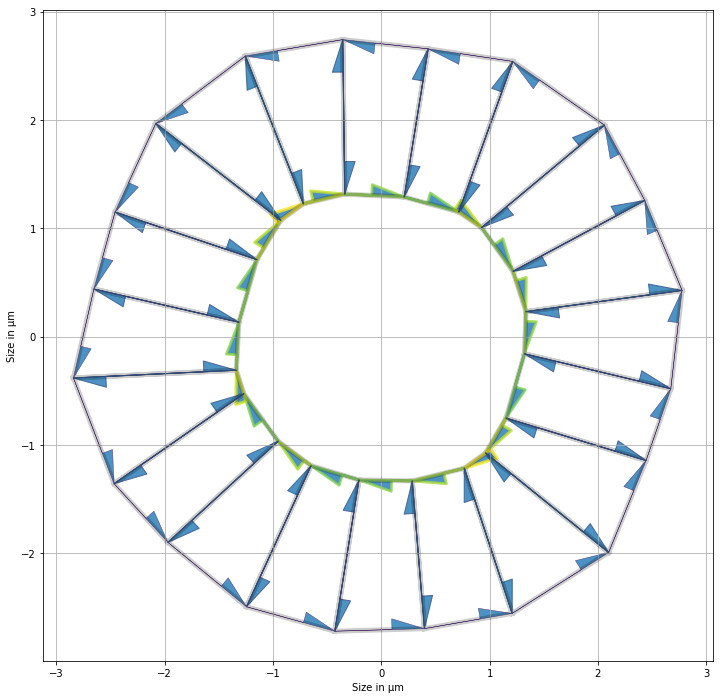

In [4]:
nf, r_in, r_out = (20, 1, 2)
seed = 1
organo3 = create_organo(nf, r_in, r_out)

organo3.edge_df.loc[organo3.apical_edges, 'line_tension'] = [
    0.101, 0.115, 0.126, 0.110, 0.105,
    0.102, 0.112, 0.102, 0.118, 0.105,
    0.104, 0.115, 0.127, 0.116, 0.106,
    0.103, 0.117, 0.105, 0.111, 0.107
]

organo3.edge_df.loc[organo3.basal_edges, 'line_tension'] = [
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01,
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01
]

organo3.edge_df.loc[organo3.lateral_edges, 'line_tension'] = np.array([
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03
])

organo3.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo3.face_df.area

geom.update_all(organo3)
Solver.find_energy_min(organo3, geom, model)
print_tensions(organo3, organo3)

In [5]:
real_data = np.concatenate((organo3.edge_df.line_tension[:3*organo3.Nf],
                            organo3.face_df.prefered_area - organo3.face_df.area,
                            [organo3.settings['lumen_prefered_vol']-
                             organo3.settings['lumen_volume']]))
print(organo3.edge_df.line_tension, '\n',
      organo3.face_df.prefered_area - organo3.face_df.area)

edge
0     0.101
1     0.115
2     0.126
3     0.110
4     0.105
5     0.102
6     0.112
7     0.102
8     0.118
9     0.105
10    0.104
11    0.115
12    0.127
13    0.116
14    0.106
15    0.103
16    0.117
17    0.105
18    0.111
19    0.107
20    0.010
21    0.011
22    0.012
23    0.011
24    0.010
25    0.010
26    0.011
27    0.010
28    0.011
29    0.010
      ...  
50    0.030
51    0.035
52    0.040
53    0.035
54    0.030
55    0.030
56    0.035
57    0.030
58    0.035
59    0.030
60    0.030
61    0.035
62    0.040
63    0.035
64    0.030
65    0.030
66    0.035
67    0.030
68    0.035
69    0.030
70    0.030
71    0.035
72    0.040
73    0.035
74    0.030
75    0.030
76    0.035
77    0.030
78    0.035
79    0.030
Name: line_tension, Length: 80, dtype: float64 
 face
0     0.037466
1     0.042980
2     0.047452
3     0.041083
4     0.039120
5     0.037130
6     0.042399
7     0.037119
8     0.043188
9     0.038093
10    0.038654
11    0.042510
12    0.047137
13    0.042130

In [6]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo3.Nf),[1000]*(3*organo3.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_eq_cst_per_cell.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True, 'maxiter': 1e9, 'maxfev': 1e15}}

reg_weight = 1e-3
theta = 0.02

#### Calcul des paramètres dans l'organo régulier avec la procédure de Guillaume

In [7]:
def get_sim_mat(Nf, Ra, Rb, sum_lbda=1e-2):

    sin_t = np.sin(np.pi/Nf)
    sin_2t = np.sin(2*np.pi/Nf)

    A = 0.5 * (Rb**2 - Ra**2) * sin_2t
    dAdRa = - sin_2t * Ra
    dAdRb = sin_2t * Rb
    dladRa = dlbdRb = 2*sin_t

    # variables are
    # (A - A_0), \Lambda_a, \Lambda_h
    problem_mat = np.array(
        [
            [dAdRa, dladRa, -1],
            [dAdRb, 0,       1],
            [0,     1,       1]
        ])

    b = np.array([0, 0, sum_lbda])
    return problem_mat, b

In [8]:
params_in_sym_mesh = np.linalg.solve(*get_sim_mat(nf, r_in, r_out))

In [9]:
params_in_sym_mesh

array([-0.00622773,  0.00615105,  0.00384895])

 ####  Maintenant on connait les paramètres dans l'organoïde régulier. Il s'agit maintenant de calculer la déformation entre les cellules de l'organoïde régulier et les cellules de l'organoïde réel.

In [10]:
organo3.get_extra_indices()
non_lateral_edges = np.concatenate((organo3.apical_edges,
                                    organo3.basal_edges))
sym_height = (r_out-r_in)*np.cos(np.pi/organo3.Nf)
polar_coefs = np.ones(organo3.Nf)
for cell in range(organo3.Nf):
    parrallel_edges = (organo3.edge_df.loc[non_lateral_edges, ('srce', 'trgt')]
                       [organo3.edge_df.face == cell]).values
    apical_middle = organo3.vert_df.loc[parrallel_edges[0, :], ('x', 'y')].sum()/2
    basal_middle = organo3.vert_df.loc[parrallel_edges[1, :], ('x', 'y')].sum()/2
    cell_height = np.linalg.norm(apical_middle - basal_middle)
    polar_coefs[cell] = cell_height/sym_height
polar_coefs

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([1.38680545, 1.39720938, 1.39441585, 1.39709666, 1.39832084,
       1.42797119, 1.3959597 , 1.43345176, 1.44201388, 1.44398528,
       1.392824  , 1.41778809, 1.42702144, 1.43985784, 1.4182954 ,
       1.44300866, 1.44280479, 1.43956153, 1.41285569, 1.41541343])

#### Et maintenant on fixe la constante par cellule selon les paramètres dans l'organoïde symétrique et le coefficient de polarisation

[0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654, 0.021433658384297654]
[0.02972431 0.02994731 0.02988743 0.02994489 0.02997113 0.03060665
 0.02992052 0.03072412 0.03090763 0.03094989 0.02985331 0.03038839
 0.03058629 0.03086142 0.03039926 0.03092895 0.03092459 0.03085507
 0.03028267 0.03033749]
Apical tensions:  [0.0298147  0.03102859 0.03090145 0.02975578 0.03009275 0.02993051
 0.02989625 0.02965492 0.03153079 0.03038501 0.03010137 0.03092335
 0.03132409 0.03078488 0.03053737 0.03062762 0.03130779 0.03004165
 0.030368   0.03037362] 
Basal tensions:  [0.00289728 0.00150751 0.         0.00166469 0.00266555 0.00323206
 0.001

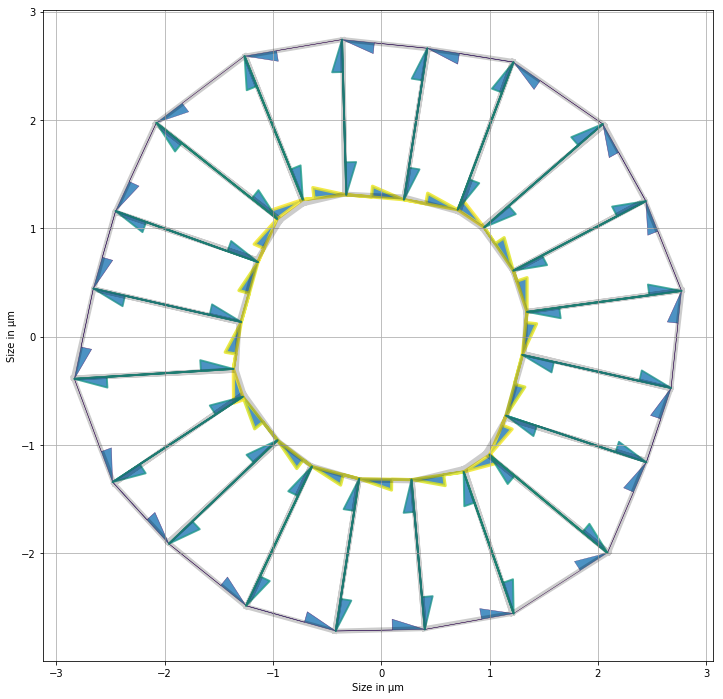

In [11]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
               (organo3.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo3.Nf
print(avg_cste)
avg_cste = np.multiply(np.array(avg_cste), polar_coefs)
print(avg_cste)
for i in range(organo3.Nf):
    i_cell_line = np.zeros(4*organo3.Nf+1)
    index = np.squeeze(np.argwhere(organo3.edge_df.face.values == i)[:-1])
    i_cell_line[index] = 1
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
mat_eq_cst, residuals = nnls(matrix, constant)
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 mat_eq_cst[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + mat_eq_cst[3*organo3.Nf:
                                                                                          4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = organo3_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', mat_eq_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_eq_cst),
      '\nDistance from th org to exp org: ', np.sum(np.linalg.norm(_distance(organo3_eq_cst, organo3), axis=1)),
      '\nNNLS residuals: ', residuals)

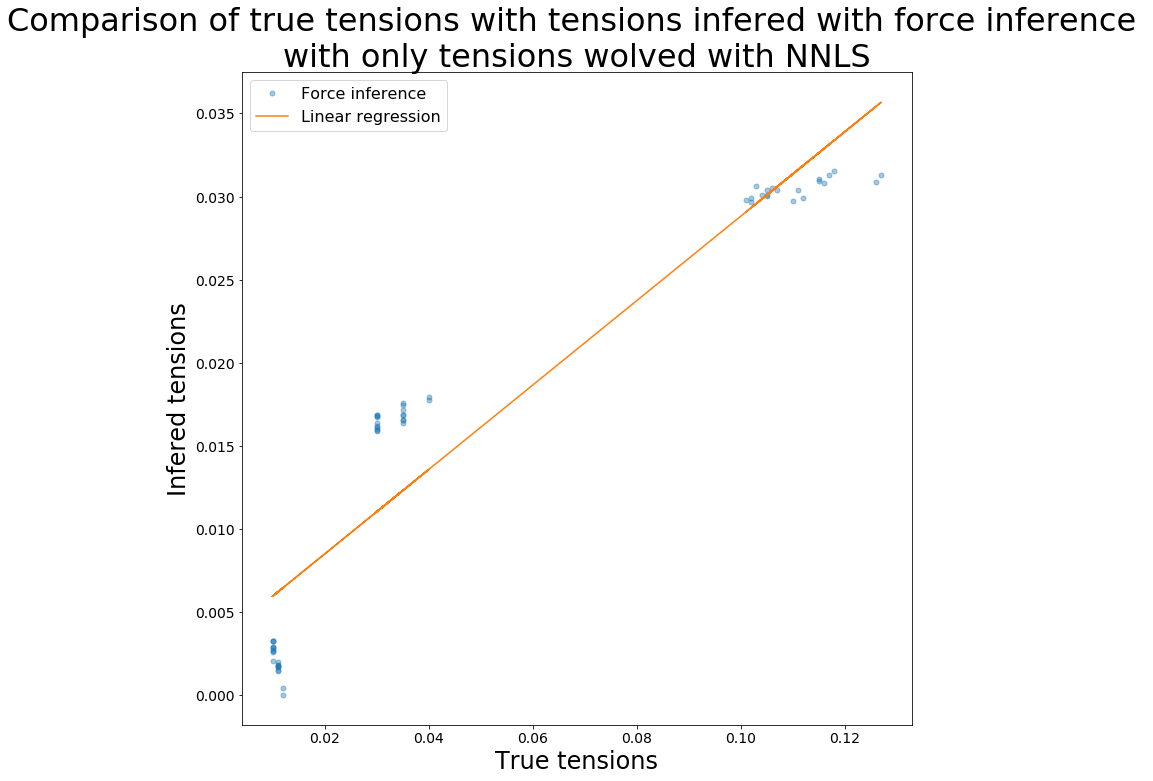

R value : 0.942491839225785 
Standard error : 0.0033556103685508532


In [12]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_eq_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

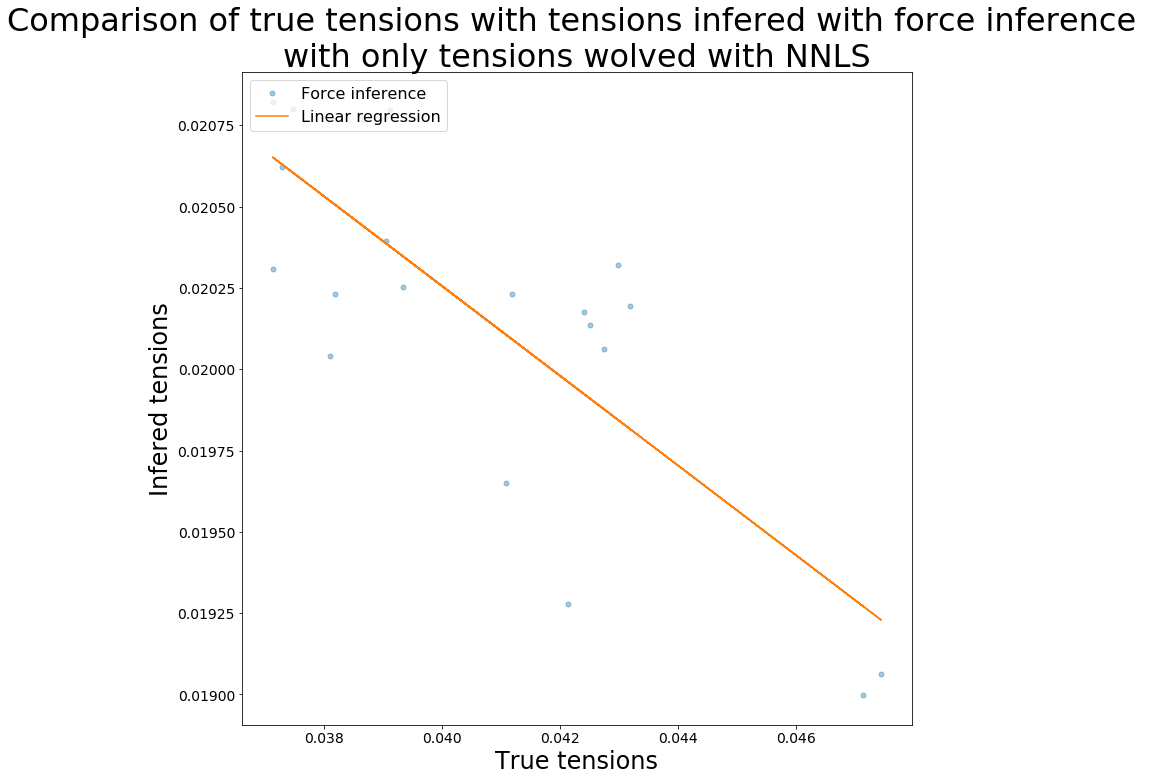

R value : -0.7901047681588707 
Standard error : 0.00016173231524875892


In [13]:
rendering_results(organo3, organo3.face_df.eval('prefered_area-area'),
                  mat_eq_cst[3*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [14]:
iprint_file = "../../assets/dist_at_each_f_ev/10_03_eq_t_per_cell_areas_opt_with_sym_org_params.txt"
to_opt_organo = organo3.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_eq_cst[:3*organo3.Nf]),
                                                   to_opt_organo.face_df.area + mat_eq_cst[3*organo3.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_eq_cst[-1]]))
res_2_cst_areas = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    energy_min_opt=energy_opt,
                                    COPY_OR_SYM='sym',
                                    **lm_opt)

0.6720275310228812 [0.01923604 0.02094468 0.04370871 0.03631729 0.01140217 0.00718591
 0.01231069 0.00979133 0.03026606 0.0327711  0.01906798 0.0227922
 0.03781635 0.04100452 0.01425567 0.02204674 0.02497219 0.02583452
 0.00871158 0.0142879  0.00798051 0.01664474 0.01103165 0.0141155
 0.00963819 0.00765399 0.00837893 0.01526393 0.02000007 0.01061584
 0.00791387 0.01072094 0.00837675 0.00840592 0.00783721 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478562 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.6720275323542046 [0.01923604 0.02094468 0.04370871 0.03631729 0.01140217 0.00718591
 0.01231069 0.00979133 0.03026606 0.0327711  0.01906798 0.0227922
 0.03781635 0.04100452 0.01425567 0.02204674 0.02497219 0.02583452
 0.00871158 0.0142879  0.00798051 0.01664474 0.01103165 0.0141155
 0.00963819 0.00765399 0.00837893 0.01526393 0.02000007 0.01061584
 0.00791387 0.01072094 0.00837675 0.00840592 0.00783721 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478562 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.6720275306698472 [0.01923604 0.02094468 0.04370871 0.03631729 0.01140217 0.00718591
 0.01231069 0.00979133 0.03026606 0.0327711  0.01906798 0.0227922
 0.03781635 0.04100452 0.01425567 0.02204674 0.02497219 0.02583452
 0.00871158 0.0142879  0.00798051 0.01664474 0.01103165 0.0141155
 0.00963819 0.00765399 0.00837893 0.01526393 0.02000007 0.01061584
 0.00791388 0.01072094 0.00837675 0.00840592 0.00783721 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478561 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.6720275355164129 [0.01923604 0.02094468 0.04370871 0.03631729 0.01140217 0.00718591
 0.01231069 0.00979133 0.03026606 0.0327711  0.01906798 0.0227922
 0.03781635 0.04100452 0.01425567 0.02204674 0.02497219 0.02583452
 0.00871158 0.0142879  0.00798051 0.01664474 0.01103165 0.0141155
 0.00963819 0.00765399 0.00837893 0.01526393 0.02000007 0.01061584
 0.00791387 0.01072094 0.00837675 0.00840592 0.00783721 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478562 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.672027531095081 [0.01923604 0.02094468 0.04370871 0.03631729 0.01140217 0.00718591
 0.01231069 0.00979133 0.03026606 0.0327711  0.01906798 0.0227922
 0.03781635 0.04100452 0.01425567 0.02204674 0.02497219 0.02583452
 0.00871158 0.0142879  0.00798051 0.01664474 0.01103165 0.0141155
 0.00963819 0.00765399 0.00837893 0.01526393 0.02000007 0.01061584
 0.00791387 0.01072094 0.00837675 0.00840592 0.00783721 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478562 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.6720275293928519 [0.01923604 0.02094468 0.04370871 0.03631729 0.01140217 0.00718591
 0.01231069 0.00979133 0.03026606 0.0327711  0.01906798 0.0227922
 0.03781635 0.04100452 0.01425567 0.02204674 0.02497219 0.02583452
 0.00871158 0.0142879  0.00798051 0.01664474 0.01103165 0.0141155
 0.00963819 0.00765399 0.00837893 0.01526393 0.02000007 0.01061584
 0.00791387 0.01072094 0.00837675 0.00840592 0.00783721 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478562 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.6720275310557501 [0.01923604 0.02094468 0.04370871 0.03631729 0.01140217 0.00718591
 0.01231069 0.00979133 0.03026606 0.0327711  0.01906798 0.0227922
 0.03781635 0.04100452 0.01425567 0.02204674 0.02497219 0.02583452
 0.00871158 0.0142879  0.00798051 0.01664474 0.01103165 0.0141155
 0.00963819 0.00765399 0.00837893 0.01526393 0.02000007 0.01061584
 0.00791387 0.01072094 0.00837675 0.00840592 0.00783721 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478562 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.6720275315262884 [0.01923604 0.02094468 0.04370871 0.03631729 0.01140217 0.00718591
 0.01231069 0.00979133 0.03026606 0.0327711  0.01906798 0.0227922
 0.03781635 0.04100452 0.01425567 0.02204674 0.02497219 0.02583452
 0.00871158 0.0142879  0.00798051 0.01664474 0.01103165 0.0141155
 0.00963819 0.00765399 0.00837893 0.01526393 0.02000007 0.01061584
 0.00791387 0.01072094 0.00837675 0.00840592 0.00783721 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478562 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.6720275285671379 [0.01923604 0.02094468 0.04370871 0.03631729 0.01140217 0.00718591
 0.01231069 0.00979133 0.03026606 0.0327711  0.01906798 0.0227922
 0.03781635 0.04100452 0.01425567 0.02204674 0.02497219 0.02583452
 0.00871158 0.0142879  0.00798051 0.01664474 0.01103165 0.0141155
 0.0096382  0.00765399 0.00837893 0.01526393 0.02000007 0.01061584
 0.00791387 0.01072094 0.00837675 0.00840592 0.00783721 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478562 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.6720275317012959 [0.01923604 0.02094468 0.04370871 0.03631729 0.01140217 0.00718591
 0.01231069 0.00979133 0.03026606 0.0327711  0.01906798 0.0227922
 0.03781635 0.04100452 0.01425567 0.02204674 0.02497219 0.02583452
 0.00871158 0.0142879  0.00798051 0.01664474 0.01103165 0.0141155
 0.00963819 0.00765399 0.00837893 0.01526393 0.02000007 0.01061584
 0.00791388 0.01072094 0.00837675 0.00840592 0.00783721 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478562 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.6720275354128937 [0.01923604 0.02094468 0.04370871 0.03631729 0.01140217 0.00718591
 0.01231069 0.00979133 0.03026606 0.0327711  0.01906798 0.0227922
 0.03781635 0.04100452 0.01425567 0.02204674 0.02497219 0.02583452
 0.00871158 0.0142879  0.00798051 0.01664474 0.01103165 0.0141155
 0.00963819 0.00765399 0.00837893 0.01526393 0.02000007 0.01061584
 0.00791387 0.01072094 0.00837675 0.00840592 0.00783721 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478561 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.6720275310228812 [0.01923604 0.02094468 0.04370871 0.03631729 0.01140217 0.00718591
 0.01231069 0.00979133 0.03026606 0.0327711  0.01906798 0.0227922
 0.03781635 0.04100452 0.01425567 0.02204674 0.02497219 0.02583452
 0.00871158 0.0142879  0.00798051 0.01664474 0.01103165 0.0141155
 0.00963819 0.00765399 0.00837893 0.01526393 0.02000007 0.01061584
 0.00791387 0.01072094 0.00837675 0.00840592 0.00783721 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478562 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.6720275310228812 [0.01923604 0.02094468 0.04370871 0.03631729 0.01140217 0.00718591
 0.01231069 0.00979133 0.03026606 0.0327711  0.01906798 0.0227922
 0.03781635 0.04100452 0.01425567 0.02204674 0.02497219 0.02583452
 0.00871158 0.0142879  0.00798051 0.01664474 0.01103165 0.0141155
 0.00963819 0.00765399 0.00837893 0.01526393 0.02000007 0.01061584
 0.00791387 0.01072094 0.00837675 0.00840592 0.00783721 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478562 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.6720275310228812 [0.01923604 0.02094468 0.04370871 0.03631729 0.01140217 0.00718591
 0.01231069 0.00979133 0.03026606 0.0327711  0.01906798 0.0227922
 0.03781635 0.04100452 0.01425567 0.02204674 0.02497219 0.02583452
 0.00871158 0.0142879  0.00798051 0.01664474 0.01103165 0.0141155
 0.00963819 0.00765399 0.00837893 0.01526393 0.02000007 0.01061584
 0.00791387 0.01072094 0.00837675 0.00840592 0.00783721 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478562 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.6720276514064979 [0.01923604 0.02094469 0.04370871 0.0363173  0.01140218 0.00718591
 0.01231069 0.00979133 0.03026607 0.0327711  0.01906799 0.02279221
 0.03781635 0.04100453 0.01425567 0.02204675 0.02497219 0.02583452
 0.00871158 0.0142879  0.00798051 0.01664474 0.01103165 0.0141155
 0.0096382  0.00765399 0.00837894 0.01526393 0.02000008 0.01061584
 0.00791388 0.01072094 0.00837675 0.00840593 0.00783722 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478561 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6720276967372463 [0.01923604 0.02094469 0.04370872 0.0363173  0.01140218 0.00718591
 0.01231069 0.00979132 0.03026606 0.03277111 0.01906799 0.02279221
 0.03781636 0.04100454 0.01425567 0.02204675 0.02497219 0.02583452
 0.00871158 0.01428791 0.00798051 0.01664474 0.01103165 0.0141155
 0.0096382  0.00765399 0.00837893 0.01526393 0.02000008 0.01061584
 0.00791388 0.01072094 0.00837675 0.00840593 0.00783722 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478561 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6720276039083656 [0.01923604 0.02094468 0.04370872 0.0363173  0.01140218 0.00718591
 0.01231069 0.00979133 0.03026606 0.0327711  0.01906799 0.02279221
 0.03781635 0.04100453 0.01425568 0.02204674 0.02497219 0.02583452
 0.00871158 0.01428791 0.00798051 0.01664474 0.01103165 0.0141155
 0.0096382  0.00765399 0.00837893 0.01526392 0.02000007 0.01061584
 0.00791388 0.01072093 0.00837675 0.00840593 0.00783721 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478561 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.672027597013364 [0.01923605 0.02094469 0.04370871 0.0363173  0.01140218 0.00718591
 0.01231069 0.00979133 0.03026606 0.0327711  0.01906799 0.02279221
 0.03781635 0.04100453 0.01425567 0.02204674 0.02497219 0.02583452
 0.00871158 0.0142879  0.0079805  0.01664474 0.01103165 0.0141155
 0.0096382  0.00765399 0.00837894 0.01526393 0.02000008 0.01061584
 0.00791388 0.01072094 0.00837675 0.00840592 0.00783722 0.00992943
 0.00890126 0.01744331 0.01166624 0.00478561 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.48206818179128136 [1.12360421e-02 9.99200199e-03 3.09503740e-02 2.34304058e-02
 8.67323029e-03 4.29285964e-03 1.10320736e-02 4.92818422e-03
 1.70379983e-02 2.50114547e-02 1.31896911e-02 1.33036279e-02
 2.82695477e-02 3.25754018e-02 7.60464367e-03 1.36467142e-02
 1.63464814e-02 1.64810003e-02 6.47987830e-03 1.41363254e-02
 3.40420130e-03 1.54357884e-02 1.82481224e-02 1.34783789e-02
 1.61830168e-02 3.12920114e-03 2.49612159e-03 9.16192685e-04
 1.25262375e-02 5.63947347e-03 2.34394426e-03 1.31976581e-02
 1.41042367e-02 1.27822667e-02 1.26050524e-02 7.38412195e-03
 5.96901818e-03 5.43208228e-03 5.80613063e-03 2.36854168e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.48206818471098034 [1.12360420e-02 9.99200433e-03 3.09503745e-02 2.34304061e-02
 8.67323076e-03 4.29285802e-03 1.10320733e-02 4.92818395e-03
 1.70379984e-02 2.50114548e-02 1.31896911e-02 1.33036279e-02
 2.82695478e-02 3.25754018e-02 7.60464367e-03 1.36467142e-02
 1.63464814e-02 1.64810003e-02 6.47987826e-03 1.41363253e-02
 3.40420136e-03 1.54357903e-02 1.82481210e-02 1.34783791e-02
 1.61830163e-02 3.12920171e-03 2.49612274e-03 9.16192055e-04
 1.25262373e-02 5.63947346e-03 2.34394424e-03 1.31976581e-02
 1.41042367e-02 1.27822667e-02 1.26050524e-02 7.38412195e-03
 5.96901819e-03 5.43208231e-03 5.80613071e-03 2.36854186e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4820681905995909 [1.12360420e-02 9.99200437e-03 3.09503746e-02 2.34304061e-02
 8.67323048e-03 4.29285961e-03 1.10320736e-02 4.92818434e-03
 1.70379981e-02 2.50114548e-02 1.31896916e-02 1.33036282e-02
 2.82695479e-02 3.25754019e-02 7.60464368e-03 1.36467143e-02
 1.63464814e-02 1.64810003e-02 6.47987826e-03 1.41363254e-02
 3.40420139e-03 1.54357904e-02 1.82481211e-02 1.34783794e-02
 1.61830167e-02 3.12920110e-03 2.49612168e-03 9.16192568e-04
 1.25262373e-02 5.63947494e-03 2.34394582e-03 1.31976582e-02
 1.41042366e-02 1.27822667e-02 1.26050524e-02 7.38412199e-03
 5.96901819e-03 5.43208232e-03 5.80613071e-03 2.36854184e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.48206818276434604 [1.12360420e-02 9.99200435e-03 3.09503745e-02 2.34304060e-02
 8.67323044e-03 4.29285962e-03 1.10320735e-02 4.92818422e-03
 1.70379984e-02 2.50114548e-02 1.31896910e-02 1.33036278e-02
 2.82695475e-02 3.25754012e-02 7.60464164e-03 1.36467141e-02
 1.63464815e-02 1.64810003e-02 6.47987827e-03 1.41363253e-02
 3.40420138e-03 1.54357903e-02 1.82481211e-02 1.34783793e-02
 1.61830166e-02 3.12920109e-03 2.49612161e-03 9.16192682e-04
 1.25262375e-02 5.63947345e-03 2.34394434e-03 1.31976583e-02
 1.41042364e-02 1.27822678e-02 1.26050505e-02 7.38412262e-03
 5.96901797e-03 5.43208230e-03 5.80613068e-03 2.36854183e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4820681871043337 [1.12360420e-02 9.99200442e-03 3.09503746e-02 2.34304061e-02
 8.67323047e-03 4.29285964e-03 1.10320735e-02 4.92818421e-03
 1.70379984e-02 2.50114548e-02 1.31896911e-02 1.33036280e-02
 2.82695478e-02 3.25754019e-02 7.60464375e-03 1.36467143e-02
 1.63464812e-02 1.64810003e-02 6.47987729e-03 1.41363252e-02
 3.40420155e-03 1.54357903e-02 1.82481211e-02 1.34783794e-02
 1.61830167e-02 3.12920110e-03 2.49612162e-03 9.16192679e-04
 1.25262376e-02 5.63947348e-03 2.34394428e-03 1.31976582e-02
 1.41042367e-02 1.27822667e-02 1.26050524e-02 7.38412199e-03
 5.96901795e-03 5.43208391e-03 5.80613092e-03 2.36854131e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.482068186387933 [1.12360421e-02 9.99200443e-03 3.09503745e-02 2.34304060e-02
 8.67323047e-03 4.29285965e-03 1.10320735e-02 4.92818418e-03
 1.70379983e-02 2.50114547e-02 1.31896912e-02 1.33036280e-02
 2.82695477e-02 3.25754018e-02 7.60464370e-03 1.36467143e-02
 1.63464814e-02 1.64810003e-02 6.47987821e-03 1.41363253e-02
 3.40420139e-03 1.54357904e-02 1.82481210e-02 1.34783793e-02
 1.61830167e-02 3.12920111e-03 2.49612162e-03 9.16192658e-04
 1.25262375e-02 5.63947345e-03 2.34394429e-03 1.31976582e-02
 1.41042367e-02 1.27822667e-02 1.26050524e-02 7.38412200e-03
 5.96901816e-03 5.43208229e-03 5.80613067e-03 2.36854180e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.4820681859332556 [1.12360421e-02 9.99200435e-03 3.09503745e-02 2.34304060e-02
 8.67323048e-03 4.29285988e-03 1.10320734e-02 4.92818418e-03
 1.70379983e-02 2.50114547e-02 1.31896912e-02 1.33036280e-02
 2.82695477e-02 3.25754018e-02 7.60464370e-03 1.36467143e-02
 1.63464814e-02 1.64810003e-02 6.47987821e-03 1.41363253e-02
 3.40420139e-03 1.54357903e-02 1.82481211e-02 1.34783793e-02
 1.61830166e-02 3.12920091e-03 2.49612137e-03 9.16192652e-04
 1.25262375e-02 5.63947346e-03 2.34394429e-03 1.31976582e-02
 1.41042367e-02 1.27822667e-02 1.26050524e-02 7.38412199e-03
 5.96901816e-03 5.43208230e-03 5.80613068e-03 2.36854181e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.48206818577817206 [1.12360421e-02 9.99200435e-03 3.09503745e-02 2.34304060e-02
 8.67323047e-03 4.29285965e-03 1.10320735e-02 4.92818418e-03
 1.70379983e-02 2.50114547e-02 1.31896912e-02 1.33036280e-02
 2.82695477e-02 3.25754018e-02 7.60464369e-03 1.36467143e-02
 1.63464814e-02 1.64810002e-02 6.47987821e-03 1.41363253e-02
 3.40420139e-03 1.54357903e-02 1.82481211e-02 1.34783793e-02
 1.61830167e-02 3.12920111e-03 2.49612162e-03 9.16192658e-04
 1.25262375e-02 5.63947326e-03 2.34394405e-03 1.31976582e-02
 1.41042367e-02 1.27822667e-02 1.26050524e-02 7.38412199e-03
 5.96901816e-03 5.43208230e-03 5.80613067e-03 2.36854181e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4820681865702443 [1.12360421e-02 9.99200435e-03 3.09503745e-02 2.34304060e-02
 8.67323048e-03 4.29285965e-03 1.10320735e-02 4.92818418e-03
 1.70379983e-02 2.50114547e-02 1.31896912e-02 1.33036280e-02
 2.82695478e-02 3.25754018e-02 7.60464381e-03 1.36467143e-02
 1.63464814e-02 1.64810003e-02 6.47987821e-03 1.41363253e-02
 3.40420139e-03 1.54357903e-02 1.82481211e-02 1.34783793e-02
 1.61830167e-02 3.12920112e-03 2.49612162e-03 9.16192658e-04
 1.25262375e-02 5.63947346e-03 2.34394429e-03 1.31976582e-02
 1.41042367e-02 1.27822666e-02 1.26050525e-02 7.38412201e-03
 5.96901816e-03 5.43208230e-03 5.80613067e-03 2.36854181e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4820681860074762 [1.12360420e-02 9.99200435e-03 3.09503745e-02 2.34304060e-02
 8.67323047e-03 4.29285965e-03 1.10320735e-02 4.92818418e-03
 1.70379983e-02 2.50114547e-02 1.31896912e-02 1.33036280e-02
 2.82695477e-02 3.25754018e-02 7.60464370e-03 1.36467143e-02
 1.63464814e-02 1.64810001e-02 6.47987820e-03 1.41363253e-02
 3.40420141e-03 1.54357903e-02 1.82481211e-02 1.34783793e-02
 1.61830167e-02 3.12920111e-03 2.49612162e-03 9.16192660e-04
 1.25262375e-02 5.63947346e-03 2.34394429e-03 1.31976582e-02
 1.41042367e-02 1.27822667e-02 1.26050524e-02 7.38412199e-03
 5.96901817e-03 5.43208203e-03 5.80613079e-03 2.36854179e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4820681940675977 [1.12360423e-02 9.99200537e-03 3.09503746e-02 2.34304061e-02
 8.67323075e-03 4.29285976e-03 1.10320734e-02 4.92818409e-03
 1.70379983e-02 2.50114548e-02 1.31896915e-02 1.33036283e-02
 2.82695479e-02 3.25754020e-02 7.60464381e-03 1.36467147e-02
 1.63464814e-02 1.64810002e-02 6.47987802e-03 1.41363251e-02
 3.40420167e-03 1.54357918e-02 1.82481227e-02 1.34783796e-02
 1.61830167e-02 3.12920117e-03 2.49612169e-03 9.16192597e-04
 1.25262376e-02 5.63947344e-03 2.34394435e-03 1.31976584e-02
 1.41042368e-02 1.27822667e-02 1.26050525e-02 7.38412214e-03
 5.96901815e-03 5.43208237e-03 5.80613082e-03 2.36854216e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4820681882121683 [1.12360422e-02 9.99200438e-03 3.09503744e-02 2.34304058e-02
 8.67322979e-03 4.29285839e-03 1.10320730e-02 4.92818419e-03
 1.70379982e-02 2.50114547e-02 1.31896913e-02 1.33036281e-02
 2.82695477e-02 3.25754017e-02 7.60464374e-03 1.36467145e-02
 1.63464813e-02 1.64810002e-02 6.47987811e-03 1.41363252e-02
 3.40420143e-03 1.54357903e-02 1.82481211e-02 1.34783798e-02
 1.61830176e-02 3.12920346e-03 2.49612176e-03 9.16193035e-04
 1.25262377e-02 5.63947344e-03 2.34394433e-03 1.31976582e-02
 1.41042367e-02 1.27822666e-02 1.26050524e-02 7.38412206e-03
 5.96901812e-03 5.43208227e-03 5.80613064e-03 2.36854176e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4820681853464415 [1.12360420e-02 9.99200428e-03 3.09503743e-02 2.34304058e-02
 8.67323043e-03 4.29285969e-03 1.10320734e-02 4.92818382e-03
 1.70379986e-02 2.50114572e-02 1.31896914e-02 1.33036279e-02
 2.82695475e-02 3.25754016e-02 7.60464367e-03 1.36467143e-02
 1.63464812e-02 1.64810001e-02 6.47987813e-03 1.41363252e-02
 3.40420138e-03 1.54357903e-02 1.82481209e-02 1.34783792e-02
 1.61830166e-02 3.12920110e-03 2.49612147e-03 9.16192901e-04
 1.25262379e-02 5.63947143e-03 2.34394476e-03 1.31976582e-02
 1.41042368e-02 1.27822666e-02 1.26050523e-02 7.38412197e-03
 5.96901811e-03 5.43208225e-03 5.80613062e-03 2.36854177e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.48206818185484746 [1.12360420e-02 9.99200424e-03 3.09503742e-02 2.34304058e-02
 8.67323038e-03 4.29285962e-03 1.10320734e-02 4.92818410e-03
 1.70379981e-02 2.50114544e-02 1.31896911e-02 1.33036281e-02
 2.82695478e-02 3.25754042e-02 7.60464445e-03 1.36467145e-02
 1.63464811e-02 1.64810001e-02 6.47987811e-03 1.41363251e-02
 3.40420136e-03 1.54357902e-02 1.82481209e-02 1.34783792e-02
 1.61830165e-02 3.12920109e-03 2.49612160e-03 9.16192640e-04
 1.25262374e-02 5.63947344e-03 2.34394413e-03 1.31976576e-02
 1.41042372e-02 1.27822640e-02 1.26050512e-02 7.38412146e-03
 5.96901827e-03 5.43208223e-03 5.80613062e-03 2.36854178e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4820681888567081 [1.12360423e-02 9.99200429e-03 3.09503744e-02 2.34304059e-02
 8.67323051e-03 4.29285970e-03 1.10320734e-02 4.92818411e-03
 1.70379982e-02 2.50114547e-02 1.31896913e-02 1.33036281e-02
 2.82695477e-02 3.25754017e-02 7.60464360e-03 1.36467145e-02
 1.63464818e-02 1.64810029e-02 6.47987807e-03 1.41363251e-02
 3.40420125e-03 1.54357904e-02 1.82481210e-02 1.34783793e-02
 1.61830167e-02 3.12920115e-03 2.49612165e-03 9.16192616e-04
 1.25262375e-02 5.63947342e-03 2.34394431e-03 1.31976582e-02
 1.41042367e-02 1.27822667e-02 1.26050525e-02 7.38412203e-03
 5.96901855e-03 5.43208069e-03 5.80613157e-03 2.36854213e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4820681863603778 [1.12360421e-02 9.99200435e-03 3.09503745e-02 2.34304060e-02
 8.67323048e-03 4.29285965e-03 1.10320735e-02 4.92818418e-03
 1.70379983e-02 2.50114547e-02 1.31896912e-02 1.33036280e-02
 2.82695477e-02 3.25754018e-02 7.60464370e-03 1.36467143e-02
 1.63464814e-02 1.64810003e-02 6.47987821e-03 1.41363253e-02
 3.40420139e-03 1.54357903e-02 1.82481211e-02 1.34783793e-02
 1.61830167e-02 3.12920112e-03 2.49612162e-03 9.16192657e-04
 1.25262375e-02 5.63947345e-03 2.34394429e-03 1.31976582e-02
 1.41042367e-02 1.27822667e-02 1.26050524e-02 7.38412200e-03
 5.96901816e-03 5.43208230e-03 5.80613067e-03 2.36854181e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4820681863603778 [1.12360421e-02 9.99200435e-03 3.09503745e-02 2.34304060e-02
 8.67323048e-03 4.29285965e-03 1.10320735e-02 4.92818418e-03
 1.70379983e-02 2.50114547e-02 1.31896912e-02 1.33036280e-02
 2.82695477e-02 3.25754018e-02 7.60464370e-03 1.36467143e-02
 1.63464814e-02 1.64810003e-02 6.47987821e-03 1.41363253e-02
 3.40420139e-03 1.54357903e-02 1.82481211e-02 1.34783793e-02
 1.61830167e-02 3.12920112e-03 2.49612162e-03 9.16192657e-04
 1.25262375e-02 5.63947345e-03 2.34394429e-03 1.31976582e-02
 1.41042367e-02 1.27822667e-02 1.26050524e-02 7.38412200e-03
 5.96901816e-03 5.43208230e-03 5.80613067e-03 2.36854181e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4820681863603778 [1.12360421e-02 9.99200435e-03 3.09503745e-02 2.34304060e-02
 8.67323048e-03 4.29285965e-03 1.10320735e-02 4.92818418e-03
 1.70379983e-02 2.50114547e-02 1.31896912e-02 1.33036280e-02
 2.82695477e-02 3.25754018e-02 7.60464370e-03 1.36467143e-02
 1.63464814e-02 1.64810003e-02 6.47987821e-03 1.41363253e-02
 3.40420139e-03 1.54357903e-02 1.82481211e-02 1.34783793e-02
 1.61830167e-02 3.12920112e-03 2.49612162e-03 9.16192657e-04
 1.25262375e-02 5.63947345e-03 2.34394429e-03 1.31976582e-02
 1.41042367e-02 1.27822667e-02 1.26050524e-02 7.38412200e-03
 5.96901816e-03 5.43208230e-03 5.80613067e-03 2.36854181e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4820681863603778 [1.12360421e-02 9.99200435e-03 3.09503745e-02 2.34304060e-02
 8.67323048e-03 4.29285965e-03 1.10320735e-02 4.92818418e-03
 1.70379983e-02 2.50114547e-02 1.31896912e-02 1.33036280e-02
 2.82695477e-02 3.25754018e-02 7.60464370e-03 1.36467143e-02
 1.63464814e-02 1.64810003e-02 6.47987821e-03 1.41363253e-02
 3.40420139e-03 1.54357903e-02 1.82481211e-02 1.34783793e-02
 1.61830167e-02 3.12920112e-03 2.49612162e-03 9.16192657e-04
 1.25262375e-02 5.63947345e-03 2.34394429e-03 1.31976582e-02
 1.41042367e-02 1.27822667e-02 1.26050524e-02 7.38412200e-03
 5.96901816e-03 5.43208230e-03 5.80613067e-03 2.36854181e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4820681863603778 [1.12360421e-02 9.99200435e-03 3.09503745e-02 2.34304060e-02
 8.67323048e-03 4.29285965e-03 1.10320735e-02 4.92818418e-03
 1.70379983e-02 2.50114547e-02 1.31896912e-02 1.33036280e-02
 2.82695477e-02 3.25754018e-02 7.60464370e-03 1.36467143e-02
 1.63464814e-02 1.64810003e-02 6.47987821e-03 1.41363253e-02
 3.40420139e-03 1.54357903e-02 1.82481211e-02 1.34783793e-02
 1.61830167e-02 3.12920112e-03 2.49612162e-03 9.16192657e-04
 1.25262375e-02 5.63947345e-03 2.34394429e-03 1.31976582e-02
 1.41042367e-02 1.27822667e-02 1.26050524e-02 7.38412200e-03
 5.96901816e-03 5.43208230e-03 5.80613067e-03 2.36854181e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4820682247689774 [1.12360427e-02 9.99200740e-03 3.09503739e-02 2.34304080e-02
 8.67323205e-03 4.29286001e-03 1.10320737e-02 4.92818412e-03
 1.70379995e-02 2.50114561e-02 1.31896929e-02 1.33036296e-02
 2.82695497e-02 3.25754040e-02 7.60464436e-03 1.36467162e-02
 1.63464821e-02 1.64810011e-02 6.47987820e-03 1.41363256e-02
 3.40420370e-03 1.54357886e-02 1.82481272e-02 1.34783804e-02
 1.61830174e-02 3.12920189e-03 2.49612226e-03 9.16192052e-04
 1.25262384e-02 5.63947334e-03 2.34394505e-03 1.31976600e-02
 1.41042374e-02 1.27822672e-02 1.26050537e-02 7.38412345e-03
 5.96901809e-03 5.43208260e-03 5.80613098e-03 2.36854142e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4820682528596766 [1.12360446e-02 9.99200569e-03 3.09503784e-02 2.34304087e-02
 8.67323211e-03 4.29286467e-03 1.10320711e-02 4.92818527e-03
 1.70380003e-02 2.50114574e-02 1.31896945e-02 1.33036317e-02
 2.82695512e-02 3.25754060e-02 7.60464484e-03 1.36467181e-02
 1.63464830e-02 1.64810016e-02 6.47987836e-03 1.41363263e-02
 3.40420359e-03 1.54357934e-02 1.82481227e-02 1.34783812e-02
 1.61830202e-02 3.12920183e-03 2.49612212e-03 9.16192653e-04
 1.25262388e-02 5.63947292e-03 2.34394617e-03 1.31976611e-02
 1.41042378e-02 1.27822671e-02 1.26050551e-02 7.38412442e-03
 5.96901726e-03 5.43208271e-03 5.80612991e-03 2.36853963e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4820682071134867 [1.12360428e-02 9.99200496e-03 3.09503754e-02 2.34304069e-02
 8.67323113e-03 4.29286048e-03 1.10320733e-02 4.92818421e-03
 1.70379994e-02 2.50114522e-02 1.31896945e-02 1.33036278e-02
 2.82695485e-02 3.25754027e-02 7.60464458e-03 1.36467150e-02
 1.63464814e-02 1.64810008e-02 6.47987845e-03 1.41363252e-02
 3.40420165e-03 1.54357911e-02 1.82481214e-02 1.34783793e-02
 1.61830172e-02 3.12920218e-03 2.49612207e-03 9.16192090e-04
 1.25262373e-02 5.63947755e-03 2.34394560e-03 1.31976603e-02
 1.41042373e-02 1.27822669e-02 1.26050525e-02 7.38412350e-03
 5.96901806e-03 5.43208198e-03 5.80613013e-03 2.36854107e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.48206817883286984 [1.12360416e-02 9.99200417e-03 3.09503745e-02 2.34304059e-02
 8.67323007e-03 4.29285870e-03 1.10320741e-02 4.92818428e-03
 1.70379982e-02 2.50114549e-02 1.31896908e-02 1.33036276e-02
 2.82695481e-02 3.25753993e-02 7.60464697e-03 1.36467144e-02
 1.63464813e-02 1.64810001e-02 6.47987838e-03 1.41363257e-02
 3.40420148e-03 1.54357903e-02 1.82481201e-02 1.34783787e-02
 1.61830166e-02 3.12920086e-03 2.49612124e-03 9.16192561e-04
 1.25262369e-02 5.63947311e-03 2.34394362e-03 1.31976577e-02
 1.41042360e-02 1.27822709e-02 1.26050491e-02 7.38411985e-03
 5.96901839e-03 5.43208233e-03 5.80613020e-03 2.36854133e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.48206819430559195 [1.12360421e-02 9.99200395e-03 3.09503747e-02 2.34304064e-02
 8.67323066e-03 4.29285988e-03 1.10320734e-02 4.92818440e-03
 1.70379987e-02 2.50114548e-02 1.31896911e-02 1.33036283e-02
 2.82695479e-02 3.25754020e-02 7.60464369e-03 1.36467144e-02
 1.63464819e-02 1.64809975e-02 6.47987670e-03 1.41363251e-02
 3.40420119e-03 1.54357911e-02 1.82481212e-02 1.34783793e-02
 1.61830168e-02 3.12920156e-03 2.49612198e-03 9.16192264e-04
 1.25262374e-02 5.63947319e-03 2.34394462e-03 1.31976583e-02
 1.41042369e-02 1.27822669e-02 1.26050526e-02 7.38412251e-03
 5.96901768e-03 5.43208633e-03 5.80613396e-03 2.36854249e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.5719567484885845 [1.05314615e-02 1.91360685e-02 2.96340266e-02 2.64889606e-02
 7.29578528e-04 2.40562971e-03 1.06210953e-02 1.04048664e-02
 1.80480148e-02 2.22861187e-02 1.30910867e-02 1.79371665e-02
 2.92179276e-02 3.37214192e-02 1.21084102e-02 1.54254920e-02
 1.45162815e-02 1.29912710e-02 8.59919380e-03 1.86749892e-02
 1.56959953e-02 2.63742386e-02 8.35595021e-03 1.77394629e-02
 1.08593134e-02 5.33796819e-03 3.15786431e-03 1.34364995e-02
 1.39632558e-02 1.02043957e-02 1.40513111e-02 1.36702949e-02
 1.81803924e-02 1.65019767e-02 1.74690593e-02 1.38457252e-02
 7.26327549e-03 9.12823627e-03 2.51060098e-03 7.64154626e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4334620300265954 [7.29652467e-03 8.76949116e-03 3.10329691e-02 2.35956634e-02
 3.76206569e-03 1.77179465e-03 9.86036104e-03 3.69079536e-03
 1.50649125e-02 2.21445117e-02 8.04264274e-03 1.44070942e-02
 2.84150635e-02 3.17380937e-02 7.45106605e-03 9.53341534e-03
 1.50075946e-02 1.30326591e-02 7.55741655e-03 1.57586839e-02
 6.18301852e-03 1.30759315e-02 1.13910873e-02 1.39680350e-02
 1.04943914e-02 3.48864262e-03 6.99616147e-04 4.68061761e-03
 1.00507600e-02 5.67024285e-03 5.95080716e-03 9.71880018e-03
 1.28201758e-02 1.11359773e-02 1.14186554e-02 7.27284596e-03
 3.10270239e-03 6.99043471e-03 4.55149977e-03 2.86454540e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.43346203151839097 [7.29652457e-03 8.76949135e-03 3.10329701e-02 2.35956645e-02
 3.76206615e-03 1.77179421e-03 9.86036034e-03 3.69079539e-03
 1.50649124e-02 2.21445117e-02 8.04264264e-03 1.44070941e-02
 2.84150634e-02 3.17380936e-02 7.45106600e-03 9.53341527e-03
 1.50075946e-02 1.30326590e-02 7.55741654e-03 1.57586838e-02
 6.18301828e-03 1.30759314e-02 1.13910878e-02 1.39680355e-02
 1.04943908e-02 3.48864255e-03 6.99615893e-04 4.68061928e-03
 1.00507594e-02 5.67024270e-03 5.95080718e-03 9.71880013e-03
 1.28201758e-02 1.11359773e-02 1.14186554e-02 7.27284591e-03
 3.10270238e-03 6.99043470e-03 4.55149979e-03 2.86454547e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.43346203248758475 [7.29652452e-03 8.76949128e-03 3.10329700e-02 2.35956644e-02
 3.76206600e-03 1.77179450e-03 9.86036098e-03 3.69079536e-03
 1.50649124e-02 2.21445115e-02 8.04264418e-03 1.44070952e-02
 2.84150633e-02 3.17380934e-02 7.45106591e-03 9.53341518e-03
 1.50075945e-02 1.30326590e-02 7.55741652e-03 1.57586838e-02
 6.18301823e-03 1.30759313e-02 1.13910878e-02 1.39680355e-02
 1.04943909e-02 3.48864236e-03 6.99616234e-04 4.68061763e-03
 1.00507598e-02 5.67024236e-03 5.95080685e-03 9.71880165e-03
 1.28201752e-02 1.11359772e-02 1.14186554e-02 7.27284587e-03
 3.10270238e-03 6.99043467e-03 4.55149978e-03 2.86454547e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4334620325777239 [7.29652452e-03 8.76949130e-03 3.10329700e-02 2.35956644e-02
 3.76206601e-03 1.77179450e-03 9.86036099e-03 3.69079535e-03
 1.50649124e-02 2.21445116e-02 8.04264263e-03 1.44070940e-02
 2.84150633e-02 3.17380935e-02 7.45106781e-03 9.53341629e-03
 1.50075946e-02 1.30326590e-02 7.55741654e-03 1.57586838e-02
 6.18301824e-03 1.30759313e-02 1.13910878e-02 1.39680355e-02
 1.04943910e-02 3.48864236e-03 6.99616231e-04 4.68061762e-03
 1.00507599e-02 5.67024282e-03 5.95080709e-03 9.71880015e-03
 1.28201757e-02 1.11359767e-02 1.14186570e-02 7.27284496e-03
 3.10270195e-03 6.99043456e-03 4.55149975e-03 2.86454547e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4334620297406751 [7.29652435e-03 8.76949140e-03 3.10329702e-02 2.35956645e-02
 3.76206605e-03 1.77179454e-03 9.86036101e-03 3.69079535e-03
 1.50649124e-02 2.21445116e-02 8.04264269e-03 1.44070941e-02
 2.84150634e-02 3.17380936e-02 7.45106602e-03 9.53341524e-03
 1.50075946e-02 1.30326590e-02 7.55741601e-03 1.57586828e-02
 6.18301860e-03 1.30759312e-02 1.13910878e-02 1.39680355e-02
 1.04943910e-02 3.48864240e-03 6.99616229e-04 4.68061763e-03
 1.00507599e-02 5.67024284e-03 5.95080713e-03 9.71880015e-03
 1.28201758e-02 1.11359773e-02 1.14186554e-02 7.27284595e-03
 3.10270224e-03 6.99043419e-03 4.55150091e-03 2.86454448e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4334620310730762 [7.29652461e-03 8.76949138e-03 3.10329701e-02 2.35956644e-02
 3.76206605e-03 1.77179455e-03 9.86036095e-03 3.69079530e-03
 1.50649124e-02 2.21445116e-02 8.04264272e-03 1.44070941e-02
 2.84150634e-02 3.17380935e-02 7.45106603e-03 9.53341532e-03
 1.50075945e-02 1.30326590e-02 7.55741648e-03 1.57586838e-02
 6.18301829e-03 1.30759314e-02 1.13910879e-02 1.39680355e-02
 1.04943910e-02 3.48864240e-03 6.99616212e-04 4.68061762e-03
 1.00507599e-02 5.67024282e-03 5.95080714e-03 9.71880014e-03
 1.28201758e-02 1.11359773e-02 1.14186554e-02 7.27284592e-03
 3.10270237e-03 6.99043468e-03 4.55149977e-03 2.86454546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4334620309120077 [7.29652461e-03 8.76949138e-03 3.10329701e-02 2.35956644e-02
 3.76206606e-03 1.77179454e-03 9.86036094e-03 3.69079527e-03
 1.50649124e-02 2.21445116e-02 8.04264272e-03 1.44070941e-02
 2.84150634e-02 3.17380935e-02 7.45106603e-03 9.53341531e-03
 1.50075945e-02 1.30326590e-02 7.55741648e-03 1.57586838e-02
 6.18301829e-03 1.30759314e-02 1.13910878e-02 1.39680355e-02
 1.04943910e-02 3.48864240e-03 6.99616243e-04 4.68061756e-03
 1.00507599e-02 5.67024281e-03 5.95080714e-03 9.71880014e-03
 1.28201758e-02 1.11359773e-02 1.14186554e-02 7.27284592e-03
 3.10270237e-03 6.99043468e-03 4.55149977e-03 2.86454546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4334620306913164 [7.29652461e-03 8.76949138e-03 3.10329701e-02 2.35956644e-02
 3.76206605e-03 1.77179455e-03 9.86036096e-03 3.69079530e-03
 1.50649124e-02 2.21445116e-02 8.04264266e-03 1.44070941e-02
 2.84150634e-02 3.17380936e-02 7.45106603e-03 9.53341531e-03
 1.50075945e-02 1.30326590e-02 7.55741649e-03 1.57586838e-02
 6.18301829e-03 1.30759314e-02 1.13910878e-02 1.39680355e-02
 1.04943910e-02 3.48864240e-03 6.99616213e-04 4.68061762e-03
 1.00507599e-02 5.67024279e-03 5.95080709e-03 9.71879993e-03
 1.28201757e-02 1.11359773e-02 1.14186554e-02 7.27284592e-03
 3.10270237e-03 6.99043468e-03 4.55149977e-03 2.86454546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.43346203078673545 [7.29652461e-03 8.76949138e-03 3.10329701e-02 2.35956644e-02
 3.76206605e-03 1.77179455e-03 9.86036095e-03 3.69079530e-03
 1.50649124e-02 2.21445116e-02 8.04264272e-03 1.44070941e-02
 2.84150634e-02 3.17380936e-02 7.45106594e-03 9.53341531e-03
 1.50075945e-02 1.30326590e-02 7.55741649e-03 1.57586838e-02
 6.18301829e-03 1.30759314e-02 1.13910878e-02 1.39680355e-02
 1.04943910e-02 3.48864240e-03 6.99616213e-04 4.68061762e-03
 1.00507599e-02 5.67024282e-03 5.95080714e-03 9.71880014e-03
 1.28201758e-02 1.11359772e-02 1.14186552e-02 7.27284594e-03
 3.10270235e-03 6.99043467e-03 4.55149977e-03 2.86454546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.433462031014452 [7.29652460e-03 8.76949138e-03 3.10329701e-02 2.35956644e-02
 3.76206605e-03 1.77179455e-03 9.86036095e-03 3.69079530e-03
 1.50649124e-02 2.21445116e-02 8.04264272e-03 1.44070941e-02
 2.84150634e-02 3.17380935e-02 7.45106603e-03 9.53341531e-03
 1.50075945e-02 1.30326590e-02 7.55741646e-03 1.57586838e-02
 6.18301829e-03 1.30759314e-02 1.13910878e-02 1.39680355e-02
 1.04943910e-02 3.48864240e-03 6.99616213e-04 4.68061762e-03
 1.00507599e-02 5.67024282e-03 5.95080714e-03 9.71880014e-03
 1.28201758e-02 1.11359773e-02 1.14186554e-02 7.27284592e-03
 3.10270236e-03 6.99043467e-03 4.55149974e-03 2.86454556e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.4334620290823285 [7.29652450e-03 8.76949192e-03 3.10329723e-02 2.35956646e-02
 3.76206629e-03 1.77179448e-03 9.86036083e-03 3.69079523e-03
 1.50649122e-02 2.21445114e-02 8.04264270e-03 1.44070941e-02
 2.84150631e-02 3.17380933e-02 7.45106600e-03 9.53341529e-03
 1.50075944e-02 1.30326588e-02 7.55741638e-03 1.57586835e-02
 6.18301786e-03 1.30759312e-02 1.13910859e-02 1.39680358e-02
 1.04943907e-02 3.48864226e-03 6.99616240e-04 4.68061759e-03
 1.00507598e-02 5.67024276e-03 5.95080711e-03 9.71880007e-03
 1.28201757e-02 1.11359772e-02 1.14186553e-02 7.27284589e-03
 3.10270233e-03 6.99043463e-03 4.55149978e-03 2.86454558e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.433462032201961 [7.29652467e-03 8.76949145e-03 3.10329700e-02 2.35956643e-02
 3.76206584e-03 1.77179540e-03 9.86036356e-03 3.69079487e-03
 1.50649122e-02 2.21445114e-02 8.04264283e-03 1.44070942e-02
 2.84150632e-02 3.17380934e-02 7.45106607e-03 9.53341539e-03
 1.50075944e-02 1.30326589e-02 7.55741639e-03 1.57586837e-02
 6.18301832e-03 1.30759313e-02 1.13910878e-02 1.39680356e-02
 1.04943913e-02 3.48864217e-03 6.99613970e-04 4.68061873e-03
 1.00507603e-02 5.67024290e-03 5.95080712e-03 9.71880013e-03
 1.28201757e-02 1.11359772e-02 1.14186553e-02 7.27284595e-03
 3.10270233e-03 6.99043463e-03 4.55149973e-03 2.86454543e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.43346203497375624 [7.29652476e-03 8.76949154e-03 3.10329701e-02 2.35956644e-02
 3.76206612e-03 1.77179464e-03 9.86036084e-03 3.69079516e-03
 1.50649123e-02 2.21445114e-02 8.04264091e-03 1.44070943e-02
 2.84150632e-02 3.17380936e-02 7.45106620e-03 9.53341553e-03
 1.50075945e-02 1.30326589e-02 7.55741638e-03 1.57586837e-02
 6.18301840e-03 1.30759314e-02 1.13910878e-02 1.39680355e-02
 1.04943910e-02 3.48864248e-03 6.99616176e-04 4.68061756e-03
 1.00507602e-02 5.67024393e-03 5.95080990e-03 9.71880097e-03
 1.28201762e-02 1.11359773e-02 1.14186554e-02 7.27284602e-03
 3.10270232e-03 6.99043465e-03 4.55149973e-03 2.86454543e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.43346202940958584 [7.29652472e-03 8.76949149e-03 3.10329701e-02 2.35956644e-02
 3.76206610e-03 1.77179460e-03 9.86036087e-03 3.69079520e-03
 1.50649123e-02 2.21445115e-02 8.04264284e-03 1.44070944e-02
 2.84150634e-02 3.17380934e-02 7.45106483e-03 9.53341555e-03
 1.50075943e-02 1.30326589e-02 7.55741637e-03 1.57586837e-02
 6.18301835e-03 1.30759314e-02 1.13910878e-02 1.39680355e-02
 1.04943910e-02 3.48864245e-03 6.99616170e-04 4.68061761e-03
 1.00507599e-02 5.67024280e-03 5.95080717e-03 9.71880006e-03
 1.28201758e-02 1.11359785e-02 1.14186546e-02 7.27284486e-03
 3.10270265e-03 6.99043477e-03 4.55149976e-03 2.86454543e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.43346203291490976 [7.29652501e-03 8.76949147e-03 3.10329700e-02 2.35956644e-02
 3.76206611e-03 1.77179460e-03 9.86036086e-03 3.69079519e-03
 1.50649123e-02 2.21445115e-02 8.04264285e-03 1.44070943e-02
 2.84150633e-02 3.17380935e-02 7.45106610e-03 9.53341555e-03
 1.50075944e-02 1.30326587e-02 7.55741902e-03 1.57586838e-02
 6.18301818e-03 1.30759315e-02 1.13910879e-02 1.39680355e-02
 1.04943910e-02 3.48864245e-03 6.99616165e-04 4.68061761e-03
 1.00507599e-02 5.67024278e-03 5.95080720e-03 9.71880015e-03
 1.28201758e-02 1.11359773e-02 1.14186554e-02 7.27284591e-03
 3.10270270e-03 6.99043578e-03 4.55149727e-03 2.86454542e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.433462030998386 [7.29652461e-03 8.76949139e-03 3.10329701e-02 2.35956644e-02
 3.76206605e-03 1.77179455e-03 9.86036095e-03 3.69079530e-03
 1.50649124e-02 2.21445116e-02 8.04264272e-03 1.44070941e-02
 2.84150634e-02 3.17380935e-02 7.45106603e-03 9.53341532e-03
 1.50075945e-02 1.30326590e-02 7.55741648e-03 1.57586838e-02
 6.18301829e-03 1.30759314e-02 1.13910878e-02 1.39680355e-02
 1.04943910e-02 3.48864240e-03 6.99616212e-04 4.68061762e-03
 1.00507599e-02 5.67024282e-03 5.95080714e-03 9.71880014e-03
 1.28201758e-02 1.11359773e-02 1.14186554e-02 7.27284592e-03
 3.10270237e-03 6.99043468e-03 4.55149977e-03 2.86454546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.433462030998386 [7.29652461e-03 8.76949139e-03 3.10329701e-02 2.35956644e-02
 3.76206605e-03 1.77179455e-03 9.86036095e-03 3.69079530e-03
 1.50649124e-02 2.21445116e-02 8.04264272e-03 1.44070941e-02
 2.84150634e-02 3.17380935e-02 7.45106603e-03 9.53341532e-03
 1.50075945e-02 1.30326590e-02 7.55741648e-03 1.57586838e-02
 6.18301829e-03 1.30759314e-02 1.13910878e-02 1.39680355e-02
 1.04943910e-02 3.48864240e-03 6.99616212e-04 4.68061762e-03
 1.00507599e-02 5.67024282e-03 5.95080714e-03 9.71880014e-03
 1.28201758e-02 1.11359773e-02 1.14186554e-02 7.27284592e-03
 3.10270237e-03 6.99043468e-03 4.55149977e-03 2.86454546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.433462030998386 [7.29652461e-03 8.76949139e-03 3.10329701e-02 2.35956644e-02
 3.76206605e-03 1.77179455e-03 9.86036095e-03 3.69079530e-03
 1.50649124e-02 2.21445116e-02 8.04264272e-03 1.44070941e-02
 2.84150634e-02 3.17380935e-02 7.45106603e-03 9.53341532e-03
 1.50075945e-02 1.30326590e-02 7.55741648e-03 1.57586838e-02
 6.18301829e-03 1.30759314e-02 1.13910878e-02 1.39680355e-02
 1.04943910e-02 3.48864240e-03 6.99616212e-04 4.68061762e-03
 1.00507599e-02 5.67024282e-03 5.95080714e-03 9.71880014e-03
 1.28201758e-02 1.11359773e-02 1.14186554e-02 7.27284592e-03
 3.10270237e-03 6.99043468e-03 4.55149977e-03 2.86454546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.433462030998386 [7.29652461e-03 8.76949139e-03 3.10329701e-02 2.35956644e-02
 3.76206605e-03 1.77179455e-03 9.86036095e-03 3.69079530e-03
 1.50649124e-02 2.21445116e-02 8.04264272e-03 1.44070941e-02
 2.84150634e-02 3.17380935e-02 7.45106603e-03 9.53341532e-03
 1.50075945e-02 1.30326590e-02 7.55741648e-03 1.57586838e-02
 6.18301829e-03 1.30759314e-02 1.13910878e-02 1.39680355e-02
 1.04943910e-02 3.48864240e-03 6.99616212e-04 4.68061762e-03
 1.00507599e-02 5.67024282e-03 5.95080714e-03 9.71880014e-03
 1.28201758e-02 1.11359773e-02 1.14186554e-02 7.27284592e-03
 3.10270237e-03 6.99043468e-03 4.55149977e-03 2.86454546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.433462030998386 [7.29652461e-03 8.76949139e-03 3.10329701e-02 2.35956644e-02
 3.76206605e-03 1.77179455e-03 9.86036095e-03 3.69079530e-03
 1.50649124e-02 2.21445116e-02 8.04264272e-03 1.44070941e-02
 2.84150634e-02 3.17380935e-02 7.45106603e-03 9.53341532e-03
 1.50075945e-02 1.30326590e-02 7.55741648e-03 1.57586838e-02
 6.18301829e-03 1.30759314e-02 1.13910878e-02 1.39680355e-02
 1.04943910e-02 3.48864240e-03 6.99616212e-04 4.68061762e-03
 1.00507599e-02 5.67024282e-03 5.95080714e-03 9.71880014e-03
 1.28201758e-02 1.11359773e-02 1.14186554e-02 7.27284592e-03
 3.10270237e-03 6.99043468e-03 4.55149977e-03 2.86454546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.43346201531329204 [7.29652348e-03 8.76949137e-03 3.10329682e-02 2.35956621e-02
 3.76206714e-03 1.77179389e-03 9.86036129e-03 3.69079547e-03
 1.50649119e-02 2.21445115e-02 8.04264159e-03 1.44070931e-02
 2.84150627e-02 3.17380929e-02 7.45106546e-03 9.53341387e-03
 1.50075947e-02 1.30326587e-02 7.55741653e-03 1.57586839e-02
 6.18301648e-03 1.30759303e-02 1.13910892e-02 1.39680368e-02
 1.04943887e-02 3.48864104e-03 6.99617150e-04 4.68061800e-03
 1.00507596e-02 5.67024297e-03 5.95080616e-03 9.71879966e-03
 1.28201754e-02 1.11359768e-02 1.14186551e-02 7.27284463e-03
 3.10270269e-03 6.99043481e-03 4.55150002e-03 2.86454609e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4334620198448728 [7.29652408e-03 8.76948999e-03 3.10329688e-02 2.35956638e-02
 3.76206405e-03 1.77179547e-03 9.86035854e-03 3.69079241e-03
 1.50649120e-02 2.21445107e-02 8.04264183e-03 1.44070923e-02
 2.84150623e-02 3.17380921e-02 7.45106515e-03 9.53341412e-03
 1.50075941e-02 1.30326589e-02 7.55741684e-03 1.57586831e-02
 6.18301726e-03 1.30759312e-02 1.13910877e-02 1.39680351e-02
 1.04943921e-02 3.48864155e-03 6.99619507e-04 4.68062128e-03
 1.00507619e-02 5.67024404e-03 5.95080563e-03 9.71880014e-03
 1.28201755e-02 1.11359774e-02 1.14186549e-02 7.27284489e-03
 3.10270343e-03 6.99043514e-03 4.55150031e-03 2.86454622e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4334620364414148 [7.29652393e-03 8.76949119e-03 3.10329705e-02 2.35956645e-02
 3.76206616e-03 1.77179396e-03 9.86036151e-03 3.69079559e-03
 1.50649127e-02 2.21445115e-02 8.04264220e-03 1.44070944e-02
 2.84150628e-02 3.17380940e-02 7.45106601e-03 9.53341460e-03
 1.50075951e-02 1.30326593e-02 7.55741679e-03 1.57586845e-02
 6.18301759e-03 1.30759317e-02 1.13910882e-02 1.39680360e-02
 1.04943908e-02 3.48864181e-03 6.99616426e-04 4.68061764e-03
 1.00507607e-02 5.67024449e-03 5.95080318e-03 9.71880280e-03
 1.28201780e-02 1.11359777e-02 1.14186554e-02 7.27284514e-03
 3.10270283e-03 6.99043515e-03 4.55150026e-03 2.86454549e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.43346202864509326 [7.29652408e-03 8.76949042e-03 3.10329695e-02 2.35956643e-02
 3.76206558e-03 1.77179481e-03 9.86036108e-03 3.69079593e-03
 1.50649125e-02 2.21445113e-02 8.04264191e-03 1.44070933e-02
 2.84150629e-02 3.17380923e-02 7.45106351e-03 9.53341604e-03
 1.50075939e-02 1.30326591e-02 7.55741679e-03 1.57586836e-02
 6.18301755e-03 1.30759315e-02 1.13910880e-02 1.39680356e-02
 1.04943908e-02 3.48864205e-03 6.99617136e-04 4.68061731e-03
 1.00507605e-02 5.67024346e-03 5.95080642e-03 9.71879943e-03
 1.28201761e-02 1.11359796e-02 1.14186594e-02 7.27284081e-03
 3.10270404e-03 6.99043571e-03 4.55150039e-03 2.86454582e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.43346203398238586 [7.29652567e-03 8.76949102e-03 3.10329696e-02 2.35956646e-02
 3.76206505e-03 1.77179409e-03 9.86036111e-03 3.69079563e-03
 1.50649125e-02 2.21445115e-02 8.04264233e-03 1.44070935e-02
 2.84150633e-02 3.17380934e-02 7.45106548e-03 9.53341513e-03
 1.50075945e-02 1.30326589e-02 7.55741424e-03 1.57586823e-02
 6.18301784e-03 1.30759317e-02 1.13910886e-02 1.39680352e-02
 1.04943917e-02 3.48864170e-03 6.99616559e-04 4.68061751e-03
 1.00507603e-02 5.67024322e-03 5.95080667e-03 9.71880024e-03
 1.28201757e-02 1.11359774e-02 1.14186556e-02 7.27284532e-03
 3.10270344e-03 6.99043630e-03 4.55150481e-03 2.86454622e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4148386153854442 [8.62304712e-03 6.47374079e-03 2.97177394e-02 2.23231568e-02
 2.64121071e-03 1.50527952e-03 9.37152770e-03 2.36235268e-03
 1.56365815e-02 2.11270420e-02 8.62667450e-03 1.09374661e-02
 2.67257995e-02 2.99444272e-02 5.86001283e-03 1.01683743e-02
 1.42408341e-02 1.27703887e-02 6.94922888e-03 1.43941804e-02
 2.79513568e-03 1.04516267e-02 1.31336685e-02 1.39958877e-02
 9.98191979e-03 3.06861345e-03 1.42861802e-03 3.98550254e-03
 1.04403652e-02 7.81597846e-03 2.82569260e-03 1.07400631e-02
 1.30347224e-02 1.32408058e-02 1.10637059e-02 5.66681495e-03
 5.74555941e-03 6.74171833e-03 5.02312054e-03 3.25811493e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4148386164957617 [8.62304636e-03 6.47373873e-03 2.97177395e-02 2.23231568e-02
 2.64121274e-03 1.50528069e-03 9.37152770e-03 2.36235271e-03
 1.56365815e-02 2.11270420e-02 8.62667451e-03 1.09374661e-02
 2.67257995e-02 2.99444272e-02 5.86001283e-03 1.01683743e-02
 1.42408342e-02 1.27703887e-02 6.94922885e-03 1.43941804e-02
 2.79513730e-03 1.04516252e-02 1.31336690e-02 1.39958872e-02
 9.98192133e-03 3.06861187e-03 1.42861763e-03 3.98550237e-03
 1.04403652e-02 7.81597847e-03 2.82569261e-03 1.07400631e-02
 1.30347224e-02 1.32408058e-02 1.10637059e-02 5.66681496e-03
 5.74555942e-03 6.74171841e-03 5.02312069e-03 3.25811546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.41483861459295124 [8.62304647e-03 6.47373883e-03 2.97177397e-02 2.23231569e-02
 2.64121078e-03 1.50527954e-03 9.37152780e-03 2.36235277e-03
 1.56365804e-02 2.11270410e-02 8.62667452e-03 1.09374662e-02
 2.67257997e-02 2.99444274e-02 5.86001288e-03 1.01683744e-02
 1.42408342e-02 1.27703888e-02 6.94922886e-03 1.43941804e-02
 2.79513732e-03 1.04516252e-02 1.31336691e-02 1.39958879e-02
 9.98191983e-03 3.06861348e-03 1.42861815e-03 3.98550239e-03
 1.04403648e-02 7.81597815e-03 2.82569327e-03 1.07400632e-02
 1.30347224e-02 1.32408059e-02 1.10637060e-02 5.66681502e-03
 5.74555945e-03 6.74171844e-03 5.02312072e-03 3.25811548e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41483861972573255 [8.62304663e-03 6.47373891e-03 2.97177400e-02 2.23231571e-02
 2.64121080e-03 1.50527967e-03 9.37152778e-03 2.36235263e-03
 1.56365817e-02 2.11270423e-02 8.62667471e-03 1.09374661e-02
 2.67257988e-02 2.99444268e-02 5.86001256e-03 1.01683745e-02
 1.42408344e-02 1.27703888e-02 6.94922888e-03 1.43941805e-02
 2.79513738e-03 1.04516254e-02 1.31336693e-02 1.39958880e-02
 9.98191995e-03 3.06861354e-03 1.42861806e-03 3.98550257e-03
 1.04403654e-02 7.81597848e-03 2.82569285e-03 1.07400640e-02
 1.30347222e-02 1.32408061e-02 1.10637066e-02 5.66681532e-03
 5.74555939e-03 6.74171848e-03 5.02312074e-03 3.25811550e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.414838613406077 [8.62304641e-03 6.47373883e-03 2.97177397e-02 2.23231569e-02
 2.64121075e-03 1.50527957e-03 9.37152774e-03 2.36235267e-03
 1.56365815e-02 2.11270421e-02 8.62667460e-03 1.09374662e-02
 2.67257997e-02 2.99444274e-02 5.86001302e-03 1.01683744e-02
 1.42408330e-02 1.27703876e-02 6.94922883e-03 1.43941804e-02
 2.79513730e-03 1.04516252e-02 1.31336691e-02 1.39958879e-02
 9.98191984e-03 3.06861348e-03 1.42861805e-03 3.98550255e-03
 1.04403653e-02 7.81597851e-03 2.82569264e-03 1.07400632e-02
 1.30347224e-02 1.32408058e-02 1.10637058e-02 5.66681530e-03
 5.74555884e-03 6.74171829e-03 5.02312033e-03 3.25811546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.41483861546603945 [8.62304650e-03 6.47373861e-03 2.97177396e-02 2.23231568e-02
 2.64121075e-03 1.50527961e-03 9.37152768e-03 2.36235262e-03
 1.56365815e-02 2.11270420e-02 8.62667463e-03 1.09374662e-02
 2.67257996e-02 2.99444273e-02 5.86001286e-03 1.01683744e-02
 1.42408341e-02 1.27703887e-02 6.94922881e-03 1.43941804e-02
 2.79513754e-03 1.04516250e-02 1.31336690e-02 1.39958878e-02
 9.98191982e-03 3.06861348e-03 1.42861804e-03 3.98550253e-03
 1.04403653e-02 7.81597848e-03 2.82569265e-03 1.07400632e-02
 1.30347224e-02 1.32408059e-02 1.10637059e-02 5.66681501e-03
 5.74555941e-03 6.74171840e-03 5.02312068e-03 3.25811543e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41483861550746104 [8.62304648e-03 6.47373880e-03 2.97177396e-02 2.23231569e-02
 2.64121061e-03 1.50527961e-03 9.37152769e-03 2.36235262e-03
 1.56365815e-02 2.11270420e-02 8.62667463e-03 1.09374662e-02
 2.67257996e-02 2.99444273e-02 5.86001286e-03 1.01683744e-02
 1.42408341e-02 1.27703887e-02 6.94922880e-03 1.43941803e-02
 2.79513732e-03 1.04516252e-02 1.31336691e-02 1.39958878e-02
 9.98191964e-03 3.06861363e-03 1.42861802e-03 3.98550252e-03
 1.04403652e-02 7.81597848e-03 2.82569265e-03 1.07400632e-02
 1.30347224e-02 1.32408059e-02 1.10637059e-02 5.66681501e-03
 5.74555941e-03 6.74171841e-03 5.02312069e-03 3.25811546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4148386156741519 [8.62304648e-03 6.47373881e-03 2.97177396e-02 2.23231568e-02
 2.64121075e-03 1.50527961e-03 9.37152768e-03 2.36235263e-03
 1.56365815e-02 2.11270420e-02 8.62667462e-03 1.09374662e-02
 2.67257996e-02 2.99444273e-02 5.86001286e-03 1.01683744e-02
 1.42408341e-02 1.27703887e-02 6.94922880e-03 1.43941803e-02
 2.79513731e-03 1.04516252e-02 1.31336691e-02 1.39958878e-02
 9.98191982e-03 3.06861348e-03 1.42861804e-03 3.98550253e-03
 1.04403653e-02 7.81597852e-03 2.82569265e-03 1.07400632e-02
 1.30347224e-02 1.32408059e-02 1.10637059e-02 5.66681501e-03
 5.74555941e-03 6.74171840e-03 5.02312069e-03 3.25811546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.414838615570991 [8.62304648e-03 6.47373880e-03 2.97177396e-02 2.23231568e-02
 2.64121075e-03 1.50527961e-03 9.37152767e-03 2.36235262e-03
 1.56365815e-02 2.11270420e-02 8.62667463e-03 1.09374662e-02
 2.67257996e-02 2.99444273e-02 5.86001286e-03 1.01683744e-02
 1.42408341e-02 1.27703887e-02 6.94922880e-03 1.43941803e-02
 2.79513731e-03 1.04516252e-02 1.31336691e-02 1.39958878e-02
 9.98191982e-03 3.06861348e-03 1.42861804e-03 3.98550253e-03
 1.04403652e-02 7.81597848e-03 2.82569265e-03 1.07400632e-02
 1.30347224e-02 1.32408059e-02 1.10637059e-02 5.66681501e-03
 5.74555941e-03 6.74171840e-03 5.02312069e-03 3.25811546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.41483861566591185 [8.62304648e-03 6.47373881e-03 2.97177396e-02 2.23231568e-02
 2.64121075e-03 1.50527961e-03 9.37152768e-03 2.36235262e-03
 1.56365815e-02 2.11270420e-02 8.62667463e-03 1.09374662e-02
 2.67257996e-02 2.99444273e-02 5.86001286e-03 1.01683744e-02
 1.42408341e-02 1.27703887e-02 6.94922881e-03 1.43941803e-02
 2.79513731e-03 1.04516252e-02 1.31336691e-02 1.39958878e-02
 9.98191982e-03 3.06861348e-03 1.42861804e-03 3.98550253e-03
 1.04403652e-02 7.81597848e-03 2.82569265e-03 1.07400632e-02
 1.30347224e-02 1.32408059e-02 1.10637059e-02 5.66681501e-03
 5.74555946e-03 6.74171843e-03 5.02312069e-03 3.25811546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4148386170150924 [8.62304417e-03 6.47373804e-03 2.97177395e-02 2.23231568e-02
 2.64121080e-03 1.50527976e-03 9.37152759e-03 2.36235250e-03
 1.56365814e-02 2.11270420e-02 8.62667481e-03 1.09374664e-02
 2.67257996e-02 2.99444273e-02 5.86001289e-03 1.01683746e-02
 1.42408341e-02 1.27703885e-02 6.94922855e-03 1.43941800e-02
 2.79513868e-03 1.04516260e-02 1.31336695e-02 1.39958879e-02
 9.98191982e-03 3.06861352e-03 1.42861804e-03 3.98550250e-03
 1.04403652e-02 7.81597846e-03 2.82569272e-03 1.07400633e-02
 1.30347224e-02 1.32408059e-02 1.10637060e-02 5.66681509e-03
 5.74555940e-03 6.74171854e-03 5.02312108e-03 3.25811674e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4148386178115948 [8.62304670e-03 6.47373896e-03 2.97177396e-02 2.23231566e-02
 2.64121087e-03 1.50527976e-03 9.37152743e-03 2.36235244e-03
 1.56365814e-02 2.11270420e-02 8.62667485e-03 1.09374664e-02
 2.67257996e-02 2.99444274e-02 5.86001290e-03 1.01683746e-02
 1.42408341e-02 1.27703886e-02 6.94922870e-03 1.43941803e-02
 2.79513733e-03 1.04516252e-02 1.31336694e-02 1.39958892e-02
 9.98192023e-03 3.06861226e-03 1.42861839e-03 3.98550267e-03
 1.04403653e-02 7.81597847e-03 2.82569273e-03 1.07400633e-02
 1.30347224e-02 1.32408059e-02 1.10637060e-02 5.66681511e-03
 5.74555938e-03 6.74171839e-03 5.02312066e-03 3.25811545e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.41483861546746936 [8.62304655e-03 6.47373880e-03 2.97177395e-02 2.23231567e-02
 2.64121070e-03 1.50527977e-03 9.37152746e-03 2.36235217e-03
 1.56365839e-02 2.11270424e-02 8.62667485e-03 1.09374662e-02
 2.67257994e-02 2.99444272e-02 5.86001286e-03 1.01683745e-02
 1.42408341e-02 1.27703886e-02 6.94922872e-03 1.43941803e-02
 2.79513733e-03 1.04516252e-02 1.31336690e-02 1.39958878e-02
 9.98191984e-03 3.06861351e-03 1.42861782e-03 3.98550275e-03
 1.04403633e-02 7.81597902e-03 2.82569232e-03 1.07400632e-02
 1.30347224e-02 1.32408058e-02 1.10637059e-02 5.66681503e-03
 5.74555938e-03 6.74171837e-03 5.02312065e-03 3.25811543e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41483861243843956 [8.62304643e-03 6.47373874e-03 2.97177393e-02 2.23231566e-02
 2.64121072e-03 1.50527963e-03 9.37152757e-03 2.36235256e-03
 1.56365813e-02 2.11270417e-02 8.62667473e-03 1.09374667e-02
 2.67258020e-02 2.99444273e-02 5.86001305e-03 1.01683744e-02
 1.42408340e-02 1.27703885e-02 6.94922871e-03 1.43941802e-02
 2.79513729e-03 1.04516251e-02 1.31336689e-02 1.39958877e-02
 9.98191974e-03 3.06861345e-03 1.42861801e-03 3.98550249e-03
 1.04403652e-02 7.81597857e-03 2.82569235e-03 1.07400618e-02
 1.30347201e-02 1.32408066e-02 1.10637055e-02 5.66681483e-03
 5.74555941e-03 6.74171834e-03 5.02312064e-03 3.25811542e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4148386150871586 [8.62304654e-03 6.47373877e-03 2.97177394e-02 2.23231567e-02
 2.64121073e-03 1.50527967e-03 9.37152758e-03 2.36235255e-03
 1.56365814e-02 2.11270419e-02 8.62667466e-03 1.09374662e-02
 2.67257994e-02 2.99444271e-02 5.86001251e-03 1.01683746e-02
 1.42408366e-02 1.27703889e-02 6.94922863e-03 1.43941802e-02
 2.79513733e-03 1.04516252e-02 1.31336690e-02 1.39958877e-02
 9.98191978e-03 3.06861348e-03 1.42861802e-03 3.98550249e-03
 1.04403652e-02 7.81597842e-03 2.82569266e-03 1.07400632e-02
 1.30347224e-02 1.32408059e-02 1.10637061e-02 5.66681453e-03
 5.74555745e-03 6.74171908e-03 5.02312085e-03 3.25811544e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.41483861559536284 [8.62304648e-03 6.47373881e-03 2.97177396e-02 2.23231568e-02
 2.64121075e-03 1.50527961e-03 9.37152767e-03 2.36235262e-03
 1.56365815e-02 2.11270420e-02 8.62667463e-03 1.09374662e-02
 2.67257996e-02 2.99444273e-02 5.86001286e-03 1.01683744e-02
 1.42408341e-02 1.27703887e-02 6.94922880e-03 1.43941803e-02
 2.79513731e-03 1.04516252e-02 1.31336691e-02 1.39958878e-02
 9.98191982e-03 3.06861348e-03 1.42861804e-03 3.98550253e-03
 1.04403652e-02 7.81597848e-03 2.82569265e-03 1.07400632e-02
 1.30347224e-02 1.32408059e-02 1.10637059e-02 5.66681501e-03
 5.74555941e-03 6.74171840e-03 5.02312069e-03 3.25811546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41483861559536284 [8.62304648e-03 6.47373881e-03 2.97177396e-02 2.23231568e-02
 2.64121075e-03 1.50527961e-03 9.37152767e-03 2.36235262e-03
 1.56365815e-02 2.11270420e-02 8.62667463e-03 1.09374662e-02
 2.67257996e-02 2.99444273e-02 5.86001286e-03 1.01683744e-02
 1.42408341e-02 1.27703887e-02 6.94922880e-03 1.43941803e-02
 2.79513731e-03 1.04516252e-02 1.31336691e-02 1.39958878e-02
 9.98191982e-03 3.06861348e-03 1.42861804e-03 3.98550253e-03
 1.04403652e-02 7.81597848e-03 2.82569265e-03 1.07400632e-02
 1.30347224e-02 1.32408059e-02 1.10637059e-02 5.66681501e-03
 5.74555941e-03 6.74171840e-03 5.02312069e-03 3.25811546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41483861559536284 [8.62304648e-03 6.47373881e-03 2.97177396e-02 2.23231568e-02
 2.64121075e-03 1.50527961e-03 9.37152767e-03 2.36235262e-03
 1.56365815e-02 2.11270420e-02 8.62667463e-03 1.09374662e-02
 2.67257996e-02 2.99444273e-02 5.86001286e-03 1.01683744e-02
 1.42408341e-02 1.27703887e-02 6.94922880e-03 1.43941803e-02
 2.79513731e-03 1.04516252e-02 1.31336691e-02 1.39958878e-02
 9.98191982e-03 3.06861348e-03 1.42861804e-03 3.98550253e-03
 1.04403652e-02 7.81597848e-03 2.82569265e-03 1.07400632e-02
 1.30347224e-02 1.32408059e-02 1.10637059e-02 5.66681501e-03
 5.74555941e-03 6.74171840e-03 5.02312069e-03 3.25811546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41483861559536284 [8.62304648e-03 6.47373881e-03 2.97177396e-02 2.23231568e-02
 2.64121075e-03 1.50527961e-03 9.37152767e-03 2.36235262e-03
 1.56365815e-02 2.11270420e-02 8.62667463e-03 1.09374662e-02
 2.67257996e-02 2.99444273e-02 5.86001286e-03 1.01683744e-02
 1.42408341e-02 1.27703887e-02 6.94922880e-03 1.43941803e-02
 2.79513731e-03 1.04516252e-02 1.31336691e-02 1.39958878e-02
 9.98191982e-03 3.06861348e-03 1.42861804e-03 3.98550253e-03
 1.04403652e-02 7.81597848e-03 2.82569265e-03 1.07400632e-02
 1.30347224e-02 1.32408059e-02 1.10637059e-02 5.66681501e-03
 5.74555941e-03 6.74171840e-03 5.02312069e-03 3.25811546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41483861559536284 [8.62304648e-03 6.47373881e-03 2.97177396e-02 2.23231568e-02
 2.64121075e-03 1.50527961e-03 9.37152767e-03 2.36235262e-03
 1.56365815e-02 2.11270420e-02 8.62667463e-03 1.09374662e-02
 2.67257996e-02 2.99444273e-02 5.86001286e-03 1.01683744e-02
 1.42408341e-02 1.27703887e-02 6.94922880e-03 1.43941803e-02
 2.79513731e-03 1.04516252e-02 1.31336691e-02 1.39958878e-02
 9.98191982e-03 3.06861348e-03 1.42861804e-03 3.98550253e-03
 1.04403652e-02 7.81597848e-03 2.82569265e-03 1.07400632e-02
 1.30347224e-02 1.32408059e-02 1.10637059e-02 5.66681501e-03
 5.74555941e-03 6.74171840e-03 5.02312069e-03 3.25811546e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41483858543746827 [8.62304653e-03 6.47373364e-03 2.97177368e-02 2.23231558e-02
 2.64120954e-03 1.50527869e-03 9.37152755e-03 2.36235349e-03
 1.56365808e-02 2.11270406e-02 8.62667266e-03 1.09374639e-02
 2.67257977e-02 2.99444251e-02 5.86001175e-03 1.01683723e-02
 1.42408336e-02 1.27703881e-02 6.94922921e-03 1.43941784e-02
 2.79513240e-03 1.04516274e-02 1.31336702e-02 1.39958873e-02
 9.98191952e-03 3.06861242e-03 1.42861868e-03 3.98550248e-03
 1.04403652e-02 7.81597861e-03 2.82569149e-03 1.07400620e-02
 1.30347220e-02 1.32408055e-02 1.10637051e-02 5.66681362e-03
 5.74555953e-03 6.74171913e-03 5.02312140e-03 3.25811822e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4148385836561801 [8.62304453e-03 6.47373868e-03 2.97177378e-02 2.23231551e-02
 2.64120607e-03 1.50527934e-03 9.37152780e-03 2.36235322e-03
 1.56365805e-02 2.11270412e-02 8.62667263e-03 1.09374639e-02
 2.67257980e-02 2.99444254e-02 5.86001231e-03 1.01683722e-02
 1.42408339e-02 1.27703884e-02 6.94922897e-03 1.43941803e-02
 2.79513627e-03 1.04516236e-02 1.31336689e-02 1.39958884e-02
 9.98192168e-03 3.06860750e-03 1.42861968e-03 3.98550337e-03
 1.04403656e-02 7.81597830e-03 2.82569136e-03 1.07400621e-02
 1.30347216e-02 1.32408051e-02 1.10637048e-02 5.66681345e-03
 5.74555966e-03 6.74171838e-03 5.02312117e-03 3.25811576e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4148386348149091 [8.62304720e-03 6.47373871e-03 2.97177409e-02 2.23231578e-02
 2.64121055e-03 1.50528026e-03 9.37152772e-03 2.36235225e-03
 1.56365807e-02 2.11270414e-02 8.62667553e-03 1.09374673e-02
 2.67258004e-02 2.99444287e-02 5.86001273e-03 1.01683754e-02
 1.42408347e-02 1.27703891e-02 6.94922889e-03 1.43941808e-02
 2.79513734e-03 1.04516261e-02 1.31336696e-02 1.39958884e-02
 9.98192062e-03 3.06861391e-03 1.42861789e-03 3.98550241e-03
 1.04403676e-02 7.81598131e-03 2.82569167e-03 1.07400634e-02
 1.30347238e-02 1.32408064e-02 1.10637068e-02 5.66681515e-03
 5.74555943e-03 6.74171867e-03 5.02312087e-03 3.25811543e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.41483861777676834 [8.62304633e-03 6.47373893e-03 2.97177395e-02 2.23231570e-02
 2.64121071e-03 1.50527964e-03 9.37152759e-03 2.36235275e-03
 1.56365816e-02 2.11270416e-02 8.62667479e-03 1.09374664e-02
 2.67257981e-02 2.99444252e-02 5.86001390e-03 1.01683745e-02
 1.42408338e-02 1.27703890e-02 6.94922888e-03 1.43941802e-02
 2.79513749e-03 1.04516250e-02 1.31336694e-02 1.39958880e-02
 9.98191981e-03 3.06861362e-03 1.42861814e-03 3.98550261e-03
 1.04403654e-02 7.81597936e-03 2.82569203e-03 1.07400614e-02
 1.30347250e-02 1.32408096e-02 1.10637041e-02 5.66681466e-03
 5.74556020e-03 6.74171827e-03 5.02312100e-03 3.25811547e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41483862863516824 [8.62304681e-03 6.47373896e-03 2.97177404e-02 2.23231572e-02
 2.64121144e-03 1.50527945e-03 9.37152809e-03 2.36235262e-03
 1.56365818e-02 2.11270428e-02 8.62667481e-03 1.09374664e-02
 2.67258003e-02 2.99444280e-02 5.86001308e-03 1.01683744e-02
 1.42408335e-02 1.27703875e-02 6.94922910e-03 1.43941809e-02
 2.79513736e-03 1.04516255e-02 1.31336693e-02 1.39958883e-02
 9.98191942e-03 3.06861350e-03 1.42861778e-03 3.98550292e-03
 1.04403654e-02 7.81597861e-03 2.82569251e-03 1.07400634e-02
 1.30347226e-02 1.32408067e-02 1.10637061e-02 5.66681487e-03
 5.74556131e-03 6.74172165e-03 5.02312123e-03 3.25811574e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4148386770478144 [8.62303396e-03 6.47373752e-03 2.97177473e-02 2.23231642e-02
 2.64121146e-03 1.50526808e-03 9.37153841e-03 2.36236326e-03
 1.56365897e-02 2.11270507e-02 8.62666211e-03 1.09374553e-02
 2.67258070e-02 2.99444346e-02 5.86001216e-03 1.01683613e-02
 1.42408433e-02 1.27703977e-02 6.94923857e-03 1.43941902e-02
 2.79513289e-03 1.04516248e-02 1.31336727e-02 1.39958918e-02
 9.98191793e-03 3.06860951e-03 1.42861924e-03 3.98550664e-03
 1.04403689e-02 7.81598299e-03 2.82568613e-03 1.07400593e-02
 1.30347260e-02 1.32408092e-02 1.10637049e-02 5.66680847e-03
 5.74556414e-03 6.74172289e-03 5.02312542e-03 3.25811949e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4013710402816391 [7.26742590e-03 6.73773117e-03 2.93512868e-02 2.27273295e-02
 2.27714971e-03 2.37178012e-03 8.73619019e-03 4.28950034e-03
 1.45785844e-02 2.03145793e-02 7.96330097e-03 1.21710062e-02
 2.68406140e-02 2.97334179e-02 6.54684476e-03 8.42420502e-03
 1.36409489e-02 1.22584224e-02 7.89008304e-03 1.47129540e-02
 4.52300125e-03 1.17756650e-02 1.03087270e-02 1.28181015e-02
 8.91036720e-03 3.12093577e-03 1.64783701e-03 4.62543508e-03
 9.36754962e-03 5.49546104e-03 4.85238684e-03 8.10829329e-03
 1.24025493e-02 1.06536829e-02 1.07954569e-02 6.09483283e-03
 3.73313096e-03 6.37199163e-03 5.22454669e-03 1.70698343e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4013710440053407 [7.26742581e-03 6.73773133e-03 2.93512879e-02 2.27273306e-02
 2.27714999e-03 2.37177965e-03 8.73618949e-03 4.28950060e-03
 1.45785844e-02 2.03145793e-02 7.96330089e-03 1.21710062e-02
 2.68406140e-02 2.97334179e-02 6.54684475e-03 8.42420498e-03
 1.36409489e-02 1.22584223e-02 7.89008302e-03 1.47129539e-02
 4.52300102e-03 1.17756651e-02 1.03087276e-02 1.28181020e-02
 8.91036686e-03 3.12093584e-03 1.64783759e-03 4.62543668e-03
 9.36754910e-03 5.49546090e-03 4.85238689e-03 8.10829326e-03
 1.24025493e-02 1.06536828e-02 1.07954569e-02 6.09483279e-03
 3.73313096e-03 6.37199164e-03 5.22454672e-03 1.70698352e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4013710454396618 [7.26742577e-03 6.73773127e-03 2.93512878e-02 2.27273305e-02
 2.27714993e-03 2.37177996e-03 8.73619015e-03 4.28950033e-03
 1.45785843e-02 2.03145792e-02 7.96330269e-03 1.21710072e-02
 2.68406139e-02 2.97334177e-02 6.54684466e-03 8.42420494e-03
 1.36409489e-02 1.22584223e-02 7.89008301e-03 1.47129539e-02
 4.52300100e-03 1.17756651e-02 1.03087275e-02 1.28181020e-02
 8.91036702e-03 3.12093554e-03 1.64783707e-03 4.62543510e-03
 9.36754948e-03 5.49546061e-03 4.85238724e-03 8.10829480e-03
 1.24025488e-02 1.06536828e-02 1.07954569e-02 6.09483278e-03
 3.73313095e-03 6.37199162e-03 5.22454670e-03 1.70698352e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4013710450729611 [7.26742577e-03 6.73773130e-03 2.93512878e-02 2.27273305e-02
 2.27714994e-03 2.37177996e-03 8.73619016e-03 4.28950032e-03
 1.45785843e-02 2.03145792e-02 7.96330092e-03 1.21710061e-02
 2.68406139e-02 2.97334178e-02 6.54684636e-03 8.42420642e-03
 1.36409489e-02 1.22584223e-02 7.89008302e-03 1.47129539e-02
 4.52300101e-03 1.17756651e-02 1.03087275e-02 1.28181020e-02
 8.91036702e-03 3.12093554e-03 1.64783708e-03 4.62543510e-03
 9.36754959e-03 5.49546103e-03 4.85238681e-03 8.10829329e-03
 1.24025493e-02 1.06536823e-02 1.07954585e-02 6.09483215e-03
 3.73313059e-03 6.37199151e-03 5.22454669e-03 1.70698351e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4013710425227502 [7.26742557e-03 6.73773135e-03 2.93512879e-02 2.27273306e-02
 2.27714998e-03 2.37177999e-03 8.73619017e-03 4.28950033e-03
 1.45785844e-02 2.03145793e-02 7.96330096e-03 1.21710062e-02
 2.68406140e-02 2.97334179e-02 6.54684477e-03 8.42420496e-03
 1.36409489e-02 1.22584223e-02 7.89008269e-03 1.47129530e-02
 4.52300137e-03 1.17756650e-02 1.03087275e-02 1.28181021e-02
 8.91036704e-03 3.12093558e-03 1.64783708e-03 4.62543511e-03
 9.36754962e-03 5.49546105e-03 4.85238683e-03 8.10829328e-03
 1.24025493e-02 1.06536828e-02 1.07954569e-02 6.09483285e-03
 3.73313081e-03 6.37199115e-03 5.22454787e-03 1.70698335e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.40137104256150424 [7.26742584e-03 6.73773136e-03 2.93512878e-02 2.27273305e-02
 2.27715000e-03 2.37177996e-03 8.73619011e-03 4.28950028e-03
 1.45785843e-02 2.03145792e-02 7.96330098e-03 1.21710062e-02
 2.68406139e-02 2.97334178e-02 6.54684478e-03 8.42420503e-03
 1.36409488e-02 1.22584223e-02 7.89008297e-03 1.47129539e-02
 4.52300105e-03 1.17756651e-02 1.03087276e-02 1.28181021e-02
 8.91036703e-03 3.12093558e-03 1.64783705e-03 4.62543509e-03
 9.36754959e-03 5.49546102e-03 4.85238684e-03 8.10829327e-03
 1.24025493e-02 1.06536828e-02 1.07954569e-02 6.09483282e-03
 3.73313094e-03 6.37199161e-03 5.22454669e-03 1.70698349e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4013710422996668 [7.26742584e-03 6.73773136e-03 2.93512878e-02 2.27273305e-02
 2.27715000e-03 2.37177996e-03 8.73619010e-03 4.28950024e-03
 1.45785843e-02 2.03145792e-02 7.96330098e-03 1.21710062e-02
 2.68406139e-02 2.97334178e-02 6.54684478e-03 8.42420503e-03
 1.36409488e-02 1.22584223e-02 7.89008297e-03 1.47129539e-02
 4.52300105e-03 1.17756651e-02 1.03087275e-02 1.28181020e-02
 8.91036702e-03 3.12093558e-03 1.64783705e-03 4.62543503e-03
 9.36754958e-03 5.49546102e-03 4.85238684e-03 8.10829327e-03
 1.24025493e-02 1.06536828e-02 1.07954569e-02 6.09483282e-03
 3.73313094e-03 6.37199161e-03 5.22454669e-03 1.70698349e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4013710420080458 [7.26742584e-03 6.73773136e-03 2.93512878e-02 2.27273305e-02
 2.27715000e-03 2.37177996e-03 8.73619012e-03 4.28950028e-03
 1.45785843e-02 2.03145792e-02 7.96330088e-03 1.21710062e-02
 2.68406139e-02 2.97334178e-02 6.54684477e-03 8.42420503e-03
 1.36409488e-02 1.22584223e-02 7.89008297e-03 1.47129539e-02
 4.52300105e-03 1.17756651e-02 1.03087275e-02 1.28181020e-02
 8.91036703e-03 3.12093558e-03 1.64783706e-03 4.62543509e-03
 9.36754958e-03 5.49546100e-03 4.85238672e-03 8.10829306e-03
 1.24025493e-02 1.06536828e-02 1.07954569e-02 6.09483282e-03
 3.73313094e-03 6.37199161e-03 5.22454669e-03 1.70698349e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.401371042199669 [7.26742584e-03 6.73773136e-03 2.93512878e-02 2.27273305e-02
 2.27715000e-03 2.37177996e-03 8.73619012e-03 4.28950028e-03
 1.45785843e-02 2.03145792e-02 7.96330098e-03 1.21710062e-02
 2.68406139e-02 2.97334178e-02 6.54684471e-03 8.42420499e-03
 1.36409489e-02 1.22584223e-02 7.89008297e-03 1.47129539e-02
 4.52300105e-03 1.17756651e-02 1.03087275e-02 1.28181020e-02
 8.91036703e-03 3.12093558e-03 1.64783706e-03 4.62543509e-03
 9.36754959e-03 5.49546102e-03 4.85238684e-03 8.10829327e-03
 1.24025493e-02 1.06536828e-02 1.07954568e-02 6.09483281e-03
 3.73313093e-03 6.37199160e-03 5.22454669e-03 1.70698349e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.40137104235118587 [7.26742583e-03 6.73773136e-03 2.93512878e-02 2.27273305e-02
 2.27715000e-03 2.37177996e-03 8.73619011e-03 4.28950028e-03
 1.45785843e-02 2.03145792e-02 7.96330098e-03 1.21710062e-02
 2.68406139e-02 2.97334178e-02 6.54684478e-03 8.42420503e-03
 1.36409488e-02 1.22584223e-02 7.89008293e-03 1.47129539e-02
 4.52300104e-03 1.17756651e-02 1.03087275e-02 1.28181020e-02
 8.91036702e-03 3.12093558e-03 1.64783706e-03 4.62543509e-03
 9.36754959e-03 5.49546102e-03 4.85238684e-03 8.10829327e-03
 1.24025493e-02 1.06536828e-02 1.07954569e-02 6.09483282e-03
 3.73313093e-03 6.37199160e-03 5.22454665e-03 1.70698353e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4013710414115772 [7.26742570e-03 6.73773180e-03 2.93512900e-02 2.27273308e-02
 2.27715025e-03 2.37177984e-03 8.73619001e-03 4.28950021e-03
 1.45785842e-02 2.03145791e-02 7.96330096e-03 1.21710062e-02
 2.68406137e-02 2.97334176e-02 6.54684477e-03 8.42420503e-03
 1.36409487e-02 1.22584222e-02 7.89008286e-03 1.47129537e-02
 4.52300065e-03 1.17756652e-02 1.03087257e-02 1.28181023e-02
 8.91036685e-03 3.12093545e-03 1.64783706e-03 4.62543507e-03
 9.36754952e-03 5.49546097e-03 4.85238683e-03 8.10829322e-03
 1.24025492e-02 1.06536827e-02 1.07954568e-02 6.09483281e-03
 3.73313090e-03 6.37199157e-03 5.22454670e-03 1.70698361e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.40137104306821314 [7.26742588e-03 6.73773144e-03 2.93512877e-02 2.27273304e-02
 2.27715002e-03 2.37178067e-03 8.73619259e-03 4.28949980e-03
 1.45785841e-02 2.03145791e-02 7.96330107e-03 1.21710063e-02
 2.68406138e-02 2.97334177e-02 6.54684483e-03 8.42420510e-03
 1.36409488e-02 1.22584222e-02 7.89008288e-03 1.47129538e-02
 4.52300107e-03 1.17756651e-02 1.03087275e-02 1.28181021e-02
 8.91036739e-03 3.12093507e-03 1.64783452e-03 4.62543622e-03
 9.36754993e-03 5.49546111e-03 4.85238681e-03 8.10829326e-03
 1.24025492e-02 1.06536828e-02 1.07954569e-02 6.09483285e-03
 3.73313090e-03 6.37199157e-03 5.22454666e-03 1.70698346e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.40137104606142776 [7.26742597e-03 6.73773152e-03 2.93512878e-02 2.27273305e-02
 2.27715013e-03 2.37177997e-03 8.73619000e-03 4.28950017e-03
 1.45785842e-02 2.03145791e-02 7.96329963e-03 1.21710064e-02
 2.68406137e-02 2.97334178e-02 6.54684495e-03 8.42420521e-03
 1.36409488e-02 1.22584222e-02 7.89008287e-03 1.47129538e-02
 4.52300114e-03 1.17756651e-02 1.03087275e-02 1.28181020e-02
 8.91036704e-03 3.12093566e-03 1.64783704e-03 4.62543505e-03
 9.36754986e-03 5.49546199e-03 4.85238910e-03 8.10829414e-03
 1.24025497e-02 1.06536828e-02 1.07954569e-02 6.09483291e-03
 3.73313090e-03 6.37199158e-03 5.22454666e-03 1.70698344e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.401371039329197 [7.26742592e-03 6.73773146e-03 2.93512878e-02 2.27273305e-02
 2.27715009e-03 2.37177995e-03 8.73619003e-03 4.28950020e-03
 1.45785842e-02 2.03145791e-02 7.96330104e-03 1.21710064e-02
 2.68406139e-02 2.97334176e-02 6.54684327e-03 8.42420502e-03
 1.36409486e-02 1.22584222e-02 7.89008287e-03 1.47129538e-02
 4.52300109e-03 1.17756651e-02 1.03087275e-02 1.28181020e-02
 8.91036701e-03 3.12093562e-03 1.64783702e-03 4.62543508e-03
 9.36754956e-03 5.49546100e-03 4.85238686e-03 8.10829319e-03
 1.24025493e-02 1.06536840e-02 1.07954556e-02 6.09483190e-03
 3.73313117e-03 6.37199169e-03 5.22454669e-03 1.70698347e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.40137104485126857 [7.26742622e-03 6.73773148e-03 2.93512878e-02 2.27273305e-02
 2.27715011e-03 2.37177995e-03 8.73619002e-03 4.28950019e-03
 1.45785842e-02 2.03145792e-02 7.96330107e-03 1.21710063e-02
 2.68406139e-02 2.97334177e-02 6.54684487e-03 8.42420526e-03
 1.36409487e-02 1.22584221e-02 7.89008536e-03 1.47129539e-02
 4.52300092e-03 1.17756652e-02 1.03087276e-02 1.28181020e-02
 8.91036701e-03 3.12093563e-03 1.64783701e-03 4.62543508e-03
 9.36754956e-03 5.49546098e-03 4.85238689e-03 8.10829327e-03
 1.24025493e-02 1.06536828e-02 1.07954569e-02 6.09483278e-03
 3.73313129e-03 6.37199265e-03 5.22454436e-03 1.70698412e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4013710424518516 [7.26742584e-03 6.73773137e-03 2.93512878e-02 2.27273305e-02
 2.27715000e-03 2.37177996e-03 8.73619011e-03 4.28950028e-03
 1.45785843e-02 2.03145792e-02 7.96330098e-03 1.21710062e-02
 2.68406139e-02 2.97334178e-02 6.54684478e-03 8.42420503e-03
 1.36409488e-02 1.22584223e-02 7.89008297e-03 1.47129539e-02
 4.52300105e-03 1.17756651e-02 1.03087275e-02 1.28181020e-02
 8.91036703e-03 3.12093558e-03 1.64783706e-03 4.62543509e-03
 9.36754959e-03 5.49546102e-03 4.85238684e-03 8.10829327e-03
 1.24025493e-02 1.06536828e-02 1.07954569e-02 6.09483282e-03
 3.73313094e-03 6.37199161e-03 5.22454669e-03 1.70698349e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4013710424518516 [7.26742584e-03 6.73773137e-03 2.93512878e-02 2.27273305e-02
 2.27715000e-03 2.37177996e-03 8.73619011e-03 4.28950028e-03
 1.45785843e-02 2.03145792e-02 7.96330098e-03 1.21710062e-02
 2.68406139e-02 2.97334178e-02 6.54684478e-03 8.42420503e-03
 1.36409488e-02 1.22584223e-02 7.89008297e-03 1.47129539e-02
 4.52300105e-03 1.17756651e-02 1.03087275e-02 1.28181020e-02
 8.91036703e-03 3.12093558e-03 1.64783706e-03 4.62543509e-03
 9.36754959e-03 5.49546102e-03 4.85238684e-03 8.10829327e-03
 1.24025493e-02 1.06536828e-02 1.07954569e-02 6.09483282e-03
 3.73313094e-03 6.37199161e-03 5.22454669e-03 1.70698349e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4013710424518516 [7.26742584e-03 6.73773137e-03 2.93512878e-02 2.27273305e-02
 2.27715000e-03 2.37177996e-03 8.73619011e-03 4.28950028e-03
 1.45785843e-02 2.03145792e-02 7.96330098e-03 1.21710062e-02
 2.68406139e-02 2.97334178e-02 6.54684478e-03 8.42420503e-03
 1.36409488e-02 1.22584223e-02 7.89008297e-03 1.47129539e-02
 4.52300105e-03 1.17756651e-02 1.03087275e-02 1.28181020e-02
 8.91036703e-03 3.12093558e-03 1.64783706e-03 4.62543509e-03
 9.36754959e-03 5.49546102e-03 4.85238684e-03 8.10829327e-03
 1.24025493e-02 1.06536828e-02 1.07954569e-02 6.09483282e-03
 3.73313094e-03 6.37199161e-03 5.22454669e-03 1.70698349e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4013710424518516 [7.26742584e-03 6.73773137e-03 2.93512878e-02 2.27273305e-02
 2.27715000e-03 2.37177996e-03 8.73619011e-03 4.28950028e-03
 1.45785843e-02 2.03145792e-02 7.96330098e-03 1.21710062e-02
 2.68406139e-02 2.97334178e-02 6.54684478e-03 8.42420503e-03
 1.36409488e-02 1.22584223e-02 7.89008297e-03 1.47129539e-02
 4.52300105e-03 1.17756651e-02 1.03087275e-02 1.28181020e-02
 8.91036703e-03 3.12093558e-03 1.64783706e-03 4.62543509e-03
 9.36754959e-03 5.49546102e-03 4.85238684e-03 8.10829327e-03
 1.24025493e-02 1.06536828e-02 1.07954569e-02 6.09483282e-03
 3.73313094e-03 6.37199161e-03 5.22454669e-03 1.70698349e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4013710424518516 [7.26742584e-03 6.73773137e-03 2.93512878e-02 2.27273305e-02
 2.27715000e-03 2.37177996e-03 8.73619011e-03 4.28950028e-03
 1.45785843e-02 2.03145792e-02 7.96330098e-03 1.21710062e-02
 2.68406139e-02 2.97334178e-02 6.54684478e-03 8.42420503e-03
 1.36409488e-02 1.22584223e-02 7.89008297e-03 1.47129539e-02
 4.52300105e-03 1.17756651e-02 1.03087275e-02 1.28181020e-02
 8.91036703e-03 3.12093558e-03 1.64783706e-03 4.62543509e-03
 9.36754959e-03 5.49546102e-03 4.85238684e-03 8.10829327e-03
 1.24025493e-02 1.06536828e-02 1.07954569e-02 6.09483282e-03
 3.73313094e-03 6.37199161e-03 5.22454669e-03 1.70698349e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4013710326721957 [7.26742470e-03 6.73773144e-03 2.93512865e-02 2.27273285e-02
 2.27715083e-03 2.37178016e-03 8.73619048e-03 4.28950028e-03
 1.45785838e-02 2.03145793e-02 7.96329993e-03 1.21710055e-02
 2.68406134e-02 2.97334174e-02 6.54684441e-03 8.42420362e-03
 1.36409492e-02 1.22584221e-02 7.89008299e-03 1.47129542e-02
 4.52299928e-03 1.17756647e-02 1.03087287e-02 1.28181035e-02
 8.91036506e-03 3.12093442e-03 1.64783812e-03 4.62543566e-03
 9.36754936e-03 5.49546130e-03 4.85238625e-03 8.10829282e-03
 1.24025491e-02 1.06536824e-02 1.07954568e-02 6.09483161e-03
 3.73313120e-03 6.37199185e-03 5.22454685e-03 1.70698434e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.40137105040667004 [7.26742621e-03 6.73773050e-03 2.93512879e-02 2.27273312e-02
 2.27714902e-03 2.37178072e-03 8.73618765e-03 4.28949663e-03
 1.45785847e-02 2.03145790e-02 7.96330184e-03 1.21710058e-02
 2.68406141e-02 2.97334179e-02 6.54684424e-03 8.42420544e-03
 1.36409487e-02 1.22584226e-02 7.89008332e-03 1.47129534e-02
 4.52300149e-03 1.17756655e-02 1.03087274e-02 1.28181021e-02
 8.91036859e-03 3.12093545e-03 1.64784093e-03 4.62543947e-03
 9.36755112e-03 5.49546164e-03 4.85238636e-03 8.10829373e-03
 1.24025492e-02 1.06536829e-02 1.07954571e-02 6.09483346e-03
 3.73313102e-03 6.37199162e-03 5.22454657e-03 1.70698345e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4013710501062943 [7.26742509e-03 6.73773152e-03 2.93512883e-02 2.27273304e-02
 2.27715019e-03 2.37177975e-03 8.73619079e-03 4.28950058e-03
 1.45785844e-02 2.03145793e-02 7.96329900e-03 1.21710067e-02
 2.68406135e-02 2.97334182e-02 6.54684533e-03 8.42420428e-03
 1.36409494e-02 1.22584226e-02 7.89008316e-03 1.47129547e-02
 4.52300037e-03 1.17756653e-02 1.03087278e-02 1.28181025e-02
 8.91036680e-03 3.12093502e-03 1.64783751e-03 4.62543508e-03
 9.36755028e-03 5.49546216e-03 4.85238496e-03 8.10829692e-03
 1.24025512e-02 1.06536834e-02 1.07954566e-02 6.09483220e-03
 3.73313136e-03 6.37199190e-03 5.22454711e-03 1.70698369e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.40137104384907724 [7.26742561e-03 6.73773057e-03 2.93512877e-02 2.27273308e-02
 2.27714951e-03 2.37178040e-03 8.73619019e-03 4.28950080e-03
 1.45785846e-02 2.03145791e-02 7.96330068e-03 1.21710060e-02
 2.68406137e-02 2.97334170e-02 6.54684288e-03 8.42420493e-03
 1.36409484e-02 1.22584224e-02 7.89008330e-03 1.47129538e-02
 4.52300086e-03 1.17756655e-02 1.03087275e-02 1.28181020e-02
 8.91036710e-03 3.12093558e-03 1.64783714e-03 4.62543474e-03
 9.36754991e-03 5.49546127e-03 4.85238683e-03 8.10829250e-03
 1.24025498e-02 1.06536847e-02 1.07954622e-02 6.09482860e-03
 3.73313165e-03 6.37199243e-03 5.22454672e-03 1.70698363e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4013710553313781 [7.26742727e-03 6.73773136e-03 2.93512879e-02 2.27273314e-02
 2.27714937e-03 2.37177935e-03 8.73619017e-03 4.28950052e-03
 1.45785848e-02 2.03145794e-02 7.96330128e-03 1.21710061e-02
 2.68406145e-02 2.97334183e-02 6.54684454e-03 8.42420602e-03
 1.36409488e-02 1.22584225e-02 7.89008031e-03 1.47129524e-02
 4.52300131e-03 1.17756657e-02 1.03087284e-02 1.28181018e-02
 8.91036805e-03 3.12093550e-03 1.64783670e-03 4.62543485e-03
 9.36754984e-03 5.49546099e-03 4.85238708e-03 8.10829371e-03
 1.24025492e-02 1.06536829e-02 1.07954572e-02 6.09483299e-03
 3.73313153e-03 6.37199272e-03 5.22455179e-03 1.70698622e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.37891189816672777 [6.94469181e-03 4.80700342e-03 2.76716005e-02 2.11239298e-02
 1.70533445e-03 1.52547399e-03 8.65091963e-03 3.61441579e-03
 1.44775291e-02 1.95413641e-02 7.01194832e-03 1.03912628e-02
 2.52461484e-02 2.81652261e-02 4.84726655e-03 8.04981741e-03
 1.31395988e-02 1.18950478e-02 7.42225391e-03 1.39225212e-02
 2.75007711e-03 9.61114275e-03 1.16473203e-02 1.31263802e-02
 8.91624180e-03 2.04468035e-03 1.62679636e-03 4.07284602e-03
 9.38540308e-03 6.60217209e-03 3.54361886e-03 8.35486133e-03
 1.23540522e-02 1.17050269e-02 9.51786802e-03 5.02116585e-03
 4.44022997e-03 6.32766270e-03 4.99017190e-03 2.71935232e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3789118989911847 [6.94469047e-03 4.80700150e-03 2.76716006e-02 2.11239299e-02
 1.70533638e-03 1.52547592e-03 8.65091965e-03 3.61441586e-03
 1.44775291e-02 1.95413641e-02 7.01194833e-03 1.03912628e-02
 2.52461485e-02 2.81652261e-02 4.84726655e-03 8.04981742e-03
 1.31395988e-02 1.18950478e-02 7.42225388e-03 1.39225211e-02
 2.75007834e-03 9.61114120e-03 1.16473208e-02 1.31263797e-02
 8.91624336e-03 2.04467899e-03 1.62679581e-03 4.07284586e-03
 9.38540303e-03 6.60217209e-03 3.54361887e-03 8.35486134e-03
 1.23540523e-02 1.17050269e-02 9.51786804e-03 5.02116585e-03
 4.44022998e-03 6.32766276e-03 4.99017204e-03 2.71935283e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3789118971980723 [6.94469057e-03 4.80700162e-03 2.76716008e-02 2.11239300e-02
 1.70533452e-03 1.52547396e-03 8.65091970e-03 3.61441575e-03
 1.44775283e-02 1.95413633e-02 7.01194820e-03 1.03912629e-02
 2.52461487e-02 2.81652263e-02 4.84726661e-03 8.04981753e-03
 1.31395988e-02 1.18950478e-02 7.42225389e-03 1.39225212e-02
 2.75007838e-03 9.61114123e-03 1.16473209e-02 1.31263804e-02
 8.91624182e-03 2.04468039e-03 1.62679631e-03 4.07284601e-03
 9.38540307e-03 6.60217223e-03 3.54361959e-03 8.35486133e-03
 1.23540522e-02 1.17050270e-02 9.51786811e-03 5.02116593e-03
 4.44022999e-03 6.32766279e-03 4.99017206e-03 2.71935284e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3789118975430597 [6.94469062e-03 4.80700164e-03 2.76716009e-02 2.11239300e-02
 1.70533451e-03 1.52547403e-03 8.65091967e-03 3.61441578e-03
 1.44775292e-02 1.95413643e-02 7.01194848e-03 1.03912628e-02
 2.52461475e-02 2.81652254e-02 4.84726631e-03 8.04981754e-03
 1.31395989e-02 1.18950479e-02 7.42225390e-03 1.39225212e-02
 2.75007840e-03 9.61114127e-03 1.16473210e-02 1.31263804e-02
 8.91624188e-03 2.04468040e-03 1.62679636e-03 4.07284605e-03
 9.38540316e-03 6.60217207e-03 3.54361900e-03 8.35486199e-03
 1.23540518e-02 1.17050267e-02 9.51786839e-03 5.02116613e-03
 4.44022992e-03 6.32766279e-03 4.99017206e-03 2.71935284e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.37891189626437344 [6.94469049e-03 4.80700160e-03 2.76716008e-02 2.11239299e-02
 1.70533449e-03 1.52547401e-03 8.65091965e-03 3.61441579e-03
 1.44775291e-02 1.95413642e-02 7.01194841e-03 1.03912629e-02
 2.52461486e-02 2.81652263e-02 4.84726669e-03 8.04981736e-03
 1.31395978e-02 1.18950469e-02 7.42225388e-03 1.39225212e-02
 2.75007838e-03 9.61114120e-03 1.16473209e-02 1.31263804e-02
 8.91624183e-03 2.04468037e-03 1.62679637e-03 4.07284603e-03
 9.38540314e-03 6.60217213e-03 3.54361890e-03 8.35486140e-03
 1.23540523e-02 1.17050269e-02 9.51786793e-03 5.02116634e-03
 4.44023012e-03 6.32766293e-03 4.99017169e-03 2.71935280e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3789118965441705 [6.94469050e-03 4.80700145e-03 2.76716007e-02 2.11239299e-02
 1.70533449e-03 1.52547401e-03 8.65091960e-03 3.61441575e-03
 1.44775291e-02 1.95413641e-02 7.01194841e-03 1.03912629e-02
 2.52461485e-02 2.81652261e-02 4.84726659e-03 8.04981752e-03
 1.31395987e-02 1.18950478e-02 7.42225384e-03 1.39225211e-02
 2.75007851e-03 9.61114098e-03 1.16473208e-02 1.31263803e-02
 8.91624181e-03 2.04468037e-03 1.62679635e-03 4.07284602e-03
 9.38540309e-03 6.60217209e-03 3.54361890e-03 8.35486138e-03
 1.23540523e-02 1.17050269e-02 9.51786806e-03 5.02116590e-03
 4.44022996e-03 6.32766275e-03 4.99017202e-03 2.71935280e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3789118965307444 [6.94469056e-03 4.80700159e-03 2.76716006e-02 2.11239299e-02
 1.70533436e-03 1.52547390e-03 8.65091961e-03 3.61441575e-03
 1.44775291e-02 1.95413641e-02 7.01194842e-03 1.03912629e-02
 2.52461485e-02 2.81652261e-02 4.84726659e-03 8.04981752e-03
 1.31395987e-02 1.18950478e-02 7.42225383e-03 1.39225211e-02
 2.75007836e-03 9.61114119e-03 1.16473209e-02 1.31263803e-02
 8.91624165e-03 2.04468049e-03 1.62679634e-03 4.07284601e-03
 9.38540309e-03 6.60217209e-03 3.54361890e-03 8.35486138e-03
 1.23540523e-02 1.17050269e-02 9.51786806e-03 5.02116590e-03
 4.44022996e-03 6.32766275e-03 4.99017203e-03 2.71935282e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.37891189675657116 [6.94469055e-03 4.80700160e-03 2.76716006e-02 2.11239298e-02
 1.70533449e-03 1.52547401e-03 8.65091959e-03 3.61441575e-03
 1.44775290e-02 1.95413641e-02 7.01194841e-03 1.03912629e-02
 2.52461485e-02 2.81652261e-02 4.84726659e-03 8.04981752e-03
 1.31395987e-02 1.18950478e-02 7.42225383e-03 1.39225211e-02
 2.75007836e-03 9.61114119e-03 1.16473209e-02 1.31263803e-02
 8.91624180e-03 2.04468037e-03 1.62679635e-03 4.07284602e-03
 9.38540313e-03 6.60217211e-03 3.54361890e-03 8.35486137e-03
 1.23540523e-02 1.17050269e-02 9.51786805e-03 5.02116590e-03
 4.44022996e-03 6.32766275e-03 4.99017203e-03 2.71935282e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.37891189678350723 [6.94469056e-03 4.80700160e-03 2.76716006e-02 2.11239298e-02
 1.70533449e-03 1.52547401e-03 8.65091959e-03 3.61441574e-03
 1.44775291e-02 1.95413641e-02 7.01194842e-03 1.03912629e-02
 2.52461485e-02 2.81652261e-02 4.84726659e-03 8.04981752e-03
 1.31395987e-02 1.18950478e-02 7.42225383e-03 1.39225211e-02
 2.75007836e-03 9.61114119e-03 1.16473209e-02 1.31263803e-02
 8.91624180e-03 2.04468037e-03 1.62679635e-03 4.07284602e-03
 9.38540309e-03 6.60217209e-03 3.54361890e-03 8.35486138e-03
 1.23540523e-02 1.17050269e-02 9.51786806e-03 5.02116590e-03
 4.44022996e-03 6.32766275e-03 4.99017203e-03 2.71935282e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.378911896765059 [6.94469055e-03 4.80700160e-03 2.76716006e-02 2.11239298e-02
 1.70533449e-03 1.52547401e-03 8.65091959e-03 3.61441574e-03
 1.44775291e-02 1.95413641e-02 7.01194842e-03 1.03912629e-02
 2.52461485e-02 2.81652261e-02 4.84726659e-03 8.04981752e-03
 1.31395987e-02 1.18950478e-02 7.42225383e-03 1.39225211e-02
 2.75007836e-03 9.61114119e-03 1.16473209e-02 1.31263803e-02
 8.91624180e-03 2.04468037e-03 1.62679635e-03 4.07284602e-03
 9.38540309e-03 6.60217209e-03 3.54361890e-03 8.35486137e-03
 1.23540523e-02 1.17050269e-02 9.51786805e-03 5.02116590e-03
 4.44022998e-03 6.32766277e-03 4.99017203e-03 2.71935282e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.3789118998610217 [6.94468877e-03 4.80700116e-03 2.76716005e-02 2.11239298e-02
 1.70533453e-03 1.52547405e-03 8.65091951e-03 3.61441563e-03
 1.44775290e-02 1.95413641e-02 7.01194858e-03 1.03912630e-02
 2.52461485e-02 2.81652262e-02 4.84726668e-03 8.04981772e-03
 1.31395987e-02 1.18950477e-02 7.42225360e-03 1.39225208e-02
 2.75008043e-03 9.61114229e-03 1.16473213e-02 1.31263804e-02
 8.91624181e-03 2.04468042e-03 1.62679631e-03 4.07284600e-03
 9.38540309e-03 6.60217206e-03 3.54361897e-03 8.35486143e-03
 1.23540523e-02 1.17050269e-02 9.51786808e-03 5.02116599e-03
 4.44022996e-03 6.32766286e-03 4.99017240e-03 2.71935403e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3789118969072804 [6.94469071e-03 4.80700179e-03 2.76716006e-02 2.11239296e-02
 1.70533463e-03 1.52547333e-03 8.65091934e-03 3.61441556e-03
 1.44775290e-02 1.95413641e-02 7.01194858e-03 1.03912630e-02
 2.52461485e-02 2.81652261e-02 4.84726668e-03 8.04981770e-03
 1.31395987e-02 1.18950477e-02 7.42225373e-03 1.39225210e-02
 2.75007839e-03 9.61114115e-03 1.16473211e-02 1.31263816e-02
 8.91624164e-03 2.04467919e-03 1.62679675e-03 4.07284615e-03
 9.38540313e-03 6.60217207e-03 3.54361896e-03 8.35486142e-03
 1.23540523e-02 1.17050269e-02 9.51786807e-03 5.02116599e-03
 4.44022992e-03 6.32766272e-03 4.99017200e-03 2.71935280e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.37891189701455885 [6.94469061e-03 4.80700163e-03 2.76716006e-02 2.11239298e-02
 1.70533445e-03 1.52547413e-03 8.65091941e-03 3.61441560e-03
 1.44775313e-02 1.95413644e-02 7.01194870e-03 1.03912629e-02
 2.52461484e-02 2.81652260e-02 4.84726663e-03 8.04981759e-03
 1.31395987e-02 1.18950477e-02 7.42225375e-03 1.39225210e-02
 2.75007838e-03 9.61114116e-03 1.16473208e-02 1.31263803e-02
 8.91624182e-03 2.04468037e-03 1.62679645e-03 4.07284599e-03
 9.38540094e-03 6.60217285e-03 3.54361853e-03 8.35486143e-03
 1.23540523e-02 1.17050269e-02 9.51786803e-03 5.02116592e-03
 4.44022993e-03 6.32766272e-03 4.99017200e-03 2.71935280e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3789118945741446 [6.94469053e-03 4.80700157e-03 2.76716004e-02 2.11239297e-02
 1.70533447e-03 1.52547400e-03 8.65091950e-03 3.61441568e-03
 1.44775289e-02 1.95413639e-02 7.01194839e-03 1.03912633e-02
 2.52461507e-02 2.81652262e-02 4.84726682e-03 8.04981753e-03
 1.31395986e-02 1.18950476e-02 7.42225374e-03 1.39225210e-02
 2.75007834e-03 9.61114111e-03 1.16473208e-02 1.31263802e-02
 8.91624174e-03 2.04468036e-03 1.62679633e-03 4.07284598e-03
 9.38540304e-03 6.60217218e-03 3.54361876e-03 8.35486028e-03
 1.23540503e-02 1.17050274e-02 9.51786779e-03 5.02116575e-03
 4.44022997e-03 6.32766271e-03 4.99017199e-03 2.71935279e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.37891189637375955 [6.94469063e-03 4.80700161e-03 2.76716005e-02 2.11239297e-02
 1.70533448e-03 1.52547402e-03 8.65091951e-03 3.61441567e-03
 1.44775290e-02 1.95413640e-02 7.01194845e-03 1.03912629e-02
 2.52461484e-02 2.81652259e-02 4.84726639e-03 8.04981799e-03
 1.31396010e-02 1.18950479e-02 7.42225366e-03 1.39225210e-02
 2.75007837e-03 9.61114116e-03 1.16473208e-02 1.31263803e-02
 8.91624177e-03 2.04468039e-03 1.62679632e-03 4.07284599e-03
 9.38540304e-03 6.60217205e-03 3.54361891e-03 8.35486134e-03
 1.23540522e-02 1.17050270e-02 9.51786836e-03 5.02116516e-03
 4.44022760e-03 6.32766355e-03 4.99017220e-03 2.71935282e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.37891189676819836 [6.94469056e-03 4.80700160e-03 2.76716006e-02 2.11239298e-02
 1.70533449e-03 1.52547401e-03 8.65091959e-03 3.61441574e-03
 1.44775291e-02 1.95413641e-02 7.01194842e-03 1.03912629e-02
 2.52461485e-02 2.81652261e-02 4.84726660e-03 8.04981752e-03
 1.31395987e-02 1.18950478e-02 7.42225383e-03 1.39225211e-02
 2.75007836e-03 9.61114119e-03 1.16473209e-02 1.31263803e-02
 8.91624180e-03 2.04468037e-03 1.62679635e-03 4.07284602e-03
 9.38540309e-03 6.60217209e-03 3.54361890e-03 8.35486137e-03
 1.23540523e-02 1.17050269e-02 9.51786806e-03 5.02116590e-03
 4.44022996e-03 6.32766275e-03 4.99017203e-03 2.71935282e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.37891189676819836 [6.94469056e-03 4.80700160e-03 2.76716006e-02 2.11239298e-02
 1.70533449e-03 1.52547401e-03 8.65091959e-03 3.61441574e-03
 1.44775291e-02 1.95413641e-02 7.01194842e-03 1.03912629e-02
 2.52461485e-02 2.81652261e-02 4.84726660e-03 8.04981752e-03
 1.31395987e-02 1.18950478e-02 7.42225383e-03 1.39225211e-02
 2.75007836e-03 9.61114119e-03 1.16473209e-02 1.31263803e-02
 8.91624180e-03 2.04468037e-03 1.62679635e-03 4.07284602e-03
 9.38540309e-03 6.60217209e-03 3.54361890e-03 8.35486137e-03
 1.23540523e-02 1.17050269e-02 9.51786806e-03 5.02116590e-03
 4.44022996e-03 6.32766275e-03 4.99017203e-03 2.71935282e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.37891189676819836 [6.94469056e-03 4.80700160e-03 2.76716006e-02 2.11239298e-02
 1.70533449e-03 1.52547401e-03 8.65091959e-03 3.61441574e-03
 1.44775291e-02 1.95413641e-02 7.01194842e-03 1.03912629e-02
 2.52461485e-02 2.81652261e-02 4.84726660e-03 8.04981752e-03
 1.31395987e-02 1.18950478e-02 7.42225383e-03 1.39225211e-02
 2.75007836e-03 9.61114119e-03 1.16473209e-02 1.31263803e-02
 8.91624180e-03 2.04468037e-03 1.62679635e-03 4.07284602e-03
 9.38540309e-03 6.60217209e-03 3.54361890e-03 8.35486137e-03
 1.23540523e-02 1.17050269e-02 9.51786806e-03 5.02116590e-03
 4.44022996e-03 6.32766275e-03 4.99017203e-03 2.71935282e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.37891189676819836 [6.94469056e-03 4.80700160e-03 2.76716006e-02 2.11239298e-02
 1.70533449e-03 1.52547401e-03 8.65091959e-03 3.61441574e-03
 1.44775291e-02 1.95413641e-02 7.01194842e-03 1.03912629e-02
 2.52461485e-02 2.81652261e-02 4.84726660e-03 8.04981752e-03
 1.31395987e-02 1.18950478e-02 7.42225383e-03 1.39225211e-02
 2.75007836e-03 9.61114119e-03 1.16473209e-02 1.31263803e-02
 8.91624180e-03 2.04468037e-03 1.62679635e-03 4.07284602e-03
 9.38540309e-03 6.60217209e-03 3.54361890e-03 8.35486137e-03
 1.23540523e-02 1.17050269e-02 9.51786806e-03 5.02116590e-03
 4.44022996e-03 6.32766275e-03 4.99017203e-03 2.71935282e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.37891189676819836 [6.94469056e-03 4.80700160e-03 2.76716006e-02 2.11239298e-02
 1.70533449e-03 1.52547401e-03 8.65091959e-03 3.61441574e-03
 1.44775291e-02 1.95413641e-02 7.01194842e-03 1.03912629e-02
 2.52461485e-02 2.81652261e-02 4.84726660e-03 8.04981752e-03
 1.31395987e-02 1.18950478e-02 7.42225383e-03 1.39225211e-02
 2.75007836e-03 9.61114119e-03 1.16473209e-02 1.31263803e-02
 8.91624180e-03 2.04468037e-03 1.62679635e-03 4.07284602e-03
 9.38540309e-03 6.60217209e-03 3.54361890e-03 8.35486137e-03
 1.23540523e-02 1.17050269e-02 9.51786806e-03 5.02116590e-03
 4.44022996e-03 6.32766275e-03 4.99017203e-03 2.71935282e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3789118875231865 [6.94468989e-03 4.80699774e-03 2.76715993e-02 2.11239299e-02
 1.70533406e-03 1.52547388e-03 8.65091953e-03 3.61441628e-03
 1.44775291e-02 1.95413636e-02 7.01194766e-03 1.03912616e-02
 2.52461480e-02 2.81652254e-02 4.84726538e-03 8.04981673e-03
 1.31395986e-02 1.18950476e-02 7.42225413e-03 1.39225198e-02
 2.75007310e-03 9.61114593e-03 1.16473222e-02 1.31263803e-02
 8.91624177e-03 2.04468003e-03 1.62679673e-03 4.07284580e-03
 9.38540327e-03 6.60217223e-03 3.54361858e-03 8.35486133e-03
 1.23540521e-02 1.17050268e-02 9.51786842e-03 5.02116542e-03
 4.44023003e-03 6.32766347e-03 4.99017257e-03 2.71935487e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.37891187942630095 [6.94468945e-03 4.80700188e-03 2.76716000e-02 2.11239288e-02
 1.70533014e-03 1.52546990e-03 8.65091972e-03 3.61441599e-03
 1.44775286e-02 1.95413641e-02 7.01194721e-03 1.03912616e-02
 2.52461480e-02 2.81652254e-02 4.84726616e-03 8.04981628e-03
 1.31395989e-02 1.18950478e-02 7.42225396e-03 1.39225214e-02
 2.75007766e-03 9.61114038e-03 1.16473211e-02 1.31263815e-02
 8.91624507e-03 2.04467457e-03 1.62679818e-03 4.07284670e-03
 9.38540355e-03 6.60217204e-03 3.54361843e-03 8.35486127e-03
 1.23540517e-02 1.17050266e-02 9.51786777e-03 5.02116498e-03
 4.44023022e-03 6.32766274e-03 4.99017242e-03 2.71935297e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.37891191418051173 [6.94469103e-03 4.80700150e-03 2.76716018e-02 2.11239307e-02
 1.70533426e-03 1.52547478e-03 8.65091957e-03 3.61441591e-03
 1.44775277e-02 1.95413631e-02 7.01194972e-03 1.03912639e-02
 2.52461491e-02 2.81652273e-02 4.84726658e-03 8.04981817e-03
 1.31395992e-02 1.18950481e-02 7.42225395e-03 1.39225215e-02
 2.75007853e-03 9.61114191e-03 1.16473211e-02 1.31263807e-02
 8.91624247e-03 2.04468072e-03 1.62679665e-03 4.07284551e-03
 9.38540626e-03 6.60217587e-03 3.54361743e-03 8.35486137e-03
 1.23540537e-02 1.17050273e-02 9.51786879e-03 5.02116619e-03
 4.44022987e-03 6.32766290e-03 4.99017211e-03 2.71935272e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.37891189758715504 [6.94469042e-03 4.80700163e-03 2.76716006e-02 2.11239300e-02
 1.70533465e-03 1.52547418e-03 8.65091957e-03 3.61441584e-03
 1.44775293e-02 1.95413638e-02 7.01194864e-03 1.03912629e-02
 2.52461475e-02 2.81652246e-02 4.84726726e-03 8.04981768e-03
 1.31395984e-02 1.18950480e-02 7.42225392e-03 1.39225211e-02
 2.75007852e-03 9.61114101e-03 1.16473211e-02 1.31263805e-02
 8.91624163e-03 2.04468055e-03 1.62679640e-03 4.07284609e-03
 9.38540314e-03 6.60217272e-03 3.54361833e-03 8.35485978e-03
 1.23540537e-02 1.17050295e-02 9.51786676e-03 5.02116549e-03
 4.44023057e-03 6.32766262e-03 4.99017228e-03 2.71935275e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3789119114954054 [6.94469109e-03 4.80700192e-03 2.76716014e-02 2.11239302e-02
 1.70533496e-03 1.52547398e-03 8.65091998e-03 3.61441572e-03
 1.44775293e-02 1.95413648e-02 7.01194842e-03 1.03912631e-02
 2.52461492e-02 2.81652266e-02 4.84726719e-03 8.04981794e-03
 1.31395977e-02 1.18950462e-02 7.42225406e-03 1.39225215e-02
 2.75007834e-03 9.61114136e-03 1.16473211e-02 1.31263807e-02
 8.91624162e-03 2.04468036e-03 1.62679635e-03 4.07284637e-03
 9.38540318e-03 6.60217214e-03 3.54361899e-03 8.35486164e-03
 1.23540524e-02 1.17050279e-02 9.51786819e-03 5.02116528e-03
 4.44023361e-03 6.32766650e-03 4.99017255e-03 2.71935329e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.37891196388532655 [6.94467922e-03 4.80699573e-03 2.76716074e-02 2.11239366e-02
 1.70533496e-03 1.52547097e-03 8.65093025e-03 3.61442623e-03
 1.44775371e-02 1.95413725e-02 7.01193714e-03 1.03912505e-02
 2.52461551e-02 2.81652325e-02 4.84726130e-03 8.04980399e-03
 1.31396079e-02 1.18950568e-02 7.42226363e-03 1.39225306e-02
 2.75007186e-03 9.61114324e-03 1.16473245e-02 1.31263840e-02
 8.91624129e-03 2.04467492e-03 1.62680208e-03 4.07284936e-03
 9.38540729e-03 6.60217734e-03 3.54361274e-03 8.35485909e-03
 1.23540555e-02 1.17050302e-02 9.51786914e-03 5.02115819e-03
 4.44023588e-03 6.32766763e-03 4.99017702e-03 2.71935791e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2753381832654919 [1.24732756e-03 1.81489338e-03 1.83619865e-02 1.42362695e-02
 3.15118170e-03 2.81194973e-03 8.00300555e-03 4.62960278e-03
 1.02496760e-02 1.34831919e-02 2.13575198e-03 3.42198189e-03
 1.65646155e-02 1.85149395e-02 2.86574028e-03 1.59231664e-03
 1.01045211e-02 8.85714887e-03 6.82539755e-03 1.07042248e-02
 2.49767071e-03 7.49906831e-03 8.59919477e-03 9.03899397e-03
 7.28989848e-03 2.73184529e-03 3.79305523e-03 4.94484056e-03
 7.87743669e-03 6.78595893e-03 1.74766320e-03 4.93599283e-03
 8.91619548e-03 8.69245497e-03 6.29655890e-03 1.61402987e-03
 5.78406801e-03 6.39505989e-03 5.67356651e-03 4.64700525e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.27533818531078047 [1.24732754e-03 1.81489342e-03 1.83619873e-02 1.42362703e-02
 3.15118157e-03 2.81194975e-03 8.00300505e-03 4.62960252e-03
 1.02496761e-02 1.34831920e-02 2.13575195e-03 3.42198194e-03
 1.65646156e-02 1.85149396e-02 2.86574029e-03 1.59231666e-03
 1.01045212e-02 8.85714890e-03 6.82539756e-03 1.07042248e-02
 2.49767080e-03 7.49906839e-03 8.59919477e-03 9.03899397e-03
 7.28989838e-03 2.73184517e-03 3.79305544e-03 4.94484107e-03
 7.87743650e-03 6.78595891e-03 1.74766320e-03 4.93599287e-03
 8.91619554e-03 8.69245503e-03 6.29655894e-03 1.61402987e-03
 5.78406805e-03 6.39505995e-03 5.67356656e-03 4.64700532e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.27533818942479704 [1.24732757e-03 1.81489341e-03 1.83619873e-02 1.42362703e-02
 3.15118154e-03 2.81194966e-03 8.00300557e-03 4.62960278e-03
 1.02496761e-02 1.34831920e-02 2.13575310e-03 3.42198285e-03
 1.65646156e-02 1.85149397e-02 2.86574027e-03 1.59231669e-03
 1.01045212e-02 8.85714892e-03 6.82539757e-03 1.07042248e-02
 2.49767080e-03 7.49906840e-03 8.59919481e-03 9.03899403e-03
 7.28989851e-03 2.73184538e-03 3.79305529e-03 4.94484060e-03
 7.87743673e-03 6.78595876e-03 1.74766370e-03 4.93599366e-03
 8.91619532e-03 8.69245501e-03 6.29655896e-03 1.61402988e-03
 5.78406806e-03 6.39505996e-03 5.67356657e-03 4.64700533e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2753381880978772 [1.24732756e-03 1.81489341e-03 1.83619873e-02 1.42362703e-02
 3.15118154e-03 2.81194966e-03 8.00300556e-03 4.62960277e-03
 1.02496761e-02 1.34831920e-02 2.13575201e-03 3.42198196e-03
 1.65646156e-02 1.85149397e-02 2.86574105e-03 1.59231783e-03
 1.01045212e-02 8.85714894e-03 6.82539757e-03 1.07042248e-02
 2.49767079e-03 7.49906840e-03 8.59919481e-03 9.03899402e-03
 7.28989850e-03 2.73184539e-03 3.79305530e-03 4.94484060e-03
 7.87743678e-03 6.78595899e-03 1.74766320e-03 4.93599289e-03
 8.91619553e-03 8.69245478e-03 6.29655970e-03 1.61402931e-03
 5.78406781e-03 6.39505989e-03 5.67356655e-03 4.64700532e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.27533818429492163 [1.24732737e-03 1.81489350e-03 1.83619872e-02 1.42362702e-02
 3.15118156e-03 2.81194968e-03 8.00300555e-03 4.62960278e-03
 1.02496761e-02 1.34831919e-02 2.13575200e-03 3.42198193e-03
 1.65646155e-02 1.85149396e-02 2.86574027e-03 1.59231660e-03
 1.01045212e-02 8.85714892e-03 6.82539728e-03 1.07042243e-02
 2.49767053e-03 7.49906827e-03 8.59919473e-03 9.03899398e-03
 7.28989846e-03 2.73184538e-03 3.79305529e-03 4.94484059e-03
 7.87743675e-03 6.78595897e-03 1.74766321e-03 4.93599285e-03
 8.91619553e-03 8.69245500e-03 6.29655894e-03 1.61402982e-03
 5.78406798e-03 6.39505969e-03 5.67356690e-03 4.64700532e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.27533818503746127 [1.24732755e-03 1.81489340e-03 1.83619872e-02 1.42362702e-02
 3.15118154e-03 2.81194966e-03 8.00300552e-03 4.62960275e-03
 1.02496760e-02 1.34831919e-02 2.13575199e-03 3.42198196e-03
 1.65646155e-02 1.85149395e-02 2.86574027e-03 1.59231667e-03
 1.01045211e-02 8.85714887e-03 6.82539753e-03 1.07042248e-02
 2.49767079e-03 7.49906836e-03 8.59919476e-03 9.03899398e-03
 7.28989846e-03 2.73184537e-03 3.79305528e-03 4.94484058e-03
 7.87743673e-03 6.78595896e-03 1.74766319e-03 4.93599285e-03
 8.91619552e-03 8.69245500e-03 6.29655892e-03 1.61402987e-03
 5.78406803e-03 6.39505992e-03 5.67356654e-03 4.64700530e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2753381849717943 [1.24732755e-03 1.81489340e-03 1.83619872e-02 1.42362702e-02
 3.15118153e-03 2.81194966e-03 8.00300552e-03 4.62960274e-03
 1.02496760e-02 1.34831919e-02 2.13575199e-03 3.42198195e-03
 1.65646155e-02 1.85149395e-02 2.86574027e-03 1.59231667e-03
 1.01045211e-02 8.85714887e-03 6.82539753e-03 1.07042248e-02
 2.49767079e-03 7.49906836e-03 8.59919475e-03 9.03899396e-03
 7.28989846e-03 2.73184537e-03 3.79305528e-03 4.94484057e-03
 7.87743673e-03 6.78595895e-03 1.74766320e-03 4.93599285e-03
 8.91619552e-03 8.69245500e-03 6.29655892e-03 1.61402987e-03
 5.78406803e-03 6.39505992e-03 5.67356654e-03 4.64700530e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.27533818473175986 [1.24732755e-03 1.81489341e-03 1.83619872e-02 1.42362702e-02
 3.15118153e-03 2.81194966e-03 8.00300552e-03 4.62960275e-03
 1.02496760e-02 1.34831919e-02 2.13575191e-03 3.42198192e-03
 1.65646155e-02 1.85149395e-02 2.86574027e-03 1.59231667e-03
 1.01045211e-02 8.85714887e-03 6.82539753e-03 1.07042248e-02
 2.49767079e-03 7.49906836e-03 8.59919475e-03 9.03899397e-03
 7.28989846e-03 2.73184537e-03 3.79305528e-03 4.94484058e-03
 7.87743673e-03 6.78595894e-03 1.74766316e-03 4.93599274e-03
 8.91619550e-03 8.69245499e-03 6.29655892e-03 1.61402987e-03
 5.78406803e-03 6.39505992e-03 5.67356654e-03 4.64700530e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2753381848905633 [1.24732755e-03 1.81489340e-03 1.83619872e-02 1.42362702e-02
 3.15118153e-03 2.81194966e-03 8.00300552e-03 4.62960275e-03
 1.02496760e-02 1.34831919e-02 2.13575199e-03 3.42198195e-03
 1.65646155e-02 1.85149395e-02 2.86574020e-03 1.59231661e-03
 1.01045211e-02 8.85714887e-03 6.82539753e-03 1.07042248e-02
 2.49767079e-03 7.49906836e-03 8.59919475e-03 9.03899397e-03
 7.28989846e-03 2.73184538e-03 3.79305528e-03 4.94484058e-03
 7.87743673e-03 6.78595896e-03 1.74766320e-03 4.93599285e-03
 8.91619552e-03 8.69245499e-03 6.29655884e-03 1.61402996e-03
 5.78406801e-03 6.39505992e-03 5.67356654e-03 4.64700530e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.27533818499660945 [1.24732754e-03 1.81489340e-03 1.83619872e-02 1.42362702e-02
 3.15118153e-03 2.81194966e-03 8.00300552e-03 4.62960275e-03
 1.02496760e-02 1.34831919e-02 2.13575199e-03 3.42198195e-03
 1.65646155e-02 1.85149395e-02 2.86574027e-03 1.59231667e-03
 1.01045211e-02 8.85714887e-03 6.82539751e-03 1.07042248e-02
 2.49767079e-03 7.49906836e-03 8.59919475e-03 9.03899397e-03
 7.28989846e-03 2.73184538e-03 3.79305528e-03 4.94484058e-03
 7.87743673e-03 6.78595896e-03 1.74766320e-03 4.93599285e-03
 8.91619552e-03 8.69245500e-03 6.29655892e-03 1.61402987e-03
 5.78406802e-03 6.39505992e-03 5.67356654e-03 4.64700531e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2753381861797103 [1.24732749e-03 1.81489343e-03 1.83619888e-02 1.42362703e-02
 3.15118137e-03 2.81194958e-03 8.00300549e-03 4.62960270e-03
 1.02496760e-02 1.34831919e-02 2.13575201e-03 3.42198205e-03
 1.65646155e-02 1.85149396e-02 2.86574026e-03 1.59231674e-03
 1.01045211e-02 8.85714886e-03 6.82539749e-03 1.07042247e-02
 2.49767089e-03 7.49906841e-03 8.59919350e-03 9.03899441e-03
 7.28989847e-03 2.73184541e-03 3.79305528e-03 4.94484059e-03
 7.87743675e-03 6.78595897e-03 1.74766317e-03 4.93599285e-03
 8.91619555e-03 8.69245503e-03 6.29655893e-03 1.61402987e-03
 5.78406804e-03 6.39505994e-03 5.67356656e-03 4.64700536e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2753381857398445 [1.24732758e-03 1.81489336e-03 1.83619872e-02 1.42362701e-02
 3.15118145e-03 2.81194938e-03 8.00300703e-03 4.62960253e-03
 1.02496759e-02 1.34831918e-02 2.13575201e-03 3.42198202e-03
 1.65646155e-02 1.85149395e-02 2.86574025e-03 1.59231671e-03
 1.01045211e-02 8.85714883e-03 6.82539748e-03 1.07042247e-02
 2.49767077e-03 7.49906836e-03 8.59919476e-03 9.03899402e-03
 7.28989867e-03 2.73184582e-03 3.79305390e-03 4.94484118e-03
 7.87743693e-03 6.78595899e-03 1.74766319e-03 4.93599285e-03
 8.91619552e-03 8.69245500e-03 6.29655891e-03 1.61402986e-03
 5.78406802e-03 6.39505992e-03 5.67356653e-03 4.64700529e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2753381835495329 [1.24732757e-03 1.81489336e-03 1.83619871e-02 1.42362701e-02
 3.15118148e-03 2.81194960e-03 8.00300545e-03 4.62960267e-03
 1.02496759e-02 1.34831917e-02 2.13575215e-03 3.42198192e-03
 1.65646153e-02 1.85149394e-02 2.86574024e-03 1.59231669e-03
 1.01045210e-02 8.85714880e-03 6.82539746e-03 1.07042247e-02
 2.49767076e-03 7.49906833e-03 8.59919471e-03 9.03899392e-03
 7.28989843e-03 2.73184535e-03 3.79305526e-03 4.94484058e-03
 7.87743681e-03 6.78595952e-03 1.74766188e-03 4.93599341e-03
 8.91619570e-03 8.69245499e-03 6.29655889e-03 1.61402985e-03
 5.78406799e-03 6.39505989e-03 5.67356651e-03 4.64700527e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.275338184041086 [1.24732756e-03 1.81489336e-03 1.83619871e-02 1.42362701e-02
 3.15118149e-03 2.81194961e-03 8.00300546e-03 4.62960270e-03
 1.02496760e-02 1.34831918e-02 2.13575197e-03 3.42198202e-03
 1.65646154e-02 1.85149394e-02 2.86574110e-03 1.59231645e-03
 1.01045210e-02 8.85714879e-03 6.82539747e-03 1.07042247e-02
 2.49767077e-03 7.49906833e-03 8.59919471e-03 9.03899393e-03
 7.28989843e-03 2.73184535e-03 3.79305525e-03 4.94484055e-03
 7.87743670e-03 6.78595893e-03 1.74766319e-03 4.93599281e-03
 8.91619555e-03 8.69245559e-03 6.29655806e-03 1.61402977e-03
 5.78406819e-03 6.39505994e-03 5.67356653e-03 4.64700528e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.27533818542357347 [1.24732773e-03 1.81489331e-03 1.83619871e-02 1.42362701e-02
 3.15118148e-03 2.81194960e-03 8.00300547e-03 4.62960269e-03
 1.02496760e-02 1.34831918e-02 2.13575199e-03 3.42198200e-03
 1.65646155e-02 1.85149395e-02 2.86574023e-03 1.59231676e-03
 1.01045210e-02 8.85714869e-03 6.82539898e-03 1.07042247e-02
 2.49767094e-03 7.49906841e-03 8.59919475e-03 9.03899394e-03
 7.28989845e-03 2.73184535e-03 3.79305525e-03 4.94484056e-03
 7.87743671e-03 6.78595893e-03 1.74766317e-03 4.93599283e-03
 8.91619550e-03 8.69245499e-03 6.29655892e-03 1.61402992e-03
 5.78406812e-03 6.39506047e-03 5.67356514e-03 4.64700568e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.27533818498296353 [1.24732755e-03 1.81489340e-03 1.83619872e-02 1.42362702e-02
 3.15118153e-03 2.81194966e-03 8.00300552e-03 4.62960275e-03
 1.02496760e-02 1.34831919e-02 2.13575199e-03 3.42198195e-03
 1.65646155e-02 1.85149395e-02 2.86574027e-03 1.59231667e-03
 1.01045211e-02 8.85714887e-03 6.82539753e-03 1.07042248e-02
 2.49767079e-03 7.49906836e-03 8.59919475e-03 9.03899396e-03
 7.28989846e-03 2.73184537e-03 3.79305528e-03 4.94484058e-03
 7.87743673e-03 6.78595896e-03 1.74766320e-03 4.93599284e-03
 8.91619552e-03 8.69245500e-03 6.29655892e-03 1.61402987e-03
 5.78406803e-03 6.39505992e-03 5.67356654e-03 4.64700530e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.27533818498296353 [1.24732755e-03 1.81489340e-03 1.83619872e-02 1.42362702e-02
 3.15118153e-03 2.81194966e-03 8.00300552e-03 4.62960275e-03
 1.02496760e-02 1.34831919e-02 2.13575199e-03 3.42198195e-03
 1.65646155e-02 1.85149395e-02 2.86574027e-03 1.59231667e-03
 1.01045211e-02 8.85714887e-03 6.82539753e-03 1.07042248e-02
 2.49767079e-03 7.49906836e-03 8.59919475e-03 9.03899396e-03
 7.28989846e-03 2.73184537e-03 3.79305528e-03 4.94484058e-03
 7.87743673e-03 6.78595896e-03 1.74766320e-03 4.93599284e-03
 8.91619552e-03 8.69245500e-03 6.29655892e-03 1.61402987e-03
 5.78406803e-03 6.39505992e-03 5.67356654e-03 4.64700530e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.27533818498296353 [1.24732755e-03 1.81489340e-03 1.83619872e-02 1.42362702e-02
 3.15118153e-03 2.81194966e-03 8.00300552e-03 4.62960275e-03
 1.02496760e-02 1.34831919e-02 2.13575199e-03 3.42198195e-03
 1.65646155e-02 1.85149395e-02 2.86574027e-03 1.59231667e-03
 1.01045211e-02 8.85714887e-03 6.82539753e-03 1.07042248e-02
 2.49767079e-03 7.49906836e-03 8.59919475e-03 9.03899396e-03
 7.28989846e-03 2.73184537e-03 3.79305528e-03 4.94484058e-03
 7.87743673e-03 6.78595896e-03 1.74766320e-03 4.93599284e-03
 8.91619552e-03 8.69245500e-03 6.29655892e-03 1.61402987e-03
 5.78406803e-03 6.39505992e-03 5.67356654e-03 4.64700530e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.27533818498296353 [1.24732755e-03 1.81489340e-03 1.83619872e-02 1.42362702e-02
 3.15118153e-03 2.81194966e-03 8.00300552e-03 4.62960275e-03
 1.02496760e-02 1.34831919e-02 2.13575199e-03 3.42198195e-03
 1.65646155e-02 1.85149395e-02 2.86574027e-03 1.59231667e-03
 1.01045211e-02 8.85714887e-03 6.82539753e-03 1.07042248e-02
 2.49767079e-03 7.49906836e-03 8.59919475e-03 9.03899396e-03
 7.28989846e-03 2.73184537e-03 3.79305528e-03 4.94484058e-03
 7.87743673e-03 6.78595896e-03 1.74766320e-03 4.93599284e-03
 8.91619552e-03 8.69245500e-03 6.29655892e-03 1.61402987e-03
 5.78406803e-03 6.39505992e-03 5.67356654e-03 4.64700530e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.27533818498296353 [1.24732755e-03 1.81489340e-03 1.83619872e-02 1.42362702e-02
 3.15118153e-03 2.81194966e-03 8.00300552e-03 4.62960275e-03
 1.02496760e-02 1.34831919e-02 2.13575199e-03 3.42198195e-03
 1.65646155e-02 1.85149395e-02 2.86574027e-03 1.59231667e-03
 1.01045211e-02 8.85714887e-03 6.82539753e-03 1.07042248e-02
 2.49767079e-03 7.49906836e-03 8.59919475e-03 9.03899396e-03
 7.28989846e-03 2.73184537e-03 3.79305528e-03 4.94484058e-03
 7.87743673e-03 6.78595896e-03 1.74766320e-03 4.93599284e-03
 8.91619552e-03 8.69245500e-03 6.29655892e-03 1.61402987e-03
 5.78406803e-03 6.39505992e-03 5.67356654e-03 4.64700530e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.27533818351346834 [1.24732696e-03 1.81489451e-03 1.83619842e-02 1.42362674e-02
 3.15118148e-03 2.81195025e-03 8.00300510e-03 4.62960370e-03
 1.02496753e-02 1.34831909e-02 2.13575134e-03 3.42197985e-03
 1.65646138e-02 1.85149376e-02 2.86573975e-03 1.59231456e-03
 1.01045210e-02 8.85714842e-03 6.82539790e-03 1.07042240e-02
 2.49767290e-03 7.49906812e-03 8.59919815e-03 9.03899794e-03
 7.28989580e-03 2.73184700e-03 3.79305718e-03 4.94484060e-03
 7.87743720e-03 6.78595912e-03 1.74766449e-03 4.93599297e-03
 8.91619522e-03 8.69245440e-03 6.29655958e-03 1.61402961e-03
 5.78406821e-03 6.39506076e-03 5.67356688e-03 4.64700671e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.275338166554991 [1.24732650e-03 1.81489404e-03 1.83619846e-02 1.42362682e-02
 3.15118183e-03 2.81195039e-03 8.00300369e-03 4.62960001e-03
 1.02496752e-02 1.34831898e-02 2.13575431e-03 3.42198083e-03
 1.65646132e-02 1.85149371e-02 2.86574021e-03 1.59231561e-03
 1.01045203e-02 8.85714833e-03 6.82539751e-03 1.07042239e-02
 2.49767084e-03 7.49906752e-03 8.59919346e-03 9.03899316e-03
 7.28989846e-03 2.73184617e-03 3.79305891e-03 4.94484632e-03
 7.87743632e-03 6.78595973e-03 1.74766286e-03 4.93599101e-03
 8.91619476e-03 8.69245366e-03 6.29655823e-03 1.61402981e-03
 5.78406744e-03 6.39505905e-03 5.67356586e-03 4.64700487e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.2753381705915856 [1.24732604e-03 1.81489383e-03 1.83619849e-02 1.42362687e-02
 3.15118248e-03 2.81195037e-03 8.00300532e-03 4.62960313e-03
 1.02496748e-02 1.34831902e-02 2.13574398e-03 3.42197786e-03
 1.65646134e-02 1.85149368e-02 2.86574156e-03 1.59231600e-03
 1.01045203e-02 8.85714838e-03 6.82539750e-03 1.07042241e-02
 2.49767100e-03 7.49906806e-03 8.59919367e-03 9.03899282e-03
 7.28989808e-03 2.73184599e-03 3.79305518e-03 4.94484019e-03
 7.87743732e-03 6.78595900e-03 1.74767011e-03 4.93600039e-03
 8.91619484e-03 8.69245517e-03 6.29655758e-03 1.61403032e-03
 5.78406797e-03 6.39505931e-03 5.67356627e-03 4.64700507e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.27533815375848225 [1.24732621e-03 1.81489374e-03 1.83619844e-02 1.42362685e-02
 3.15118281e-03 2.81195084e-03 8.00300537e-03 4.62960318e-03
 1.02496751e-02 1.34831900e-02 2.13575188e-03 3.42198082e-03
 1.65646126e-02 1.85149365e-02 2.86573254e-03 1.59231099e-03
 1.01045200e-02 8.85714774e-03 6.82539742e-03 1.07042237e-02
 2.49767143e-03 7.49906815e-03 8.59919334e-03 9.03899241e-03
 7.28989835e-03 2.73184576e-03 3.79305518e-03 4.94484065e-03
 7.87743537e-03 6.78595848e-03 1.74766339e-03 4.93599125e-03
 8.91619542e-03 8.69245429e-03 6.29656592e-03 1.61402703e-03
 5.78406830e-03 6.39506066e-03 5.67356632e-03 4.64700501e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2753381737715074 [1.24732601e-03 1.81489321e-03 1.83619848e-02 1.42362688e-02
 3.15118214e-03 2.81195041e-03 8.00300536e-03 4.62960308e-03
 1.02496754e-02 1.34831906e-02 2.13575121e-03 3.42198014e-03
 1.65646138e-02 1.85149373e-02 2.86574158e-03 1.59231832e-03
 1.01045198e-02 8.85714836e-03 6.82539450e-03 1.07042231e-02
 2.49767146e-03 7.49906875e-03 8.59919427e-03 9.03899280e-03
 7.28989800e-03 2.73184550e-03 3.79305503e-03 4.94484034e-03
 7.87743570e-03 6.78595822e-03 1.74766357e-03 4.93599276e-03
 8.91619432e-03 8.69245439e-03 6.29655720e-03 1.61403242e-03
 5.78406917e-03 6.39505986e-03 5.67357144e-03 4.64700786e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2704292088633448 [1.03258982e-03 1.96910555e-03 1.77239882e-02 1.38203178e-02
 3.39052332e-03 2.94398237e-03 7.85800687e-03 4.74688920e-03
 1.00439982e-02 1.30501420e-02 1.94135582e-03 2.91533015e-03
 1.59771508e-02 1.78657631e-02 2.78508680e-03 1.32894219e-03
 9.84881154e-03 8.70876598e-03 6.83469637e-03 1.03975306e-02
 2.27640435e-03 7.31193475e-03 8.83054846e-03 9.04200103e-03
 7.11557453e-03 2.65802176e-03 3.89436018e-03 4.77127583e-03
 7.81200560e-03 6.96668228e-03 1.63611702e-03 4.79846998e-03
 9.04600957e-03 8.88413948e-03 6.12700483e-03 1.46603797e-03
 5.88135409e-03 6.34961119e-03 5.53706904e-03 4.83962831e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.27042920814633586 [1.03258984e-03 1.96910560e-03 1.77239881e-02 1.38203177e-02
 3.39052337e-03 2.94398243e-03 7.85800692e-03 4.74688924e-03
 1.00439982e-02 1.30501420e-02 1.94135582e-03 2.91533009e-03
 1.59771507e-02 1.78657631e-02 2.78508681e-03 1.32894215e-03
 9.84881155e-03 8.70876598e-03 6.83469640e-03 1.03975306e-02
 2.27640435e-03 7.31193473e-03 8.83054824e-03 9.04200145e-03
 7.11557392e-03 2.65802154e-03 3.89436012e-03 4.77127581e-03
 7.81200559e-03 6.96668228e-03 1.63611704e-03 4.79846998e-03
 9.04600956e-03 8.88413947e-03 6.12700484e-03 1.46603797e-03
 5.88135409e-03 6.34961120e-03 5.53706905e-03 4.83962832e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.27042920793993735 [1.03258981e-03 1.96910557e-03 1.77239882e-02 1.38203178e-02
 3.39052335e-03 2.94398243e-03 7.85800687e-03 4.74688880e-03
 1.00439980e-02 1.30501420e-02 1.94135579e-03 2.91533013e-03
 1.59771507e-02 1.78657631e-02 2.78508681e-03 1.32894217e-03
 9.84881154e-03 8.70876598e-03 6.83469639e-03 1.03975306e-02
 2.27640435e-03 7.31193475e-03 8.83054844e-03 9.04200101e-03
 7.11557450e-03 2.65802170e-03 3.89435998e-03 4.77127578e-03
 7.81200601e-03 6.96668209e-03 1.63611698e-03 4.79846993e-03
 9.04600956e-03 8.88413946e-03 6.12700482e-03 1.46603797e-03
 5.88135408e-03 6.34961118e-03 5.53706904e-03 4.83962831e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.270429207984116 [1.03258980e-03 1.96910558e-03 1.77239882e-02 1.38203178e-02
 3.39052335e-03 2.94398241e-03 7.85800689e-03 4.74688923e-03
 1.00439982e-02 1.30501421e-02 1.94135600e-03 2.91532971e-03
 1.59771506e-02 1.78657631e-02 2.78508679e-03 1.32894220e-03
 9.84881155e-03 8.70876599e-03 6.83469639e-03 1.03975306e-02
 2.27640436e-03 7.31193475e-03 8.83054845e-03 9.04200102e-03
 7.11557453e-03 2.65802177e-03 3.89436018e-03 4.77127583e-03
 7.81200558e-03 6.96668218e-03 1.63611675e-03 4.79846933e-03
 9.04601016e-03 8.88413928e-03 6.12700482e-03 1.46603800e-03
 5.88135409e-03 6.34961119e-03 5.53706905e-03 4.83962832e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.2704292086964413 [1.03258981e-03 1.96910557e-03 1.77239882e-02 1.38203178e-02
 3.39052335e-03 2.94398240e-03 7.85800688e-03 4.74688922e-03
 1.00439982e-02 1.30501420e-02 1.94135582e-03 2.91533012e-03
 1.59771508e-02 1.78657632e-02 2.78508697e-03 1.32894123e-03
 9.84881131e-03 8.70876597e-03 6.83469642e-03 1.03975306e-02
 2.27640435e-03 7.31193475e-03 8.83054845e-03 9.04200102e-03
 7.11557454e-03 2.65802177e-03 3.89436019e-03 4.77127584e-03
 7.81200559e-03 6.96668228e-03 1.63611702e-03 4.79846998e-03
 9.04600956e-03 8.88413939e-03 6.12700458e-03 1.46603882e-03
 5.88135453e-03 6.34961098e-03 5.53706898e-03 4.83962830e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.27042920821407235 [1.03258878e-03 1.96910570e-03 1.77239883e-02 1.38203178e-02
 3.39052335e-03 2.94398240e-03 7.85800689e-03 4.74688922e-03
 1.00439982e-02 1.30501420e-02 1.94135582e-03 2.91533011e-03
 1.59771508e-02 1.78657631e-02 2.78508682e-03 1.32894218e-03
 9.84881156e-03 8.70876603e-03 6.83469645e-03 1.03975304e-02
 2.27640472e-03 7.31193449e-03 8.83054836e-03 9.04200101e-03
 7.11557453e-03 2.65802177e-03 3.89436019e-03 4.77127584e-03
 7.81200560e-03 6.96668228e-03 1.63611703e-03 4.79846999e-03
 9.04600957e-03 8.88413948e-03 6.12700482e-03 1.46603799e-03
 5.88135408e-03 6.34961110e-03 5.53706878e-03 4.83962874e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2704292088515942 [1.03258982e-03 1.96910555e-03 1.77239882e-02 1.38203178e-02
 3.39052328e-03 2.94398238e-03 7.85800687e-03 4.74688920e-03
 1.00439982e-02 1.30501420e-02 1.94135582e-03 2.91533014e-03
 1.59771508e-02 1.78657631e-02 2.78508680e-03 1.32894219e-03
 9.84881154e-03 8.70876598e-03 6.83469638e-03 1.03975306e-02
 2.27640435e-03 7.31193475e-03 8.83054845e-03 9.04200100e-03
 7.11557462e-03 2.65802175e-03 3.89436018e-03 4.77127583e-03
 7.81200560e-03 6.96668228e-03 1.63611702e-03 4.79846998e-03
 9.04600957e-03 8.88413948e-03 6.12700483e-03 1.46603797e-03
 5.88135409e-03 6.34961119e-03 5.53706904e-03 4.83962831e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2704292087555899 [1.03258982e-03 1.96910555e-03 1.77239882e-02 1.38203178e-02
 3.39052333e-03 2.94398238e-03 7.85800688e-03 4.74688918e-03
 1.00439982e-02 1.30501420e-02 1.94135582e-03 2.91533015e-03
 1.59771508e-02 1.78657631e-02 2.78508680e-03 1.32894219e-03
 9.84881154e-03 8.70876598e-03 6.83469638e-03 1.03975306e-02
 2.27640435e-03 7.31193475e-03 8.83054845e-03 9.04200102e-03
 7.11557453e-03 2.65802175e-03 3.89436016e-03 4.77127592e-03
 7.81200552e-03 6.96668227e-03 1.63611701e-03 4.79846998e-03
 9.04600957e-03 8.88413947e-03 6.12700483e-03 1.46603797e-03
 5.88135409e-03 6.34961119e-03 5.53706904e-03 4.83962831e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2704292089023386 [1.03258982e-03 1.96910555e-03 1.77239882e-02 1.38203178e-02
 3.39052332e-03 2.94398237e-03 7.85800687e-03 4.74688920e-03
 1.00439982e-02 1.30501420e-02 1.94135583e-03 2.91533019e-03
 1.59771507e-02 1.78657631e-02 2.78508680e-03 1.32894219e-03
 9.84881154e-03 8.70876598e-03 6.83469638e-03 1.03975306e-02
 2.27640435e-03 7.31193475e-03 8.83054846e-03 9.04200103e-03
 7.11557453e-03 2.65802176e-03 3.89436018e-03 4.77127583e-03
 7.81200560e-03 6.96668227e-03 1.63611701e-03 4.79847006e-03
 9.04600952e-03 8.88413948e-03 6.12700483e-03 1.46603797e-03
 5.88135409e-03 6.34961119e-03 5.53706904e-03 4.83962831e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2704292086756665 [1.03258982e-03 1.96910555e-03 1.77239882e-02 1.38203178e-02
 3.39052333e-03 2.94398238e-03 7.85800687e-03 4.74688920e-03
 1.00439982e-02 1.30501420e-02 1.94135582e-03 2.91533014e-03
 1.59771508e-02 1.78657631e-02 2.78508682e-03 1.32894231e-03
 9.84881150e-03 8.70876598e-03 6.83469638e-03 1.03975306e-02
 2.27640435e-03 7.31193475e-03 8.83054845e-03 9.04200102e-03
 7.11557453e-03 2.65802176e-03 3.89436018e-03 4.77127583e-03
 7.81200559e-03 6.96668227e-03 1.63611702e-03 4.79846998e-03
 9.04600957e-03 8.88413946e-03 6.12700481e-03 1.46603784e-03
 5.88135401e-03 6.34961119e-03 5.53706904e-03 4.83962831e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2704292088367048 [1.03258989e-03 1.96910556e-03 1.77239882e-02 1.38203178e-02
 3.39052332e-03 2.94398238e-03 7.85800687e-03 4.74688920e-03
 1.00439982e-02 1.30501420e-02 1.94135582e-03 2.91533014e-03
 1.59771508e-02 1.78657631e-02 2.78508680e-03 1.32894219e-03
 9.84881154e-03 8.70876598e-03 6.83469638e-03 1.03975305e-02
 2.27640434e-03 7.31193474e-03 8.83054845e-03 9.04200103e-03
 7.11557453e-03 2.65802176e-03 3.89436018e-03 4.77127583e-03
 7.81200559e-03 6.96668228e-03 1.63611702e-03 4.79846998e-03
 9.04600957e-03 8.88413948e-03 6.12700483e-03 1.46603797e-03
 5.88135409e-03 6.34961119e-03 5.53706904e-03 4.83962828e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.27042920912977303 [1.03258981e-03 1.96910548e-03 1.77239883e-02 1.38203193e-02
 3.39052297e-03 2.94398226e-03 7.85800681e-03 4.74688914e-03
 1.00439982e-02 1.30501420e-02 1.94135582e-03 2.91533022e-03
 1.59771508e-02 1.78657631e-02 2.78508677e-03 1.32894222e-03
 9.84881151e-03 8.70876595e-03 6.83469633e-03 1.03975305e-02
 2.27640436e-03 7.31193474e-03 8.83054890e-03 9.04199980e-03
 7.11557446e-03 2.65802191e-03 3.89436022e-03 4.77127585e-03
 7.81200561e-03 6.96668228e-03 1.63611700e-03 4.79846998e-03
 9.04600958e-03 8.88413949e-03 6.12700483e-03 1.46603797e-03
 5.88135408e-03 6.34961119e-03 5.53706905e-03 4.83962832e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2704292088763299 [1.03258983e-03 1.96910550e-03 1.77239882e-02 1.38203178e-02
 3.39052326e-03 2.94398222e-03 7.85800675e-03 4.74689062e-03
 1.00439980e-02 1.30501419e-02 1.94135584e-03 2.91533019e-03
 1.59771507e-02 1.78657631e-02 2.78508676e-03 1.32894221e-03
 9.84881148e-03 8.70876592e-03 6.83469632e-03 1.03975305e-02
 2.27640432e-03 7.31193473e-03 8.83054843e-03 9.04200102e-03
 7.11557458e-03 2.65802188e-03 3.89436063e-03 4.77127448e-03
 7.81200615e-03 6.96668238e-03 1.63611702e-03 4.79846998e-03
 9.04600955e-03 8.88413945e-03 6.12700481e-03 1.46603796e-03
 5.88135406e-03 6.34961117e-03 5.53706902e-03 4.83962829e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2704292063756873 [1.03258982e-03 1.96910551e-03 1.77239881e-02 1.38203177e-02
 3.39052327e-03 2.94398233e-03 7.85800680e-03 4.74688914e-03
 1.00439981e-02 1.30501419e-02 1.94135534e-03 2.91532908e-03
 1.59771505e-02 1.78657630e-02 2.78508678e-03 1.32894219e-03
 9.84881147e-03 8.70876591e-03 6.83469631e-03 1.03975305e-02
 2.27640432e-03 7.31193471e-03 8.83054841e-03 9.04200098e-03
 7.11557449e-03 2.65802174e-03 3.89436016e-03 4.77127581e-03
 7.81200559e-03 6.96668244e-03 1.63611760e-03 4.79846948e-03
 9.04601016e-03 8.88413953e-03 6.12700479e-03 1.46603796e-03
 5.88135405e-03 6.34961115e-03 5.53706901e-03 4.83962828e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.27042920695378386 [1.03258984e-03 1.96910550e-03 1.77239881e-02 1.38203178e-02
 3.39052327e-03 2.94398232e-03 7.85800680e-03 4.74688914e-03
 1.00439982e-02 1.30501420e-02 1.94135580e-03 2.91533020e-03
 1.59771507e-02 1.78657630e-02 2.78508631e-03 1.32894166e-03
 9.84881130e-03 8.70876586e-03 6.83469629e-03 1.03975305e-02
 2.27640433e-03 7.31193471e-03 8.83054841e-03 9.04200098e-03
 7.11557450e-03 2.65802173e-03 3.89436015e-03 4.77127580e-03
 7.81200556e-03 6.96668224e-03 1.63611700e-03 4.79846996e-03
 9.04600955e-03 8.88413965e-03 6.12700542e-03 1.46603735e-03
 5.88135465e-03 6.34961130e-03 5.53706905e-03 4.83962829e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2704292103504954 [1.03259023e-03 1.96910536e-03 1.77239882e-02 1.38203178e-02
 3.39052327e-03 2.94398232e-03 7.85800683e-03 4.74688915e-03
 1.00439982e-02 1.30501420e-02 1.94135582e-03 2.91533022e-03
 1.59771508e-02 1.78657631e-02 2.78508676e-03 1.32894224e-03
 9.84881150e-03 8.70876589e-03 6.83469620e-03 1.03975320e-02
 2.27640485e-03 7.31193496e-03 8.83054852e-03 9.04200105e-03
 7.11557455e-03 2.65802174e-03 3.89436017e-03 4.77127582e-03
 7.81200560e-03 6.96668228e-03 1.63611699e-03 4.79846998e-03
 9.04600958e-03 8.88413949e-03 6.12700483e-03 1.46603799e-03
 5.88135412e-03 6.34961137e-03 5.53706957e-03 4.83962703e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2704292088633448 [1.03258982e-03 1.96910555e-03 1.77239882e-02 1.38203178e-02
 3.39052332e-03 2.94398237e-03 7.85800687e-03 4.74688920e-03
 1.00439982e-02 1.30501420e-02 1.94135582e-03 2.91533015e-03
 1.59771508e-02 1.78657631e-02 2.78508680e-03 1.32894219e-03
 9.84881154e-03 8.70876598e-03 6.83469637e-03 1.03975306e-02
 2.27640435e-03 7.31193475e-03 8.83054846e-03 9.04200103e-03
 7.11557453e-03 2.65802176e-03 3.89436018e-03 4.77127583e-03
 7.81200560e-03 6.96668228e-03 1.63611702e-03 4.79846998e-03
 9.04600957e-03 8.88413948e-03 6.12700483e-03 1.46603797e-03
 5.88135409e-03 6.34961119e-03 5.53706904e-03 4.83962831e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2704292088633448 [1.03258982e-03 1.96910555e-03 1.77239882e-02 1.38203178e-02
 3.39052332e-03 2.94398237e-03 7.85800687e-03 4.74688920e-03
 1.00439982e-02 1.30501420e-02 1.94135582e-03 2.91533015e-03
 1.59771508e-02 1.78657631e-02 2.78508680e-03 1.32894219e-03
 9.84881154e-03 8.70876598e-03 6.83469637e-03 1.03975306e-02
 2.27640435e-03 7.31193475e-03 8.83054846e-03 9.04200103e-03
 7.11557453e-03 2.65802176e-03 3.89436018e-03 4.77127583e-03
 7.81200560e-03 6.96668228e-03 1.63611702e-03 4.79846998e-03
 9.04600957e-03 8.88413948e-03 6.12700483e-03 1.46603797e-03
 5.88135409e-03 6.34961119e-03 5.53706904e-03 4.83962831e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2704292088633448 [1.03258982e-03 1.96910555e-03 1.77239882e-02 1.38203178e-02
 3.39052332e-03 2.94398237e-03 7.85800687e-03 4.74688920e-03
 1.00439982e-02 1.30501420e-02 1.94135582e-03 2.91533015e-03
 1.59771508e-02 1.78657631e-02 2.78508680e-03 1.32894219e-03
 9.84881154e-03 8.70876598e-03 6.83469637e-03 1.03975306e-02
 2.27640435e-03 7.31193475e-03 8.83054846e-03 9.04200103e-03
 7.11557453e-03 2.65802176e-03 3.89436018e-03 4.77127583e-03
 7.81200560e-03 6.96668228e-03 1.63611702e-03 4.79846998e-03
 9.04600957e-03 8.88413948e-03 6.12700483e-03 1.46603797e-03
 5.88135409e-03 6.34961119e-03 5.53706904e-03 4.83962831e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2704292088633448 [1.03258982e-03 1.96910555e-03 1.77239882e-02 1.38203178e-02
 3.39052332e-03 2.94398237e-03 7.85800687e-03 4.74688920e-03
 1.00439982e-02 1.30501420e-02 1.94135582e-03 2.91533015e-03
 1.59771508e-02 1.78657631e-02 2.78508680e-03 1.32894219e-03
 9.84881154e-03 8.70876598e-03 6.83469637e-03 1.03975306e-02
 2.27640435e-03 7.31193475e-03 8.83054846e-03 9.04200103e-03
 7.11557453e-03 2.65802176e-03 3.89436018e-03 4.77127583e-03
 7.81200560e-03 6.96668228e-03 1.63611702e-03 4.79846998e-03
 9.04600957e-03 8.88413948e-03 6.12700483e-03 1.46603797e-03
 5.88135409e-03 6.34961119e-03 5.53706904e-03 4.83962831e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2704292088633448 [1.03258982e-03 1.96910555e-03 1.77239882e-02 1.38203178e-02
 3.39052332e-03 2.94398237e-03 7.85800687e-03 4.74688920e-03
 1.00439982e-02 1.30501420e-02 1.94135582e-03 2.91533015e-03
 1.59771508e-02 1.78657631e-02 2.78508680e-03 1.32894219e-03
 9.84881154e-03 8.70876598e-03 6.83469637e-03 1.03975306e-02
 2.27640435e-03 7.31193475e-03 8.83054846e-03 9.04200103e-03
 7.11557453e-03 2.65802176e-03 3.89436018e-03 4.77127583e-03
 7.81200560e-03 6.96668228e-03 1.63611702e-03 4.79846998e-03
 9.04600957e-03 8.88413948e-03 6.12700483e-03 1.46603797e-03
 5.88135409e-03 6.34961119e-03 5.53706904e-03 4.83962831e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2704292331719362 [1.03258833e-03 1.96910431e-03 1.77239915e-02 1.38203174e-02
 3.39051941e-03 2.94398161e-03 7.85800725e-03 4.74688901e-03
 1.00439999e-02 1.30501440e-02 1.94135630e-03 2.91533174e-03
 1.59771535e-02 1.78657662e-02 2.78508750e-03 1.32894373e-03
 9.84881263e-03 8.70876716e-03 6.83469682e-03 1.03975321e-02
 2.27640336e-03 7.31193678e-03 8.83054979e-03 9.04200701e-03
 7.11557488e-03 2.65802202e-03 3.89436038e-03 4.77127646e-03
 7.81200555e-03 6.96668274e-03 1.63611590e-03 4.79847023e-03
 9.04601040e-03 8.88414061e-03 6.12700459e-03 1.46603835e-03
 5.88135424e-03 6.34961113e-03 5.53706915e-03 4.83962750e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.27042926614451884 [1.03259059e-03 1.96910610e-03 1.77239912e-02 1.38203201e-02
 3.39052350e-03 2.94398226e-03 7.85800784e-03 4.74688777e-03
 1.00439973e-02 1.30501444e-02 1.94135482e-03 2.91532956e-03
 1.59771539e-02 1.78657663e-02 2.78508725e-03 1.32894231e-03
 9.84881335e-03 8.70876739e-03 6.83469741e-03 1.03975324e-02
 2.27640484e-03 7.31193540e-03 8.83055079e-03 9.04200313e-03
 7.11557610e-03 2.65802325e-03 3.89436198e-03 4.77127915e-03
 7.81201357e-03 6.96668410e-03 1.63611884e-03 4.79847315e-03
 9.04601066e-03 8.88414152e-03 6.12700609e-03 1.46603814e-03
 5.88135524e-03 6.34961280e-03 5.53707038e-03 4.83962946e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2704292499701703 [1.03259068e-03 1.96910582e-03 1.77239909e-02 1.38203198e-02
 3.39052334e-03 2.94398239e-03 7.85800768e-03 4.74688974e-03
 1.00439996e-02 1.30501435e-02 1.94135684e-03 2.91533779e-03
 1.59771497e-02 1.78657658e-02 2.78508669e-03 1.32894098e-03
 9.84881309e-03 8.70876701e-03 6.83469721e-03 1.03975319e-02
 2.27640442e-03 7.31193526e-03 8.83054980e-03 9.04200241e-03
 7.11557503e-03 2.65802180e-03 3.89436080e-03 4.77127633e-03
 7.81200654e-03 6.96668443e-03 1.63611699e-03 4.79846624e-03
 9.04601831e-03 8.88414139e-03 6.12700631e-03 1.46603665e-03
 5.88135423e-03 6.34961233e-03 5.53706960e-03 4.83962885e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2704292733615924 [1.03258950e-03 1.96910558e-03 1.77239915e-02 1.38203201e-02
 3.39052300e-03 2.94398233e-03 7.85800795e-03 4.74688978e-03
 1.00439999e-02 1.30501444e-02 1.94135657e-03 2.91533069e-03
 1.59771540e-02 1.78657663e-02 2.78508684e-03 1.32894976e-03
 9.84881034e-03 8.70876732e-03 6.83469681e-03 1.03975326e-02
 2.27640405e-03 7.31193586e-03 8.83055043e-03 9.04200319e-03
 7.11557462e-03 2.65802185e-03 3.89436090e-03 4.77127627e-03
 7.81200744e-03 6.96668369e-03 1.63611711e-03 4.79847119e-03
 9.04601091e-03 8.88414223e-03 6.12700646e-03 1.46604542e-03
 5.88136120e-03 6.34961295e-03 5.53707129e-03 4.83962904e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2704292609635593 [1.03259815e-03 1.96910582e-03 1.77239903e-02 1.38203200e-02
 3.39052372e-03 2.94398242e-03 7.85800779e-03 4.74688960e-03
 1.00439995e-02 1.30501439e-02 1.94135623e-03 2.91533104e-03
 1.59771531e-02 1.78657657e-02 2.78508661e-03 1.32894101e-03
 9.84881297e-03 8.70876659e-03 6.83469709e-03 1.03975282e-02
 2.27640998e-03 7.31193524e-03 8.83055131e-03 9.04200240e-03
 7.11557593e-03 2.65802216e-03 3.89436064e-03 4.77127641e-03
 7.81200679e-03 6.96668321e-03 1.63611696e-03 4.79847045e-03
 9.04601093e-03 8.88414086e-03 6.12700617e-03 1.46603663e-03
 5.88135449e-03 6.34961340e-03 5.53707028e-03 4.83963524e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.263119467436688 [8.56991964e-04 2.31881404e-03 1.66604753e-02 1.31332426e-02
 3.78747558e-03 3.16244139e-03 7.62049012e-03 4.93683139e-03
 9.70512060e-03 1.23316609e-02 1.72560623e-03 2.07649365e-03
 1.50022917e-02 1.67815747e-02 2.75816725e-03 1.02223602e-03
 9.43101568e-03 8.46095877e-03 6.84284526e-03 9.89210554e-03
 1.89707464e-03 7.01832649e-03 9.23305872e-03 9.05192949e-03
 6.83339099e-03 2.53186206e-03 4.05736365e-03 4.49417851e-03
 7.70686279e-03 7.27612320e-03 1.46627574e-03 4.62793580e-03
 9.26955390e-03 9.22718464e-03 5.86154584e-03 1.24912187e-03
 6.04246605e-03 6.28199993e-03 5.32447363e-03 5.15975626e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.26311946827914423 [8.56991792e-04 2.31881457e-03 1.66604756e-02 1.31332427e-02
 3.78747552e-03 3.16244129e-03 7.62048989e-03 4.93683142e-03
 9.70512064e-03 1.23316609e-02 1.72560624e-03 2.07649367e-03
 1.50022918e-02 1.67815747e-02 2.75816725e-03 1.02223602e-03
 9.43101568e-03 8.46095877e-03 6.84284524e-03 9.89210550e-03
 1.89707483e-03 7.01832701e-03 9.23305831e-03 9.05192963e-03
 6.83339075e-03 2.53186222e-03 4.05736393e-03 4.49417825e-03
 7.70686270e-03 7.27612319e-03 1.46627572e-03 4.62793579e-03
 9.26955391e-03 9.22718465e-03 5.86154584e-03 1.24912188e-03
 6.04246606e-03 6.28199994e-03 5.32447365e-03 5.15975635e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2631194669184451 [8.56991772e-04 2.31881456e-03 1.66604756e-02 1.31332427e-02
 3.78747553e-03 3.16244138e-03 7.62049012e-03 4.93683141e-03
 9.70512058e-03 1.23316607e-02 1.72560511e-03 2.07649373e-03
 1.50022918e-02 1.67815747e-02 2.75816725e-03 1.02223603e-03
 9.43101567e-03 8.46095877e-03 6.84284524e-03 9.89210549e-03
 1.89707483e-03 7.01832703e-03 9.23305832e-03 9.05192970e-03
 6.83339100e-03 2.53186207e-03 4.05736362e-03 4.49417846e-03
 7.70686260e-03 7.27612359e-03 1.46627545e-03 4.62793559e-03
 9.26955381e-03 9.22718463e-03 5.86154583e-03 1.24912188e-03
 6.04246605e-03 6.28199993e-03 5.32447365e-03 5.15975634e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.26311946710734846 [8.56991774e-04 2.31881457e-03 1.66604756e-02 1.31332426e-02
 3.78747554e-03 3.16244139e-03 7.62049011e-03 4.93683138e-03
 9.70512060e-03 1.23316609e-02 1.72560626e-03 2.07649359e-03
 1.50022917e-02 1.67815743e-02 2.75816632e-03 1.02223620e-03
 9.43101570e-03 8.46095877e-03 6.84284524e-03 9.89210549e-03
 1.89707483e-03 7.01832702e-03 9.23305831e-03 9.05192969e-03
 6.83339100e-03 2.53186208e-03 4.05736364e-03 4.49417852e-03
 7.70686277e-03 7.27612319e-03 1.46627570e-03 4.62793583e-03
 9.26955373e-03 9.22718513e-03 5.86154531e-03 1.24912198e-03
 6.04246595e-03 6.28199990e-03 5.32447364e-03 5.15975633e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2631194676541388 [8.56991747e-04 2.31881458e-03 1.66604756e-02 1.31332427e-02
 3.78747553e-03 3.16244138e-03 7.62049011e-03 4.93683137e-03
 9.70512060e-03 1.23316609e-02 1.72560622e-03 2.07649366e-03
 1.50022917e-02 1.67815747e-02 2.75816729e-03 1.02223599e-03
 9.43101565e-03 8.46095851e-03 6.84284483e-03 9.89210548e-03
 1.89707476e-03 7.01832698e-03 9.23305831e-03 9.05192970e-03
 6.83339100e-03 2.53186208e-03 4.05736364e-03 4.49417852e-03
 7.70686278e-03 7.27612319e-03 1.46627573e-03 4.62793580e-03
 9.26955389e-03 9.22718464e-03 5.86154578e-03 1.24912182e-03
 6.04246587e-03 6.28200025e-03 5.32447375e-03 5.15975616e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2631194686119936 [8.56991780e-04 2.31881453e-03 1.66604756e-02 1.31332427e-02
 3.78747550e-03 3.16244135e-03 7.62049010e-03 4.93683136e-03
 9.70512060e-03 1.23316609e-02 1.72560621e-03 2.07649371e-03
 1.50022918e-02 1.67815747e-02 2.75816723e-03 1.02223602e-03
 9.43101567e-03 8.46095876e-03 6.84284523e-03 9.89210549e-03
 1.89707481e-03 7.01832709e-03 9.23305830e-03 9.05192972e-03
 6.83339101e-03 2.53186207e-03 4.05736364e-03 4.49417852e-03
 7.70686279e-03 7.27612321e-03 1.46627572e-03 4.62793580e-03
 9.26955391e-03 9.22718465e-03 5.86154584e-03 1.24912188e-03
 6.04246605e-03 6.28199994e-03 5.32447365e-03 5.15975634e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.26311946847363 [8.56991773e-04 2.31881453e-03 1.66604756e-02 1.31332427e-02
 3.78747551e-03 3.16244130e-03 7.62049006e-03 4.93683136e-03
 9.70512060e-03 1.23316609e-02 1.72560622e-03 2.07649370e-03
 1.50022918e-02 1.67815747e-02 2.75816723e-03 1.02223602e-03
 9.43101567e-03 8.46095876e-03 6.84284523e-03 9.89210549e-03
 1.89707482e-03 7.01832703e-03 9.23305833e-03 9.05192971e-03
 6.83339099e-03 2.53186210e-03 4.05736362e-03 4.49417851e-03
 7.70686279e-03 7.27612320e-03 1.46627572e-03 4.62793580e-03
 9.26955391e-03 9.22718465e-03 5.86154584e-03 1.24912188e-03
 6.04246605e-03 6.28199994e-03 5.32447365e-03 5.15975634e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

0.26311946863282043 [8.56991771e-04 2.31881453e-03 1.66604756e-02 1.31332427e-02
 3.78747551e-03 3.16244135e-03 7.62049010e-03 4.93683136e-03
 9.70512060e-03 1.23316609e-02 1.72560629e-03 2.07649370e-03
 1.50022918e-02 1.67815747e-02 2.75816723e-03 1.02223603e-03
 9.43101567e-03 8.46095876e-03 6.84284523e-03 9.89210549e-03
 1.89707482e-03 7.01832703e-03 9.23305833e-03 9.05192972e-03
 6.83339101e-03 2.53186207e-03 4.05736364e-03 4.49417851e-03
 7.70686279e-03 7.27612314e-03 1.46627583e-03 4.62793579e-03
 9.26955390e-03 9.22718465e-03 5.86154583e-03 1.24912188e-03
 6.04246605e-03 6.28199993e-03 5.32447365e-03 5.15975634e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26311946863608227 [8.56991771e-04 2.31881453e-03 1.66604756e-02 1.31332427e-02
 3.78747550e-03 3.16244135e-03 7.62049010e-03 4.93683135e-03
 9.70512060e-03 1.23316609e-02 1.72560621e-03 2.07649370e-03
 1.50022918e-02 1.67815747e-02 2.75816725e-03 1.02223603e-03
 9.43101567e-03 8.46095876e-03 6.84284523e-03 9.89210549e-03
 1.89707482e-03 7.01832703e-03 9.23305833e-03 9.05192972e-03
 6.83339101e-03 2.53186207e-03 4.05736364e-03 4.49417852e-03
 7.70686279e-03 7.27612321e-03 1.46627572e-03 4.62793580e-03
 9.26955391e-03 9.22718463e-03 5.86154589e-03 1.24912188e-03
 6.04246605e-03 6.28199994e-03 5.32447365e-03 5.15975634e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26311946852672363 [8.56991768e-04 2.31881454e-03 1.66604756e-02 1.31332427e-02
 3.78747551e-03 3.16244135e-03 7.62049010e-03 4.93683136e-03
 9.70512060e-03 1.23316609e-02 1.72560621e-03 2.07649370e-03
 1.50022918e-02 1.67815747e-02 2.75816724e-03 1.02223603e-03
 9.43101567e-03 8.46095873e-03 6.84284521e-03 9.89210550e-03
 1.89707481e-03 7.01832702e-03 9.23305833e-03 9.05192972e-03
 6.83339101e-03 2.53186207e-03 4.05736364e-03 4.49417852e-03
 7.70686279e-03 7.27612320e-03 1.46627572e-03 4.62793580e-03
 9.26955391e-03 9.22718465e-03 5.86154583e-03 1.24912188e-03
 6.04246605e-03 6.28199988e-03 5.32447370e-03 5.15975633e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26311946854478124 [8.56991290e-04 2.31881589e-03 1.66604754e-02 1.31332426e-02
 3.78747542e-03 3.16244129e-03 7.62049004e-03 4.93683130e-03
 9.70512054e-03 1.23316609e-02 1.72560619e-03 2.07649374e-03
 1.50022917e-02 1.67815746e-02 2.75816719e-03 1.02223602e-03
 9.43101561e-03 8.46095870e-03 6.84284514e-03 9.89210534e-03
 1.89707521e-03 7.01832635e-03 9.23305888e-03 9.05192980e-03
 6.83339097e-03 2.53186206e-03 4.05736362e-03 4.49417849e-03
 7.70686276e-03 7.27612318e-03 1.46627570e-03 4.62793579e-03
 9.26955388e-03 9.22718462e-03 5.86154581e-03 1.24912187e-03
 6.04246603e-03 6.28199993e-03 5.32447368e-03 5.15975650e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2631194687121812 [8.56991745e-04 2.31881447e-03 1.66604756e-02 1.31332425e-02
 3.78747543e-03 3.16244271e-03 7.62048988e-03 4.93683123e-03
 9.70512053e-03 1.23316609e-02 1.72560619e-03 2.07649375e-03
 1.50022917e-02 1.67815747e-02 2.75816719e-03 1.02223602e-03
 9.43101562e-03 8.46095871e-03 6.84284517e-03 9.89210544e-03
 1.89707480e-03 7.01832701e-03 9.23305835e-03 9.05192988e-03
 6.83339156e-03 2.53186073e-03 4.05736413e-03 4.49417868e-03
 7.70686283e-03 7.27612320e-03 1.46627570e-03 4.62793579e-03
 9.26955389e-03 9.22718463e-03 5.86154582e-03 1.24912188e-03
 6.04246603e-03 6.28199992e-03 5.32447363e-03 5.15975632e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.263119469519576 [8.56991755e-04 2.31881448e-03 1.66604756e-02 1.31332427e-02
 3.78747546e-03 3.16244129e-03 7.62049006e-03 4.93683125e-03
 9.70512062e-03 1.23316623e-02 1.72560641e-03 2.07649373e-03
 1.50022918e-02 1.67815747e-02 2.75816720e-03 1.02223603e-03
 9.43101565e-03 8.46095874e-03 6.84284519e-03 9.89210548e-03
 1.89707480e-03 7.01832704e-03 9.23305835e-03 9.05192973e-03
 6.83339103e-03 2.53186207e-03 4.05736367e-03 4.49417859e-03
 7.70686314e-03 7.27612204e-03 1.46627584e-03 4.62793597e-03
 9.26955398e-03 9.22718468e-03 5.86154583e-03 1.24912189e-03
 6.04246605e-03 6.28199994e-03 5.32447365e-03 5.15975634e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.2631194691418706 [8.56991752e-04 2.31881447e-03 1.66604756e-02 1.31332427e-02
 3.78747546e-03 3.16244129e-03 7.62049008e-03 4.93683131e-03
 9.70512059e-03 1.23316609e-02 1.72560615e-03 2.07649391e-03
 1.50022919e-02 1.67815762e-02 2.75816732e-03 1.02223589e-03
 9.43101563e-03 8.46095874e-03 6.84284519e-03 9.89210548e-03
 1.89707480e-03 7.01832705e-03 9.23305836e-03 9.05192974e-03
 6.83339104e-03 2.53186206e-03 4.05736363e-03 4.49417851e-03
 7.70686281e-03 7.27612323e-03 1.46627574e-03 4.62793573e-03
 9.26955422e-03 9.22718351e-03 5.86154582e-03 1.24912180e-03
 6.04246611e-03 6.28199996e-03 5.32447365e-03 5.15975634e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.26311946920861573 [8.56991782e-04 2.31881447e-03 1.66604756e-02 1.31332426e-02
 3.78747546e-03 3.16244130e-03 7.62049006e-03 4.93683131e-03
 9.70512057e-03 1.23316609e-02 1.72560619e-03 2.07649375e-03
 1.50022917e-02 1.67815747e-02 2.75816715e-03 1.02223615e-03
 9.43101565e-03 8.46096010e-03 6.84284507e-03 9.89210542e-03
 1.89707485e-03 7.01832704e-03 9.23305834e-03 9.05192971e-03
 6.83339101e-03 2.53186205e-03 4.05736362e-03 4.49417850e-03
 7.70686279e-03 7.27612320e-03 1.46627570e-03 4.62793580e-03
 9.26955391e-03 9.22718467e-03 5.86154588e-03 1.24912204e-03
 6.04246640e-03 6.28199871e-03 5.32447402e-03 5.15975644e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26311946859924046 [8.56991771e-04 2.31881453e-03 1.66604756e-02 1.31332427e-02
 3.78747550e-03 3.16244135e-03 7.62049010e-03 4.93683135e-03
 9.70512060e-03 1.23316609e-02 1.72560621e-03 2.07649371e-03
 1.50022918e-02 1.67815747e-02 2.75816723e-03 1.02223603e-03
 9.43101567e-03 8.46095876e-03 6.84284522e-03 9.89210549e-03
 1.89707482e-03 7.01832703e-03 9.23305833e-03 9.05192972e-03
 6.83339101e-03 2.53186207e-03 4.05736364e-03 4.49417852e-03
 7.70686279e-03 7.27612321e-03 1.46627572e-03 4.62793580e-03
 9.26955391e-03 9.22718466e-03 5.86154584e-03 1.24912188e-03
 6.04246605e-03 6.28199994e-03 5.32447365e-03 5.15975634e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26311946859924046 [8.56991771e-04 2.31881453e-03 1.66604756e-02 1.31332427e-02
 3.78747550e-03 3.16244135e-03 7.62049010e-03 4.93683135e-03
 9.70512060e-03 1.23316609e-02 1.72560621e-03 2.07649371e-03
 1.50022918e-02 1.67815747e-02 2.75816723e-03 1.02223603e-03
 9.43101567e-03 8.46095876e-03 6.84284522e-03 9.89210549e-03
 1.89707482e-03 7.01832703e-03 9.23305833e-03 9.05192972e-03
 6.83339101e-03 2.53186207e-03 4.05736364e-03 4.49417852e-03
 7.70686279e-03 7.27612321e-03 1.46627572e-03 4.62793580e-03
 9.26955391e-03 9.22718466e-03 5.86154584e-03 1.24912188e-03
 6.04246605e-03 6.28199994e-03 5.32447365e-03 5.15975634e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26311946859924046 [8.56991771e-04 2.31881453e-03 1.66604756e-02 1.31332427e-02
 3.78747550e-03 3.16244135e-03 7.62049010e-03 4.93683135e-03
 9.70512060e-03 1.23316609e-02 1.72560621e-03 2.07649371e-03
 1.50022918e-02 1.67815747e-02 2.75816723e-03 1.02223603e-03
 9.43101567e-03 8.46095876e-03 6.84284522e-03 9.89210549e-03
 1.89707482e-03 7.01832703e-03 9.23305833e-03 9.05192972e-03
 6.83339101e-03 2.53186207e-03 4.05736364e-03 4.49417852e-03
 7.70686279e-03 7.27612321e-03 1.46627572e-03 4.62793580e-03
 9.26955391e-03 9.22718466e-03 5.86154584e-03 1.24912188e-03
 6.04246605e-03 6.28199994e-03 5.32447365e-03 5.15975634e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26311946859924046 [8.56991771e-04 2.31881453e-03 1.66604756e-02 1.31332427e-02
 3.78747550e-03 3.16244135e-03 7.62049010e-03 4.93683135e-03
 9.70512060e-03 1.23316609e-02 1.72560621e-03 2.07649371e-03
 1.50022918e-02 1.67815747e-02 2.75816723e-03 1.02223603e-03
 9.43101567e-03 8.46095876e-03 6.84284522e-03 9.89210549e-03
 1.89707482e-03 7.01832703e-03 9.23305833e-03 9.05192972e-03
 6.83339101e-03 2.53186207e-03 4.05736364e-03 4.49417852e-03
 7.70686279e-03 7.27612321e-03 1.46627572e-03 4.62793580e-03
 9.26955391e-03 9.22718466e-03 5.86154584e-03 1.24912188e-03
 6.04246605e-03 6.28199994e-03 5.32447365e-03 5.15975634e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26311946859924046 [8.56991771e-04 2.31881453e-03 1.66604756e-02 1.31332427e-02
 3.78747550e-03 3.16244135e-03 7.62049010e-03 4.93683135e-03
 9.70512060e-03 1.23316609e-02 1.72560621e-03 2.07649371e-03
 1.50022918e-02 1.67815747e-02 2.75816723e-03 1.02223603e-03
 9.43101567e-03 8.46095876e-03 6.84284522e-03 9.89210549e-03
 1.89707482e-03 7.01832703e-03 9.23305833e-03 9.05192972e-03
 6.83339101e-03 2.53186207e-03 4.05736364e-03 4.49417852e-03
 7.70686279e-03 7.27612321e-03 1.46627572e-03 4.62793580e-03
 9.26955391e-03 9.22718466e-03 5.86154584e-03 1.24912188e-03
 6.04246605e-03 6.28199994e-03 5.32447365e-03 5.15975634e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.263119493772597 [8.56992128e-04 2.31881273e-03 1.66604748e-02 1.31332447e-02
 3.78747560e-03 3.16244142e-03 7.62049100e-03 4.93683134e-03
 9.70512173e-03 1.23316624e-02 1.72560625e-03 2.07649464e-03
 1.50022937e-02 1.67815769e-02 2.75816748e-03 1.02223658e-03
 9.43101644e-03 8.46095973e-03 6.84284558e-03 9.89210588e-03
 1.89707500e-03 7.01832545e-03 9.23306506e-03 9.05193076e-03
 6.83339347e-03 2.53186217e-03 4.05736295e-03 4.49417889e-03
 7.70686323e-03 7.27612360e-03 1.46627509e-03 4.62793617e-03
 9.26955471e-03 9.22718564e-03 5.86154588e-03 1.24912226e-03
 6.04246649e-03 6.28199982e-03 5.32447407e-03 5.15975759e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.26311950657000316 [8.56991008e-04 2.31881420e-03 1.66604787e-02 1.31332445e-02
 3.78747542e-03 3.16243729e-03 7.62048767e-03 4.93683147e-03
 9.70512150e-03 1.23316629e-02 1.72560506e-03 2.07649456e-03
 1.50022943e-02 1.67815775e-02 2.75816742e-03 1.02223636e-03
 9.43101691e-03 8.46095991e-03 6.84284591e-03 9.89210688e-03
 1.89707468e-03 7.01832901e-03 9.23305966e-03 9.05193213e-03
 6.83339272e-03 2.53186599e-03 4.05736906e-03 4.49417942e-03
 7.70686494e-03 7.27612394e-03 1.46627596e-03 4.62793698e-03
 9.26955528e-03 9.22718616e-03 5.86154639e-03 1.24912212e-03
 6.04246668e-03 6.28200061e-03 5.32447415e-03 5.15975667e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2631195185372931 [8.56992538e-04 2.31881489e-03 1.66604780e-02 1.31332443e-02
 3.78747546e-03 3.16244201e-03 7.62049123e-03 4.93683149e-03
 9.70512193e-03 1.23316602e-02 1.72561084e-03 2.07649454e-03
 1.50022936e-02 1.67815773e-02 2.75816723e-03 1.02223609e-03
 9.43101709e-03 8.46095997e-03 6.84284618e-03 9.89210693e-03
 1.89707511e-03 7.01832741e-03 9.23306004e-03 9.05193159e-03
 6.83339147e-03 2.53186217e-03 4.05736465e-03 4.49418046e-03
 7.70686472e-03 7.27613038e-03 1.46627589e-03 4.62793650e-03
 9.26955654e-03 9.22718599e-03 5.86154721e-03 1.24912207e-03
 6.04246706e-03 6.28200115e-03 5.32447454e-03 5.15975726e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.26311950947869583 [8.56992543e-04 2.31881465e-03 1.66604782e-02 1.31332445e-02
 3.78747534e-03 3.16244130e-03 7.62049095e-03 4.93683181e-03
 9.70512184e-03 1.23316630e-02 1.72560511e-03 2.07649493e-03
 1.50022941e-02 1.67815749e-02 2.75816946e-03 1.02223621e-03
 9.43101656e-03 8.46095980e-03 6.84284612e-03 9.89210676e-03
 1.89707486e-03 7.01832740e-03 9.23305995e-03 9.05193139e-03
 6.83339116e-03 2.53186207e-03 4.05736415e-03 4.49417875e-03
 7.70686438e-03 7.27612389e-03 1.46627654e-03 4.62793656e-03
 9.26955606e-03 9.22719291e-03 5.86154440e-03 1.24912205e-03
 6.04246784e-03 6.28200105e-03 5.32447421e-03 5.15975729e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26311951534641 [8.56991763e-04 2.31881428e-03 1.66604787e-02 1.31332447e-02
 3.78747541e-03 3.16244148e-03 7.62049115e-03 4.93683196e-03
 9.70512212e-03 1.23316631e-02 1.72560694e-03 2.07649480e-03
 1.50022943e-02 1.67815778e-02 2.75816586e-03 1.02223484e-03
 9.43101719e-03 8.46095764e-03 6.84284415e-03 9.89210684e-03
 1.89707598e-03 7.01832924e-03 9.23305986e-03 9.05193187e-03
 6.83339119e-03 2.53186220e-03 4.05736437e-03 4.49417901e-03
 7.70686441e-03 7.27612453e-03 1.46627546e-03 4.62793604e-03
 9.26955588e-03 9.22718571e-03 5.86154889e-03 1.24912124e-03
 6.04246734e-03 6.28200670e-03 5.32447810e-03 5.15975790e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

0.25419547986918145 [1.24575241e-03 3.06824098e-03 1.49290277e-02 1.20294416e-02
 4.42699753e-03 3.51009536e-03 7.24649373e-03 5.22115682e-03
 9.15760037e-03 1.11629426e-02 1.76977143e-03 7.56401947e-04
 1.34290859e-02 1.50036877e-02 3.00144875e-03 1.21470721e-03
 8.76936102e-03 8.04454042e-03 6.82214483e-03 9.08015298e-03
 1.23489091e-03 6.56791662e-03 9.93831099e-03 9.08111028e-03
 6.38304059e-03 2.31332139e-03 4.29788099e-03 4.08588578e-03
 7.54648917e-03 7.80690347e-03 1.24755375e-03 4.51201075e-03
 9.64712898e-03 9.86682187e-03 5.46508113e-03 1.07853900e-03
 6.31355593e-03 6.20270419e-03 5.03371055e-03 5.68100840e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25419547941746073 [1.24575247e-03 3.06824105e-03 1.49290276e-02 1.20294414e-02
 4.42699763e-03 3.51009540e-03 7.24649378e-03 5.22115686e-03
 9.15760039e-03 1.11629426e-02 1.76977147e-03 7.56401926e-04
 1.34290859e-02 1.50036877e-02 3.00144877e-03 1.21470725e-03
 8.76936104e-03 8.04454043e-03 6.82214485e-03 9.08015300e-03
 1.23489091e-03 6.56791662e-03 9.93831078e-03 9.08111067e-03
 6.38303997e-03 2.31332119e-03 4.29788093e-03 4.08588575e-03
 7.54648917e-03 7.80690347e-03 1.24755377e-03 4.51201074e-03
 9.64712898e-03 9.86682186e-03 5.46508114e-03 1.07853899e-03
 6.31355594e-03 6.20270420e-03 5.03371056e-03 5.68100840e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2541954792129082 [1.24575243e-03 3.06824101e-03 1.49290277e-02 1.20294416e-02
 4.42699755e-03 3.51009542e-03 7.24649374e-03 5.22115651e-03
 9.15760015e-03 1.11629426e-02 1.76977147e-03 7.56401963e-04
 1.34290859e-02 1.50036877e-02 3.00144877e-03 1.21470724e-03
 8.76936103e-03 8.04454043e-03 6.82214484e-03 9.08015299e-03
 1.23489091e-03 6.56791661e-03 9.93831098e-03 9.08111027e-03
 6.38304056e-03 2.31332134e-03 4.29788080e-03 4.08588567e-03
 7.54648954e-03 7.80690328e-03 1.24755375e-03 4.51201071e-03
 9.64712897e-03 9.86682185e-03 5.46508113e-03 1.07853900e-03
 6.31355593e-03 6.20270418e-03 5.03371055e-03 5.68100839e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.25419547843886164 [1.24575244e-03 3.06824101e-03 1.49290277e-02 1.20294416e-02
 4.42699755e-03 3.51009539e-03 7.24649374e-03 5.22115685e-03
 9.15760039e-03 1.11629426e-02 1.76977160e-03 7.56401079e-04
 1.34290856e-02 1.50036876e-02 3.00144879e-03 1.21470728e-03
 8.76936104e-03 8.04454044e-03 6.82214485e-03 9.08015299e-03
 1.23489092e-03 6.56791661e-03 9.93831098e-03 9.08111027e-03
 6.38304059e-03 2.31332140e-03 4.29788099e-03 4.08588578e-03
 7.54648915e-03 7.80690338e-03 1.24755351e-03 4.51200998e-03
 9.64712949e-03 9.86682166e-03 5.46508115e-03 1.07853903e-03
 6.31355593e-03 6.20270418e-03 5.03371055e-03 5.68100840e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2541954797342632 [1.24575244e-03 3.06824101e-03 1.49290277e-02 1.20294416e-02
 4.42699755e-03 3.51009538e-03 7.24649374e-03 5.22115684e-03
 9.15760039e-03 1.11629426e-02 1.76977146e-03 7.56401934e-04
 1.34290859e-02 1.50036877e-02 3.00144885e-03 1.21470646e-03
 8.76936074e-03 8.04454042e-03 6.82214488e-03 9.08015300e-03
 1.23489092e-03 6.56791661e-03 9.93831099e-03 9.08111028e-03
 6.38304060e-03 2.31332140e-03 4.29788100e-03 4.08588579e-03
 7.54648917e-03 7.80690347e-03 1.24755376e-03 4.51201074e-03
 9.64712897e-03 9.86682179e-03 5.46508092e-03 1.07853970e-03
 6.31355630e-03 6.20270399e-03 5.03371049e-03 5.68100839e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.254195479589053 [1.24575179e-03 3.06824106e-03 1.49290277e-02 1.20294416e-02
 4.42699755e-03 3.51009538e-03 7.24649375e-03 5.22115684e-03
 9.15760039e-03 1.11629426e-02 1.76977146e-03 7.56401932e-04
 1.34290859e-02 1.50036877e-02 3.00144877e-03 1.21470725e-03
 8.76936105e-03 8.04454047e-03 6.82214490e-03 9.08015279e-03
 1.23489119e-03 6.56791638e-03 9.93831091e-03 9.08111027e-03
 6.38304059e-03 2.31332140e-03 4.29788100e-03 4.08588578e-03
 7.54648918e-03 7.80690348e-03 1.24755376e-03 4.51201075e-03
 9.64712899e-03 9.86682187e-03 5.46508113e-03 1.07853901e-03
 6.31355592e-03 6.20270411e-03 5.03371030e-03 5.68100876e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.25419547988749785 [1.24575241e-03 3.06824099e-03 1.49290277e-02 1.20294416e-02
 4.42699748e-03 3.51009536e-03 7.24649373e-03 5.22115682e-03
 9.15760037e-03 1.11629426e-02 1.76977144e-03 7.56401947e-04
 1.34290859e-02 1.50036877e-02 3.00144875e-03 1.21470722e-03
 8.76936103e-03 8.04454042e-03 6.82214483e-03 9.08015298e-03
 1.23489091e-03 6.56791662e-03 9.93831099e-03 9.08111026e-03
 6.38304068e-03 2.31332138e-03 4.29788099e-03 4.08588578e-03
 7.54648917e-03 7.80690347e-03 1.24755375e-03 4.51201075e-03
 9.64712898e-03 9.86682187e-03 5.46508114e-03 1.07853900e-03
 6.31355593e-03 6.20270419e-03 5.03371055e-03 5.68100840e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25419547983244256 [1.24575241e-03 3.06824099e-03 1.49290277e-02 1.20294416e-02
 4.42699753e-03 3.51009537e-03 7.24649374e-03 5.22115679e-03
 9.15760035e-03 1.11629426e-02 1.76977144e-03 7.56401950e-04
 1.34290859e-02 1.50036877e-02 3.00144875e-03 1.21470722e-03
 8.76936102e-03 8.04454042e-03 6.82214483e-03 9.08015298e-03
 1.23489091e-03 6.56791662e-03 9.93831099e-03 9.08111028e-03
 6.38304059e-03 2.31332139e-03 4.29788098e-03 4.08588587e-03
 7.54648911e-03 7.80690346e-03 1.24755375e-03 4.51201074e-03
 9.64712898e-03 9.86682187e-03 5.46508113e-03 1.07853900e-03
 6.31355593e-03 6.20270419e-03 5.03371055e-03 5.68100840e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25419547994519204 [1.24575241e-03 3.06824099e-03 1.49290277e-02 1.20294416e-02
 4.42699753e-03 3.51009536e-03 7.24649373e-03 5.22115682e-03
 9.15760037e-03 1.11629426e-02 1.76977144e-03 7.56402001e-04
 1.34290859e-02 1.50036877e-02 3.00144875e-03 1.21470722e-03
 8.76936102e-03 8.04454042e-03 6.82214483e-03 9.08015298e-03
 1.23489091e-03 6.56791662e-03 9.93831099e-03 9.08111028e-03
 6.38304059e-03 2.31332139e-03 4.29788099e-03 4.08588578e-03
 7.54648917e-03 7.80690347e-03 1.24755374e-03 4.51201082e-03
 9.64712894e-03 9.86682187e-03 5.46508113e-03 1.07853900e-03
 6.31355593e-03 6.20270419e-03 5.03371055e-03 5.68100840e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25419547960832567 [1.24575241e-03 3.06824099e-03 1.49290277e-02 1.20294416e-02
 4.42699753e-03 3.51009536e-03 7.24649373e-03 5.22115682e-03
 9.15760037e-03 1.11629426e-02 1.76977144e-03 7.56401945e-04
 1.34290859e-02 1.50036877e-02 3.00144876e-03 1.21470726e-03
 8.76936100e-03 8.04454043e-03 6.82214483e-03 9.08015298e-03
 1.23489091e-03 6.56791661e-03 9.93831099e-03 9.08111028e-03
 6.38304059e-03 2.31332139e-03 4.29788099e-03 4.08588578e-03
 7.54648917e-03 7.80690347e-03 1.24755375e-03 4.51201075e-03
 9.64712898e-03 9.86682186e-03 5.46508111e-03 1.07853884e-03
 6.31355587e-03 6.20270418e-03 5.03371055e-03 5.68100840e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.254195479811945 [1.24575242e-03 3.06824099e-03 1.49290277e-02 1.20294416e-02
 4.42699753e-03 3.51009536e-03 7.24649373e-03 5.22115682e-03
 9.15760037e-03 1.11629426e-02 1.76977144e-03 7.56401946e-04
 1.34290859e-02 1.50036877e-02 3.00144875e-03 1.21470722e-03
 8.76936102e-03 8.04454042e-03 6.82214483e-03 9.08015296e-03
 1.23489092e-03 6.56791661e-03 9.93831099e-03 9.08111028e-03
 6.38304059e-03 2.31332139e-03 4.29788099e-03 4.08588578e-03
 7.54648917e-03 7.80690347e-03 1.24755375e-03 4.51201075e-03
 9.64712898e-03 9.86682187e-03 5.46508113e-03 1.07853900e-03
 6.31355593e-03 6.20270419e-03 5.03371055e-03 5.68100837e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.25419547949636845 [1.24575233e-03 3.06824087e-03 1.49290277e-02 1.20294429e-02
 4.42699719e-03 3.51009527e-03 7.24649367e-03 5.22115677e-03
 9.15760034e-03 1.11629426e-02 1.76977139e-03 7.56401975e-04
 1.34290859e-02 1.50036877e-02 3.00144870e-03 1.21470717e-03
 8.76936099e-03 8.04454039e-03 6.82214479e-03 9.08015295e-03
 1.23489093e-03 6.56791658e-03 9.93831141e-03 9.08110912e-03
 6.38304046e-03 2.31332152e-03 4.29788102e-03 4.08588578e-03
 7.54648917e-03 7.80690347e-03 1.24755374e-03 4.51201075e-03
 9.64712898e-03 9.86682187e-03 5.46508113e-03 1.07853901e-03
 6.31355593e-03 6.20270418e-03 5.03371055e-03 5.68100840e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25419547982650853 [1.24575236e-03 3.06824093e-03 1.49290276e-02 1.20294415e-02
 4.42699747e-03 3.51009521e-03 7.24649362e-03 5.22115817e-03
 9.15760021e-03 1.11629425e-02 1.76977138e-03 7.56401966e-04
 1.34290859e-02 1.50036876e-02 3.00144869e-03 1.21470716e-03
 8.76936098e-03 8.04454038e-03 6.82214478e-03 9.08015294e-03
 1.23489089e-03 6.56791660e-03 9.93831098e-03 9.08111028e-03
 6.38304064e-03 2.31332150e-03 4.29788142e-03 4.08588454e-03
 7.54648969e-03 7.80690358e-03 1.24755373e-03 4.51201076e-03
 9.64712897e-03 9.86682185e-03 5.46508112e-03 1.07853901e-03
 6.31355591e-03 6.20270417e-03 5.03371053e-03 5.68100838e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2541954789658912 [1.24575236e-03 3.06824093e-03 1.49290276e-02 1.20294415e-02
 4.42699747e-03 3.51009530e-03 7.24649367e-03 5.22115676e-03
 9.15760030e-03 1.11629425e-02 1.76977101e-03 7.56401534e-04
 1.34290858e-02 1.50036876e-02 3.00144868e-03 1.21470715e-03
 8.76936097e-03 8.04454037e-03 6.82214478e-03 9.08015293e-03
 1.23489089e-03 6.56791660e-03 9.93831097e-03 9.08111026e-03
 6.38304058e-03 2.31332137e-03 4.29788097e-03 4.08588577e-03
 7.54648919e-03 7.80690363e-03 1.24755430e-03 4.51201076e-03
 9.64712956e-03 9.86682195e-03 5.46508111e-03 1.07853899e-03
 6.31355591e-03 6.20270417e-03 5.03371053e-03 5.68100838e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2541954809262988 [1.24575235e-03 3.06824092e-03 1.49290276e-02 1.20294415e-02
 4.42699747e-03 3.51009530e-03 7.24649367e-03 5.22115676e-03
 9.15760032e-03 1.11629425e-02 1.76977137e-03 7.56401989e-04
 1.34290859e-02 1.50036876e-02 3.00144843e-03 1.21470832e-03
 8.76936084e-03 8.04454031e-03 6.82214475e-03 9.08015292e-03
 1.23489089e-03 6.56791660e-03 9.93831097e-03 9.08111026e-03
 6.38304058e-03 2.31332137e-03 4.29788097e-03 4.08588576e-03
 7.54648915e-03 7.80690345e-03 1.24755374e-03 4.51201073e-03
 9.64712899e-03 9.86682204e-03 5.46508167e-03 1.07853932e-03
 6.31355645e-03 6.20270431e-03 5.03371057e-03 5.68100839e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2541954804074312 [1.24575236e-03 3.06824088e-03 1.49290276e-02 1.20294416e-02
 4.42699748e-03 3.51009531e-03 7.24649369e-03 5.22115678e-03
 9.15760035e-03 1.11629426e-02 1.76977139e-03 7.56401976e-04
 1.34290859e-02 1.50036877e-02 3.00144870e-03 1.21470717e-03
 8.76936098e-03 8.04454034e-03 6.82214467e-03 9.08015432e-03
 1.23489134e-03 6.56791679e-03 9.93831104e-03 9.08111029e-03
 6.38304060e-03 2.31332138e-03 4.29788098e-03 4.08588576e-03
 7.54648917e-03 7.80690347e-03 1.24755374e-03 4.51201075e-03
 9.64712898e-03 9.86682187e-03 5.46508113e-03 1.07853902e-03
 6.31355596e-03 6.20270434e-03 5.03371104e-03 5.68100718e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.25419547986918145 [1.24575241e-03 3.06824098e-03 1.49290277e-02 1.20294416e-02
 4.42699753e-03 3.51009536e-03 7.24649373e-03 5.22115682e-03
 9.15760037e-03 1.11629426e-02 1.76977143e-03 7.56401947e-04
 1.34290859e-02 1.50036877e-02 3.00144875e-03 1.21470721e-03
 8.76936102e-03 8.04454042e-03 6.82214483e-03 9.08015298e-03
 1.23489091e-03 6.56791662e-03 9.93831099e-03 9.08111028e-03
 6.38304059e-03 2.31332139e-03 4.29788099e-03 4.08588578e-03
 7.54648917e-03 7.80690347e-03 1.24755375e-03 4.51201075e-03
 9.64712898e-03 9.86682187e-03 5.46508113e-03 1.07853900e-03
 6.31355593e-03 6.20270419e-03 5.03371055e-03 5.68100840e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25419547986918145 [1.24575241e-03 3.06824098e-03 1.49290277e-02 1.20294416e-02
 4.42699753e-03 3.51009536e-03 7.24649373e-03 5.22115682e-03
 9.15760037e-03 1.11629426e-02 1.76977143e-03 7.56401947e-04
 1.34290859e-02 1.50036877e-02 3.00144875e-03 1.21470721e-03
 8.76936102e-03 8.04454042e-03 6.82214483e-03 9.08015298e-03
 1.23489091e-03 6.56791662e-03 9.93831099e-03 9.08111028e-03
 6.38304059e-03 2.31332139e-03 4.29788099e-03 4.08588578e-03
 7.54648917e-03 7.80690347e-03 1.24755375e-03 4.51201075e-03
 9.64712898e-03 9.86682187e-03 5.46508113e-03 1.07853900e-03
 6.31355593e-03 6.20270419e-03 5.03371055e-03 5.68100840e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25419547986918145 [1.24575241e-03 3.06824098e-03 1.49290277e-02 1.20294416e-02
 4.42699753e-03 3.51009536e-03 7.24649373e-03 5.22115682e-03
 9.15760037e-03 1.11629426e-02 1.76977143e-03 7.56401947e-04
 1.34290859e-02 1.50036877e-02 3.00144875e-03 1.21470721e-03
 8.76936102e-03 8.04454042e-03 6.82214483e-03 9.08015298e-03
 1.23489091e-03 6.56791662e-03 9.93831099e-03 9.08111028e-03
 6.38304059e-03 2.31332139e-03 4.29788099e-03 4.08588578e-03
 7.54648917e-03 7.80690347e-03 1.24755375e-03 4.51201075e-03
 9.64712898e-03 9.86682187e-03 5.46508113e-03 1.07853900e-03
 6.31355593e-03 6.20270419e-03 5.03371055e-03 5.68100840e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25419547986918145 [1.24575241e-03 3.06824098e-03 1.49290277e-02 1.20294416e-02
 4.42699753e-03 3.51009536e-03 7.24649373e-03 5.22115682e-03
 9.15760037e-03 1.11629426e-02 1.76977143e-03 7.56401947e-04
 1.34290859e-02 1.50036877e-02 3.00144875e-03 1.21470721e-03
 8.76936102e-03 8.04454042e-03 6.82214483e-03 9.08015298e-03
 1.23489091e-03 6.56791662e-03 9.93831099e-03 9.08111028e-03
 6.38304059e-03 2.31332139e-03 4.29788099e-03 4.08588578e-03
 7.54648917e-03 7.80690347e-03 1.24755375e-03 4.51201075e-03
 9.64712898e-03 9.86682187e-03 5.46508113e-03 1.07853900e-03
 6.31355593e-03 6.20270419e-03 5.03371055e-03 5.68100840e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25419547986918145 [1.24575241e-03 3.06824098e-03 1.49290277e-02 1.20294416e-02
 4.42699753e-03 3.51009536e-03 7.24649373e-03 5.22115682e-03
 9.15760037e-03 1.11629426e-02 1.76977143e-03 7.56401947e-04
 1.34290859e-02 1.50036877e-02 3.00144875e-03 1.21470721e-03
 8.76936102e-03 8.04454042e-03 6.82214483e-03 9.08015298e-03
 1.23489091e-03 6.56791662e-03 9.93831099e-03 9.08111028e-03
 6.38304059e-03 2.31332139e-03 4.29788099e-03 4.08588578e-03
 7.54648917e-03 7.80690347e-03 1.24755375e-03 4.51201075e-03
 9.64712898e-03 9.86682187e-03 5.46508113e-03 1.07853900e-03
 6.31355593e-03 6.20270419e-03 5.03371055e-03 5.68100840e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25419548688966803 [1.24575125e-03 3.06824075e-03 1.49290289e-02 1.20294400e-02
 4.42699383e-03 3.51009501e-03 7.24649371e-03 5.22115688e-03
 9.15760114e-03 1.11629433e-02 1.76977115e-03 7.56402202e-04
 1.34290870e-02 1.50036889e-02 3.00144881e-03 1.21470715e-03
 8.76936144e-03 8.04454101e-03 6.82214507e-03 9.08015366e-03
 1.23489019e-03 6.56791794e-03 9.93831204e-03 9.08111555e-03
 6.38303989e-03 2.31332186e-03 4.29788130e-03 4.08588626e-03
 7.54648870e-03 7.80690367e-03 1.24755316e-03 4.51201115e-03
 9.64712919e-03 9.86682236e-03 5.46508075e-03 1.07853998e-03
 6.31355588e-03 6.20270379e-03 5.03371039e-03 5.68100777e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2541955192910189 [1.24575284e-03 3.06824121e-03 1.49290294e-02 1.20294430e-02
 4.42699807e-03 3.51009531e-03 7.24649427e-03 5.22115489e-03
 9.15759927e-03 1.11629438e-02 1.76977089e-03 7.56400253e-04
 1.34290877e-02 1.50036894e-02 3.00144917e-03 1.21470744e-03
 8.76936217e-03 8.04454138e-03 6.82214564e-03 9.08015414e-03
 1.23489121e-03 6.56791692e-03 9.93831275e-03 9.08111167e-03
 6.38304194e-03 2.31332277e-03 4.29788267e-03 4.08588828e-03
 7.54649621e-03 7.80690525e-03 1.24755514e-03 4.51201317e-03
 9.64712982e-03 9.86682350e-03 5.46508185e-03 1.07853902e-03
 6.31355685e-03 6.20270532e-03 5.03371145e-03 5.68100935e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2541955095445251 [1.24575263e-03 3.06824121e-03 1.49290293e-02 1.20294429e-02
 4.42699779e-03 3.51009554e-03 7.24649433e-03 5.22115742e-03
 9.15760121e-03 1.11629433e-02 1.76977151e-03 7.56409483e-04
 1.34290848e-02 1.50036893e-02 3.00144857e-03 1.21470638e-03
 8.76936205e-03 8.04454116e-03 6.82214552e-03 9.08015389e-03
 1.23489088e-03 6.56791692e-03 9.93831212e-03 9.08111130e-03
 6.38304091e-03 2.31332146e-03 4.29788159e-03 4.08588621e-03
 7.54648993e-03 7.80690548e-03 1.24755379e-03 4.51200537e-03
 9.64713684e-03 9.86682367e-03 5.46508202e-03 1.07853780e-03
 6.31355617e-03 6.20270508e-03 5.03371092e-03 5.68100892e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2541955216925716 [1.24575235e-03 3.06824102e-03 1.49290297e-02 1.20294431e-02
 4.42699756e-03 3.51009547e-03 7.24649451e-03 5.22115736e-03
 9.15760157e-03 1.11629441e-02 1.76977153e-03 7.56401639e-04
 1.34290878e-02 1.50036894e-02 3.00144861e-03 1.21470791e-03
 8.76935982e-03 8.04454124e-03 6.82214516e-03 9.08015429e-03
 1.23489068e-03 6.56791738e-03 9.93831260e-03 9.08111186e-03
 6.38304059e-03 2.31332153e-03 4.29788163e-03 4.08588598e-03
 7.54649050e-03 7.80690466e-03 1.24755374e-03 4.51201184e-03
 9.64713020e-03 9.86682440e-03 5.46508251e-03 1.07854366e-03
 6.31356249e-03 6.20270584e-03 5.03371239e-03 5.68100925e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2541955114913595 [1.24575226e-03 3.06824075e-03 1.49290287e-02 1.20294429e-02
 4.42699816e-03 3.51009555e-03 7.24649437e-03 5.22115722e-03
 9.15760123e-03 1.11629437e-02 1.76977156e-03 7.56402226e-04
 1.34290872e-02 1.50036891e-02 3.00144871e-03 1.21470669e-03
 8.76936175e-03 8.04454070e-03 6.82214525e-03 9.08015048e-03
 1.23489571e-03 6.56791705e-03 9.93831338e-03 9.08111119e-03
 6.38304179e-03 2.31332175e-03 4.29788133e-03 4.08588610e-03
 7.54648994e-03 7.80690421e-03 1.24755369e-03 4.51201107e-03
 9.64712997e-03 9.86682293e-03 5.46508205e-03 1.07853807e-03
 6.31355641e-03 6.20270602e-03 5.03371171e-03 5.68101473e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.25292719826494914 [1.34811738e-03 3.21576849e-03 1.46447648e-02 1.18565755e-02
 4.53858807e-03 3.57630391e-03 7.18248633e-03 5.27076547e-03
 9.08463209e-03 1.09810811e-02 1.81704614e-03 5.55905560e-04
 1.31848368e-02 1.47227759e-02 3.06754380e-03 1.29476135e-03
 8.67577280e-03 7.98622018e-03 6.82679280e-03 8.94620801e-03
 1.13575075e-03 6.47723040e-03 1.00611686e-02 9.08541212e-03
 6.29625769e-03 2.26369768e-03 4.34066217e-03 4.01866150e-03
 7.51286869e-03 7.88684653e-03 1.20305971e-03 4.47644301e-03
 9.70279634e-03 9.96647574e-03 5.37694272e-03 1.08205404e-03
 6.33335708e-03 6.18524131e-03 4.98086080e-03 5.76181433e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2529271975653225 [1.34811739e-03 3.21576891e-03 1.46447647e-02 1.18565755e-02
 4.53858742e-03 3.57630339e-03 7.18248638e-03 5.27076550e-03
 9.08463209e-03 1.09810811e-02 1.81704614e-03 5.55905555e-04
 1.31848368e-02 1.47227759e-02 3.06754380e-03 1.29476135e-03
 8.67577279e-03 7.98622017e-03 6.82679277e-03 8.94620798e-03
 1.13575059e-03 6.47722971e-03 1.00611687e-02 9.08541192e-03
 6.29625841e-03 2.26369795e-03 4.34066195e-03 4.01866142e-03
 7.51286866e-03 7.88684652e-03 1.20305971e-03 4.47644300e-03
 9.70279633e-03 9.96647573e-03 5.37694271e-03 1.08205404e-03
 6.33335708e-03 6.18524132e-03 4.98086087e-03 5.76181453e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2529271971743647 [1.34811741e-03 3.21576891e-03 1.46447647e-02 1.18565755e-02
 4.53858805e-03 3.57630395e-03 7.18248636e-03 5.27076553e-03
 9.08463169e-03 1.09810807e-02 1.81704616e-03 5.55905593e-04
 1.31848368e-02 1.47227759e-02 3.06754382e-03 1.29476137e-03
 8.67577279e-03 7.98622016e-03 6.82679277e-03 8.94620797e-03
 1.13575061e-03 6.47722967e-03 1.00611687e-02 9.08541215e-03
 6.29625763e-03 2.26369767e-03 4.34066210e-03 4.01866137e-03
 7.51286872e-03 7.88684660e-03 1.20305975e-03 4.47644294e-03
 9.70279628e-03 9.96647570e-03 5.37694272e-03 1.08205402e-03
 6.33335708e-03 6.18524133e-03 4.98086087e-03 5.76181454e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.25292719669458613 [1.34811742e-03 3.21576891e-03 1.46447647e-02 1.18565754e-02
 4.53858805e-03 3.57630393e-03 7.18248632e-03 5.27076548e-03
 9.08463206e-03 1.09810811e-02 1.81704624e-03 5.55905366e-04
 1.31848363e-02 1.47227755e-02 3.06754383e-03 1.29476145e-03
 8.67577279e-03 7.98622015e-03 6.82679276e-03 8.94620796e-03
 1.13575061e-03 6.47722965e-03 1.00611687e-02 9.08541213e-03
 6.29625762e-03 2.26369769e-03 4.34066217e-03 4.01866149e-03
 7.51286866e-03 7.88684646e-03 1.20305963e-03 4.47644315e-03
 9.70279621e-03 9.96647569e-03 5.37694274e-03 1.08205409e-03
 6.33335703e-03 6.18524131e-03 4.98086086e-03 5.76181453e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25292719705387423 [1.34811741e-03 3.21576891e-03 1.46447647e-02 1.18565755e-02
 4.53858805e-03 3.57630392e-03 7.18248633e-03 5.27076547e-03
 9.08463208e-03 1.09810811e-02 1.81704616e-03 5.55905546e-04
 1.31848368e-02 1.47227759e-02 3.06754386e-03 1.29476135e-03
 8.67577243e-03 7.98621975e-03 6.82679281e-03 8.94620800e-03
 1.13575058e-03 6.47722967e-03 1.00611687e-02 9.08541216e-03
 6.29625764e-03 2.26369769e-03 4.34066218e-03 4.01866150e-03
 7.51286868e-03 7.88684652e-03 1.20305971e-03 4.47644300e-03
 9.70279632e-03 9.96647568e-03 5.37694264e-03 1.08205391e-03
 6.33335714e-03 6.18524146e-03 4.98086067e-03 5.76181447e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2529271972810553 [1.34811734e-03 3.21576888e-03 1.46447647e-02 1.18565755e-02
 4.53858803e-03 3.57630390e-03 7.18248631e-03 5.27076545e-03
 9.08463206e-03 1.09810811e-02 1.81704613e-03 5.55905554e-04
 1.31848368e-02 1.47227759e-02 3.06754379e-03 1.29476134e-03
 8.67577277e-03 7.98622014e-03 6.82679275e-03 8.94620796e-03
 1.13575060e-03 6.47722957e-03 1.00611687e-02 9.08541214e-03
 6.29625764e-03 2.26369768e-03 4.34066216e-03 4.01866149e-03
 7.51286867e-03 7.88684650e-03 1.20305971e-03 4.47644299e-03
 9.70279631e-03 9.96647570e-03 5.37694271e-03 1.08205403e-03
 6.33335707e-03 6.18524131e-03 4.98086085e-03 5.76181452e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2529271973501203 [1.34811738e-03 3.21576888e-03 1.46447647e-02 1.18565755e-02
 4.53858804e-03 3.57630390e-03 7.18248631e-03 5.27076545e-03
 9.08463206e-03 1.09810811e-02 1.81704613e-03 5.55905555e-04
 1.31848368e-02 1.47227759e-02 3.06754379e-03 1.29476134e-03
 8.67577277e-03 7.98622014e-03 6.82679274e-03 8.94620795e-03
 1.13575060e-03 6.47722967e-03 1.00611687e-02 9.08541213e-03
 6.29625757e-03 2.26369766e-03 4.34066216e-03 4.01866149e-03
 7.51286867e-03 7.88684650e-03 1.20305971e-03 4.47644299e-03
 9.70279631e-03 9.96647570e-03 5.37694271e-03 1.08205403e-03
 6.33335707e-03 6.18524131e-03 4.98086086e-03 5.76181453e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2529271974497808 [1.34811738e-03 3.21576888e-03 1.46447647e-02 1.18565754e-02
 4.53858803e-03 3.57630390e-03 7.18248631e-03 5.27076545e-03
 9.08463205e-03 1.09810811e-02 1.81704613e-03 5.55905555e-04
 1.31848368e-02 1.47227759e-02 3.06754379e-03 1.29476134e-03
 8.67577277e-03 7.98622014e-03 6.82679274e-03 8.94620795e-03
 1.13575060e-03 6.47722967e-03 1.00611687e-02 9.08541214e-03
 6.29625764e-03 2.26369768e-03 4.34066216e-03 4.01866149e-03
 7.51286868e-03 7.88684651e-03 1.20305971e-03 4.47644299e-03
 9.70279631e-03 9.96647571e-03 5.37694271e-03 1.08205403e-03
 6.33335707e-03 6.18524131e-03 4.98086086e-03 5.76181453e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.25292719745019543 [1.34811738e-03 3.21576888e-03 1.46447647e-02 1.18565754e-02
 4.53858803e-03 3.57630390e-03 7.18248631e-03 5.27076545e-03
 9.08463206e-03 1.09810811e-02 1.81704613e-03 5.55905555e-04
 1.31848368e-02 1.47227759e-02 3.06754379e-03 1.29476134e-03
 8.67577277e-03 7.98622014e-03 6.82679274e-03 8.94620795e-03
 1.13575060e-03 6.47722967e-03 1.00611687e-02 9.08541214e-03
 6.29625764e-03 2.26369768e-03 4.34066216e-03 4.01866149e-03
 7.51286867e-03 7.88684651e-03 1.20305971e-03 4.47644299e-03
 9.70279632e-03 9.96647571e-03 5.37694271e-03 1.08205403e-03
 6.33335707e-03 6.18524131e-03 4.98086086e-03 5.76181453e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2529271974381577 [1.34811738e-03 3.21576888e-03 1.46447647e-02 1.18565754e-02
 4.53858803e-03 3.57630390e-03 7.18248631e-03 5.27076545e-03
 9.08463206e-03 1.09810811e-02 1.81704613e-03 5.55905555e-04
 1.31848368e-02 1.47227759e-02 3.06754379e-03 1.29476134e-03
 8.67577276e-03 7.98622013e-03 6.82679274e-03 8.94620795e-03
 1.13575060e-03 6.47722967e-03 1.00611687e-02 9.08541214e-03
 6.29625764e-03 2.26369768e-03 4.34066216e-03 4.01866149e-03
 7.51286867e-03 7.88684651e-03 1.20305971e-03 4.47644299e-03
 9.70279631e-03 9.96647571e-03 5.37694271e-03 1.08205403e-03
 6.33335708e-03 6.18524132e-03 4.98086086e-03 5.76181453e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2529271972805246 [1.34811863e-03 3.21576870e-03 1.46447646e-02 1.18565754e-02
 4.53858797e-03 3.57630384e-03 7.18248626e-03 5.27076539e-03
 9.08463201e-03 1.09810810e-02 1.81704608e-03 5.55905569e-04
 1.31848367e-02 1.47227758e-02 3.06754373e-03 1.29476129e-03
 8.67577271e-03 7.98622007e-03 6.82679262e-03 8.94620776e-03
 1.13574931e-03 6.47723019e-03 1.00611689e-02 9.08541216e-03
 6.29625763e-03 2.26369766e-03 4.34066214e-03 4.01866148e-03
 7.51286865e-03 7.88684649e-03 1.20305970e-03 4.47644299e-03
 9.70279629e-03 9.96647569e-03 5.37694269e-03 1.08205404e-03
 6.33335706e-03 6.18524134e-03 4.98086100e-03 5.76181503e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2529271979733337 [1.34811731e-03 3.21576880e-03 1.46447646e-02 1.18565753e-02
 4.53858922e-03 3.57630377e-03 7.18248617e-03 5.27076537e-03
 9.08463200e-03 1.09810810e-02 1.81704608e-03 5.55905570e-04
 1.31848367e-02 1.47227758e-02 3.06754373e-03 1.29476129e-03
 8.67577272e-03 7.98622009e-03 6.82679269e-03 8.94620790e-03
 1.13575059e-03 6.47722965e-03 1.00611688e-02 9.08541268e-03
 6.29625714e-03 2.26369814e-03 4.34066230e-03 4.01866153e-03
 7.51286867e-03 7.88684649e-03 1.20305970e-03 4.47644299e-03
 9.70279630e-03 9.96647569e-03 5.37694269e-03 1.08205404e-03
 6.33335705e-03 6.18524130e-03 4.98086084e-03 5.76181451e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.25292719734816604 [1.34811733e-03 3.21576883e-03 1.46447647e-02 1.18565754e-02
 4.53858799e-03 3.57630383e-03 7.18248622e-03 5.27076525e-03
 9.08463330e-03 1.09810811e-02 1.81704607e-03 5.55905536e-04
 1.31848367e-02 1.47227759e-02 3.06754374e-03 1.29476130e-03
 8.67577273e-03 7.98622011e-03 6.82679270e-03 8.94620792e-03
 1.13575058e-03 6.47722966e-03 1.00611687e-02 9.08541214e-03
 6.29625766e-03 2.26369770e-03 4.34066228e-03 4.01866172e-03
 7.51286756e-03 7.88684687e-03 1.20305966e-03 4.47644303e-03
 9.70279632e-03 9.96647570e-03 5.37694270e-03 1.08205404e-03
 6.33335706e-03 6.18524130e-03 4.98086085e-03 5.76181452e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2529271974369375 [1.34811733e-03 3.21576883e-03 1.46447647e-02 1.18565754e-02
 4.53858799e-03 3.57630385e-03 7.18248627e-03 5.27076540e-03
 9.08463203e-03 1.09810810e-02 1.81704596e-03 5.55905942e-04
 1.31848381e-02 1.47227759e-02 3.06754371e-03 1.29476126e-03
 8.67577274e-03 7.98622011e-03 6.82679271e-03 8.94620792e-03
 1.13575058e-03 6.47722967e-03 1.00611687e-02 9.08541214e-03
 6.29625765e-03 2.26369766e-03 4.34066215e-03 4.01866148e-03
 7.51286868e-03 7.88684655e-03 1.20305987e-03 4.47644266e-03
 9.70279523e-03 9.96647607e-03 5.37694266e-03 1.08205400e-03
 6.33335708e-03 6.18524131e-03 4.98086085e-03 5.76181452e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2529271976360497 [1.34811733e-03 3.21576883e-03 1.46447647e-02 1.18565754e-02
 4.53858799e-03 3.57630385e-03 7.18248627e-03 5.27076541e-03
 9.08463203e-03 1.09810811e-02 1.81704608e-03 5.55905578e-04
 1.31848367e-02 1.47227759e-02 3.06754365e-03 1.29476129e-03
 8.67577406e-03 7.98622011e-03 6.82679265e-03 8.94620790e-03
 1.13575059e-03 6.47722967e-03 1.00611687e-02 9.08541213e-03
 6.29625764e-03 2.26369766e-03 4.34066215e-03 4.01866148e-03
 7.51286866e-03 7.88684650e-03 1.20305969e-03 4.47644299e-03
 9.70279632e-03 9.96647576e-03 5.37694287e-03 1.08205426e-03
 6.33335590e-03 6.18524171e-03 4.98086096e-03 5.76181455e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.25292719743054864 [1.34811738e-03 3.21576888e-03 1.46447647e-02 1.18565754e-02
 4.53858803e-03 3.57630390e-03 7.18248631e-03 5.27076545e-03
 9.08463206e-03 1.09810811e-02 1.81704613e-03 5.55905555e-04
 1.31848368e-02 1.47227759e-02 3.06754379e-03 1.29476134e-03
 8.67577277e-03 7.98622014e-03 6.82679274e-03 8.94620795e-03
 1.13575060e-03 6.47722967e-03 1.00611687e-02 9.08541214e-03
 6.29625764e-03 2.26369768e-03 4.34066216e-03 4.01866149e-03
 7.51286867e-03 7.88684651e-03 1.20305971e-03 4.47644299e-03
 9.70279631e-03 9.96647571e-03 5.37694271e-03 1.08205403e-03
 6.33335707e-03 6.18524131e-03 4.98086086e-03 5.76181453e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25292719743054864 [1.34811738e-03 3.21576888e-03 1.46447647e-02 1.18565754e-02
 4.53858803e-03 3.57630390e-03 7.18248631e-03 5.27076545e-03
 9.08463206e-03 1.09810811e-02 1.81704613e-03 5.55905555e-04
 1.31848368e-02 1.47227759e-02 3.06754379e-03 1.29476134e-03
 8.67577277e-03 7.98622014e-03 6.82679274e-03 8.94620795e-03
 1.13575060e-03 6.47722967e-03 1.00611687e-02 9.08541214e-03
 6.29625764e-03 2.26369768e-03 4.34066216e-03 4.01866149e-03
 7.51286867e-03 7.88684651e-03 1.20305971e-03 4.47644299e-03
 9.70279631e-03 9.96647571e-03 5.37694271e-03 1.08205403e-03
 6.33335707e-03 6.18524131e-03 4.98086086e-03 5.76181453e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25292719743054864 [1.34811738e-03 3.21576888e-03 1.46447647e-02 1.18565754e-02
 4.53858803e-03 3.57630390e-03 7.18248631e-03 5.27076545e-03
 9.08463206e-03 1.09810811e-02 1.81704613e-03 5.55905555e-04
 1.31848368e-02 1.47227759e-02 3.06754379e-03 1.29476134e-03
 8.67577277e-03 7.98622014e-03 6.82679274e-03 8.94620795e-03
 1.13575060e-03 6.47722967e-03 1.00611687e-02 9.08541214e-03
 6.29625764e-03 2.26369768e-03 4.34066216e-03 4.01866149e-03
 7.51286867e-03 7.88684651e-03 1.20305971e-03 4.47644299e-03
 9.70279631e-03 9.96647571e-03 5.37694271e-03 1.08205403e-03
 6.33335707e-03 6.18524131e-03 4.98086086e-03 5.76181453e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25292719743054864 [1.34811738e-03 3.21576888e-03 1.46447647e-02 1.18565754e-02
 4.53858803e-03 3.57630390e-03 7.18248631e-03 5.27076545e-03
 9.08463206e-03 1.09810811e-02 1.81704613e-03 5.55905555e-04
 1.31848368e-02 1.47227759e-02 3.06754379e-03 1.29476134e-03
 8.67577277e-03 7.98622014e-03 6.82679274e-03 8.94620795e-03
 1.13575060e-03 6.47722967e-03 1.00611687e-02 9.08541214e-03
 6.29625764e-03 2.26369768e-03 4.34066216e-03 4.01866149e-03
 7.51286867e-03 7.88684651e-03 1.20305971e-03 4.47644299e-03
 9.70279631e-03 9.96647571e-03 5.37694271e-03 1.08205403e-03
 6.33335707e-03 6.18524131e-03 4.98086086e-03 5.76181453e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25292719743054864 [1.34811738e-03 3.21576888e-03 1.46447647e-02 1.18565754e-02
 4.53858803e-03 3.57630390e-03 7.18248631e-03 5.27076545e-03
 9.08463206e-03 1.09810811e-02 1.81704613e-03 5.55905555e-04
 1.31848368e-02 1.47227759e-02 3.06754379e-03 1.29476134e-03
 8.67577277e-03 7.98622014e-03 6.82679274e-03 8.94620795e-03
 1.13575060e-03 6.47722967e-03 1.00611687e-02 9.08541214e-03
 6.29625764e-03 2.26369768e-03 4.34066216e-03 4.01866149e-03
 7.51286867e-03 7.88684651e-03 1.20305971e-03 4.47644299e-03
 9.70279631e-03 9.96647571e-03 5.37694271e-03 1.08205403e-03
 6.33335707e-03 6.18524131e-03 4.98086086e-03 5.76181453e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25292721040937666 [1.34811400e-03 3.21576810e-03 1.46447639e-02 1.18565749e-02
 4.53858770e-03 3.57630448e-03 7.18248652e-03 5.27076609e-03
 9.08463218e-03 1.09810811e-02 1.81704708e-03 5.55905178e-04
 1.31848365e-02 1.47227755e-02 3.06754455e-03 1.29476230e-03
 8.67577311e-03 7.98622024e-03 6.82679265e-03 8.94620788e-03
 1.13575507e-03 6.47723653e-03 1.00611694e-02 9.08541332e-03
 6.29625561e-03 2.26369792e-03 4.34066289e-03 4.01866173e-03
 7.51286874e-03 7.88684647e-03 1.20306014e-03 4.47644276e-03
 9.70279610e-03 9.96647536e-03 5.37694288e-03 1.08205380e-03
 6.33335721e-03 6.18524197e-03 4.98086235e-03 5.76181554e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25292722046316346 [1.34811904e-03 3.21576917e-03 1.46447639e-02 1.18565747e-02
 4.53858789e-03 3.57630368e-03 7.18248645e-03 5.27076562e-03
 9.08463213e-03 1.09810812e-02 1.81704727e-03 5.55905231e-04
 1.31848366e-02 1.47227756e-02 3.06754461e-03 1.29476229e-03
 8.67577319e-03 7.98622040e-03 6.82679326e-03 8.94620813e-03
 1.13575152e-03 6.47722782e-03 1.00611699e-02 9.08541379e-03
 6.29626249e-03 2.26370298e-03 4.34066401e-03 4.01866301e-03
 7.51286980e-03 7.88684681e-03 1.20306011e-03 4.47644269e-03
 9.70279641e-03 9.96647556e-03 5.37694321e-03 1.08205307e-03
 6.33335738e-03 6.18524194e-03 4.98086149e-03 5.76181545e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25292719388985346 [1.34811761e-03 3.21576932e-03 1.46447642e-02 1.18565751e-02
 4.53858821e-03 3.57630365e-03 7.18248583e-03 5.27076538e-03
 9.08462971e-03 1.09810788e-02 1.81704637e-03 5.55905894e-04
 1.31848361e-02 1.47227755e-02 3.06754395e-03 1.29476155e-03
 8.67577264e-03 7.98622011e-03 6.82679281e-03 8.94620786e-03
 1.13575047e-03 6.47722978e-03 1.00611680e-02 9.08541169e-03
 6.29625702e-03 2.26369779e-03 4.34066289e-03 4.01866190e-03
 7.51287136e-03 7.88684990e-03 1.20305959e-03 4.47644243e-03
 9.70279666e-03 9.96647506e-03 5.37694243e-03 1.08205369e-03
 6.33335660e-03 6.18524077e-03 4.98086051e-03 5.76181405e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25292720224627846 [1.34811787e-03 3.21576932e-03 1.46447644e-02 1.18565753e-02
 4.53858831e-03 3.57630447e-03 7.18248657e-03 5.27076566e-03
 9.08463219e-03 1.09810809e-02 1.81704598e-03 5.55904681e-04
 1.31848350e-02 1.47227737e-02 3.06754412e-03 1.29476138e-03
 8.67577275e-03 7.98622033e-03 6.82679284e-03 8.94620813e-03
 1.13575080e-03 6.47722971e-03 1.00611685e-02 9.08541204e-03
 6.29625740e-03 2.26369781e-03 4.34066232e-03 4.01866190e-03
 7.51286856e-03 7.88684689e-03 1.20306066e-03 4.47644319e-03
 9.70279826e-03 9.96647848e-03 5.37694308e-03 1.08205362e-03
 6.33335767e-03 6.18524118e-03 4.98086123e-03 5.76181451e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25292719874375175 [1.34811829e-03 3.21576935e-03 1.46447638e-02 1.18565750e-02
 4.53858851e-03 3.57630455e-03 7.18248644e-03 5.27076577e-03
 9.08463185e-03 1.09810807e-02 1.81704648e-03 5.55905105e-04
 1.31848362e-02 1.47227749e-02 3.06754384e-03 1.29476203e-03
 8.67577036e-03 7.98621798e-03 6.82679267e-03 8.94620732e-03
 1.13575133e-03 6.47722871e-03 1.00611683e-02 9.08541148e-03
 6.29625756e-03 2.26369779e-03 4.34066206e-03 4.01866172e-03
 7.51286805e-03 7.88684595e-03 1.20306043e-03 4.47644283e-03
 9.70279566e-03 9.96647593e-03 5.37694241e-03 1.08205428e-03
 6.33336044e-03 6.18524511e-03 4.98086152e-03 5.76181542e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25292739255137464 [1.34813209e-03 3.21578247e-03 1.46447652e-02 1.18565791e-02
 4.53860061e-03 3.57631679e-03 7.18249537e-03 5.27077688e-03
 9.08463824e-03 1.09810851e-02 1.81706033e-03 5.55900858e-04
 1.31848389e-02 1.47227766e-02 3.06755691e-03 1.29477631e-03
 8.67577965e-03 7.98622739e-03 6.82680240e-03 8.94621470e-03
 1.13575841e-03 6.47723005e-03 1.00611678e-02 9.08541161e-03
 6.29625797e-03 2.26370463e-03 4.34066686e-03 4.01866519e-03
 7.51286984e-03 7.88684819e-03 1.20306382e-03 4.47644089e-03
 9.70279562e-03 9.96647462e-03 5.37694300e-03 1.08205116e-03
 6.33336036e-03 6.18524366e-03 4.98086410e-03 5.76181827e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25087922234381066 [1.53019673e-03 3.47071092e-03 1.41759571e-02 1.15719461e-02
 4.72210339e-03 3.68309974e-03 7.08051384e-03 5.34769666e-03
 8.96405070e-03 1.06806021e-02 1.92077631e-03 3.41633199e-04
 1.27832464e-02 1.42571556e-02 3.19160162e-03 1.44627662e-03
 8.52354346e-03 7.88762748e-03 6.82906150e-03 8.72935250e-03
 9.74496534e-04 6.31313103e-03 1.02507218e-02 9.08246272e-03
 6.13867527e-03 2.17921536e-03 4.39832543e-03 3.91263824e-03
 7.45026103e-03 8.00502182e-03 1.12921182e-03 4.40942788e-03
 9.77915154e-03 1.01222004e-02 5.21388862e-03 1.09906533e-03
 6.35160166e-03 6.15279927e-03 4.89896654e-03 5.87798196e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25087922305913735 [1.53019667e-03 3.47071084e-03 1.41759576e-02 1.15719467e-02
 4.72210327e-03 3.68309979e-03 7.08051338e-03 5.34769631e-03
 8.96405074e-03 1.06806022e-02 1.92077631e-03 3.41633190e-04
 1.27832464e-02 1.42571556e-02 3.19160162e-03 1.44627661e-03
 8.52354348e-03 7.88762750e-03 6.82906151e-03 8.72935251e-03
 9.74496611e-04 6.31313100e-03 1.02507217e-02 9.08246267e-03
 6.13867513e-03 2.17921524e-03 4.39832564e-03 3.91263875e-03
 7.45026083e-03 8.00502178e-03 1.12921185e-03 4.40942790e-03
 9.77915157e-03 1.01222004e-02 5.21388864e-03 1.09906533e-03
 6.35160168e-03 6.15279930e-03 4.89896657e-03 5.87798202e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2508792253852013 [1.53019666e-03 3.47071083e-03 1.41759576e-02 1.15719467e-02
 4.72210325e-03 3.68309971e-03 7.08051384e-03 5.34769667e-03
 8.96405075e-03 1.06806022e-02 1.92077626e-03 3.41633822e-04
 1.27832464e-02 1.42571557e-02 3.19160162e-03 1.44627660e-03
 8.52354349e-03 7.88762750e-03 6.82906151e-03 8.72935252e-03
 9.74496604e-04 6.31313100e-03 1.02507217e-02 9.08246271e-03
 6.13867522e-03 2.17921543e-03 4.39832547e-03 3.91263825e-03
 7.45026103e-03 8.00502166e-03 1.12921253e-03 4.40942859e-03
 9.77915136e-03 1.01222004e-02 5.21388866e-03 1.09906534e-03
 6.35160168e-03 6.15279931e-03 4.89896657e-03 5.87798202e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.25087922306749455 [1.53019666e-03 3.47071083e-03 1.41759576e-02 1.15719467e-02
 4.72210325e-03 3.68309971e-03 7.08051384e-03 5.34769666e-03
 8.96405072e-03 1.06806022e-02 1.92077630e-03 3.41633176e-04
 1.27832464e-02 1.42571556e-02 3.19160140e-03 1.44627666e-03
 8.52354351e-03 7.88762752e-03 6.82906152e-03 8.72935252e-03
 9.74496600e-04 6.31313100e-03 1.02507217e-02 9.08246271e-03
 6.13867521e-03 2.17921544e-03 4.39832547e-03 3.91263825e-03
 7.45026107e-03 8.00502185e-03 1.12921182e-03 4.40942793e-03
 9.77915154e-03 1.01222002e-02 5.21388938e-03 1.09906459e-03
 6.35160147e-03 6.15279925e-03 4.89896655e-03 5.87798202e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2508792226650212 [1.53019669e-03 3.47071086e-03 1.41759576e-02 1.15719467e-02
 4.72210326e-03 3.68309971e-03 7.08051383e-03 5.34769666e-03
 8.96405071e-03 1.06806022e-02 1.92077631e-03 3.41633199e-04
 1.27832464e-02 1.42571556e-02 3.19160162e-03 1.44627661e-03
 8.52354350e-03 7.88762752e-03 6.82906122e-03 8.72935206e-03
 9.74496389e-04 6.31313091e-03 1.02507217e-02 9.08246269e-03
 6.13867521e-03 2.17921544e-03 4.39832547e-03 3.91263825e-03
 7.45026106e-03 8.00502184e-03 1.12921182e-03 4.40942789e-03
 9.77915157e-03 1.01222004e-02 5.21388864e-03 1.09906530e-03
 6.35160162e-03 6.15279908e-03 4.89896691e-03 5.87798210e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.25087922289273956 [1.53019665e-03 3.47071081e-03 1.41759576e-02 1.15719466e-02
 4.72210323e-03 3.68309969e-03 7.08051381e-03 5.34769663e-03
 8.96405069e-03 1.06806021e-02 1.92077628e-03 3.41633183e-04
 1.27832464e-02 1.42571556e-02 3.19160159e-03 1.44627659e-03
 8.52354345e-03 7.88762747e-03 6.82906148e-03 8.72935248e-03
 9.74496600e-04 6.31313098e-03 1.02507217e-02 9.08246269e-03
 6.13867520e-03 2.17921543e-03 4.39832546e-03 3.91263824e-03
 7.45026105e-03 8.00502183e-03 1.12921182e-03 4.40942789e-03
 9.77915156e-03 1.01222004e-02 5.21388863e-03 1.09906534e-03
 6.35160167e-03 6.15279929e-03 4.89896655e-03 5.87798200e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2508792228490249 [1.53019665e-03 3.47071081e-03 1.41759576e-02 1.15719466e-02
 4.72210323e-03 3.68309969e-03 7.08051381e-03 5.34769663e-03
 8.96405069e-03 1.06806021e-02 1.92077628e-03 3.41633183e-04
 1.27832464e-02 1.42571556e-02 3.19160160e-03 1.44627659e-03
 8.52354345e-03 7.88762747e-03 6.82906148e-03 8.72935248e-03
 9.74496602e-04 6.31313098e-03 1.02507217e-02 9.08246268e-03
 6.13867520e-03 2.17921543e-03 4.39832546e-03 3.91263823e-03
 7.45026105e-03 8.00502183e-03 1.12921182e-03 4.40942789e-03
 9.77915156e-03 1.01222004e-02 5.21388863e-03 1.09906534e-03
 6.35160167e-03 6.15279929e-03 4.89896655e-03 5.87798200e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.25087922254287154 [1.53019665e-03 3.47071081e-03 1.41759576e-02 1.15719466e-02
 4.72210323e-03 3.68309969e-03 7.08051381e-03 5.34769664e-03
 8.96405069e-03 1.06806021e-02 1.92077624e-03 3.41633109e-04
 1.27832464e-02 1.42571556e-02 3.19160160e-03 1.44627659e-03
 8.52354345e-03 7.88762747e-03 6.82906148e-03 8.72935248e-03
 9.74496602e-04 6.31313098e-03 1.02507217e-02 9.08246268e-03
 6.13867520e-03 2.17921543e-03 4.39832546e-03 3.91263824e-03
 7.45026105e-03 8.00502182e-03 1.12921172e-03 4.40942777e-03
 9.77915154e-03 1.01222004e-02 5.21388863e-03 1.09906533e-03
 6.35160167e-03 6.15279929e-03 4.89896655e-03 5.87798200e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2508792228147913 [1.53019665e-03 3.47071081e-03 1.41759576e-02 1.15719466e-02
 4.72210323e-03 3.68309969e-03 7.08051381e-03 5.34769664e-03
 8.96405069e-03 1.06806021e-02 1.92077628e-03 3.41633183e-04
 1.27832464e-02 1.42571556e-02 3.19160158e-03 1.44627655e-03
 8.52354346e-03 7.88762747e-03 6.82906148e-03 8.72935248e-03
 9.74496602e-04 6.31313098e-03 1.02507217e-02 9.08246268e-03
 6.13867520e-03 2.17921543e-03 4.39832546e-03 3.91263824e-03
 7.45026105e-03 8.00502183e-03 1.12921182e-03 4.40942789e-03
 9.77915155e-03 1.01222004e-02 5.21388854e-03 1.09906542e-03
 6.35160165e-03 6.15279928e-03 4.89896655e-03 5.87798200e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.25087922286332365 [1.53019665e-03 3.47071081e-03 1.41759576e-02 1.15719466e-02
 4.72210323e-03 3.68309969e-03 7.08051381e-03 5.34769663e-03
 8.96405069e-03 1.06806021e-02 1.92077628e-03 3.41633183e-04
 1.27832464e-02 1.42571556e-02 3.19160160e-03 1.44627659e-03
 8.52354346e-03 7.88762747e-03 6.82906147e-03 8.72935248e-03
 9.74496600e-04 6.31313098e-03 1.02507217e-02 9.08246268e-03
 6.13867520e-03 2.17921543e-03 4.39832546e-03 3.91263824e-03
 7.45026105e-03 8.00502183e-03 1.12921182e-03 4.40942789e-03
 9.77915156e-03 1.01222004e-02 5.21388863e-03 1.09906533e-03
 6.35160166e-03 6.15279928e-03 4.89896655e-03 5.87798201e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2508792224427391 [1.53019651e-03 3.47071059e-03 1.41759589e-02 1.15719467e-02
 4.72210310e-03 3.68309964e-03 7.08051378e-03 5.34769660e-03
 8.96405067e-03 1.06806021e-02 1.92077624e-03 3.41633160e-04
 1.27832464e-02 1.42571556e-02 3.19160156e-03 1.44627655e-03
 8.52354343e-03 7.88762744e-03 6.82906144e-03 8.72935243e-03
 9.74496702e-04 6.31313087e-03 1.02507205e-02 9.08246305e-03
 6.13867516e-03 2.17921545e-03 4.39832546e-03 3.91263824e-03
 7.45026104e-03 8.00502182e-03 1.12921180e-03 4.40942789e-03
 9.77915155e-03 1.01222004e-02 5.21388862e-03 1.09906535e-03
 6.35160166e-03 6.15279928e-03 4.89896656e-03 5.87798204e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.25087922303896726 [1.53019659e-03 3.47071076e-03 1.41759576e-02 1.15719466e-02
 4.72210318e-03 3.68309942e-03 7.08051517e-03 5.34769648e-03
 8.96405060e-03 1.06806021e-02 1.92077622e-03 3.41633148e-04
 1.27832464e-02 1.42571556e-02 3.19160155e-03 1.44627654e-03
 8.52354342e-03 7.88762743e-03 6.82906144e-03 8.72935244e-03
 9.74496584e-04 6.31313097e-03 1.02507217e-02 9.08246272e-03
 6.13867537e-03 2.17921582e-03 4.39832421e-03 3.91263879e-03
 7.45026121e-03 8.00502186e-03 1.12921180e-03 4.40942790e-03
 9.77915155e-03 1.01222004e-02 5.21388862e-03 1.09906535e-03
 6.35160165e-03 6.15279928e-03 4.89896654e-03 5.87798199e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25087922281182196 [1.53019658e-03 3.47071075e-03 1.41759576e-02 1.15719466e-02
 4.72210318e-03 3.68309963e-03 7.08051375e-03 5.34769655e-03
 8.96405059e-03 1.06806020e-02 1.92077754e-03 3.41632711e-04
 1.27832463e-02 1.42571555e-02 3.19160153e-03 1.44627652e-03
 8.52354340e-03 7.88762742e-03 6.82906142e-03 8.72935243e-03
 9.74496580e-04 6.31313097e-03 1.02507217e-02 9.08246266e-03
 6.13867519e-03 2.17921541e-03 4.39832545e-03 3.91263825e-03
 7.45026115e-03 8.00502233e-03 1.12921121e-03 4.40942824e-03
 9.77915173e-03 1.01222004e-02 5.21388861e-03 1.09906534e-03
 6.35160165e-03 6.15279927e-03 4.89896653e-03 5.87798198e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2508792225384762 [1.53019659e-03 3.47071076e-03 1.41759576e-02 1.15719466e-02
 4.72210318e-03 3.68309964e-03 7.08051377e-03 5.34769658e-03
 8.96405065e-03 1.06806021e-02 1.92077621e-03 3.41633167e-04
 1.27832463e-02 1.42571555e-02 3.19160288e-03 1.44627623e-03
 8.52354335e-03 7.88762741e-03 6.82906142e-03 8.72935244e-03
 9.74496584e-04 6.31313097e-03 1.02507217e-02 9.08246267e-03
 6.13867520e-03 2.17921541e-03 4.39832544e-03 3.91263823e-03
 7.45026104e-03 8.00502182e-03 1.12921182e-03 4.40942786e-03
 9.77915163e-03 1.01222009e-02 5.21388816e-03 1.09906486e-03
 6.35160182e-03 6.15279932e-03 4.89896655e-03 5.87798199e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2508792227935607 [1.53019654e-03 3.47071074e-03 1.41759576e-02 1.15719466e-02
 4.72210318e-03 3.68309964e-03 7.08051376e-03 5.34769658e-03
 8.96405065e-03 1.06806021e-02 1.92077622e-03 3.41633151e-04
 1.27832463e-02 1.42571555e-02 3.19160153e-03 1.44627652e-03
 8.52354335e-03 7.88762732e-03 6.82906281e-03 8.72935240e-03
 9.74496721e-04 6.31313103e-03 1.02507217e-02 9.08246267e-03
 6.13867520e-03 2.17921541e-03 4.39832544e-03 3.91263823e-03
 7.45026104e-03 8.00502182e-03 1.12921181e-03 4.40942789e-03
 9.77915154e-03 1.01222004e-02 5.21388864e-03 1.09906537e-03
 6.35160177e-03 6.15279976e-03 4.89896529e-03 5.87798239e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2508792228713302 [1.53019665e-03 3.47071081e-03 1.41759576e-02 1.15719466e-02
 4.72210323e-03 3.68309969e-03 7.08051381e-03 5.34769663e-03
 8.96405069e-03 1.06806021e-02 1.92077628e-03 3.41633183e-04
 1.27832464e-02 1.42571556e-02 3.19160159e-03 1.44627659e-03
 8.52354345e-03 7.88762747e-03 6.82906148e-03 8.72935248e-03
 9.74496601e-04 6.31313098e-03 1.02507217e-02 9.08246268e-03
 6.13867520e-03 2.17921543e-03 4.39832546e-03 3.91263824e-03
 7.45026105e-03 8.00502183e-03 1.12921182e-03 4.40942789e-03
 9.77915156e-03 1.01222004e-02 5.21388863e-03 1.09906534e-03
 6.35160167e-03 6.15279929e-03 4.89896655e-03 5.87798200e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2508792228713302 [1.53019665e-03 3.47071081e-03 1.41759576e-02 1.15719466e-02
 4.72210323e-03 3.68309969e-03 7.08051381e-03 5.34769663e-03
 8.96405069e-03 1.06806021e-02 1.92077628e-03 3.41633183e-04
 1.27832464e-02 1.42571556e-02 3.19160159e-03 1.44627659e-03
 8.52354345e-03 7.88762747e-03 6.82906148e-03 8.72935248e-03
 9.74496601e-04 6.31313098e-03 1.02507217e-02 9.08246268e-03
 6.13867520e-03 2.17921543e-03 4.39832546e-03 3.91263824e-03
 7.45026105e-03 8.00502183e-03 1.12921182e-03 4.40942789e-03
 9.77915156e-03 1.01222004e-02 5.21388863e-03 1.09906534e-03
 6.35160167e-03 6.15279929e-03 4.89896655e-03 5.87798200e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2508792228713302 [1.53019665e-03 3.47071081e-03 1.41759576e-02 1.15719466e-02
 4.72210323e-03 3.68309969e-03 7.08051381e-03 5.34769663e-03
 8.96405069e-03 1.06806021e-02 1.92077628e-03 3.41633183e-04
 1.27832464e-02 1.42571556e-02 3.19160159e-03 1.44627659e-03
 8.52354345e-03 7.88762747e-03 6.82906148e-03 8.72935248e-03
 9.74496601e-04 6.31313098e-03 1.02507217e-02 9.08246268e-03
 6.13867520e-03 2.17921543e-03 4.39832546e-03 3.91263824e-03
 7.45026105e-03 8.00502183e-03 1.12921182e-03 4.40942789e-03
 9.77915156e-03 1.01222004e-02 5.21388863e-03 1.09906534e-03
 6.35160167e-03 6.15279929e-03 4.89896655e-03 5.87798200e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2508792228713302 [1.53019665e-03 3.47071081e-03 1.41759576e-02 1.15719466e-02
 4.72210323e-03 3.68309969e-03 7.08051381e-03 5.34769663e-03
 8.96405069e-03 1.06806021e-02 1.92077628e-03 3.41633183e-04
 1.27832464e-02 1.42571556e-02 3.19160159e-03 1.44627659e-03
 8.52354345e-03 7.88762747e-03 6.82906148e-03 8.72935248e-03
 9.74496601e-04 6.31313098e-03 1.02507217e-02 9.08246268e-03
 6.13867520e-03 2.17921543e-03 4.39832546e-03 3.91263824e-03
 7.45026105e-03 8.00502183e-03 1.12921182e-03 4.40942789e-03
 9.77915156e-03 1.01222004e-02 5.21388863e-03 1.09906534e-03
 6.35160167e-03 6.15279929e-03 4.89896655e-03 5.87798200e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2508792228713302 [1.53019665e-03 3.47071081e-03 1.41759576e-02 1.15719466e-02
 4.72210323e-03 3.68309969e-03 7.08051381e-03 5.34769663e-03
 8.96405069e-03 1.06806021e-02 1.92077628e-03 3.41633183e-04
 1.27832464e-02 1.42571556e-02 3.19160159e-03 1.44627659e-03
 8.52354345e-03 7.88762747e-03 6.82906148e-03 8.72935248e-03
 9.74496601e-04 6.31313098e-03 1.02507217e-02 9.08246268e-03
 6.13867520e-03 2.17921543e-03 4.39832546e-03 3.91263824e-03
 7.45026105e-03 8.00502183e-03 1.12921182e-03 4.40942789e-03
 9.77915156e-03 1.01222004e-02 5.21388863e-03 1.09906534e-03
 6.35160167e-03 6.15279929e-03 4.89896655e-03 5.87798200e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.25087924778910276 [1.53019703e-03 3.47071101e-03 1.41759566e-02 1.15719453e-02
 4.72210258e-03 3.68309973e-03 7.08051402e-03 5.34769728e-03
 8.96405101e-03 1.06806027e-02 1.92077715e-03 3.41633739e-04
 1.27832468e-02 1.42571561e-02 3.19160225e-03 1.44627728e-03
 8.52354414e-03 7.88762782e-03 6.82906210e-03 8.72935286e-03
 9.74498369e-04 6.31313092e-03 1.02507263e-02 9.08246757e-03
 6.13867350e-03 2.17921686e-03 4.39832696e-03 3.91263847e-03
 7.45026228e-03 8.00502252e-03 1.12921235e-03 4.40942776e-03
 9.77915226e-03 1.01222009e-02 5.21388941e-03 1.09906441e-03
 6.35160225e-03 6.15280053e-03 4.89896726e-03 5.87798327e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2508792324862985 [1.53019735e-03 3.47071116e-03 1.41759572e-02 1.15719463e-02
 4.72210313e-03 3.68309999e-03 7.08051248e-03 5.34769473e-03
 8.96405060e-03 1.06806017e-02 1.92077725e-03 3.41634569e-04
 1.27832461e-02 1.42571553e-02 3.19160216e-03 1.44627727e-03
 8.52354361e-03 7.88762764e-03 6.82906180e-03 8.72935263e-03
 9.74496779e-04 6.31313054e-03 1.02507213e-02 9.08246291e-03
 6.13867537e-03 2.17921640e-03 4.39832968e-03 3.91264448e-03
 7.45026181e-03 8.00502284e-03 1.12921037e-03 4.40942665e-03
 9.77915159e-03 1.01221999e-02 5.21388857e-03 1.09906506e-03
 6.35160149e-03 6.15279912e-03 4.89896647e-03 5.87798187e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.25087922683422653 [1.53019737e-03 3.47071143e-03 1.41759570e-02 1.15719463e-02
 4.72210373e-03 3.68310011e-03 7.08051399e-03 5.34769677e-03
 8.96405026e-03 1.06806016e-02 1.92077277e-03 3.41626639e-04
 1.27832456e-02 1.42571547e-02 3.19160213e-03 1.44627762e-03
 8.52354337e-03 7.88762753e-03 6.82906171e-03 8.72935254e-03
 9.74496940e-04 6.31313096e-03 1.02507211e-02 9.08246224e-03
 6.13867506e-03 2.17921591e-03 4.39832542e-03 3.91263799e-03
 7.45026197e-03 8.00502245e-03 1.12921898e-03 4.40943313e-03
 9.77915190e-03 1.01222009e-02 5.21388759e-03 1.09906547e-03
 6.35160177e-03 6.15279911e-03 4.89896660e-03 5.87798187e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.25087921657749906 [1.53019739e-03 3.47071159e-03 1.41759567e-02 1.15719462e-02
 4.72210394e-03 3.68310053e-03 7.08051406e-03 5.34769711e-03
 8.96405050e-03 1.06806016e-02 1.92077734e-03 3.41634616e-04
 1.27832454e-02 1.42571544e-02 3.19159935e-03 1.44627276e-03
 8.52354306e-03 7.88762702e-03 6.82906155e-03 8.72935238e-03
 9.74497304e-04 6.31313106e-03 1.02507208e-02 9.08246193e-03
 6.13867524e-03 2.17921572e-03 4.39832542e-03 3.91263857e-03
 7.45026044e-03 8.00502160e-03 1.12921172e-03 4.40942628e-03
 9.77915183e-03 1.01222005e-02 5.21389522e-03 1.09905831e-03
 6.35160235e-03 6.15280020e-03 4.89896658e-03 5.87798172e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2508792339799072 [1.53019689e-03 3.47071083e-03 1.41759571e-02 1.15719465e-02
 4.72210337e-03 3.68310023e-03 7.08051408e-03 5.34769703e-03
 8.96405078e-03 1.06806021e-02 1.92077682e-03 3.41633332e-04
 1.27832462e-02 1.42571553e-02 3.19160225e-03 1.44627768e-03
 8.52354319e-03 7.88762742e-03 6.82905906e-03 8.72935120e-03
 9.74497655e-04 6.31313161e-03 1.02507217e-02 9.08246248e-03
 6.13867482e-03 2.17921552e-03 4.39832546e-03 3.91263835e-03
 7.45026079e-03 8.00502157e-03 1.12921217e-03 4.40942795e-03
 9.77915115e-03 1.01222004e-02 5.21388763e-03 1.09906684e-03
 6.35160279e-03 6.15280005e-03 4.89897192e-03 5.87798552e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.24798438041249282 [1.79614149e-03 3.84169609e-03 1.35372144e-02 1.11833274e-02
 4.96646145e-03 3.81921267e-03 6.94590468e-03 5.43854692e-03
 8.79903098e-03 1.02742547e-02 2.12499792e-03 6.61603761e-04
 1.22288372e-02 1.36134733e-02 3.38186867e-03 1.67954896e-03
 8.32016814e-03 7.74537240e-03 6.81903823e-03 8.44136135e-03
 7.63256564e-04 6.02496861e-03 1.04372328e-02 9.02869194e-03
 5.86218656e-03 2.05246504e-03 4.43195666e-03 3.77562743e-03
 7.33163977e-03 8.09925567e-03 9.98984982e-04 4.24753695e-03
 9.82441597e-03 1.02733823e-02 4.91716053e-03 1.13345030e-03
 6.31322547e-03 6.08482507e-03 4.79290998e-03 5.96997532e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438000752307 [1.79614172e-03 3.84169664e-03 1.35372144e-02 1.11833274e-02
 4.96646078e-03 3.81921215e-03 6.94590473e-03 5.43854694e-03
 8.79903098e-03 1.02742547e-02 2.12499793e-03 6.61603767e-04
 1.22288372e-02 1.36134733e-02 3.38186867e-03 1.67954896e-03
 8.32016813e-03 7.74537239e-03 6.81903820e-03 8.44136132e-03
 7.63256394e-04 6.02496794e-03 1.04372330e-02 9.02869175e-03
 5.86218727e-03 2.05246529e-03 4.43195646e-03 3.77562735e-03
 7.33163974e-03 8.09925566e-03 9.98984988e-04 4.24753695e-03
 9.82441596e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482509e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.247984380181791 [1.79614174e-03 3.84169662e-03 1.35372144e-02 1.11833273e-02
 4.96646143e-03 3.81921270e-03 6.94590471e-03 5.43854699e-03
 8.79903061e-03 1.02742544e-02 2.12499800e-03 6.61603806e-04
 1.22288372e-02 1.36134733e-02 3.38186869e-03 1.67954898e-03
 8.32016813e-03 7.74537239e-03 6.81903821e-03 8.44136132e-03
 7.63256414e-04 6.02496791e-03 1.04372330e-02 9.02869198e-03
 5.86218652e-03 2.05246503e-03 4.43195661e-03 3.77562731e-03
 7.33163983e-03 8.09925580e-03 9.98985059e-04 4.24753689e-03
 9.82441592e-03 1.02733823e-02 4.91716053e-03 1.13345029e-03
 6.31322548e-03 6.08482510e-03 4.79291006e-03 5.96997552e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.24798438019961488 [1.79614174e-03 3.84169662e-03 1.35372144e-02 1.11833273e-02
 4.96646143e-03 3.81921268e-03 6.94590468e-03 5.43854692e-03
 8.79903097e-03 1.02742547e-02 2.12499799e-03 6.61603885e-04
 1.22288368e-02 1.36134729e-02 3.38186874e-03 1.67954904e-03
 8.32016814e-03 7.74537239e-03 6.81903821e-03 8.44136132e-03
 7.63256415e-04 6.02496790e-03 1.04372330e-02 9.02869197e-03
 5.86218651e-03 2.05246505e-03 4.43195667e-03 3.77562743e-03
 7.33163976e-03 8.09925563e-03 9.98984907e-04 4.24753713e-03
 9.82441590e-03 1.02733823e-02 4.91716058e-03 1.13345037e-03
 6.31322544e-03 6.08482508e-03 4.79291005e-03 5.96997552e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2479843800001783 [1.79614174e-03 3.84169662e-03 1.35372144e-02 1.11833273e-02
 4.96646143e-03 3.81921268e-03 6.94590468e-03 5.43854692e-03
 8.79903097e-03 1.02742547e-02 2.12499794e-03 6.61603780e-04
 1.22288372e-02 1.36134733e-02 3.38186872e-03 1.67954901e-03
 8.32016782e-03 7.74537199e-03 6.81903825e-03 8.44136135e-03
 7.63256386e-04 6.02496791e-03 1.04372330e-02 9.02869198e-03
 5.86218652e-03 2.05246505e-03 4.43195668e-03 3.77562743e-03
 7.33163978e-03 8.09925567e-03 9.98984983e-04 4.24753694e-03
 9.82441596e-03 1.02733823e-02 4.91716045e-03 1.13345024e-03
 6.31322558e-03 6.08482524e-03 4.79290986e-03 5.96997545e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.24798438001281528 [1.79614168e-03 3.84169661e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603754e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903819e-03 8.44136131e-03
 7.63256400e-04 6.02496780e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997550e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438005875836 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646143e-03 3.81921266e-03 6.94590467e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603753e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869196e-03
 5.86218645e-03 2.05246502e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984984e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2479843801453314 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903094e-03 1.02742547e-02 2.12499791e-03 6.61603752e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163978e-03 8.09925566e-03 9.98984984e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.24798438015305377 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603752e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441596e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2479843801376682 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603751e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482509e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2479843800841096 [1.79614295e-03 3.84169648e-03 1.35372143e-02 1.11833273e-02
 4.96646135e-03 3.81921260e-03 6.94590461e-03 5.43854684e-03
 8.79903091e-03 1.02742547e-02 2.12499785e-03 6.61603692e-04
 1.22288372e-02 1.36134732e-02 3.38186860e-03 1.67954888e-03
 8.32016806e-03 7.74537231e-03 6.81903807e-03 8.44136113e-03
 7.63255146e-04 6.02496841e-03 1.04372332e-02 9.02869199e-03
 5.86218651e-03 2.05246502e-03 4.43195665e-03 3.77562741e-03
 7.33163975e-03 8.09925564e-03 9.98984973e-04 4.24753694e-03
 9.82441594e-03 1.02733823e-02 4.91716051e-03 1.13345031e-03
 6.31322547e-03 6.08482512e-03 4.79291018e-03 5.96997599e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.24798438064990025 [1.79614164e-03 3.84169651e-03 1.35372143e-02 1.11833271e-02
 4.96646254e-03 3.81921254e-03 6.94590453e-03 5.43854682e-03
 8.79903090e-03 1.02742547e-02 2.12499785e-03 6.61603691e-04
 1.22288372e-02 1.36134732e-02 3.38186860e-03 1.67954888e-03
 8.32016807e-03 7.74537233e-03 6.81903813e-03 8.44136126e-03
 7.63256391e-04 6.02496789e-03 1.04372331e-02 9.02869249e-03
 5.86218606e-03 2.05246548e-03 4.43195680e-03 3.77562746e-03
 7.33163977e-03 8.09925565e-03 9.98984973e-04 4.24753694e-03
 9.82441594e-03 1.02733823e-02 4.91716051e-03 1.13345031e-03
 6.31322545e-03 6.08482507e-03 4.79291003e-03 5.96997550e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798437986317098 [1.79614166e-03 3.84169656e-03 1.35372144e-02 1.11833273e-02
 4.96646137e-03 3.81921259e-03 6.94590458e-03 5.43854669e-03
 8.79903216e-03 1.02742547e-02 2.12499780e-03 6.61603694e-04
 1.22288372e-02 1.36134732e-02 3.38186861e-03 1.67954890e-03
 8.32016808e-03 7.74537234e-03 6.81903814e-03 8.44136127e-03
 7.63256383e-04 6.02496790e-03 1.04372330e-02 9.02869196e-03
 5.86218653e-03 2.05246506e-03 4.43195677e-03 3.77562763e-03
 7.33163866e-03 8.09925603e-03 9.98984918e-04 4.24753697e-03
 9.82441596e-03 1.02733823e-02 4.91716051e-03 1.13345031e-03
 6.31322546e-03 6.08482507e-03 4.79291003e-03 5.96997550e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798437919729904 [1.79614166e-03 3.84169656e-03 1.35372144e-02 1.11833273e-02
 4.96646138e-03 3.81921262e-03 6.94590463e-03 5.43854686e-03
 8.79903092e-03 1.02742547e-02 2.12499778e-03 6.61603478e-04
 1.22288385e-02 1.36134732e-02 3.38186855e-03 1.67954887e-03
 8.32016808e-03 7.74537234e-03 6.81903815e-03 8.44136127e-03
 7.63256382e-04 6.02496790e-03 1.04372330e-02 9.02869196e-03
 5.86218652e-03 2.05246502e-03 4.43195665e-03 3.77562741e-03
 7.33163976e-03 8.09925569e-03 9.98985133e-04 4.24753655e-03
 9.82441486e-03 1.02733827e-02 4.91716046e-03 1.13345026e-03
 6.31322547e-03 6.08482507e-03 4.79291003e-03 5.96997549e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798437999038433 [1.79614165e-03 3.84169656e-03 1.35372144e-02 1.11833273e-02
 4.96646137e-03 3.81921261e-03 6.94590462e-03 5.43854686e-03
 8.79903092e-03 1.02742547e-02 2.12499786e-03 6.61603702e-04
 1.22288372e-02 1.36134732e-02 3.38186856e-03 1.67954880e-03
 8.32016936e-03 7.74537234e-03 6.81903809e-03 8.44136126e-03
 7.63256395e-04 6.02496791e-03 1.04372330e-02 9.02869196e-03
 5.86218652e-03 2.05246502e-03 4.43195665e-03 3.77562741e-03
 7.33163975e-03 8.09925565e-03 9.98984972e-04 4.24753693e-03
 9.82441595e-03 1.02733824e-02 4.91716068e-03 1.13345043e-03
 6.31322431e-03 6.08482547e-03 4.79291013e-03 5.96997553e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438013692667 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603751e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438013692667 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603751e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438013692667 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603751e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438013692667 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603751e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438013692667 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603751e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.247984403471973 [1.79613966e-03 3.84169667e-03 1.35372142e-02 1.11833272e-02
 4.96646094e-03 3.81921314e-03 6.94590503e-03 5.43854755e-03
 8.79903135e-03 1.02742551e-02 2.12499882e-03 6.61604619e-04
 1.22288375e-02 1.36134735e-02 3.38186941e-03 1.67954976e-03
 8.32016874e-03 7.74537268e-03 6.81903821e-03 8.44136146e-03
 7.63260935e-04 6.02497472e-03 1.04372342e-02 9.02869350e-03
 5.86218476e-03 2.05246531e-03 4.43195745e-03 3.77562773e-03
 7.33164015e-03 8.09925592e-03 9.98985277e-04 4.24753676e-03
 9.82441615e-03 1.02733824e-02 4.91716083e-03 1.13345002e-03
 6.31322577e-03 6.08482592e-03 4.79291166e-03 5.96997676e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.24798441365891913 [1.79614281e-03 3.84169640e-03 1.35372146e-02 1.11833273e-02
 4.96646151e-03 3.81921239e-03 6.94590499e-03 5.43854707e-03
 8.79903147e-03 1.02742554e-02 2.12499875e-03 6.61604588e-04
 1.22288378e-02 1.36134738e-02 3.38186947e-03 1.67954986e-03
 8.32016888e-03 7.74537294e-03 6.81903887e-03 8.44136188e-03
 7.63257168e-04 6.02496637e-03 1.04372348e-02 9.02869416e-03
 5.86219168e-03 2.05247024e-03 4.43195863e-03 3.77562901e-03
 7.33164126e-03 8.09925634e-03 9.98985077e-04 4.24753671e-03
 9.82441666e-03 1.02733828e-02 4.91716116e-03 1.13344949e-03
 6.31322608e-03 6.08482602e-03 4.79291086e-03 5.96997663e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438370623932 [1.79614195e-03 3.84169698e-03 1.35372145e-02 1.11833274e-02
 4.96646144e-03 3.81921237e-03 6.94590437e-03 5.43854686e-03
 8.79902881e-03 1.02742527e-02 2.12499792e-03 6.61603364e-04
 1.22288373e-02 1.36134735e-02 3.38186876e-03 1.67954914e-03
 8.32016826e-03 7.74537258e-03 6.81903841e-03 8.44136150e-03
 7.63256227e-04 6.02496813e-03 1.04372327e-02 9.02869200e-03
 5.86218593e-03 2.05246513e-03 4.43195754e-03 3.77562796e-03
 7.33164296e-03 8.09925963e-03 9.98984728e-04 4.24753651e-03
 9.82441662e-03 1.02733821e-02 4.91716042e-03 1.13345012e-03
 6.31322524e-03 6.08482482e-03 4.79290988e-03 5.96997527e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2479843908223944 [1.79614216e-03 3.84169694e-03 1.35372146e-02 1.11833275e-02
 4.96646162e-03 3.81921314e-03 6.94590503e-03 5.43854713e-03
 8.79903130e-03 1.02742549e-02 2.12499774e-03 6.61604200e-04
 1.22288354e-02 1.36134713e-02 3.38186902e-03 1.67954880e-03
 8.32016836e-03 7.74537272e-03 6.81903838e-03 8.44136166e-03
 7.63256522e-04 6.02496805e-03 1.04372331e-02 9.02869216e-03
 5.86218641e-03 2.05246512e-03 4.43195688e-03 3.77562783e-03
 7.33163989e-03 8.09925618e-03 9.98985758e-04 4.24753706e-03
 9.82441858e-03 1.02733857e-02 4.91716094e-03 1.13344973e-03
 6.31322610e-03 6.08482512e-03 4.79291048e-03 5.96997563e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2479843892659432 [1.79614211e-03 3.84169680e-03 1.35372142e-02 1.11833273e-02
 4.96646177e-03 3.81921320e-03 6.94590496e-03 5.43854729e-03
 8.79903105e-03 1.02742547e-02 2.12499842e-03 6.61604171e-04
 1.22288373e-02 1.36134731e-02 3.38186848e-03 1.67954931e-03
 8.32016579e-03 7.74537050e-03 6.81903821e-03 8.44136101e-03
 7.63256988e-04 6.02496713e-03 1.04372330e-02 9.02869178e-03
 5.86218653e-03 2.05246510e-03 4.43195670e-03 3.77562771e-03
 7.33163952e-03 8.09925545e-03 9.98985617e-04 4.24753685e-03
 9.82441573e-03 1.02733829e-02 4.91716044e-03 1.13345040e-03
 6.31322935e-03 6.08482921e-03 4.79291090e-03 5.96997656e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.24798457609645091 [1.79615699e-03 3.84170943e-03 1.35372142e-02 1.11833304e-02
 4.96647335e-03 3.81922540e-03 6.94591346e-03 5.43855802e-03
 8.79903657e-03 1.02742582e-02 2.12501346e-03 6.61620157e-04
 1.22288389e-02 1.36134733e-02 3.38188192e-03 1.67956532e-03
 8.32017455e-03 7.74537916e-03 6.81904746e-03 8.44136778e-03
 7.63264683e-04 6.02496779e-03 1.04372303e-02 9.02869026e-03
 5.86218658e-03 2.05247212e-03 4.43196079e-03 3.77563093e-03
 7.33164012e-03 8.09925612e-03 9.98988399e-04 4.24753323e-03
 9.82441388e-03 1.02733796e-02 4.91716032e-03 1.13344536e-03
 6.31322804e-03 6.08482674e-03 4.79291289e-03 5.96997838e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798845244466258 [1.79316019e-03 3.83455431e-03 1.35377346e-02 1.11839062e-02
 4.96704630e-03 3.81948141e-03 6.94623255e-03 5.43880726e-03
 8.79937635e-03 1.02746118e-02 2.12517226e-03 6.61738477e-04
 1.22292505e-02 1.36139132e-02 3.38207265e-03 1.67973864e-03
 8.32049366e-03 7.74579598e-03 6.81972436e-03 8.44207023e-03
 7.65658328e-04 6.03500815e-03 1.04345684e-02 9.02818695e-03
 5.86271588e-03 2.05247634e-03 4.43196688e-03 3.77570393e-03
 7.33178992e-03 8.09944502e-03 9.98972227e-04 4.24764346e-03
 9.82465918e-03 1.02736567e-02 4.91722620e-03 1.13350072e-03
 6.31331461e-03 6.08464330e-03 4.79204552e-03 5.96721815e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798000358229574 [1.79708161e-03 3.84325589e-03 1.35311412e-02 1.11771794e-02
 4.96852434e-03 3.81982555e-03 6.94628252e-03 5.43884268e-03
 8.79915943e-03 1.02742695e-02 2.12535905e-03 6.62014704e-04
 1.22288164e-02 1.36133973e-02 3.38217882e-03 1.67993247e-03
 8.32026720e-03 7.74553061e-03 6.81927960e-03 8.44164581e-03
 7.62416403e-04 6.02566596e-03 1.04384598e-02 9.02939662e-03
 5.86317189e-03 2.05156737e-03 4.43156912e-03 3.77558746e-03
 7.33140611e-03 8.09911655e-03 9.99042605e-04 4.24749028e-03
 9.82420521e-03 1.02731769e-02 4.91707861e-03 1.13339900e-03
 6.31315437e-03 6.08463540e-03 4.79277679e-03 5.96953122e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798267499852703 [1.79637432e-03 3.84225137e-03 1.35377061e-02 1.11841493e-02
 4.95776153e-03 3.81222136e-03 6.94681172e-03 5.43918821e-03
 8.79942451e-03 1.02745540e-02 2.12525768e-03 6.61821409e-04
 1.22291581e-02 1.36137978e-02 3.38211192e-03 1.67978680e-03
 8.32043296e-03 7.74565944e-03 6.81933087e-03 8.44166722e-03
 7.63191344e-04 6.02541872e-03 1.04365609e-02 9.02556951e-03
 5.87248787e-03 2.05600678e-03 4.42910778e-03 3.77461568e-03
 7.33133093e-03 8.09927623e-03 9.99046983e-04 4.24762362e-03
 9.82452315e-03 1.02735246e-02 4.91716831e-03 1.13355442e-03
 6.31330707e-03 6.08484197e-03 4.79292767e-03 5.96995306e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798631187667597 [1.79647581e-03 3.84208866e-03 1.35375637e-02 1.11838088e-02
 4.96690387e-03 3.82062839e-03 6.94017366e-03 5.43389623e-03
 8.79967560e-03 1.02748569e-02 2.12548792e-03 6.61988565e-04
 1.22291900e-02 1.36138069e-02 3.38220029e-03 1.67989623e-03
 8.32049432e-03 7.74569066e-03 6.81938403e-03 8.44169055e-03
 7.63384569e-04 6.02514876e-03 1.04373575e-02 9.02850967e-03
 5.86128283e-03 2.04994007e-03 4.43446787e-03 3.78245608e-03
 7.32871204e-03 8.09854833e-03 9.99411258e-04 4.24768707e-03
 9.82451345e-03 1.02735778e-02 4.91726339e-03 1.13340180e-03
 6.31339660e-03 6.08498225e-03 4.79305688e-03 5.97014081e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798501262081446 [1.79651240e-03 3.84198390e-03 1.35373888e-02 1.11835590e-02
 4.96676256e-03 3.81978824e-03 6.94651386e-03 5.43968522e-03
 8.79474068e-03 1.02699220e-02 2.12610923e-03 6.62288853e-04
 1.22291459e-02 1.36136749e-02 3.38223821e-03 1.67993299e-03
 8.32043132e-03 7.74561564e-03 6.81933082e-03 8.44161889e-03
 7.63447350e-04 6.02496917e-03 1.04373611e-02 9.02878269e-03
 5.86217173e-03 2.05238704e-03 4.43122965e-03 3.77415432e-03
 7.33248458e-03 8.10099124e-03 9.99942463e-04 4.24696324e-03
 9.82407147e-03 1.02734238e-02 4.91729045e-03 1.13334444e-03
 6.31337966e-03 6.08499089e-03 4.79306751e-03 5.97014479e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24799781165066961 [1.79636790e-03 3.84198280e-03 1.35377628e-02 1.11838245e-02
 4.96678047e-03 3.81952785e-03 6.94629983e-03 5.43903910e-03
 8.79974051e-03 1.02748026e-02 2.12195371e-03 6.54721346e-04
 1.22294272e-02 1.36142489e-02 3.38228111e-03 1.67980026e-03
 8.32059463e-03 7.74576180e-03 6.81941378e-03 8.44176191e-03
 7.63297096e-04 6.02514671e-03 1.04376030e-02 9.02900496e-03
 5.86238964e-03 2.05250614e-03 4.43206070e-03 3.77570162e-03
 7.33119154e-03 8.09679764e-03 1.00882000e-03 4.25669624e-03
 9.82157344e-03 1.02730617e-02 4.91750814e-03 1.13351478e-03
 6.31339412e-03 6.08503421e-03 4.79306028e-03 5.97018495e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798521132517598 [1.79655711e-03 3.84201322e-03 1.35372151e-02 1.11834126e-02
 4.96671701e-03 3.81953414e-03 6.94613288e-03 5.43888362e-03
 8.79921033e-03 1.02744628e-02 2.12600300e-03 6.63260467e-04
 1.22237983e-02 1.36089044e-02 3.38288655e-03 1.68066960e-03
 8.32046509e-03 7.74557343e-03 6.81932394e-03 8.44153811e-03
 7.63448755e-04 6.02489841e-03 1.04371811e-02 9.02868639e-03
 5.86206999e-03 2.05261587e-03 4.43206561e-03 3.77567257e-03
 7.33159671e-03 8.09890848e-03 9.98043686e-04 4.24989413e-03
 9.82376297e-03 1.02737542e-02 4.91787255e-03 1.13429828e-03
 6.31290108e-03 6.08482299e-03 4.79293646e-03 5.97004776e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2479821841404312 [1.79642842e-03 3.84197662e-03 1.35376838e-02 1.11837634e-02
 4.96674839e-03 3.81947288e-03 6.94624305e-03 5.43886617e-03
 8.79942561e-03 1.02746825e-02 2.12528983e-03 6.62050633e-04
 1.22295132e-02 1.36139390e-02 3.37736198e-03 1.67870853e-03
 8.32077655e-03 7.74601388e-03 6.81951704e-03 8.44175885e-03
 7.63248310e-04 6.02507515e-03 1.04375389e-02 9.02896242e-03
 5.86229479e-03 2.05254966e-03 4.43209605e-03 3.77569525e-03
 7.33187319e-03 8.09943104e-03 9.98991943e-04 4.24799705e-03
 9.82409132e-03 1.02704677e-02 4.92703702e-03 1.12365822e-03
 6.31061208e-03 6.08420186e-03 4.79286427e-03 5.97010591e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2479827179372652 [1.79661861e-03 3.84204702e-03 1.35374905e-02 1.11835951e-02
 4.96672609e-03 3.81950379e-03 6.94619316e-03 5.43885663e-03
 8.79931364e-03 1.02745201e-02 2.12534400e-03 6.61971132e-04
 1.22291157e-02 1.36138276e-02 3.38261489e-03 1.68033099e-03
 8.31648975e-03 7.74049461e-03 6.81989666e-03 8.44195696e-03
 7.63086042e-04 6.02504846e-03 1.04373216e-02 9.02885999e-03
 5.86218250e-03 2.05260442e-03 4.43211051e-03 3.77571260e-03
 7.33180684e-03 8.09941422e-03 9.98987269e-04 4.24758075e-03
 9.82450719e-03 1.02730755e-02 4.91630698e-03 1.13267469e-03
 6.31467830e-03 6.08681502e-03 4.79061233e-03 5.96925407e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.24798223082965778 [1.79700465e-03 3.84224478e-03 1.35375985e-02 1.11836276e-02
 4.96681359e-03 3.81951814e-03 6.94619981e-03 5.43886171e-03
 8.79931314e-03 1.02745192e-02 2.12533998e-03 6.61919508e-04
 1.22291069e-02 1.36137571e-02 3.38221880e-03 1.67994063e-03
 8.32078606e-03 7.74597089e-03 6.81540154e-03 8.43601818e-03
 7.60481230e-04 6.02395679e-03 1.04370336e-02 9.02877118e-03
 5.86228745e-03 2.05260441e-03 4.43210399e-03 3.77573584e-03
 7.33178879e-03 8.09940723e-03 9.99031613e-04 4.24752563e-03
 9.82457184e-03 1.02734452e-02 4.91732666e-03 1.13304420e-03
 6.31255191e-03 6.08210206e-03 4.79765311e-03 5.97147573e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24797074757280652 [1.79345579e-03 3.84291726e-03 1.35380618e-02 1.11835663e-02
 4.96692355e-03 3.81947626e-03 6.94607422e-03 5.43873428e-03
 8.79911590e-03 1.02742804e-02 2.12526423e-03 6.61894096e-04
 1.22288366e-02 1.36134377e-02 3.38209374e-03 1.67983914e-03
 8.32025815e-03 7.74554554e-03 6.81947979e-03 8.44229638e-03
 7.63465986e-04 6.01299278e-03 1.04352947e-02 9.02795556e-03
 5.86242466e-03 2.05248204e-03 4.43188333e-03 3.77562733e-03
 7.33155398e-03 8.09917547e-03 9.99022871e-04 4.24749160e-03
 9.82429240e-03 1.02732539e-02 4.91711952e-03 1.13334746e-03
 6.31314771e-03 6.08456621e-03 4.79224285e-03 5.96868442e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798800075247834 [1.79614531e-03 3.84213530e-03 1.35358875e-02 1.11819973e-02
 4.96757310e-03 3.81932215e-03 6.94599890e-03 5.43853022e-03
 8.79909557e-03 1.02743073e-02 2.12487502e-03 6.61481719e-04
 1.22289315e-02 1.36135826e-02 3.38179217e-03 1.67943676e-03
 8.32017051e-03 7.74541788e-03 6.81903393e-03 8.44141728e-03
 7.62931543e-04 6.02530380e-03 1.04382860e-02 9.03241509e-03
 5.86290721e-03 2.05199503e-03 4.43170756e-03 3.77560144e-03
 7.33154247e-03 8.09925669e-03 9.98915729e-04 4.24761990e-03
 9.82444518e-03 1.02734524e-02 4.91710112e-03 1.13362854e-03
 6.31321617e-03 6.08471692e-03 4.79284969e-03 5.96984036e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24797154883346154 [1.79633301e-03 3.84208543e-03 1.35373001e-02 1.11842941e-02
 4.96930239e-03 3.81936985e-03 6.94680749e-03 5.43891047e-03
 8.79911855e-03 1.02742372e-02 2.12521102e-03 6.61828624e-04
 1.22287965e-02 1.36133965e-02 3.38203044e-03 1.67975476e-03
 8.32019652e-03 7.74542958e-03 6.81913793e-03 8.44142288e-03
 7.63223524e-04 6.02520109e-03 1.04364612e-02 9.02688787e-03
 5.84981645e-03 2.05047398e-03 4.43094104e-03 3.77501283e-03
 7.33128136e-03 8.09909513e-03 9.99046169e-04 4.24751239e-03
 9.82424010e-03 1.02732162e-02 4.91707395e-03 1.13345745e-03
 6.31314020e-03 6.08469526e-03 4.79282090e-03 5.96981674e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.247977090277531 [1.79627523e-03 3.84184295e-03 1.35371918e-02 1.11833994e-02
 4.96664590e-03 3.82011373e-03 6.94471155e-03 5.43707743e-03
 8.79988730e-03 1.02744986e-02 2.12522977e-03 6.61801942e-04
 1.22288441e-02 1.36134445e-02 3.38198080e-03 1.67969244e-03
 8.32020813e-03 7.74541464e-03 6.81910930e-03 8.44140139e-03
 7.63306694e-04 6.02498685e-03 1.04371523e-02 9.02848183e-03
 5.86180671e-03 2.05202231e-03 4.43147371e-03 3.77108921e-03
 7.33020952e-03 8.09861378e-03 9.99305356e-04 4.24762221e-03
 9.82428538e-03 1.02733254e-02 4.91714639e-03 1.13340733e-03
 6.31321719e-03 6.08481376e-03 4.79291239e-03 5.96996957e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.2479873772869087 [1.79619020e-03 3.84172753e-03 1.35372710e-02 1.11834007e-02
 4.96654392e-03 3.81939567e-03 6.94613543e-03 5.43937431e-03
 8.79649290e-03 1.02720138e-02 2.12550200e-03 6.61768805e-04
 1.22289198e-02 1.36135236e-02 3.38193512e-03 1.67960725e-03
 8.32022397e-03 7.74541966e-03 6.81908965e-03 8.44141170e-03
 7.63291376e-04 6.02495888e-03 1.04372954e-02 9.02870040e-03
 5.86225836e-03 2.05238752e-03 4.43156766e-03 3.77537441e-03
 7.33592505e-03 8.10015188e-03 9.99285389e-04 4.24753169e-03
 9.82430893e-03 1.02734308e-02 4.91718586e-03 1.13347544e-03
 6.31327697e-03 6.08487804e-03 4.79294787e-03 5.97002652e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.24795554494154246 [1.79648562e-03 3.84194787e-03 1.35371339e-02 1.11833374e-02
 4.96665457e-03 3.81951457e-03 6.94608704e-03 5.43891508e-03
 8.79941313e-03 1.02750905e-02 2.12267995e-03 6.62590925e-04
 1.22295568e-02 1.36136182e-02 3.38226486e-03 1.67990940e-03
 8.32029498e-03 7.74547881e-03 6.81921771e-03 8.44146089e-03
 7.63375669e-04 6.02485840e-03 1.04370900e-02 9.02859507e-03
 5.86204226e-03 2.05249607e-03 4.43194549e-03 3.77560983e-03
 7.33096521e-03 8.09749953e-03 9.86690073e-04 4.23279589e-03
 9.82261669e-03 1.02726984e-02 4.91733346e-03 1.13329606e-03
 6.31314447e-03 6.08480114e-03 4.79290490e-03 5.96996241e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24799341321346527 [1.79603811e-03 3.84167244e-03 1.35374706e-02 1.11835215e-02
 4.96649231e-03 3.81916059e-03 6.94595639e-03 5.43857289e-03
 8.79915088e-03 1.02744527e-02 2.12509905e-03 6.62116914e-04
 1.22266914e-02 1.36112325e-02 3.38240557e-03 1.67967180e-03
 8.32029864e-03 7.74546582e-03 6.81910914e-03 8.44145528e-03
 7.63209462e-04 6.02507666e-03 1.04374590e-02 9.02885667e-03
 5.86235092e-03 2.05246321e-03 4.43198995e-03 3.77562469e-03
 7.33175369e-03 8.09928552e-03 9.98655002e-04 4.24804728e-03
 9.82988874e-03 1.02771607e-02 4.91747736e-03 1.13382387e-03
 6.31319410e-03 6.08491226e-03 4.79292351e-03 5.97006401e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24797837092317662 [1.79643180e-03 3.84189247e-03 1.35372653e-02 1.11834214e-02
 4.96661190e-03 3.81940775e-03 6.94606318e-03 5.43874494e-03
 8.79916786e-03 1.02743724e-02 2.12526975e-03 6.62029687e-04
 1.22290974e-02 1.36141261e-02 3.38075336e-03 1.67535751e-03
 8.32118963e-03 7.74578973e-03 6.81932078e-03 8.44152321e-03
 7.63294091e-04 6.02489772e-03 1.04372277e-02 9.02871415e-03
 5.86207930e-03 2.05253475e-03 4.43201814e-03 3.77563103e-03
 7.33167952e-03 8.09922653e-03 9.99052357e-04 4.24778467e-03
 9.82401031e-03 1.02720848e-02 4.90351586e-03 1.14504057e-03
 6.31160321e-03 6.08418500e-03 4.79280378e-03 5.96997971e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798476203424166 [1.79623321e-03 3.84177553e-03 1.35372918e-02 1.11833886e-02
 4.96650523e-03 3.81923862e-03 6.94594855e-03 5.43858970e-03
 8.79909049e-03 1.02743108e-02 2.12504324e-03 6.61665427e-04
 1.22288913e-02 1.36135679e-02 3.38209372e-03 1.68014610e-03
 8.31749552e-03 7.74339081e-03 6.81967490e-03 8.44155552e-03
 7.63135922e-04 6.02505160e-03 1.04372251e-02 9.02872199e-03
 5.86218569e-03 2.05247964e-03 4.43196803e-03 3.77560214e-03
 7.33168048e-03 8.09929007e-03 9.98913966e-04 4.24755080e-03
 9.82443221e-03 1.02732180e-02 4.91692480e-03 1.13308185e-03
 6.31564060e-03 6.08635613e-03 4.79258408e-03 5.96965039e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798151226816625 [1.79677850e-03 3.84190337e-03 1.35373005e-02 1.11833948e-02
 4.96659672e-03 3.81930480e-03 6.94598389e-03 5.43863918e-03
 8.79910188e-03 1.02743098e-02 2.12511407e-03 6.61710771e-04
 1.22288886e-02 1.36135334e-02 3.38199449e-03 1.67969352e-03
 8.32051750e-03 7.74633585e-03 6.81662229e-03 8.44009846e-03
 7.63014236e-04 6.02468595e-03 1.04371192e-02 9.02867442e-03
 5.86222123e-03 2.05249970e-03 4.43197643e-03 3.77563052e-03
 7.33165724e-03 8.09927030e-03 9.98970721e-04 4.24749984e-03
 9.82442856e-03 1.02733144e-02 4.91724938e-03 1.13315340e-03
 6.31264717e-03 6.08350240e-03 4.79242960e-03 5.97057352e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798318933699662 [1.82809706e-03 3.83871200e-03 1.35349182e-02 1.11820222e-02
 4.96491406e-03 3.81780900e-03 6.94466988e-03 5.43717814e-03
 8.79792441e-03 1.02732758e-02 2.12341865e-03 6.60070881e-04
 1.22278855e-02 1.36125832e-02 3.38043850e-03 1.67793479e-03
 8.31886196e-03 7.74379478e-03 6.81608361e-03 8.43705062e-03
 7.31004363e-04 6.03781325e-03 1.04411672e-02 9.02925692e-03
 5.86200688e-03 2.05208442e-03 4.43151658e-03 3.77527153e-03
 7.33128988e-03 8.09891520e-03 9.98717479e-04 4.24758162e-03
 9.82411497e-03 1.02731131e-02 4.91692340e-03 1.13385783e-03
 6.31317536e-03 6.08565224e-03 4.79654224e-03 5.98236993e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24796894925786073 [1.79311520e-03 3.83562785e-03 1.35708306e-02 1.11837905e-02
 4.96312855e-03 3.81803980e-03 6.94493678e-03 5.43762856e-03
 8.79833162e-03 1.02736125e-02 2.12396368e-03 6.60599394e-04
 1.22282216e-02 1.36128908e-02 3.38093795e-03 1.67852687e-03
 8.31941769e-03 7.74462002e-03 6.81802944e-03 8.44004865e-03
 7.65850440e-04 6.02171321e-03 1.04073540e-02 9.03796646e-03
 5.86089744e-03 2.05303038e-03 4.43183076e-03 3.77539638e-03
 7.33128323e-03 8.09891590e-03 9.98706119e-04 4.24754527e-03
 9.82411636e-03 1.02731183e-02 4.91687165e-03 1.13380721e-03
 6.31287213e-03 6.08454432e-03 4.79290646e-03 5.97075362e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24799761820987903 [1.79441724e-03 3.83958306e-03 1.35356886e-02 1.11790327e-02
 4.99513814e-03 3.81623119e-03 6.94268785e-03 5.43670187e-03
 8.79777881e-03 1.02732364e-02 2.12342701e-03 6.60074363e-04
 1.22278794e-02 1.36125777e-02 3.38044117e-03 1.67796519e-03
 8.31902843e-03 7.74425192e-03 6.81773336e-03 8.44017253e-03
 7.63059734e-04 6.02443975e-03 1.04400742e-02 9.04187915e-03
 5.85063002e-03 2.06380881e-03 4.43533141e-03 3.77667266e-03
 7.33171677e-03 8.09901293e-03 9.98722967e-04 4.24756785e-03
 9.82412742e-03 1.02731191e-02 4.91693581e-03 1.13373137e-03
 6.31284913e-03 6.08448067e-03 4.79254970e-03 5.96969012e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798776517896573 [1.79486580e-03 3.84045079e-03 1.35364615e-02 1.11820197e-02
 4.96527487e-03 3.81241156e-03 6.97955402e-03 5.43509519e-03
 8.79685738e-03 1.02730627e-02 2.12349138e-03 6.60310602e-04
 1.22280781e-02 1.36127696e-02 3.38068240e-03 1.67823690e-03
 8.31924209e-03 7.74446324e-03 6.81797205e-03 8.44042928e-03
 7.62826465e-04 6.02470869e-03 1.04373311e-02 9.02968115e-03
 5.86639956e-03 2.06225100e-03 4.40093566e-03 3.78917574e-03
 7.33551290e-03 8.10002404e-03 9.98615145e-04 4.24769545e-03
 9.82418680e-03 1.02731784e-02 4.91693288e-03 1.13375369e-03
 6.31290618e-03 6.08452144e-03 4.79258285e-03 5.96964516e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2479772159701021 [1.79489690e-03 3.84059231e-03 1.35365499e-02 1.11824904e-02
 4.96543621e-03 3.81734378e-03 6.94374894e-03 5.43302640e-03
 8.83140281e-03 1.02743672e-02 2.12208386e-03 6.60068042e-04
 1.22279624e-02 1.36127340e-02 3.38071699e-03 1.67828074e-03
 8.31925653e-03 7.74448661e-03 6.81800114e-03 8.44044515e-03
 7.62837724e-04 6.02482797e-03 1.04369923e-02 9.02850171e-03
 5.86256007e-03 2.05302315e-03 4.43495137e-03 3.78129367e-03
 7.30214348e-03 8.10930349e-03 9.97249596e-04 4.24834310e-03
 9.82459691e-03 1.02732304e-02 4.91690768e-03 1.13377521e-03
 6.31290724e-03 6.08450303e-03 4.79257102e-03 5.96963479e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.24799443605664717 [1.79452800e-03 3.84022936e-03 1.35362987e-02 1.11822471e-02
 4.96511709e-03 3.81764904e-03 6.94445802e-03 5.43648256e-03
 8.79648161e-03 1.02713959e-02 2.15684552e-03 6.58152405e-04
 1.22265699e-02 1.36121392e-02 3.38017266e-03 1.67780254e-03
 8.31895517e-03 7.74418736e-03 6.81766165e-03 8.44014619e-03
 7.62713130e-04 6.02474554e-03 1.04368894e-02 9.02828641e-03
 5.86208362e-03 2.05203287e-03 4.43181942e-03 3.77577478e-03
 7.33412951e-03 8.11146122e-03 9.86366980e-04 4.25519869e-03
 9.82870651e-03 1.02739390e-02 4.91677990e-03 1.13363193e-03
 6.31278529e-03 6.08440404e-03 4.79247515e-03 5.96952097e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24796066332981417 [1.79504067e-03 3.84075402e-03 1.35366203e-02 1.11826424e-02
 4.96564259e-03 3.81822457e-03 6.94503401e-03 5.43751437e-03
 8.79810882e-03 1.02731623e-02 2.12179253e-03 6.54671745e-04
 1.22622465e-02 1.36132161e-02 3.37921282e-03 1.67767784e-03
 8.31922294e-03 7.74455731e-03 6.81812781e-03 8.44054558e-03
 7.62816444e-04 6.02484719e-03 1.04369417e-02 9.02832137e-03
 5.86222699e-03 2.05206520e-03 4.43152201e-03 3.77528911e-03
 7.33160118e-03 8.10013774e-03 1.00280390e-03 4.23766036e-03
 9.79673781e-03 1.02823737e-02 4.91560152e-03 1.13263192e-03
 6.31323720e-03 6.08454130e-03 4.79252875e-03 5.96959103e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24797659625138493 [1.79468102e-03 3.84038044e-03 1.35364998e-02 1.11824356e-02
 4.96526226e-03 3.81789413e-03 6.94476594e-03 5.43727176e-03
 8.79803340e-03 1.02733590e-02 2.12330193e-03 6.59410878e-04
 1.22270240e-02 1.36118718e-02 3.41404409e-03 1.67125277e-03
 8.31770952e-03 7.74391284e-03 6.81766323e-03 8.44029831e-03
 7.62802769e-04 6.02482289e-03 1.04370512e-02 9.02844539e-03
 5.86213903e-03 2.05204726e-03 4.43158422e-03 3.77531224e-03
 7.33137454e-03 8.09910663e-03 9.99057551e-04 4.24667760e-03
 9.82648697e-03 1.02869537e-02 4.90632204e-03 1.12081692e-03
 6.31708013e-03 6.08562471e-03 4.79290485e-03 5.96974122e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2479808017128545 [1.79475452e-03 3.84064517e-03 1.35365801e-02 1.11825805e-02
 4.96553633e-03 3.81812625e-03 6.94495337e-03 5.43748739e-03
 8.79819686e-03 1.02735064e-02 2.12376487e-03 6.60300564e-04
 1.22279921e-02 1.36124567e-02 3.37928322e-03 1.67565403e-03
 8.35288330e-03 7.74466426e-03 6.81660082e-03 8.44012935e-03
 7.63137399e-04 6.02500588e-03 1.04369582e-02 9.02833890e-03
 5.86220394e-03 2.05204771e-03 4.43152262e-03 3.77526714e-03
 7.33130407e-03 8.09893146e-03 9.98692082e-04 4.24738940e-03
 9.82440455e-03 1.02745074e-02 4.92119006e-03 1.13689800e-03
 6.28292697e-03 6.09495348e-03 4.79530585e-03 5.97054888e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.24798155272754693 [1.79301651e-03 3.84010719e-03 1.35362409e-02 1.11823266e-02
 4.96525639e-03 3.81787379e-03 6.94471340e-03 5.43723106e-03
 8.79796214e-03 1.02733002e-02 2.12348722e-03 6.60139503e-04
 1.22279054e-02 1.36125653e-02 3.38033321e-03 1.67761494e-03
 8.31760253e-03 7.74149488e-03 6.85225617e-03 8.43908232e-03
 7.66223162e-04 6.02606820e-03 1.04373321e-02 9.02838392e-03
 5.86213178e-03 2.05201007e-03 4.43150801e-03 3.77526117e-03
 7.33127468e-03 8.09889910e-03 9.98707982e-04 4.24756096e-03
 9.82409675e-03 1.02732459e-02 4.91727110e-03 1.13416807e-03
 6.31599271e-03 6.09657763e-03 4.76133527e-03 5.97982287e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438013692667 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603751e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438013692667 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603751e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438013692667 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603751e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438013692667 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603751e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438013692667 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603751e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438013692667 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603751e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438013692667 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603751e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438013692667 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603751e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438013692667 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603751e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798438013692667 [1.79614171e-03 3.84169660e-03 1.35372144e-02 1.11833273e-02
 4.96646141e-03 3.81921266e-03 6.94590466e-03 5.43854690e-03
 8.79903095e-03 1.02742547e-02 2.12499791e-03 6.61603751e-04
 1.22288372e-02 1.36134733e-02 3.38186866e-03 1.67954895e-03
 8.32016811e-03 7.74537237e-03 6.81903818e-03 8.44136130e-03
 7.63256399e-04 6.02496791e-03 1.04372330e-02 9.02869197e-03
 5.86218652e-03 2.05246504e-03 4.43195666e-03 3.77562742e-03
 7.33163976e-03 8.09925566e-03 9.98984983e-04 4.24753694e-03
 9.82441595e-03 1.02733823e-02 4.91716052e-03 1.13345030e-03
 6.31322547e-03 6.08482508e-03 4.79291004e-03 5.96997551e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2479946762852928 [1.79524364e-03 3.84172902e-03 1.35371421e-02 1.11832900e-02
 4.96625636e-03 3.81942557e-03 6.94607001e-03 5.43883275e-03
 8.79920496e-03 1.02744221e-02 2.12539780e-03 6.61985866e-04
 1.22289619e-02 1.36135800e-02 3.38220218e-03 1.67990754e-03
 8.32044318e-03 7.74550896e-03 6.81905114e-03 8.44143052e-03
 7.65257969e-04 6.02796974e-03 1.04377430e-02 9.02936460e-03
 5.86141258e-03 2.05258663e-03 4.43230461e-03 3.77576467e-03
 7.33181218e-03 8.09936989e-03 9.99114586e-04 4.24745637e-03
 9.82450652e-03 1.02734246e-02 4.91729638e-03 1.13332945e-03
 6.31336099e-03 6.08519322e-03 4.79362313e-03 5.97052775e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.24799774846912734 [1.79623923e-03 3.84172469e-03 1.35369352e-02 1.11828437e-02
 4.96615249e-03 3.81920511e-03 6.94605361e-03 5.43881879e-03
 8.79927703e-03 1.02746306e-02 2.12533404e-03 6.61840590e-04
 1.22292012e-02 1.36138782e-02 3.38215450e-03 1.67983380e-03
 8.32055200e-03 7.74560336e-03 6.81934523e-03 8.44162636e-03
 7.63994460e-04 6.02499684e-03 1.04395006e-02 9.03101539e-03
 5.86156355e-03 2.05310268e-03 4.43262568e-03 3.77574435e-03
 7.33229218e-03 8.09967645e-03 9.99150806e-04 4.24749929e-03
 9.82488822e-03 1.02737761e-02 4.91752825e-03 1.13310236e-03
 6.31356738e-03 6.08544954e-03 4.79327105e-03 5.97058200e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24799901836075433 [1.79662405e-03 3.84161216e-03 1.35373064e-02 1.11833311e-02
 4.96650398e-03 3.81909817e-03 6.94604835e-03 5.43862428e-03
 8.79925575e-03 1.02745615e-02 2.12536593e-03 6.61968641e-04
 1.22290795e-02 1.36137240e-02 3.38222443e-03 1.67994701e-03
 8.32050470e-03 7.74562144e-03 6.81933675e-03 8.44161292e-03
 7.63591879e-04 6.02429945e-03 1.04380116e-02 9.02964602e-03
 5.86443608e-03 2.05473351e-03 4.43281420e-03 3.77632089e-03
 7.33229457e-03 8.09955493e-03 9.99026132e-04 4.24743692e-03
 9.82472657e-03 1.02736122e-02 4.91743888e-03 1.13309654e-03
 6.31349422e-03 6.08523183e-03 4.79326606e-03 5.97046317e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24799047359471607 [1.79641276e-03 3.84179716e-03 1.35372617e-02 1.11833321e-02
 4.96639832e-03 3.81931720e-03 6.94536220e-03 5.43780289e-03
 8.79907610e-03 1.02742095e-02 2.12520968e-03 6.61762119e-04
 1.22288885e-02 1.36135480e-02 3.38210307e-03 1.67981338e-03
 8.32032237e-03 7.74551925e-03 6.81922147e-03 8.44151281e-03
 7.63314013e-04 6.02481426e-03 1.04372048e-02 9.02892336e-03
 5.86230080e-03 2.05289550e-03 4.43389304e-03 3.77839301e-03
 7.33209254e-03 8.09978637e-03 9.98322592e-04 4.24706058e-03
 9.82456616e-03 1.02733284e-02 4.91719118e-03 1.13336422e-03
 6.31322185e-03 6.08483851e-03 4.79293251e-03 5.96998772e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798596103709034 [1.79624856e-03 3.84186585e-03 1.35372726e-02 1.11833616e-02
 4.96647417e-03 3.81908713e-03 6.94577802e-03 5.43852833e-03
 8.79809401e-03 1.02733727e-02 2.12500108e-03 6.61433538e-04
 1.22288580e-02 1.36135691e-02 3.38191494e-03 1.67963434e-03
 8.32023550e-03 7.74546425e-03 6.81913786e-03 8.44144756e-03
 7.63180944e-04 6.02506417e-03 1.04371168e-02 9.02870612e-03
 5.86192891e-03 2.05250688e-03 4.43233992e-03 3.77586181e-03
 7.33304209e-03 8.10100033e-03 9.98873376e-04 4.24734756e-03
 9.82471143e-03 1.02732927e-02 4.91711798e-03 1.13337229e-03
 6.31312654e-03 6.08471180e-03 4.79283852e-03 5.96986999e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24799069434685458 [1.79643551e-03 3.84193323e-03 1.35371217e-02 1.11833065e-02
 4.96664919e-03 3.81936973e-03 6.94601638e-03 5.43859253e-03
 8.79891696e-03 1.02740992e-02 2.12399326e-03 6.61627296e-04
 1.22286398e-02 1.36132564e-02 3.38200270e-03 1.67993173e-03
 8.32019471e-03 7.74545182e-03 6.81917050e-03 8.44145015e-03
 7.63381265e-04 6.02499178e-03 1.04370819e-02 9.02860033e-03
 5.86215426e-03 2.05265884e-03 4.43196312e-03 3.77552906e-03
 7.33210381e-03 8.09960098e-03 1.00198573e-03 4.24960709e-03
 9.82468201e-03 1.02737059e-02 4.91675044e-03 1.13352330e-03
 6.31331587e-03 6.08480452e-03 4.79296049e-03 5.96996271e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798905467427465 [1.79634046e-03 3.84184623e-03 1.35373139e-02 1.11834213e-02
 4.96655482e-03 3.81942319e-03 6.94606410e-03 5.43864952e-03
 8.79918530e-03 1.02743324e-02 2.12492558e-03 6.61799317e-04
 1.22280455e-02 1.36126138e-02 3.38202531e-03 1.67948671e-03
 8.32027453e-03 7.74552480e-03 6.81912506e-03 8.44151853e-03
 7.63310262e-04 6.02503041e-03 1.04372593e-02 9.02877454e-03
 5.86213839e-03 2.05250274e-03 4.43205158e-03 3.77580442e-03
 7.33169567e-03 8.09948304e-03 9.99323314e-04 4.24758749e-03
 9.82556553e-03 1.02748645e-02 4.91734533e-03 1.13320214e-03
 6.31350366e-03 6.08484266e-03 4.79309949e-03 5.97002817e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798355499317404 [1.79641746e-03 3.84199177e-03 1.35370159e-02 1.11832413e-02
 4.96672586e-03 3.81953920e-03 6.94604366e-03 5.43875640e-03
 8.79901904e-03 1.02741375e-02 2.12538456e-03 6.61767325e-04
 1.22285797e-02 1.36131517e-02 3.38133546e-03 1.67818562e-03
 8.32007019e-03 7.74523810e-03 6.81908708e-03 8.44139370e-03
 7.63525465e-04 6.02503340e-03 1.04369653e-02 9.02848238e-03
 5.86222896e-03 2.05257092e-03 4.43196685e-03 3.77577435e-03
 7.33146857e-03 8.09922479e-03 9.98918346e-04 4.24689449e-03
 9.82463006e-03 1.02735552e-02 4.91994498e-03 1.13044810e-03
 6.31356768e-03 6.08525802e-03 4.79295213e-03 5.96989188e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24798835561550597 [1.79631847e-03 3.84178323e-03 1.35371237e-02 1.11833339e-02
 4.96661740e-03 3.81945031e-03 6.94603392e-03 5.43871551e-03
 8.79907231e-03 1.02742689e-02 2.12522034e-03 6.61785425e-04
 1.22288703e-02 1.36134007e-02 3.38179306e-03 1.67970708e-03
 8.31916314e-03 7.74456046e-03 6.81905266e-03 8.44123656e-03
 7.63511749e-04 6.02463317e-03 1.04372391e-02 9.02860999e-03
 5.86219131e-03 2.05249201e-03 4.43197256e-03 3.77575396e-03
 7.33153573e-03 8.09916586e-03 9.99259854e-04 4.24749843e-03
 9.82432107e-03 1.02736343e-02 4.91712489e-03 1.13349303e-03
 6.31491110e-03 6.08661586e-03 4.79328180e-03 5.97043083e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24799132853147665 [1.79622658e-03 3.84169433e-03 1.35371846e-02 1.11833965e-02
 4.96649236e-03 3.81943498e-03 6.94606605e-03 5.43873807e-03
 8.79914374e-03 1.02743477e-02 2.12523752e-03 6.61871035e-04
 1.22289106e-02 1.36134921e-02 3.38207096e-03 1.67987886e-03
 8.32013203e-03 7.74540265e-03 6.81804672e-03 8.44081465e-03
 7.63714589e-04 6.02528045e-03 1.04373737e-02 9.02872539e-03
 5.86203494e-03 2.05249799e-03 4.43199685e-03 3.77569857e-03
 7.33162139e-03 8.09923184e-03 9.99119944e-04 4.24759172e-03
 9.82436028e-03 1.02734928e-02 4.91677798e-03 1.13405718e-03
 6.31376789e-03 6.08524322e-03 4.79532503e-03 5.97166310e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.24806413863946353 [1.80235095e-03 3.84690864e-03 1.35371318e-02 1.11845865e-02
 4.97131336e-03 3.82438907e-03 6.94948268e-03 5.44306729e-03
 8.80131758e-03 1.02756777e-02 2.13131586e-03 6.68267686e-04
 1.22295188e-02 1.36134839e-02 3.38725550e-03 1.68619729e-03
 8.32278850e-03 7.74813574e-03 6.82280951e-03 8.44399924e-03
 7.66620113e-04 6.02492536e-03 1.04361474e-02 9.02800296e-03
 5.86221243e-03 2.05534121e-03 4.43363708e-03 3.77705326e-03
 7.33178799e-03 8.09944982e-03 1.00037657e-03 4.24603415e-03
 9.82358275e-03 1.02722756e-02 4.91708097e-03 1.13145100e-03
 6.31427329e-03 6.08550236e-03 4.79407026e-03 5.97114477e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

Distance from th organo to exp organo : 0.20844900912417202
Distance from th tensions to exp tensions : 0.36696573658367443


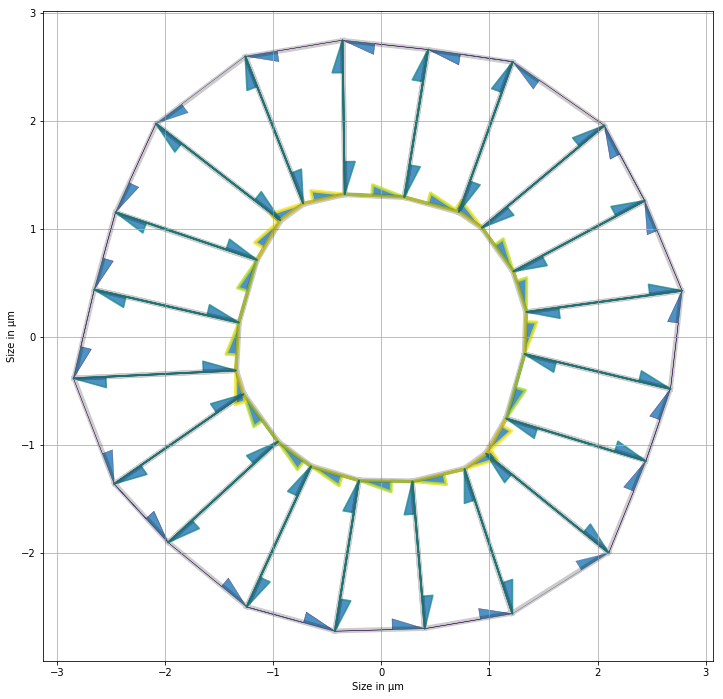

In [15]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas.x[:organo3.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = res_2_cst_areas.x[4*organo3.Nf:5*organo3.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = opt_mat_2_cst_organo.settings['lumen_volume'] + res_2_cst_areas.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo3)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo3, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo3.edge_df.line_tension[:3*organo3.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo3.Nf]))))

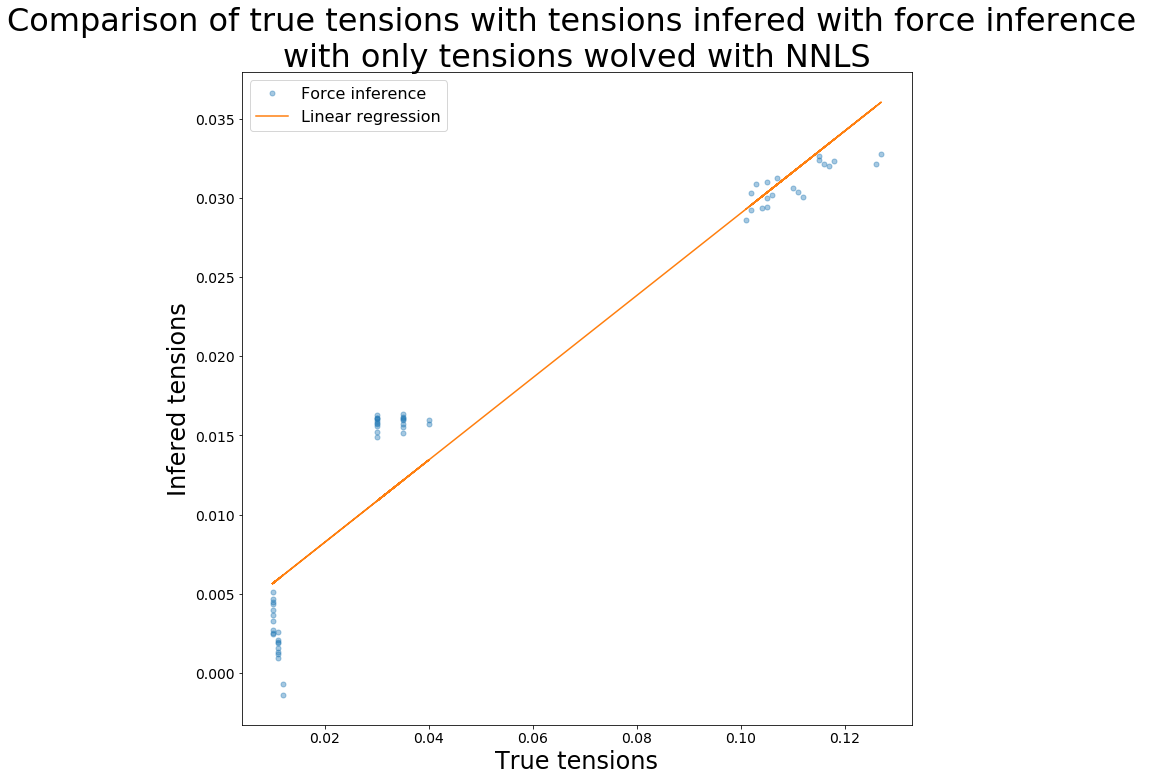

R value : 0.9561682302494516 
Standard error : 0.0029649529543035852


In [16]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  res_2_cst_areas.x[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

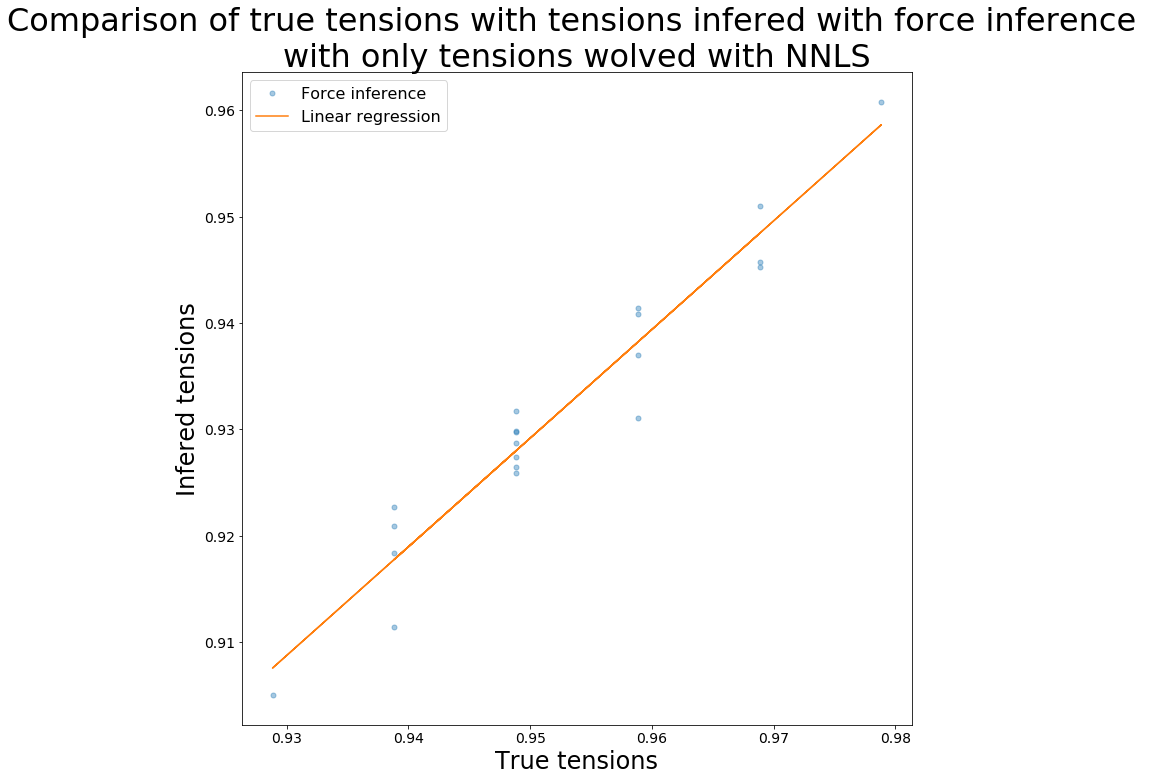

R value : 0.9689443940490942 
Standard error : 0.0016095766456029853


In [17]:
rendering_results(organo3, organo3.face_df.eval('prefered_area'),
                  res_2_cst_areas.x[4*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

# half polarized

In [18]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.01,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

Reseting datasets values with new specs


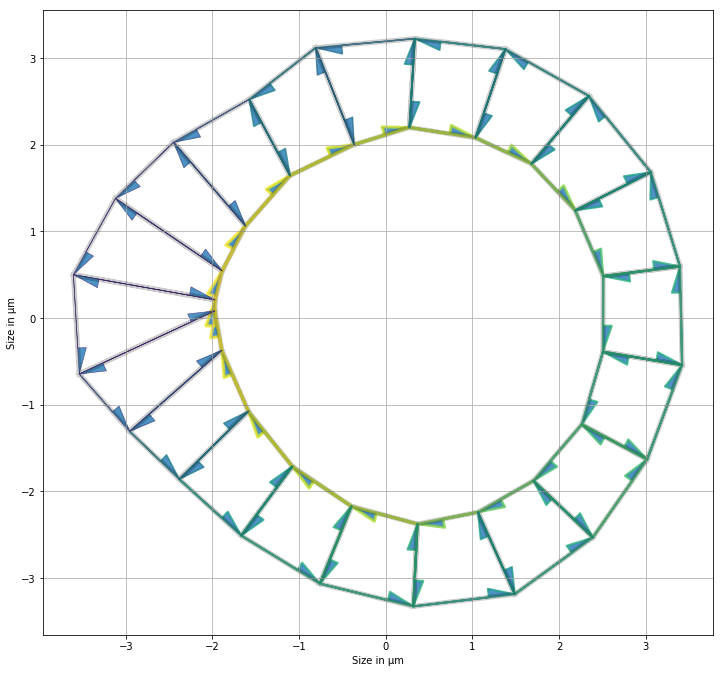

In [19]:
nf, r_in, r_out = (20, 1, 1.5)
seed = 1
organo3 = create_organo(nf, r_in, r_out)

organo3.edge_df.loc[organo3.apical_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.060, 0.065, 0.070,
    0.072, 0.074, 0.076, 0.078, 0.078,
    0.079, 0.078, 0.076, 0.074, 0.072,
    0.070, 0.068, 0.065, 0.057, 0.052
])

organo3.edge_df.loc[organo3.basal_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.045, 0.050,
    0.050, 0.045, 0.035, 0.020, 0.010,
    0.011, 0.015, 0.020, 0.035, 0.030,
    0.040, 0.040, 0.042, 0.045, 0.050
])

organo3.edge_df.loc[organo3.lateral_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051,
    0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051, 0.050
])

organo3.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo3.face_df.area

geom.update_all(organo3)
Solver.find_energy_min(organo3, geom, model)
print_tensions(organo3, organo3)

In [20]:
real_data = np.concatenate((organo3.edge_df.line_tension[:3*organo3.Nf],
                            organo3.face_df.prefered_area - organo3.face_df.area,
                            [organo3.settings['lumen_prefered_vol']-
                             organo3.settings['lumen_volume']]))
print(organo3.edge_df.line_tension, '\n',
      organo3.face_df.prefered_area - organo3.face_df.area)

edge
0     0.150
1     0.165
2     0.180
3     0.195
4     0.210
5     0.216
6     0.222
7     0.228
8     0.234
9     0.234
10    0.237
11    0.234
12    0.228
13    0.222
14    0.216
15    0.210
16    0.204
17    0.195
18    0.171
19    0.156
20    0.150
21    0.165
22    0.150
23    0.135
24    0.150
25    0.150
26    0.135
27    0.105
28    0.060
29    0.030
      ...  
50    0.030
51    0.042
52    0.063
53    0.108
54    0.087
55    0.123
56    0.117
57    0.129
58    0.138
59    0.153
60    0.165
61    0.150
62    0.132
63    0.153
64    0.153
65    0.138
66    0.102
67    0.057
68    0.027
69    0.030
70    0.042
71    0.063
72    0.108
73    0.087
74    0.123
75    0.117
76    0.129
77    0.138
78    0.153
79    0.150
Name: line_tension, Length: 80, dtype: float64 
 face
0     0.159524
1     0.171626
2     0.153793
3     0.151092
4     0.166324
5     0.158801
6     0.133252
7     0.091433
8     0.053653
9     0.038093
10    0.042930
11    0.057900
12    0.083871
13    0.112560

On détermine les paramètres dans l'organoïde régulier correspondant

In [21]:
params_in_sym_mesh = np.linalg.solve(*get_sim_mat(nf, r_in, r_out))

On obtient les coefficients exprimant le rapport entre la hauteur de chaque cellule dans l'organoïde régulier et dans l'organoïde à inférer

In [22]:
organo3.get_extra_indices()
non_lateral_edges = np.concatenate((organo3.apical_edges,
                                    organo3.basal_edges))
sym_height = (r_out-r_in)*np.cos(np.pi/organo3.Nf)
polar_coefs = np.ones(organo3.Nf)
for cell in range(organo3.Nf):
    parrallel_edges = (organo3.edge_df.loc[non_lateral_edges, ('srce', 'trgt')]
                       [organo3.edge_df.face == cell]).values
    apical_middle = organo3.vert_df.loc[parrallel_edges[0, :], ('x', 'y')].sum()/2
    basal_middle = organo3.vert_df.loc[parrallel_edges[1, :], ('x', 'y')].sum()/2
    cell_height = np.linalg.norm(apical_middle - basal_middle)
    polar_coefs[cell] = cell_height/sym_height
polar_coefs

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([1.7804046 , 1.80896929, 1.97237282, 1.95819428, 1.91354156,
       1.9663041 , 2.13011039, 2.5651894 , 3.14946586, 3.26946007,
       3.11867021, 2.77275355, 2.28573431, 2.22316687, 2.20358018,
       2.11542926, 2.09600265, 1.99059355, 1.86836   , 1.82366071])

En utilisant les paramètres obtenus dans les cellules précédentes, on pose le problème d'inférence de forces

[0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355]
[0.03891735 0.03954174 0.04311353 0.04280361 0.04182756 0.04298088
 0.04656147 0.05607174 0.06884327 0.07146619 0.06817012 0.06060883
 0.04996321 0.04859557 0.04816743 0.04624056 0.04581592 0.04351182
 0.04083995 0.03986288]
Apical tensions:  [0.03894094 0.03677201 0.04303726 0.04552289 0.04229053 0.04547381
 0.04871661 0.05750779 0.07143581 0.08317035 0.0793715  0.07019326
 0.06080949 0.05090482 0.05868069 0.04562156 0.05026239 0.04461753
 0.04186367 0.03778853] 
Basal tensions:  [0.03329888 0.03209668 0.032999   0.03082913 0.02892727 0.03007362
 0.029

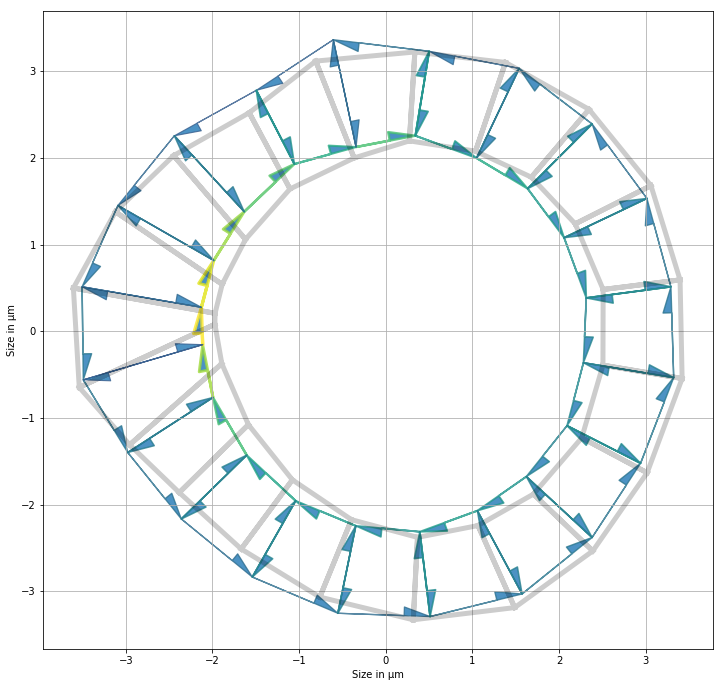

In [23]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
               (organo3.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo3.Nf
print(avg_cste)
avg_cste = np.multiply(np.array(avg_cste), polar_coefs)
print(avg_cste)
for i in range(organo3.Nf):
    i_cell_line = np.zeros(4*organo3.Nf+1)
    index = np.squeeze(np.argwhere(organo3.edge_df.face.values == i)[:-1])
    i_cell_line[index] = 1
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
mat_eq_cst, residuals = nnls(matrix, constant)
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 mat_eq_cst[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + mat_eq_cst[3*organo3.Nf:
                                                                                          4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = organo3_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', mat_eq_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_eq_cst),
      '\nDistance from th org to exp org: ', np.sum(np.linalg.norm(_distance(organo3_eq_cst, organo3), axis=1)),
      '\nNNLS residuals: ', residuals)

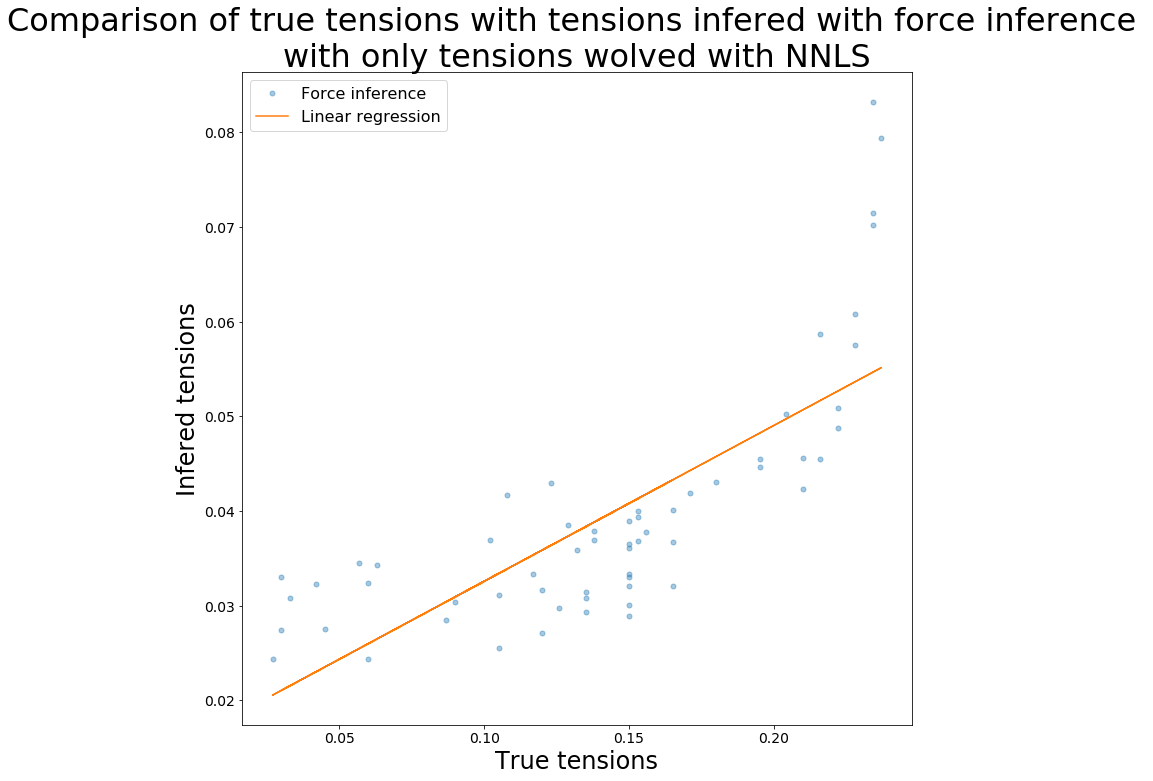

R value : 0.7623440660592736 
Standard error : 0.007111037453263448


In [24]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_eq_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

#### On utilise le résultat de l'inférence de forces comme point initial pour lancer la minimisation de la distance

In [25]:
start_copy = time.time()
iprint_file = "../../assets/dist_at_each_f_ev/11_03_eq_t_per_cell_areas_opt.txt"
to_opt_organo = organo3.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_eq_cst[:3*organo3.Nf]),
                                                   to_opt_organo.face_df.area + mat_eq_cst[3*organo3.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_eq_cst[-1]]))
res_2_cst_areas_copy = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    energy_min_opt=energy_opt,
                                    COPY_OR_SYM='copy',                                    
                                    **lm_opt)
end_copy = time.time()
print('Execution time: ', start_copy - end_copy)

7.789122840922073 [0.22073539 0.21393268 0.21338396 0.16688329 0.06571747 0.08687089
 0.24499146 0.35100211 0.40025486 0.27392531 0.1716366  0.2911632
 0.31831377 0.29178964 0.12830658 0.0928249  0.07763812 0.13449715
 0.20028108 0.21203756 0.09329621 0.12963542 0.15194763 0.17563481
 0.19495031 0.27716489 0.34567285 0.30321745 0.09026354 0.09747601
 0.10059208 0.07715672 0.22702022 0.26967757 0.31652474 0.16364074
 0.17031666 0.1690181  0.15113014 0.12860071 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.789122840270124 [0.22073539 0.21393268 0.21338396 0.16688329 0.06571748 0.08687089
 0.24499146 0.35100211 0.40025486 0.27392531 0.1716366  0.2911632
 0.31831377 0.29178964 0.12830658 0.0928249  0.07763812 0.13449715
 0.20028108 0.21203756 0.09329621 0.12963542 0.15194763 0.17563481
 0.19495031 0.27716489 0.34567285 0.30321745 0.09026354 0.09747601
 0.10059208 0.07715673 0.22702022 0.26967757 0.31652474 0.16364074
 0.17031666 0.1690181  0.15113014 0.12860071 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.789122765443235 [0.22073539 0.21393268 0.21338396 0.16688329 0.06571747 0.08687089
 0.24499146 0.3510021  0.40025486 0.2739253  0.17163659 0.2911632
 0.31831376 0.29178963 0.12830658 0.0928249  0.07763812 0.13449715
 0.20028108 0.21203756 0.09329621 0.12963542 0.15194763 0.17563481
 0.19495031 0.27716489 0.34567285 0.30321744 0.09026354 0.097476
 0.10059208 0.07715672 0.22702022 0.26967757 0.31652474 0.16364074
 0.17031666 0.1690181  0.15113014 0.12860071 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

7.789122845915311 [0.22073539 0.21393268 0.21338396 0.16688329 0.06571747 0.08687089
 0.24499146 0.35100211 0.40025486 0.27392531 0.1716366  0.2911632
 0.31831377 0.29178964 0.12830658 0.0928249  0.07763812 0.13449715
 0.20028109 0.21203756 0.09329621 0.12963542 0.15194763 0.17563481
 0.19495031 0.27716489 0.34567285 0.30321745 0.09026354 0.09747601
 0.10059208 0.07715672 0.22702022 0.26967757 0.31652474 0.16364074
 0.17031666 0.1690181  0.15113014 0.12860071 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.789122842207984 [0.22073539 0.21393268 0.21338396 0.16688329 0.06571747 0.08687089
 0.24499146 0.35100211 0.40025486 0.27392531 0.1716366  0.2911632
 0.31831377 0.29178964 0.12830658 0.0928249  0.07763812 0.13449715
 0.20028108 0.21203756 0.09329621 0.12963542 0.15194764 0.17563481
 0.19495031 0.27716489 0.34567285 0.30321745 0.09026354 0.09747601
 0.10059208 0.07715673 0.22702022 0.26967757 0.31652474 0.16364074
 0.17031666 0.1690181  0.15113014 0.12860071 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.78912283680526 [0.22073539 0.21393268 0.21338396 0.16688329 0.06571747 0.08687089
 0.24499146 0.35100211 0.40025486 0.27392531 0.1716366  0.2911632
 0.31831377 0.29178964 0.12830658 0.0928249  0.07763812 0.13449715
 0.20028108 0.21203756 0.09329621 0.12963542 0.15194763 0.17563481
 0.19495031 0.27716489 0.34567285 0.30321745 0.09026354 0.09747601
 0.10059208 0.07715672 0.22702022 0.26967757 0.31652474 0.16364074
 0.17031666 0.1690181  0.15113014 0.12860071 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

7.789122844404222 [0.22073539 0.21393268 0.21338396 0.16688329 0.06571747 0.08687089
 0.24499146 0.35100211 0.40025487 0.27392531 0.1716366  0.2911632
 0.31831377 0.29178963 0.12830658 0.0928249  0.07763812 0.13449715
 0.20028108 0.21203756 0.09329621 0.12963542 0.15194763 0.17563481
 0.19495031 0.27716489 0.34567285 0.30321745 0.09026354 0.09747601
 0.10059208 0.07715672 0.22702022 0.26967757 0.31652473 0.16364074
 0.17031666 0.1690181  0.15113014 0.12860071 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.789122845202121 [0.2207354  0.21393268 0.21338396 0.16688329 0.06571747 0.08687089
 0.24499146 0.35100211 0.40025486 0.27392531 0.1716366  0.2911632
 0.31831377 0.29178964 0.12830658 0.0928249  0.07763812 0.13449715
 0.20028108 0.21203756 0.09329621 0.12963542 0.15194763 0.17563481
 0.19495031 0.27716489 0.34567285 0.30321745 0.09026354 0.09747601
 0.10059208 0.07715673 0.22702022 0.26967757 0.31652474 0.16364074
 0.17031666 0.1690181  0.15113014 0.12860071 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.789122844944942 [0.22073539 0.21393268 0.21338396 0.16688329 0.06571748 0.0868709
 0.24499146 0.35100211 0.40025486 0.27392531 0.1716366  0.2911632
 0.31831377 0.29178964 0.12830658 0.0928249  0.07763812 0.13449715
 0.20028109 0.21203756 0.09329621 0.12963542 0.15194763 0.17563481
 0.19495031 0.27716488 0.34567285 0.30321745 0.09026354 0.09747601
 0.10059208 0.07715672 0.22702022 0.26967757 0.31652474 0.16364074
 0.17031666 0.1690181  0.15113014 0.12860071 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

7.78912286673509 [0.22073539 0.21393268 0.21338396 0.16688329 0.06571747 0.08687089
 0.24499146 0.35100211 0.40025487 0.27392531 0.1716366  0.29116321
 0.31831377 0.29178964 0.12830658 0.0928249  0.07763812 0.13449715
 0.20028109 0.21203756 0.09329621 0.12963542 0.15194763 0.17563481
 0.19495031 0.27716489 0.34567285 0.30321745 0.09026354 0.09747601
 0.10059208 0.07715672 0.22702022 0.26967757 0.31652474 0.16364074
 0.17031666 0.1690181  0.15113014 0.12860071 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.789122843638466 [0.22073539 0.21393268 0.21338396 0.16688329 0.06571747 0.08687089
 0.24499146 0.35100211 0.40025487 0.27392531 0.1716366  0.2911632
 0.31831377 0.29178964 0.12830658 0.0928249  0.07763812 0.13449715
 0.20028109 0.21203756 0.09329621 0.12963542 0.15194763 0.17563481
 0.19495031 0.27716489 0.34567285 0.30321745 0.09026354 0.09747601
 0.10059208 0.07715672 0.22702022 0.26967757 0.31652474 0.16364074
 0.17031666 0.16901811 0.15113014 0.12860071 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.789122840922073 [0.22073539 0.21393268 0.21338396 0.16688329 0.06571747 0.08687089
 0.24499146 0.35100211 0.40025486 0.27392531 0.1716366  0.2911632
 0.31831377 0.29178964 0.12830658 0.0928249  0.07763812 0.13449715
 0.20028108 0.21203756 0.09329621 0.12963542 0.15194763 0.17563481
 0.19495031 0.27716489 0.34567285 0.30321745 0.09026354 0.09747601
 0.10059208 0.07715672 0.22702022 0.26967757 0.31652474 0.16364074
 0.17031666 0.1690181  0.15113014 0.12860071 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.789122840922073 [0.22073539 0.21393268 0.21338396 0.16688329 0.06571747 0.08687089
 0.24499146 0.35100211 0.40025486 0.27392531 0.1716366  0.2911632
 0.31831377 0.29178964 0.12830658 0.0928249  0.07763812 0.13449715
 0.20028108 0.21203756 0.09329621 0.12963542 0.15194763 0.17563481
 0.19495031 0.27716489 0.34567285 0.30321745 0.09026354 0.09747601
 0.10059208 0.07715672 0.22702022 0.26967757 0.31652474 0.16364074
 0.17031666 0.1690181  0.15113014 0.12860071 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.789122840922073 [0.22073539 0.21393268 0.21338396 0.16688329 0.06571747 0.08687089
 0.24499146 0.35100211 0.40025486 0.27392531 0.1716366  0.2911632
 0.31831377 0.29178964 0.12830658 0.0928249  0.07763812 0.13449715
 0.20028108 0.21203756 0.09329621 0.12963542 0.15194763 0.17563481
 0.19495031 0.27716489 0.34567285 0.30321745 0.09026354 0.09747601
 0.10059208 0.07715672 0.22702022 0.26967757 0.31652474 0.16364074
 0.17031666 0.1690181  0.15113014 0.12860071 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.789122775329293 [0.22073539 0.21393268 0.21338396 0.16688329 0.06571747 0.08687089
 0.24499146 0.35100211 0.40025486 0.27392531 0.1716366  0.2911632
 0.31831376 0.29178963 0.12830658 0.0928249  0.07763812 0.13449715
 0.20028108 0.21203756 0.09329621 0.12963542 0.15194763 0.17563481
 0.19495031 0.27716489 0.34567285 0.30321745 0.09026354 0.097476
 0.10059208 0.07715673 0.22702022 0.26967757 0.31652473 0.16364074
 0.17031666 0.1690181  0.15113014 0.12860071 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

7.789122693902227 [0.22073539 0.21393268 0.21338397 0.16688328 0.06571746 0.0868709
 0.24499146 0.35100207 0.40025482 0.27392529 0.1716365  0.29116321
 0.31831374 0.29178964 0.1283066  0.09282491 0.07763813 0.13449715
 0.20028108 0.21203756 0.09329622 0.12963541 0.15194763 0.17563482
 0.19495034 0.2771649  0.34567284 0.30321742 0.09026355 0.09747601
 0.10059213 0.07715671 0.22702019 0.26967755 0.31652475 0.16364074
 0.17031668 0.16901809 0.15113014 0.12860071 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.789122170562854 [0.22073537 0.21393265 0.21338395 0.16688328 0.06571748 0.08687088
 0.24499143 0.35100204 0.4002548  0.2739253  0.17163658 0.29116319
 0.31831371 0.29178958 0.12830657 0.09282489 0.07763813 0.13449713
 0.20028107 0.21203754 0.09329622 0.1296354  0.15194761 0.1756348
 0.19495032 0.2771649  0.34567283 0.30321741 0.09026357 0.09747597
 0.10059205 0.07715675 0.22702021 0.26967752 0.3165247  0.16364074
 0.17031665 0.16901809 0.15113014 0.1286007  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.789122556855241 [0.22073539 0.21393267 0.21338396 0.16688329 0.06571748 0.08687089
 0.24499145 0.35100208 0.40025484 0.2739253  0.1716366  0.2911632
 0.31831375 0.29178961 0.12830658 0.0928249  0.07763812 0.13449714
 0.20028108 0.21203755 0.09329621 0.12963541 0.15194762 0.1756348
 0.19495031 0.27716489 0.34567284 0.30321743 0.09026355 0.09747599
 0.10059207 0.07715674 0.22702022 0.26967755 0.31652472 0.16364074
 0.17031665 0.1690181  0.15113014 0.1286007  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

2.762153912225747 [0.04033955 0.04294743 0.03418847 0.05955955 0.08146448 0.12709367
 0.11283018 0.04757488 0.09315528 0.12623885 0.11673745 0.12594674
 0.01457412 0.08401989 0.04301054 0.11499671 0.020557   0.0523984
 0.0514449  0.03150625 0.01714721 0.0213721  0.06160543 0.08212889
 0.02142061 0.03232791 0.12894515 0.15075947 0.04442122 0.07586254
 0.05485391 0.18737357 0.1096679  0.03698851 0.17921152 0.01153651
 0.03695753 0.03767533 0.0194159  0.03189837 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

2.7621538733550692 [0.04033955 0.04294743 0.03418847 0.05955955 0.08146448 0.12709367
 0.11283018 0.04757488 0.09315528 0.12623884 0.11673745 0.12594674
 0.01457412 0.08401989 0.04301054 0.11499671 0.020557   0.0523984
 0.0514449  0.03150625 0.01714721 0.0213721  0.06160543 0.08212889
 0.02142061 0.03232791 0.12894515 0.15075947 0.04442121 0.07586252
 0.05485391 0.18737357 0.1096679  0.03698851 0.17921152 0.01153651
 0.03695753 0.03767533 0.0194159  0.03189837 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.762153921151981 [0.04033955 0.04294743 0.03418847 0.05955955 0.08146448 0.12709367
 0.11283018 0.04757488 0.09315528 0.12623885 0.11673745 0.12594674
 0.01457412 0.08401989 0.04301055 0.11499671 0.020557   0.0523984
 0.0514449  0.03150625 0.01714721 0.0213721  0.06160543 0.08212889
 0.02142061 0.03232791 0.12894515 0.15075947 0.04442122 0.07586254
 0.05485391 0.18737357 0.1096679  0.03698851 0.17921152 0.0115365
 0.03695753 0.03767533 0.0194159  0.03189837 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

2.762153914501543 [0.04033955 0.04294743 0.03418847 0.05955955 0.08146448 0.12709367
 0.11283018 0.04757488 0.09315528 0.12623885 0.11673745 0.12594674
 0.01457412 0.08401989 0.04301054 0.11499671 0.020557   0.0523984
 0.0514449  0.03150625 0.01714721 0.0213721  0.06160543 0.08212889
 0.02142061 0.03232791 0.12894515 0.15075947 0.04442122 0.07586254
 0.05485391 0.18737357 0.1096679  0.03698851 0.17921152 0.01153651
 0.03695753 0.03767533 0.0194159  0.03189837 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

2.7621539031769116 [0.04033955 0.04294743 0.03418847 0.05955955 0.08146448 0.12709367
 0.11283018 0.04757488 0.09315528 0.12623885 0.11673745 0.12594674
 0.01457412 0.08401989 0.04301054 0.11499671 0.020557   0.0523984
 0.0514449  0.03150625 0.01714721 0.0213721  0.06160543 0.08212889
 0.02142061 0.03232791 0.12894515 0.15075947 0.04442122 0.07586254
 0.05485391 0.18737357 0.1096679  0.03698851 0.17921152 0.01153651
 0.03695753 0.03767533 0.0194159  0.03189837 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.7621539064532294 [0.04033955 0.04294743 0.03418847 0.05955955 0.08146448 0.12709367
 0.11283018 0.04757488 0.09315528 0.12623885 0.11673745 0.12594674
 0.01457412 0.08401989 0.04301054 0.11499671 0.020557   0.0523984
 0.0514449  0.03150625 0.01714721 0.0213721  0.06160543 0.08212889
 0.02142061 0.03232791 0.12894515 0.15075947 0.04442122 0.07586254
 0.05485391 0.18737357 0.1096679  0.03698851 0.17921152 0.01153651
 0.03695753 0.03767533 0.0194159  0.03189837 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.7621539110370135 [0.04033955 0.04294743 0.03418847 0.05955955 0.08146448 0.12709367
 0.11283018 0.04757488 0.09315528 0.12623885 0.11673745 0.12594674
 0.01457412 0.08401989 0.04301054 0.11499671 0.020557   0.0523984
 0.0514449  0.03150625 0.01714721 0.0213721  0.06160543 0.08212889
 0.02142061 0.03232791 0.12894515 0.15075947 0.04442122 0.07586254
 0.05485391 0.18737357 0.1096679  0.03698851 0.17921152 0.01153651
 0.03695753 0.03767533 0.0194159  0.03189836 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.762153929619223 [0.04033955 0.04294743 0.03418847 0.05955955 0.08146448 0.12709367
 0.11283018 0.04757488 0.09315528 0.12623885 0.11673745 0.12594674
 0.01457412 0.08401989 0.04301054 0.11499671 0.020557   0.0523984
 0.0514449  0.03150625 0.01714721 0.0213721  0.06160543 0.0821289
 0.02142061 0.03232791 0.12894515 0.15075947 0.04442122 0.07586254
 0.05485391 0.18737357 0.1096679  0.03698851 0.17921152 0.01153651
 0.03695753 0.03767533 0.0194159  0.03189837 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

2.7621539100615564 [0.04033955 0.04294743 0.03418847 0.05955955 0.08146448 0.12709367
 0.11283018 0.04757488 0.09315528 0.12623885 0.11673745 0.12594674
 0.01457412 0.08401989 0.04301054 0.11499671 0.020557   0.0523984
 0.0514449  0.03150625 0.01714721 0.0213721  0.06160543 0.08212889
 0.02142061 0.03232791 0.12894515 0.15075947 0.04442122 0.07586254
 0.05485391 0.18737357 0.1096679  0.03698851 0.17921152 0.01153651
 0.03695753 0.03767533 0.0194159  0.03189837 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.762153912648067 [0.04033955 0.04294743 0.03418847 0.05955955 0.08146448 0.12709367
 0.11283018 0.04757488 0.09315528 0.12623885 0.11673745 0.12594674
 0.01457412 0.08401989 0.04301054 0.11499671 0.020557   0.0523984
 0.0514449  0.03150625 0.01714721 0.0213721  0.06160543 0.08212889
 0.02142061 0.03232791 0.12894515 0.15075947 0.04442122 0.07586254
 0.05485391 0.18737357 0.1096679  0.03698851 0.17921152 0.0115365
 0.03695753 0.03767533 0.0194159  0.03189837 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

2.7621539108060444 [0.04033955 0.04294743 0.03418847 0.05955955 0.08146448 0.12709367
 0.11283018 0.04757488 0.09315528 0.12623885 0.11673745 0.12594674
 0.01457412 0.08401989 0.04301054 0.11499671 0.020557   0.0523984
 0.0514449  0.03150625 0.01714721 0.0213721  0.06160543 0.08212889
 0.02142061 0.03232791 0.12894515 0.15075947 0.04442122 0.07586254
 0.05485391 0.18737357 0.1096679  0.03698851 0.17921152 0.01153651
 0.03695753 0.03767533 0.0194159  0.03189837 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.7621539108060444 [0.04033955 0.04294743 0.03418847 0.05955955 0.08146448 0.12709367
 0.11283018 0.04757488 0.09315528 0.12623885 0.11673745 0.12594674
 0.01457412 0.08401989 0.04301054 0.11499671 0.020557   0.0523984
 0.0514449  0.03150625 0.01714721 0.0213721  0.06160543 0.08212889
 0.02142061 0.03232791 0.12894515 0.15075947 0.04442122 0.07586254
 0.05485391 0.18737357 0.1096679  0.03698851 0.17921152 0.01153651
 0.03695753 0.03767533 0.0194159  0.03189837 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.7621539108060444 [0.04033955 0.04294743 0.03418847 0.05955955 0.08146448 0.12709367
 0.11283018 0.04757488 0.09315528 0.12623885 0.11673745 0.12594674
 0.01457412 0.08401989 0.04301054 0.11499671 0.020557   0.0523984
 0.0514449  0.03150625 0.01714721 0.0213721  0.06160543 0.08212889
 0.02142061 0.03232791 0.12894515 0.15075947 0.04442122 0.07586254
 0.05485391 0.18737357 0.1096679  0.03698851 0.17921152 0.01153651
 0.03695753 0.03767533 0.0194159  0.03189837 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.7621538896499063 [0.04033955 0.04294743 0.03418847 0.05955955 0.08146448 0.12709367
 0.11283018 0.04757488 0.09315528 0.12623885 0.11673745 0.12594674
 0.01457412 0.08401989 0.04301054 0.11499671 0.020557   0.0523984
 0.0514449  0.03150624 0.01714721 0.02137209 0.06160543 0.08212889
 0.02142061 0.03232791 0.12894515 0.15075947 0.04442122 0.07586254
 0.05485391 0.18737357 0.1096679  0.03698851 0.17921152 0.01153651
 0.03695753 0.03767533 0.0194159  0.03189836 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.7621540189064184 [0.04033956 0.04294744 0.03418847 0.05955955 0.08146448 0.12709368
 0.11283018 0.04757489 0.09315528 0.12623887 0.11673747 0.12594675
 0.01457411 0.0840199  0.04301054 0.11499672 0.02055701 0.0523984
 0.05144491 0.03150625 0.01714721 0.0213721  0.06160543 0.08212889
 0.0214206  0.0323279  0.12894515 0.15075948 0.04442123 0.07586254
 0.0548539  0.18737357 0.10966789 0.03698852 0.17921153 0.01153649
 0.03695753 0.03767533 0.0194159  0.03189836 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.7621540458234692 [0.04033956 0.04294744 0.03418847 0.05955955 0.08146448 0.12709368
 0.11283018 0.04757489 0.09315529 0.12623888 0.11673747 0.12594675
 0.01457411 0.0840199  0.04301054 0.11499673 0.02055701 0.0523984
 0.05144491 0.03150625 0.01714721 0.0213721  0.06160543 0.08212889
 0.0214206  0.0323279  0.12894516 0.15075948 0.04442123 0.07586254
 0.0548539  0.18737357 0.10966788 0.03698853 0.17921153 0.01153648
 0.03695753 0.03767533 0.0194159  0.03189836 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

2.762153900689962 [0.04033955 0.04294743 0.03418847 0.05955955 0.08146448 0.12709367
 0.11283018 0.04757488 0.09315528 0.12623885 0.11673745 0.12594674
 0.01457412 0.08401989 0.04301054 0.11499671 0.020557   0.0523984
 0.0514449  0.03150625 0.0171472  0.0213721  0.06160543 0.08212889
 0.02142061 0.03232791 0.12894515 0.15075947 0.04442122 0.07586254
 0.05485391 0.18737357 0.1096679  0.03698851 0.17921152 0.01153651
 0.03695753 0.03767533 0.0194159  0.03189837 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.9284576749872702 [0.02365172 0.06146777 0.02027361 0.01608254 0.02715593 0.04999413
 0.04226229 0.04761271 0.10138328 0.05648526 0.04129222 0.03406526
 0.07838078 0.03440982 0.01380792 0.06875253 0.02025215 0.0171603
 0.04953269 0.05710573 0.08163963 0.03461695 0.00976239 0.01295786
 0.04088673 0.04020561 0.03145815 0.13111299 0.14463987 0.04245597
 0.04583498 0.0363457  0.14233481 0.04325879 0.03172877 0.03392691
 0.05205945 0.05526587 0.01667062 0.04016698 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9284576665788107 [0.02365173 0.06146777 0.02027361 0.01608254 0.02715593 0.04999413
 0.04226229 0.04761271 0.10138327 0.05648525 0.04129222 0.03406526
 0.07838078 0.03440982 0.01380792 0.06875253 0.02025215 0.0171603
 0.04953269 0.05710573 0.08163963 0.03461696 0.00976239 0.01295786
 0.04088673 0.04020561 0.03145815 0.13111298 0.14463986 0.04245597
 0.04583498 0.0363457  0.14233481 0.04325879 0.03172877 0.03392691
 0.05205945 0.05526587 0.01667062 0.04016698 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9284576799434245 [0.02365172 0.06146777 0.02027361 0.01608254 0.02715593 0.04999413
 0.04226229 0.04761271 0.10138328 0.05648526 0.04129222 0.03406526
 0.07838078 0.03440982 0.01380792 0.06875253 0.02025215 0.0171603
 0.04953269 0.05710573 0.08163963 0.03461696 0.00976239 0.01295786
 0.04088673 0.04020561 0.03145815 0.13111299 0.14463987 0.04245597
 0.04583498 0.0363457  0.14233481 0.04325879 0.03172878 0.03392691
 0.05205945 0.05526587 0.01667062 0.04016698 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9284576850843593 [0.02365172 0.06146777 0.02027361 0.01608254 0.02715593 0.04999413
 0.04226229 0.04761271 0.10138328 0.05648526 0.04129222 0.03406526
 0.07838078 0.03440982 0.01380792 0.06875253 0.02025215 0.0171603
 0.04953269 0.05710573 0.08163963 0.03461696 0.00976239 0.01295786
 0.04088673 0.04020561 0.03145815 0.13111299 0.14463987 0.04245597
 0.04583498 0.0363457  0.14233481 0.04325879 0.03172877 0.03392691
 0.05205945 0.05526587 0.01667062 0.04016698 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9284576861720257 [0.02365172 0.06146777 0.02027361 0.01608254 0.02715593 0.04999413
 0.04226229 0.04761271 0.10138328 0.05648526 0.04129222 0.03406526
 0.07838078 0.03440982 0.01380792 0.06875253 0.02025215 0.0171603
 0.04953269 0.05710573 0.08163963 0.03461696 0.00976239 0.01295786
 0.04088673 0.04020561 0.03145815 0.13111299 0.14463987 0.04245597
 0.04583498 0.0363457  0.14233481 0.04325879 0.03172877 0.03392691
 0.05205945 0.05526587 0.01667062 0.04016698 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9284576918632106 [0.02365172 0.06146777 0.02027361 0.01608254 0.02715593 0.04999413
 0.04226229 0.04761271 0.10138328 0.05648526 0.04129222 0.03406526
 0.07838079 0.03440982 0.01380792 0.06875253 0.02025215 0.0171603
 0.04953269 0.05710573 0.08163963 0.03461696 0.00976239 0.01295786
 0.04088673 0.04020561 0.03145815 0.13111299 0.14463987 0.04245597
 0.04583498 0.03634569 0.14233482 0.04325879 0.03172877 0.03392691
 0.05205945 0.05526587 0.01667062 0.04016698 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9284576830514202 [0.02365172 0.06146777 0.02027361 0.01608254 0.02715593 0.04999413
 0.04226229 0.04761271 0.10138328 0.05648526 0.04129222 0.03406526
 0.07838078 0.03440982 0.01380792 0.06875253 0.02025215 0.0171603
 0.04953269 0.05710573 0.08163963 0.03461696 0.00976239 0.01295786
 0.04088673 0.04020561 0.03145815 0.13111299 0.14463987 0.04245597
 0.04583498 0.0363457  0.14233481 0.04325879 0.03172877 0.03392691
 0.05205945 0.05526587 0.01667062 0.04016697 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.928457680288345 [0.02365172 0.06146777 0.02027361 0.01608254 0.02715594 0.04999412
 0.04226229 0.04761271 0.10138328 0.05648526 0.04129222 0.03406526
 0.07838078 0.03440982 0.01380792 0.06875253 0.02025215 0.0171603
 0.04953269 0.05710573 0.08163963 0.03461696 0.00976239 0.01295786
 0.04088673 0.04020561 0.03145815 0.13111299 0.14463987 0.04245597
 0.04583498 0.0363457  0.14233481 0.04325879 0.03172877 0.03392691
 0.05205945 0.05526587 0.01667062 0.04016698 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.9284576805556077 [0.02365172 0.06146777 0.02027361 0.01608254 0.02715593 0.04999413
 0.04226229 0.04761271 0.10138328 0.05648526 0.04129222 0.03406526
 0.07838078 0.03440982 0.01380792 0.06875253 0.02025215 0.0171603
 0.04953269 0.05710573 0.08163963 0.03461696 0.00976239 0.01295786
 0.04088673 0.04020561 0.03145815 0.13111299 0.14463987 0.04245597
 0.04583498 0.03634569 0.14233482 0.04325879 0.03172877 0.03392691
 0.05205945 0.05526587 0.01667062 0.04016698 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.928457681100217 [0.02365172 0.06146777 0.02027361 0.01608254 0.02715593 0.04999413
 0.04226229 0.04761271 0.10138328 0.05648526 0.04129222 0.03406526
 0.07838078 0.03440982 0.01380792 0.06875253 0.02025215 0.0171603
 0.04953269 0.05710573 0.08163963 0.03461696 0.00976239 0.01295786
 0.04088673 0.04020561 0.03145815 0.13111299 0.14463987 0.04245597
 0.04583498 0.0363457  0.14233481 0.04325879 0.03172877 0.03392691
 0.05205945 0.05526587 0.01667062 0.04016698 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.9284576831954512 [0.02365172 0.06146777 0.02027361 0.01608254 0.02715593 0.04999413
 0.04226229 0.04761271 0.10138328 0.05648526 0.04129222 0.03406526
 0.07838078 0.03440982 0.01380792 0.06875253 0.02025215 0.0171603
 0.04953269 0.05710573 0.08163963 0.03461696 0.00976239 0.01295786
 0.04088673 0.04020561 0.03145815 0.13111299 0.14463987 0.04245597
 0.04583498 0.0363457  0.14233481 0.04325879 0.03172877 0.03392691
 0.05205945 0.05526587 0.01667062 0.04016698 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9284576831954512 [0.02365172 0.06146777 0.02027361 0.01608254 0.02715593 0.04999413
 0.04226229 0.04761271 0.10138328 0.05648526 0.04129222 0.03406526
 0.07838078 0.03440982 0.01380792 0.06875253 0.02025215 0.0171603
 0.04953269 0.05710573 0.08163963 0.03461696 0.00976239 0.01295786
 0.04088673 0.04020561 0.03145815 0.13111299 0.14463987 0.04245597
 0.04583498 0.0363457  0.14233481 0.04325879 0.03172877 0.03392691
 0.05205945 0.05526587 0.01667062 0.04016698 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9284576831954512 [0.02365172 0.06146777 0.02027361 0.01608254 0.02715593 0.04999413
 0.04226229 0.04761271 0.10138328 0.05648526 0.04129222 0.03406526
 0.07838078 0.03440982 0.01380792 0.06875253 0.02025215 0.0171603
 0.04953269 0.05710573 0.08163963 0.03461696 0.00976239 0.01295786
 0.04088673 0.04020561 0.03145815 0.13111299 0.14463987 0.04245597
 0.04583498 0.0363457  0.14233481 0.04325879 0.03172877 0.03392691
 0.05205945 0.05526587 0.01667062 0.04016698 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9284576841773018 [0.02365172 0.06146777 0.02027361 0.01608254 0.02715593 0.04999413
 0.04226229 0.04761271 0.10138328 0.05648526 0.04129222 0.03406526
 0.07838078 0.03440982 0.01380792 0.06875253 0.02025215 0.0171603
 0.04953269 0.05710573 0.08163963 0.03461696 0.00976239 0.01295786
 0.04088673 0.04020561 0.03145815 0.13111299 0.14463987 0.04245597
 0.04583498 0.0363457  0.14233481 0.04325879 0.03172877 0.03392691
 0.05205946 0.05526587 0.01667062 0.04016698 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.928457690193317 [0.02365173 0.06146777 0.02027361 0.01608254 0.02715593 0.04999413
 0.04226229 0.04761271 0.10138328 0.05648526 0.04129222 0.03406526
 0.07838078 0.03440982 0.01380792 0.06875253 0.02025215 0.0171603
 0.04953269 0.05710573 0.08163963 0.03461696 0.00976239 0.01295786
 0.04088673 0.04020561 0.03145815 0.13111299 0.14463987 0.04245597
 0.04583498 0.0363457  0.14233481 0.04325879 0.03172877 0.03392691
 0.05205946 0.05526587 0.01667062 0.04016698 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.9284577587956926 [0.02365171 0.06146777 0.02027361 0.01608254 0.02715594 0.04999413
 0.0422623  0.04761271 0.10138329 0.05648527 0.04129223 0.03406527
 0.07838079 0.03440983 0.01380792 0.06875253 0.02025216 0.0171603
 0.04953269 0.05710574 0.08163965 0.03461695 0.0097624  0.01295787
 0.04088673 0.04020561 0.03145814 0.13111298 0.14463987 0.04245595
 0.04583498 0.0363457  0.14233482 0.04325879 0.03172878 0.03392691
 0.05205946 0.05526587 0.01667062 0.04016697 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9284576930048676 [0.02365172 0.06146777 0.02027361 0.01608254 0.02715593 0.04999413
 0.04226229 0.04761271 0.10138328 0.05648526 0.04129222 0.03406526
 0.07838078 0.03440982 0.01380792 0.06875253 0.02025215 0.0171603
 0.04953268 0.05710573 0.08163963 0.03461696 0.00976239 0.01295786
 0.04088673 0.04020561 0.03145815 0.13111299 0.14463987 0.04245596
 0.04583498 0.0363457  0.14233482 0.04325879 0.03172877 0.03392691
 0.05205945 0.05526587 0.01667061 0.04016698 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.8116890971791124 [0.01315112 0.0230551  0.00117583 0.01538585 0.00396045 0.02462089
 0.02613399 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472037 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984527
 0.01647363 0.01620418 0.02350288 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642443 0.03274243 0.01193268 0.02768995
 0.011336   0.02706494 0.00367083 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.8116890973482372 [0.01315112 0.02305509 0.00117583 0.01538585 0.00396045 0.02462089
 0.02613398 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472037 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984527
 0.01647363 0.01620418 0.02350288 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642443 0.03274243 0.01193268 0.02768995
 0.011336   0.02706494 0.00367083 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.8116890912277991 [0.01315112 0.02305509 0.00117583 0.01538585 0.00396045 0.02462089
 0.02613399 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472037 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984527
 0.01647363 0.01620418 0.02350288 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642443 0.03274243 0.01193268 0.02768995
 0.011336   0.02706494 0.00367083 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.8116890937861173 [0.01315112 0.02305509 0.00117583 0.01538585 0.00396045 0.02462089
 0.02613399 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472037 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984527
 0.01647363 0.01620418 0.02350288 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642443 0.03274243 0.01193268 0.02768995
 0.011336   0.02706494 0.00367083 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.8116890933668048 [0.01315112 0.02305509 0.00117583 0.01538585 0.00396045 0.02462089
 0.02613398 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472037 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984527
 0.01647363 0.01620418 0.02350287 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642443 0.03274243 0.01193268 0.02768995
 0.011336   0.02706494 0.00367083 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.8116890901160483 [0.01315112 0.02305509 0.00117583 0.01538585 0.00396045 0.02462089
 0.02613399 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472037 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984527
 0.01647363 0.01620418 0.02350288 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642443 0.03274243 0.01193268 0.02768995
 0.011336   0.02706494 0.00367083 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.8116890925875956 [0.01315112 0.02305509 0.00117583 0.01538585 0.00396045 0.02462089
 0.02613399 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472037 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984527
 0.01647363 0.01620418 0.02350288 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642443 0.03274243 0.01193268 0.02768995
 0.011336   0.02706494 0.00367083 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.8116890953897657 [0.01315112 0.02305509 0.00117583 0.01538585 0.00396045 0.02462089
 0.02613398 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472037 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984526
 0.01647363 0.01620418 0.02350288 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642443 0.03274243 0.01193268 0.02768995
 0.011336   0.02706494 0.00367083 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.811689092857352 [0.01315112 0.02305509 0.00117583 0.01538585 0.00396045 0.02462089
 0.02613399 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472037 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984527
 0.01647363 0.01620418 0.02350288 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642443 0.03274243 0.01193268 0.02768995
 0.011336   0.02706494 0.00367083 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.8116890923472561 [0.01315112 0.02305509 0.00117583 0.01538585 0.00396045 0.02462089
 0.02613398 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472038 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984527
 0.01647363 0.01620418 0.02350288 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642443 0.03274243 0.01193268 0.02768994
 0.011336   0.02706494 0.00367083 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.8116890936126682 [0.01315112 0.02305509 0.00117583 0.01538585 0.00396045 0.02462089
 0.02613399 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472037 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984527
 0.01647363 0.01620418 0.02350288 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642443 0.03274243 0.01193268 0.02768995
 0.011336   0.02706494 0.00367083 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.8116890936126682 [0.01315112 0.02305509 0.00117583 0.01538585 0.00396045 0.02462089
 0.02613399 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472037 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984527
 0.01647363 0.01620418 0.02350288 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642443 0.03274243 0.01193268 0.02768995
 0.011336   0.02706494 0.00367083 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.8116890936126682 [0.01315112 0.02305509 0.00117583 0.01538585 0.00396045 0.02462089
 0.02613399 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472037 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984527
 0.01647363 0.01620418 0.02350288 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642443 0.03274243 0.01193268 0.02768995
 0.011336   0.02706494 0.00367083 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.8116890936126682 [0.01315112 0.02305509 0.00117583 0.01538585 0.00396045 0.02462089
 0.02613399 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472037 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984527
 0.01647363 0.01620418 0.02350288 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642443 0.03274243 0.01193268 0.02768995
 0.011336   0.02706494 0.00367083 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.8116890940153421 [0.01315112 0.02305509 0.00117583 0.01538585 0.00396045 0.02462089
 0.02613398 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472037 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984527
 0.01647363 0.01620417 0.02350288 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642443 0.03274243 0.01193268 0.02768995
 0.011336   0.02706494 0.00367083 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.8116891098061048 [0.01315112 0.02305509 0.00117583 0.01538585 0.00396045 0.02462089
 0.02613399 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472037 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984527
 0.01647363 0.01620418 0.02350288 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642444 0.03274243 0.01193268 0.02768995
 0.011336   0.02706494 0.00367083 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.8116890895718203 [0.01315112 0.02305509 0.00117583 0.01538585 0.00396045 0.02462089
 0.02613399 0.03294083 0.01796368 0.02879842 0.02920464 0.0103252
 0.02730585 0.02502064 0.01457982 0.03472037 0.00429266 0.01746156
 0.02213054 0.00835893 0.01613063 0.0185112  0.0049571  0.00984527
 0.01647363 0.01620418 0.02350288 0.05094584 0.03633769 0.03043829
 0.02424717 0.01394209 0.04642443 0.03274243 0.01193268 0.02768995
 0.011336   0.02706495 0.00367082 0.00870553 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.696397794416891 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140206 0.02668868 0.0120807  0.02881665 0.01321494 0.01666968
 0.01522907 0.00917013 0.01307444 0.01834371 0.00833664 0.01086362
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959873
 0.01349131 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.01366179 0.01760182 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6963977986686875 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140206 0.02668868 0.0120807  0.02881665 0.01321494 0.01666968
 0.01522907 0.00917013 0.01307444 0.01834371 0.00833664 0.01086362
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959873
 0.01349131 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.01366179 0.01760182 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6963977876701204 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140205 0.02668868 0.0120807  0.02881665 0.01321494 0.01666968
 0.01522907 0.00917013 0.01307444 0.01834371 0.00833664 0.01086362
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959873
 0.01349131 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.01366179 0.01760182 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6963977940750555 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140206 0.02668868 0.0120807  0.02881665 0.01321494 0.01666968
 0.01522908 0.00917013 0.01307444 0.01834371 0.00833664 0.01086362
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959873
 0.01349131 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.01366179 0.01760182 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.696397793664925 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140205 0.02668868 0.0120807  0.02881665 0.01321494 0.01666968
 0.01522907 0.00917013 0.01307444 0.01834371 0.00833664 0.01086362
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959873
 0.01349131 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.01366179 0.01760182 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6963977913936876 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140206 0.02668868 0.0120807  0.02881665 0.01321494 0.01666968
 0.01522907 0.00917013 0.01307444 0.01834371 0.00833664 0.01086362
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959873
 0.01349131 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.01366179 0.01760182 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6963977945655727 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140205 0.02668868 0.0120807  0.02881665 0.01321494 0.01666968
 0.01522907 0.00917013 0.01307444 0.01834371 0.00833664 0.01086362
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959873
 0.01349131 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.01366179 0.01760182 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6963977888454622 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140205 0.02668868 0.0120807  0.02881665 0.01321494 0.01666968
 0.01522907 0.00917013 0.01307444 0.01834371 0.00833664 0.01086363
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959873
 0.01349131 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.01366179 0.01760182 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6963977984236407 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140205 0.02668868 0.0120807  0.02881665 0.01321494 0.01666968
 0.01522907 0.00917013 0.01307444 0.01834371 0.00833664 0.01086362
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959873
 0.01349131 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.01366179 0.01760182 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6963977944425702 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140206 0.02668868 0.0120807  0.02881666 0.01321494 0.01666968
 0.01522907 0.00917013 0.01307444 0.01834371 0.00833664 0.01086362
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959873
 0.01349131 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.01366179 0.01760182 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6963977940833577 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140205 0.02668868 0.0120807  0.02881665 0.01321494 0.01666968
 0.01522907 0.00917013 0.01307444 0.01834371 0.00833664 0.01086362
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959873
 0.01349131 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.01366179 0.01760182 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6963977940833577 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140205 0.02668868 0.0120807  0.02881665 0.01321494 0.01666968
 0.01522907 0.00917013 0.01307444 0.01834371 0.00833664 0.01086362
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959873
 0.01349131 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.01366179 0.01760182 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6963977940833577 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140205 0.02668868 0.0120807  0.02881665 0.01321494 0.01666968
 0.01522907 0.00917013 0.01307444 0.01834371 0.00833664 0.01086362
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959873
 0.01349131 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.01366179 0.01760182 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6963977940833577 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140205 0.02668868 0.0120807  0.02881665 0.01321494 0.01666968
 0.01522907 0.00917013 0.01307444 0.01834371 0.00833664 0.01086362
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959873
 0.01349131 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.01366179 0.01760182 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6963978007350016 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140206 0.02668868 0.0120807  0.02881665 0.01321494 0.01666968
 0.01522907 0.00917013 0.01307444 0.01834371 0.00833664 0.01086362
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959873
 0.01349131 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.01366179 0.01760182 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6963978081928637 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140205 0.02668868 0.0120807  0.02881665 0.01321494 0.01666968
 0.01522907 0.00917013 0.01307444 0.01834371 0.00833664 0.01086362
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959874
 0.01349132 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.01366179 0.01760182 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6963977987390864 [0.01227784 0.01805497 0.00924524 0.01294151 0.00797541 0.02073438
 0.02832225 0.02982603 0.00838565 0.02538568 0.02204017 0.01372692
 0.01140206 0.02668868 0.0120807  0.02881665 0.01321494 0.01666968
 0.01522908 0.00917013 0.01307444 0.01834371 0.00833664 0.01086362
 0.01474552 0.01593943 0.01789983 0.03068571 0.01620009 0.01959873
 0.01349131 0.02070317 0.03358768 0.02942891 0.01387809 0.02376173
 0.0136618  0.01760181 0.00953576 0.01287183 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.652676098027174 [0.02104479 0.02496492 0.00202886 0.01047868 0.01002122 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174571 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.0155518  0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144972
 0.01584106 0.015787   0.01364823 0.01656264 0.01442717 0.01650482
 0.01499863 0.0146667  0.02527165 0.02236594 0.0178681  0.02186113
 0.01376958 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6526761001001409 [0.02104478 0.02496492 0.00202886 0.01047868 0.01002122 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174571 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.0155518  0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144972
 0.01584106 0.015787   0.01364823 0.01656264 0.01442717 0.01650482
 0.01499863 0.0146667  0.02527165 0.02236594 0.0178681  0.02186113
 0.01376958 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6526760946507916 [0.02104478 0.02496492 0.00202886 0.01047868 0.01002122 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174571 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.0155518  0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144972
 0.01584106 0.015787   0.01364823 0.01656264 0.01442717 0.01650482
 0.01499863 0.0146667  0.02527165 0.02236594 0.0178681  0.02186113
 0.01376958 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.652676100255685 [0.02104478 0.02496492 0.00202886 0.01047868 0.01002122 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174571 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.0155518  0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144972
 0.01584106 0.015787   0.01364823 0.01656264 0.01442717 0.01650482
 0.01499863 0.0146667  0.02527165 0.02236594 0.0178681  0.02186113
 0.01376958 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6526760977033843 [0.02104478 0.02496492 0.00202886 0.01047868 0.01002122 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174571 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.0155518  0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144972
 0.01584106 0.015787   0.01364823 0.01656264 0.01442717 0.01650482
 0.01499863 0.0146667  0.02527165 0.02236594 0.0178681  0.02186113
 0.01376958 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.652676099431062 [0.02104478 0.02496492 0.00202886 0.01047868 0.01002122 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174571 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.0155518  0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144972
 0.01584106 0.015787   0.01364823 0.01656264 0.01442717 0.01650482
 0.01499863 0.01466669 0.02527165 0.02236594 0.0178681  0.02186113
 0.01376958 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6526760981780563 [0.02104478 0.02496492 0.00202886 0.01047868 0.01002122 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174571 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.0155518  0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144972
 0.01584106 0.015787   0.01364823 0.01656264 0.01442717 0.01650482
 0.01499863 0.0146667  0.02527165 0.02236594 0.0178681  0.02186113
 0.01376958 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.652676107934528 [0.02104478 0.02496492 0.00202887 0.01047868 0.01002122 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174571 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.0155518  0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144973
 0.01584106 0.015787   0.01364823 0.01656264 0.01442717 0.01650482
 0.01499863 0.0146667  0.02527165 0.02236594 0.0178681  0.02186113
 0.01376958 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6526760997656903 [0.02104478 0.02496492 0.00202886 0.01047868 0.01002122 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174571 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.0155518  0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144972
 0.01584106 0.015787   0.01364823 0.01656264 0.01442717 0.01650482
 0.01499863 0.0146667  0.02527165 0.02236594 0.0178681  0.02186113
 0.01376958 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6526761000728656 [0.02104478 0.02496492 0.00202886 0.01047868 0.01002122 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174571 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.0155518  0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144972
 0.01584106 0.015787   0.01364823 0.01656264 0.01442717 0.01650482
 0.01499863 0.0146667  0.02527165 0.02236594 0.0178681  0.02186113
 0.01376958 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6526760979815261 [0.02104478 0.02496492 0.00202886 0.01047868 0.01002122 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174571 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.0155518  0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144972
 0.01584106 0.015787   0.01364823 0.01656264 0.01442717 0.01650482
 0.01499863 0.0146667  0.02527165 0.02236594 0.0178681  0.02186113
 0.01376958 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6526760979815261 [0.02104478 0.02496492 0.00202886 0.01047868 0.01002122 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174571 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.0155518  0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144972
 0.01584106 0.015787   0.01364823 0.01656264 0.01442717 0.01650482
 0.01499863 0.0146667  0.02527165 0.02236594 0.0178681  0.02186113
 0.01376958 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6526760979815261 [0.02104478 0.02496492 0.00202886 0.01047868 0.01002122 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174571 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.0155518  0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144972
 0.01584106 0.015787   0.01364823 0.01656264 0.01442717 0.01650482
 0.01499863 0.0146667  0.02527165 0.02236594 0.0178681  0.02186113
 0.01376958 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6526760979815261 [0.02104478 0.02496492 0.00202886 0.01047868 0.01002122 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174571 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.0155518  0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144972
 0.01584106 0.015787   0.01364823 0.01656264 0.01442717 0.01650482
 0.01499863 0.0146667  0.02527165 0.02236594 0.0178681  0.02186113
 0.01376958 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6526761052902172 [0.02104478 0.02496492 0.00202886 0.01047868 0.01002123 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174571 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.0155518  0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144972
 0.01584106 0.015787   0.01364824 0.01656264 0.01442717 0.01650482
 0.01499863 0.0146667  0.02527165 0.02236594 0.0178681  0.02186113
 0.01376958 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6526761120004194 [0.02104478 0.02496492 0.00202886 0.01047868 0.01002122 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174572 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.0155518  0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144972
 0.01584106 0.015787   0.01364823 0.01656264 0.01442717 0.01650482
 0.01499864 0.0146667  0.02527165 0.02236594 0.0178681  0.02186113
 0.01376958 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6526761038607396 [0.02104478 0.02496492 0.00202886 0.01047868 0.01002122 0.02248725
 0.02947276 0.02271612 0.01473731 0.02174571 0.02955884 0.00932061
 0.00491843 0.02394672 0.0088032  0.02210821 0.01555179 0.01009766
 0.02011636 0.00934374 0.01543575 0.01463936 0.00990083 0.01144972
 0.01584106 0.015787   0.01364823 0.01656264 0.01442717 0.01650482
 0.01499863 0.0146667  0.02527165 0.02236594 0.01786811 0.02186113
 0.01376959 0.01470018 0.00951867 0.01999575 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6385233386094563 [0.01561122 0.01951977 0.0060846  0.01352249 0.01091488 0.02279051
 0.02874056 0.02273331 0.01843797 0.0277313  0.02043633 0.01137625
 0.00548833 0.02288038 0.00810439 0.02205317 0.0132808  0.01288308
 0.01539313 0.0146488  0.01011841 0.01640724 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472544 0.01583009 0.01086016 0.01040631
 0.01155365 0.01512281 0.02816558 0.02400993 0.01848833 0.0202621
 0.01451127 0.01151102 0.01166624 0.01909064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6385233394154498 [0.01561122 0.01951977 0.0060846  0.01352249 0.01091488 0.02279051
 0.02874056 0.02273331 0.01843797 0.0277313  0.02043633 0.01137626
 0.00548833 0.02288038 0.00810439 0.02205317 0.0132808  0.01288308
 0.01539313 0.0146488  0.01011841 0.01640724 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472544 0.01583009 0.01086016 0.01040631
 0.01155365 0.01512281 0.02816558 0.02400993 0.01848833 0.0202621
 0.01451127 0.01151102 0.01166624 0.01909064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6385233254257294 [0.01561122 0.01951977 0.0060846  0.01352249 0.01091488 0.02279051
 0.02874056 0.02273331 0.01843797 0.02773129 0.02043633 0.01137625
 0.00548832 0.02288038 0.00810439 0.02205317 0.0132808  0.01288308
 0.01539313 0.0146488  0.01011841 0.01640724 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472543 0.01583009 0.01086016 0.01040631
 0.01155365 0.0151228  0.02816558 0.02400993 0.01848833 0.0202621
 0.01451127 0.01151102 0.01166624 0.01909064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6385233401880139 [0.01561122 0.01951977 0.0060846  0.01352249 0.01091488 0.02279051
 0.02874056 0.02273331 0.01843797 0.0277313  0.02043633 0.01137626
 0.00548833 0.02288038 0.00810439 0.02205317 0.0132808  0.01288308
 0.01539313 0.0146488  0.01011841 0.01640724 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472544 0.01583009 0.01086016 0.01040631
 0.01155365 0.01512281 0.02816558 0.02400993 0.01848833 0.0202621
 0.01451127 0.01151102 0.01166624 0.01909064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6385233379808142 [0.01561122 0.01951977 0.0060846  0.01352249 0.01091488 0.02279051
 0.02874056 0.02273331 0.01843797 0.0277313  0.02043633 0.01137625
 0.00548833 0.02288038 0.00810439 0.02205317 0.0132808  0.01288308
 0.01539313 0.0146488  0.01011841 0.01640724 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472544 0.01583009 0.01086016 0.01040631
 0.01155365 0.01512281 0.02816558 0.02400993 0.01848833 0.0202621
 0.01451127 0.01151102 0.01166624 0.01909064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.638523341044094 [0.01561122 0.01951977 0.0060846  0.01352249 0.01091488 0.02279051
 0.02874056 0.02273331 0.01843797 0.0277313  0.02043633 0.01137626
 0.00548833 0.02288038 0.00810439 0.02205317 0.0132808  0.01288308
 0.01539313 0.0146488  0.01011841 0.01640724 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472544 0.01583009 0.01086016 0.0104063
 0.01155365 0.01512281 0.02816558 0.02400993 0.01848833 0.0202621
 0.01451127 0.01151102 0.01166624 0.01909064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.6385233404923747 [0.01561122 0.01951977 0.0060846  0.01352249 0.01091488 0.02279051
 0.02874056 0.02273331 0.01843797 0.0277313  0.02043633 0.01137626
 0.00548833 0.02288038 0.00810439 0.02205317 0.0132808  0.01288308
 0.01539313 0.0146488  0.01011841 0.01640724 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472544 0.01583009 0.01086016 0.01040631
 0.01155365 0.01512281 0.02816558 0.02400993 0.01848833 0.0202621
 0.01451127 0.01151102 0.01166624 0.01909064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6385233450364314 [0.01561121 0.01951977 0.0060846  0.01352249 0.01091488 0.02279051
 0.02874056 0.02273331 0.01843797 0.0277313  0.02043633 0.01137626
 0.00548833 0.02288038 0.00810439 0.02205317 0.0132808  0.01288308
 0.01539313 0.0146488  0.01011841 0.01640725 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472544 0.01583009 0.01086016 0.01040631
 0.01155365 0.01512281 0.02816558 0.02400993 0.01848833 0.0202621
 0.01451127 0.01151102 0.01166624 0.01909064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6385233398114256 [0.01561122 0.01951977 0.0060846  0.01352249 0.01091488 0.02279051
 0.02874056 0.02273331 0.01843797 0.02773129 0.02043633 0.01137625
 0.00548833 0.02288038 0.00810439 0.02205317 0.0132808  0.01288308
 0.01539313 0.0146488  0.01011841 0.01640724 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472543 0.01583009 0.01086016 0.01040631
 0.01155365 0.01512281 0.02816558 0.02400993 0.01848833 0.0202621
 0.01451127 0.01151102 0.01166624 0.01909064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.638523338902749 [0.01561122 0.01951977 0.0060846  0.01352249 0.01091488 0.02279051
 0.02874056 0.02273331 0.01843797 0.0277313  0.02043633 0.01137626
 0.00548832 0.02288038 0.00810439 0.02205317 0.0132808  0.01288308
 0.01539313 0.0146488  0.01011841 0.01640724 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472543 0.01583009 0.01086016 0.01040631
 0.01155365 0.01512281 0.02816558 0.02400992 0.01848833 0.0202621
 0.01451127 0.01151102 0.01166624 0.01909064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.6385233448853622 [0.01561122 0.01951977 0.0060846  0.01352249 0.01091488 0.02279051
 0.02874056 0.02273331 0.01843797 0.0277313  0.02043633 0.01137626
 0.00548833 0.02288038 0.00810439 0.02205317 0.0132808  0.01288308
 0.01539313 0.01464881 0.01011841 0.01640724 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472544 0.01583009 0.01086016 0.01040631
 0.01155365 0.01512281 0.02816558 0.02400993 0.01848833 0.0202621
 0.01451127 0.01151102 0.01166625 0.01909065 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6385233386094563 [0.01561122 0.01951977 0.0060846  0.01352249 0.01091488 0.02279051
 0.02874056 0.02273331 0.01843797 0.0277313  0.02043633 0.01137625
 0.00548833 0.02288038 0.00810439 0.02205317 0.0132808  0.01288308
 0.01539313 0.0146488  0.01011841 0.01640724 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472544 0.01583009 0.01086016 0.01040631
 0.01155365 0.01512281 0.02816558 0.02400993 0.01848833 0.0202621
 0.01451127 0.01151102 0.01166624 0.01909064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6385233386094563 [0.01561122 0.01951977 0.0060846  0.01352249 0.01091488 0.02279051
 0.02874056 0.02273331 0.01843797 0.0277313  0.02043633 0.01137625
 0.00548833 0.02288038 0.00810439 0.02205317 0.0132808  0.01288308
 0.01539313 0.0146488  0.01011841 0.01640724 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472544 0.01583009 0.01086016 0.01040631
 0.01155365 0.01512281 0.02816558 0.02400993 0.01848833 0.0202621
 0.01451127 0.01151102 0.01166624 0.01909064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6385233386094563 [0.01561122 0.01951977 0.0060846  0.01352249 0.01091488 0.02279051
 0.02874056 0.02273331 0.01843797 0.0277313  0.02043633 0.01137625
 0.00548833 0.02288038 0.00810439 0.02205317 0.0132808  0.01288308
 0.01539313 0.0146488  0.01011841 0.01640724 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472544 0.01583009 0.01086016 0.01040631
 0.01155365 0.01512281 0.02816558 0.02400993 0.01848833 0.0202621
 0.01451127 0.01151102 0.01166624 0.01909064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6385233474753811 [0.01561122 0.01951977 0.0060846  0.01352249 0.01091488 0.02279051
 0.02874056 0.02273331 0.01843797 0.0277313  0.02043633 0.01137626
 0.00548833 0.02288038 0.00810439 0.02205317 0.0132808  0.01288308
 0.01539313 0.0146488  0.01011841 0.01640724 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472544 0.01583009 0.01086016 0.01040631
 0.01155365 0.01512281 0.02816558 0.02400993 0.01848833 0.0202621
 0.01451127 0.01151102 0.01166624 0.01909064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6385232139830678 [0.01561121 0.01951977 0.00608459 0.01352249 0.01091488 0.0227905
 0.02874055 0.0227333  0.01843796 0.02773129 0.02043632 0.01137625
 0.00548833 0.02288037 0.00810439 0.02205316 0.0132808  0.01288308
 0.01539313 0.0146488  0.01011841 0.01640724 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472543 0.01583009 0.01086016 0.01040631
 0.01155366 0.01512281 0.02816558 0.02400992 0.01848833 0.0202621
 0.01451126 0.01151102 0.01166624 0.01909064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.6385233239707226 [0.01561122 0.01951977 0.0060846  0.01352249 0.01091488 0.02279051
 0.02874056 0.02273331 0.01843797 0.02773129 0.02043633 0.01137625
 0.00548833 0.02288038 0.00810439 0.02205316 0.0132808  0.01288308
 0.01539313 0.0146488  0.01011841 0.01640724 0.01212253 0.00901094
 0.01556949 0.01645988 0.01472543 0.01583009 0.01086016 0.01040631
 0.01155365 0.01512281 0.02816558 0.02400993 0.01848833 0.02026211
 0.01451126 0.01151102 0.01166624 0.01909064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5985678709948514 [0.01489288 0.01712456 0.00247851 0.01239129 0.01078531 0.02142607
 0.02636497 0.02140742 0.01594423 0.02487803 0.02229899 0.00703637
 0.00408878 0.02180229 0.00819615 0.02047079 0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091143 0.01701794 0.02608912 0.02254917 0.01780811 0.02028865
 0.01344983 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5985678718823861 [0.01489288 0.01712456 0.00247851 0.01239129 0.01078531 0.02142606
 0.02636497 0.02140742 0.01594423 0.02487803 0.02229899 0.00703637
 0.00408878 0.02180229 0.00819615 0.02047079 0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091143 0.01701794 0.02608912 0.02254917 0.01780811 0.02028865
 0.01344983 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5985678601548077 [0.01489288 0.01712456 0.00247851 0.01239129 0.01078531 0.02142607
 0.02636497 0.02140742 0.01594423 0.02487803 0.02229899 0.00703637
 0.00408878 0.02180229 0.00819615 0.02047079 0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091143 0.01701794 0.02608912 0.02254917 0.01780811 0.02028865
 0.01344983 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5985678724224944 [0.01489288 0.01712456 0.00247851 0.01239129 0.01078531 0.02142607
 0.02636497 0.02140742 0.01594423 0.02487803 0.02229899 0.00703637
 0.00408878 0.02180229 0.00819615 0.02047079 0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091143 0.01701794 0.02608912 0.02254917 0.01780811 0.02028865
 0.01344983 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5985678705257578 [0.01489288 0.01712456 0.00247851 0.01239129 0.01078531 0.02142607
 0.02636497 0.02140742 0.01594423 0.02487803 0.02229899 0.00703637
 0.00408878 0.02180229 0.00819615 0.02047079 0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091143 0.01701794 0.02608912 0.02254917 0.01780811 0.02028865
 0.01344983 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5985678702433135 [0.01489288 0.01712456 0.00247851 0.01239129 0.01078531 0.02142607
 0.02636497 0.02140742 0.01594423 0.02487803 0.02229899 0.00703637
 0.00408878 0.02180229 0.00819615 0.02047079 0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091143 0.01701794 0.02608912 0.02254917 0.01780811 0.02028865
 0.01344983 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5985678723648054 [0.01489288 0.01712456 0.00247851 0.01239129 0.01078531 0.02142607
 0.02636497 0.02140742 0.01594423 0.02487803 0.02229899 0.00703637
 0.00408878 0.02180229 0.00819615 0.02047079 0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091143 0.01701794 0.02608912 0.02254917 0.01780811 0.02028865
 0.01344984 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5985678724493287 [0.01489288 0.01712456 0.00247851 0.01239129 0.01078531 0.02142607
 0.02636497 0.02140742 0.01594423 0.02487803 0.02229899 0.00703637
 0.00408878 0.02180229 0.00819615 0.02047079 0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091143 0.01701794 0.02608912 0.02254917 0.01780811 0.02028865
 0.01344983 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5985678684960443 [0.01489288 0.01712456 0.00247851 0.01239128 0.01078531 0.02142606
 0.02636497 0.02140742 0.01594423 0.02487803 0.02229899 0.00703637
 0.00408878 0.02180229 0.00819615 0.02047079 0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091143 0.01701794 0.02608912 0.02254917 0.01780811 0.02028865
 0.01344983 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5985678682244624 [0.01489288 0.01712456 0.00247851 0.01239128 0.01078531 0.02142606
 0.02636497 0.02140742 0.01594423 0.02487803 0.02229899 0.00703637
 0.00408878 0.0218023  0.00819615 0.02047079 0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091143 0.01701794 0.02608912 0.02254916 0.01780811 0.02028865
 0.01344983 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5985678698227996 [0.01489289 0.01712456 0.00247851 0.01239128 0.01078531 0.02142606
 0.02636497 0.02140742 0.01594423 0.02487803 0.02229899 0.00703637
 0.00408878 0.02180229 0.00819615 0.02047079 0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091143 0.01701794 0.02608912 0.02254917 0.01780811 0.02028865
 0.01344983 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5985678709948514 [0.01489288 0.01712456 0.00247851 0.01239129 0.01078531 0.02142607
 0.02636497 0.02140742 0.01594423 0.02487803 0.02229899 0.00703637
 0.00408878 0.02180229 0.00819615 0.02047079 0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091143 0.01701794 0.02608912 0.02254917 0.01780811 0.02028865
 0.01344983 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5985678709948514 [0.01489288 0.01712456 0.00247851 0.01239129 0.01078531 0.02142607
 0.02636497 0.02140742 0.01594423 0.02487803 0.02229899 0.00703637
 0.00408878 0.02180229 0.00819615 0.02047079 0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091143 0.01701794 0.02608912 0.02254917 0.01780811 0.02028865
 0.01344983 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5985678709948514 [0.01489288 0.01712456 0.00247851 0.01239129 0.01078531 0.02142607
 0.02636497 0.02140742 0.01594423 0.02487803 0.02229899 0.00703637
 0.00408878 0.02180229 0.00819615 0.02047079 0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091143 0.01701794 0.02608912 0.02254917 0.01780811 0.02028865
 0.01344983 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.598567880349865 [0.01489288 0.01712456 0.00247851 0.01239129 0.0107853  0.02142607
 0.02636497 0.02140742 0.01594423 0.02487803 0.02229899 0.00703637
 0.00408878 0.02180229 0.00819615 0.02047079 0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091143 0.01701794 0.02608912 0.02254917 0.01780811 0.02028865
 0.01344983 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5985679394380101 [0.01489289 0.01712456 0.00247851 0.01239129 0.01078531 0.02142607
 0.02636497 0.02140742 0.01594423 0.02487804 0.02229899 0.00703637
 0.00408878 0.0218023  0.00819615 0.0204708  0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091144 0.01701794 0.02608912 0.02254917 0.01780811 0.02028865
 0.01344984 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5985678815390015 [0.01489288 0.01712456 0.00247851 0.01239129 0.01078531 0.02142607
 0.02636497 0.02140742 0.01594423 0.02487803 0.02229899 0.00703637
 0.00408878 0.02180229 0.00819615 0.02047079 0.0121428  0.01094951
 0.01699917 0.01179551 0.0100322  0.0132072  0.00972018 0.01070099
 0.01562912 0.0163003  0.01375575 0.01664963 0.01113709 0.01022624
 0.01091143 0.01701794 0.02608912 0.02254917 0.01780811 0.02028865
 0.01344983 0.01201412 0.01005647 0.01755072 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5863646079847934 [0.0142624  0.01688902 0.00454446 0.01370549 0.01098318 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569359
 0.00459835 0.02131442 0.0075067  0.02030468 0.01092026 0.01038466
 0.01679567 0.01420617 0.00890565 0.01403427 0.01119932 0.00879883
 0.01516591 0.0151675  0.01262196 0.01203025 0.01317461 0.00931461
 0.01097672 0.01578102 0.02539219 0.01983359 0.01925466 0.01890342
 0.01242521 0.00981332 0.01003827 0.01767011 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5863646086596247 [0.0142624  0.01688902 0.00454446 0.01370549 0.01098318 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569359
 0.00459835 0.02131442 0.0075067  0.02030468 0.01092026 0.01038466
 0.01679567 0.01420617 0.00890565 0.01403427 0.01119932 0.00879883
 0.01516591 0.0151675  0.01262197 0.01203025 0.01317461 0.00931461
 0.01097672 0.01578102 0.02539219 0.01983359 0.01925466 0.01890342
 0.01242521 0.00981332 0.01003827 0.01767011 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.586364597684986 [0.0142624  0.01688902 0.00454446 0.01370549 0.01098318 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569358
 0.00459835 0.02131442 0.0075067  0.02030468 0.01092026 0.01038466
 0.01679567 0.01420617 0.00890565 0.01403427 0.01119932 0.00879883
 0.01516591 0.0151675  0.01262196 0.01203025 0.01317461 0.00931461
 0.01097672 0.01578101 0.02539219 0.01983359 0.01925466 0.01890342
 0.01242521 0.00981332 0.01003827 0.01767011 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5863646090820032 [0.0142624  0.01688902 0.00454446 0.01370549 0.01098318 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569359
 0.00459835 0.02131442 0.0075067  0.02030468 0.01092026 0.01038466
 0.01679567 0.01420617 0.00890565 0.01403427 0.01119932 0.00879883
 0.01516591 0.0151675  0.01262196 0.01203025 0.01317461 0.00931461
 0.01097672 0.01578102 0.02539219 0.01983359 0.01925466 0.01890342
 0.01242521 0.00981332 0.01003827 0.01767011 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5863646076125545 [0.0142624  0.01688902 0.00454446 0.01370549 0.01098317 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569359
 0.00459835 0.02131442 0.0075067  0.02030468 0.01092026 0.01038466
 0.01679567 0.01420617 0.00890565 0.01403427 0.01119932 0.00879883
 0.01516591 0.0151675  0.01262196 0.01203025 0.01317461 0.00931461
 0.01097672 0.01578102 0.02539219 0.01983359 0.01925466 0.01890342
 0.01242521 0.00981332 0.01003827 0.01767011 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5863646080870556 [0.0142624  0.01688902 0.00454446 0.01370549 0.01098318 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569359
 0.00459835 0.02131442 0.0075067  0.02030468 0.01092026 0.01038466
 0.01679567 0.01420617 0.00890565 0.01403427 0.01119932 0.00879883
 0.01516591 0.0151675  0.01262196 0.01203025 0.01317461 0.00931461
 0.01097672 0.01578102 0.02539219 0.01983359 0.01925466 0.01890342
 0.01242521 0.00981332 0.01003827 0.01767011 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.586364609360734 [0.0142624  0.01688902 0.00454446 0.01370549 0.01098318 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569359
 0.00459835 0.02131442 0.0075067  0.02030467 0.01092026 0.01038466
 0.01679567 0.01420617 0.00890565 0.01403427 0.01119932 0.00879883
 0.01516591 0.0151675  0.01262196 0.01203025 0.01317461 0.00931461
 0.01097672 0.01578102 0.02539219 0.01983359 0.01925466 0.01890342
 0.01242521 0.00981332 0.01003827 0.01767011 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5863646114123306 [0.01426239 0.01688902 0.00454446 0.01370549 0.01098318 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569359
 0.00459835 0.02131442 0.0075067  0.02030468 0.01092026 0.01038466
 0.01679567 0.01420617 0.00890565 0.01403427 0.01119932 0.00879883
 0.01516591 0.0151675  0.01262196 0.01203025 0.01317461 0.00931461
 0.01097672 0.01578102 0.02539219 0.01983359 0.01925466 0.01890342
 0.01242521 0.00981332 0.01003827 0.01767011 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5863646066532306 [0.0142624  0.01688902 0.00454446 0.01370549 0.01098318 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569359
 0.00459835 0.02131442 0.0075067  0.02030467 0.01092026 0.01038466
 0.01679567 0.01420617 0.00890565 0.01403427 0.01119932 0.00879883
 0.01516591 0.0151675  0.01262196 0.01203025 0.01317461 0.00931461
 0.01097672 0.01578102 0.02539219 0.01983359 0.01925466 0.01890342
 0.01242521 0.00981332 0.01003827 0.01767011 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5863646068639797 [0.0142624  0.01688902 0.00454446 0.01370549 0.01098318 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569359
 0.00459835 0.02131442 0.0075067  0.02030468 0.01092026 0.01038466
 0.01679567 0.01420617 0.00890565 0.01403427 0.01119932 0.00879883
 0.01516591 0.0151675  0.01262196 0.01203025 0.01317461 0.00931461
 0.01097672 0.01578102 0.02539219 0.01983358 0.01925466 0.01890342
 0.01242521 0.00981332 0.01003827 0.01767011 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5863646094272718 [0.0142624  0.01688902 0.00454446 0.01370549 0.01098318 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569359
 0.00459835 0.02131442 0.0075067  0.02030468 0.01092026 0.01038466
 0.01679567 0.01420617 0.00890565 0.01403427 0.01119932 0.00879883
 0.01516591 0.0151675  0.01262196 0.01203025 0.01317461 0.00931461
 0.01097672 0.01578102 0.02539219 0.01983359 0.01925466 0.01890342
 0.01242521 0.00981332 0.01003828 0.01767012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5863646079847934 [0.0142624  0.01688902 0.00454446 0.01370549 0.01098318 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569359
 0.00459835 0.02131442 0.0075067  0.02030468 0.01092026 0.01038466
 0.01679567 0.01420617 0.00890565 0.01403427 0.01119932 0.00879883
 0.01516591 0.0151675  0.01262196 0.01203025 0.01317461 0.00931461
 0.01097672 0.01578102 0.02539219 0.01983359 0.01925466 0.01890342
 0.01242521 0.00981332 0.01003827 0.01767011 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5863646079847934 [0.0142624  0.01688902 0.00454446 0.01370549 0.01098318 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569359
 0.00459835 0.02131442 0.0075067  0.02030468 0.01092026 0.01038466
 0.01679567 0.01420617 0.00890565 0.01403427 0.01119932 0.00879883
 0.01516591 0.0151675  0.01262196 0.01203025 0.01317461 0.00931461
 0.01097672 0.01578102 0.02539219 0.01983359 0.01925466 0.01890342
 0.01242521 0.00981332 0.01003827 0.01767011 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5863646079847934 [0.0142624  0.01688902 0.00454446 0.01370549 0.01098318 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569359
 0.00459835 0.02131442 0.0075067  0.02030468 0.01092026 0.01038466
 0.01679567 0.01420617 0.00890565 0.01403427 0.01119932 0.00879883
 0.01516591 0.0151675  0.01262196 0.01203025 0.01317461 0.00931461
 0.01097672 0.01578102 0.02539219 0.01983359 0.01925466 0.01890342
 0.01242521 0.00981332 0.01003827 0.01767011 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5863646195836858 [0.0142624  0.01688902 0.00454446 0.01370549 0.01098317 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569359
 0.00459835 0.02131442 0.0075067  0.02030468 0.01092026 0.01038466
 0.01679567 0.01420617 0.00890565 0.01403427 0.01119932 0.00879884
 0.01516592 0.0151675  0.01262197 0.01203025 0.01317461 0.00931461
 0.01097672 0.01578102 0.02539219 0.01983359 0.01925466 0.01890342
 0.01242521 0.00981332 0.01003827 0.01767011 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5863646347473017 [0.0142624  0.01688902 0.00454446 0.01370549 0.01098318 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569358
 0.00459835 0.02131442 0.0075067  0.02030468 0.01092026 0.01038466
 0.01679568 0.01420617 0.00890565 0.01403427 0.01119932 0.00879883
 0.01516591 0.0151675  0.01262197 0.01203026 0.01317461 0.00931461
 0.01097672 0.01578102 0.02539219 0.01983359 0.01925466 0.01890342
 0.01242521 0.00981332 0.01003828 0.01767011 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5863646129516653 [0.0142624  0.01688902 0.00454446 0.01370549 0.01098318 0.02211378
 0.02669705 0.0199832  0.01901885 0.0250314  0.02090987 0.00569359
 0.00459835 0.02131442 0.0075067  0.02030467 0.01092026 0.01038466
 0.01679567 0.01420617 0.00890565 0.01403427 0.01119932 0.00879883
 0.01516591 0.0151675  0.01262196 0.01203025 0.01317461 0.00931461
 0.01097672 0.01578102 0.02539219 0.01983359 0.01925466 0.01890343
 0.01242521 0.00981332 0.01003827 0.01767011 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5786701504274777 [0.01545262 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.0199128  0.00495912
 0.00391511 0.01969672 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.0107682  0.01005798
 0.0161167  0.01556977 0.01231085 0.01507686 0.01555462 0.00943382
 0.01196564 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5786701518690243 [0.01545262 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.0199128  0.00495912
 0.00391511 0.01969672 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.0107682  0.01005798
 0.0161167  0.01556977 0.01231085 0.01507686 0.01555462 0.00943382
 0.01196564 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.578670140216242 [0.01545262 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.0199128  0.00495912
 0.0039151  0.01969672 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.0107682  0.01005798
 0.0161167  0.01556977 0.01231085 0.01507686 0.01555462 0.00943382
 0.01196564 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5786701510263725 [0.01545262 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.0199128  0.00495912
 0.00391511 0.01969672 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.0107682  0.01005798
 0.0161167  0.01556977 0.01231085 0.01507686 0.01555462 0.00943382
 0.01196564 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5786701499196087 [0.01545262 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.0199128  0.00495912
 0.00391511 0.01969672 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.0107682  0.01005798
 0.0161167  0.01556977 0.01231085 0.01507686 0.01555462 0.00943382
 0.01196564 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5786701483416528 [0.01545262 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.0199128  0.00495912
 0.00391511 0.01969672 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.0107682  0.01005798
 0.0161167  0.01556977 0.01231085 0.01507686 0.01555462 0.00943382
 0.01196564 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.578670151593895 [0.01545262 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.0199128  0.00495912
 0.00391511 0.01969672 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.0107682  0.01005798
 0.0161167  0.01556977 0.01231085 0.01507686 0.01555462 0.00943382
 0.01196564 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5786701431724324 [0.01545261 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.0199128  0.00495912
 0.00391511 0.01969672 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.0107682  0.01005798
 0.0161167  0.01556977 0.01231085 0.01507686 0.01555462 0.00943382
 0.01196564 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5786701488005782 [0.01545262 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.0199128  0.00495912
 0.00391511 0.01969672 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.0107682  0.01005798
 0.0161167  0.01556977 0.01231085 0.01507685 0.01555462 0.00943382
 0.01196565 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5786701479291 [0.01545262 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.0199128  0.00495912
 0.00391511 0.01969673 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.0107682  0.01005798
 0.0161167  0.01556977 0.01231085 0.01507686 0.01555462 0.00943382
 0.01196564 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

0.5786701447456215 [0.01545262 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.0199128  0.00495912
 0.00391511 0.01969672 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.0107682  0.01005798
 0.0161167  0.01556977 0.01231085 0.01507686 0.01555462 0.00943382
 0.01196564 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5786701504274777 [0.01545262 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.0199128  0.00495912
 0.00391511 0.01969672 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.0107682  0.01005798
 0.0161167  0.01556977 0.01231085 0.01507686 0.01555462 0.00943382
 0.01196564 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5786701504274777 [0.01545262 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.0199128  0.00495912
 0.00391511 0.01969672 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.0107682  0.01005798
 0.0161167  0.01556977 0.01231085 0.01507686 0.01555462 0.00943382
 0.01196564 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5786701504274777 [0.01545262 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.0199128  0.00495912
 0.00391511 0.01969672 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.0107682  0.01005798
 0.0161167  0.01556977 0.01231085 0.01507686 0.01555462 0.00943382
 0.01196564 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5786701628698834 [0.01545262 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.0199128  0.00495912
 0.00391511 0.01969672 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.01076819 0.01005799
 0.01611671 0.01556977 0.01231085 0.01507686 0.01555462 0.00943382
 0.01196564 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5786701742990943 [0.01545262 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.01991279 0.00495912
 0.00391511 0.01969672 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.0107682  0.01005798
 0.0161167  0.01556977 0.01231085 0.01507686 0.01555462 0.00943382
 0.01196565 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5786701550724574 [0.01545262 0.01737528 0.00320563 0.0135936  0.01202987 0.02090944
 0.02443269 0.0195015  0.0169527  0.01997065 0.0199128  0.00495912
 0.00391511 0.01969672 0.00823842 0.02026812 0.01087514 0.0093175
 0.01910092 0.01356373 0.00992622 0.01254562 0.0107682  0.01005798
 0.0161167  0.01556977 0.01231085 0.01507686 0.01555462 0.00943382
 0.01196564 0.01686853 0.02367495 0.01892874 0.01820353 0.01864592
 0.01125791 0.00981043 0.00944068 0.01924161 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6090657724581212 [0.01613358 0.01716459 0.00845454 0.01661388 0.01403154 0.02259249
 0.02525883 0.01943475 0.02511918 0.0270813  0.01749142 0.00743566
 0.00465267 0.01958879 0.00846394 0.01971275 0.00984413 0.01148225
 0.01566586 0.01892835 0.01230687 0.01616618 0.01439074 0.00840434
 0.01501706 0.01465196 0.01132931 0.01060674 0.01463764 0.0084733
 0.00916903 0.01452749 0.02502633 0.01891939 0.01869633 0.0183669
 0.01153641 0.00839571 0.01265118 0.02064236 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5631774275850342 [0.01410613 0.01561233 0.00331326 0.01427249 0.01214431 0.02098039
 0.02402826 0.01917686 0.01750555 0.02224727 0.01897336 0.00456916
 0.00423452 0.01934979 0.00789752 0.01968885 0.01025514 0.00988062
 0.0173307  0.01454748 0.00865649 0.01256368 0.010886   0.00936212
 0.01567273 0.01491582 0.01159336 0.01287504 0.01363148 0.00819967
 0.01064217 0.01660745 0.02350985 0.01843655 0.01838242 0.01835313
 0.01119385 0.00907691 0.00961967 0.01888507 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5631774302012038 [0.01410613 0.01561233 0.00331326 0.01427249 0.01214431 0.02098039
 0.02402826 0.01917686 0.01750555 0.02224727 0.01897336 0.00456916
 0.00423451 0.01934979 0.00789752 0.01968885 0.01025514 0.00988062
 0.0173307  0.01454748 0.00865649 0.01256368 0.010886   0.00936212
 0.01567273 0.01491582 0.01159336 0.01287504 0.01363148 0.00819967
 0.01064217 0.01660745 0.02350984 0.01843655 0.01838242 0.01835313
 0.01119385 0.00907691 0.00961967 0.01888507 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5631774280540311 [0.01410613 0.01561233 0.00331326 0.01427249 0.01214431 0.02098039
 0.02402826 0.01917686 0.01750555 0.02224727 0.01897336 0.00456916
 0.00423452 0.01934979 0.00789752 0.01968885 0.01025514 0.00988062
 0.0173307  0.01454748 0.00865649 0.01256368 0.010886   0.00936212
 0.01567273 0.01491582 0.01159336 0.01287504 0.01363148 0.00819967
 0.01064217 0.01660745 0.02350985 0.01843655 0.01838242 0.01835312
 0.01119385 0.00907691 0.00961967 0.01888507 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5631774282226911 [0.01410613 0.01561233 0.00331326 0.01427249 0.01214431 0.02098039
 0.02402826 0.01917686 0.01750555 0.02224727 0.01897336 0.00456916
 0.00423452 0.01934979 0.00789752 0.01968885 0.01025514 0.00988062
 0.0173307  0.01454748 0.00865649 0.01256368 0.010886   0.00936212
 0.01567273 0.01491582 0.01159336 0.01287504 0.01363148 0.00819967
 0.01064217 0.01660745 0.02350984 0.01843655 0.01838242 0.01835313
 0.01119385 0.00907691 0.00961967 0.01888507 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.563177430305841 [0.01410613 0.01561233 0.00331326 0.01427249 0.01214431 0.02098039
 0.02402826 0.01917686 0.01750555 0.02224727 0.01897336 0.00456916
 0.00423452 0.01934979 0.00789752 0.01968885 0.01025514 0.00988062
 0.0173307  0.01454748 0.00865649 0.01256368 0.010886   0.00936212
 0.01567273 0.01491582 0.01159336 0.01287504 0.01363149 0.00819967
 0.01064217 0.01660745 0.02350984 0.01843655 0.01838242 0.01835313
 0.01119385 0.00907691 0.00961967 0.01888507 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5631774280660566 [0.01410613 0.01561233 0.00331326 0.01427249 0.01214431 0.02098039
 0.02402826 0.01917686 0.01750555 0.02224727 0.01897336 0.00456916
 0.00423452 0.01934979 0.00789752 0.01968885 0.01025514 0.00988062
 0.0173307  0.01454748 0.00865649 0.01256368 0.010886   0.00936212
 0.01567273 0.01491582 0.01159336 0.01287504 0.01363148 0.00819967
 0.01064217 0.01660745 0.02350984 0.01843655 0.01838242 0.01835313
 0.01119385 0.00907691 0.00961967 0.01888507 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5631774269914764 [0.01410614 0.01561234 0.00331326 0.01427249 0.01214431 0.02098039
 0.02402826 0.01917686 0.01750555 0.02224727 0.01897336 0.00456916
 0.00423452 0.01934979 0.00789752 0.01968885 0.01025514 0.00988062
 0.0173307  0.01454747 0.00865649 0.01256368 0.010886   0.00936212
 0.01567273 0.01491582 0.01159336 0.01287504 0.01363148 0.00819967
 0.01064217 0.01660745 0.02350984 0.01843655 0.01838242 0.01835312
 0.01119385 0.00907691 0.00961967 0.01888507 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5631774252229325 [0.01410613 0.01561233 0.00331326 0.01427249 0.01214431 0.02098039
 0.02402827 0.01917686 0.01750555 0.02224727 0.01897336 0.00456916
 0.00423452 0.01934979 0.00789752 0.01968885 0.01025514 0.00988062
 0.0173307  0.01454748 0.00865649 0.01256368 0.010886   0.00936212
 0.01567273 0.01491582 0.01159335 0.01287504 0.01363149 0.00819967
 0.01064217 0.01660745 0.02350984 0.01843655 0.01838242 0.01835312
 0.01119385 0.00907691 0.00961967 0.01888507 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.563177430565655 [0.01410613 0.01561233 0.00331326 0.01427249 0.01214431 0.02098039
 0.02402826 0.01917686 0.01750555 0.02224727 0.01897336 0.00456916
 0.00423452 0.01934978 0.00789752 0.01968885 0.01025514 0.00988062
 0.0173307  0.01454748 0.00865649 0.01256368 0.010886   0.00936212
 0.01567273 0.01491582 0.01159336 0.01287504 0.01363148 0.00819967
 0.01064217 0.01660745 0.02350984 0.01843655 0.01838242 0.01835313
 0.01119385 0.00907691 0.00961967 0.01888507 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5631774280074917 [0.01410613 0.01561233 0.00331326 0.01427249 0.01214431 0.02098039
 0.02402826 0.01917686 0.01750555 0.02224727 0.01897336 0.00456916
 0.00423452 0.01934979 0.00789752 0.01968885 0.01025514 0.00988062
 0.0173307  0.01454748 0.00865649 0.01256368 0.010886   0.00936212
 0.01567273 0.01491582 0.01159336 0.01287504 0.01363148 0.00819967
 0.01064217 0.01660745 0.02350984 0.01843655 0.01838242 0.01835313
 0.01119385 0.00907691 0.00961967 0.01888506 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5631774278686444 [0.01410613 0.01561233 0.00331326 0.01427249 0.01214431 0.02098039
 0.02402826 0.01917686 0.01750555 0.02224727 0.01897336 0.00456916
 0.00423452 0.01934979 0.00789752 0.01968885 0.01025514 0.00988062
 0.0173307  0.01454748 0.00865649 0.01256368 0.010886   0.00936212
 0.01567273 0.01491582 0.01159336 0.01287504 0.01363148 0.00819967
 0.01064217 0.01660745 0.02350984 0.01843655 0.01838242 0.01835313
 0.01119385 0.00907691 0.00961967 0.01888507 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5631774278686444 [0.01410613 0.01561233 0.00331326 0.01427249 0.01214431 0.02098039
 0.02402826 0.01917686 0.01750555 0.02224727 0.01897336 0.00456916
 0.00423452 0.01934979 0.00789752 0.01968885 0.01025514 0.00988062
 0.0173307  0.01454748 0.00865649 0.01256368 0.010886   0.00936212
 0.01567273 0.01491582 0.01159336 0.01287504 0.01363148 0.00819967
 0.01064217 0.01660745 0.02350984 0.01843655 0.01838242 0.01835313
 0.01119385 0.00907691 0.00961967 0.01888507 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5631774278686444 [0.01410613 0.01561233 0.00331326 0.01427249 0.01214431 0.02098039
 0.02402826 0.01917686 0.01750555 0.02224727 0.01897336 0.00456916
 0.00423452 0.01934979 0.00789752 0.01968885 0.01025514 0.00988062
 0.0173307  0.01454748 0.00865649 0.01256368 0.010886   0.00936212
 0.01567273 0.01491582 0.01159336 0.01287504 0.01363148 0.00819967
 0.01064217 0.01660745 0.02350984 0.01843655 0.01838242 0.01835313
 0.01119385 0.00907691 0.00961967 0.01888507 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5631774322673249 [0.01410613 0.01561233 0.00331326 0.01427249 0.01214431 0.02098039
 0.02402826 0.01917686 0.01750555 0.02224727 0.01897336 0.00456916
 0.00423452 0.01934979 0.00789752 0.01968885 0.01025514 0.00988062
 0.0173307  0.01454748 0.00865649 0.01256368 0.01088599 0.00936212
 0.01567273 0.01491582 0.01159336 0.01287504 0.01363148 0.00819967
 0.01064217 0.01660745 0.02350984 0.01843655 0.01838242 0.01835313
 0.01119385 0.00907691 0.00961967 0.01888507 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5631774237988025 [0.01410613 0.01561233 0.00331326 0.01427249 0.01214431 0.02098039
 0.02402826 0.01917686 0.01750555 0.02224726 0.01897336 0.00456916
 0.00423452 0.01934979 0.00789752 0.01968885 0.01025514 0.00988062
 0.0173307  0.01454748 0.00865649 0.01256368 0.010886   0.00936212
 0.01567273 0.01491582 0.01159336 0.01287505 0.01363148 0.00819967
 0.01064217 0.01660745 0.02350984 0.01843655 0.01838242 0.01835312
 0.01119385 0.00907691 0.00961967 0.01888507 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5631774394044151 [0.01410613 0.01561233 0.00331326 0.01427249 0.01214431 0.02098039
 0.02402826 0.01917686 0.01750555 0.02224727 0.01897336 0.00456916
 0.00423452 0.01934979 0.00789751 0.01968885 0.01025514 0.00988062
 0.0173307  0.01454748 0.00865649 0.01256368 0.010886   0.00936212
 0.01567273 0.01491582 0.01159336 0.01287504 0.01363148 0.00819967
 0.01064217 0.01660745 0.02350985 0.01843655 0.01838242 0.01835313
 0.01119385 0.00907691 0.00961967 0.01888507 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5631776096365847 [0.01410614 0.01561233 0.00331325 0.0142725  0.01214432 0.0209804
 0.02402827 0.01917687 0.01750553 0.02224726 0.01897335 0.00456915
 0.00423452 0.0193498  0.00789753 0.01968886 0.01025515 0.00988064
 0.01733071 0.01454748 0.00865649 0.01256368 0.010886   0.00936213
 0.01567274 0.01491582 0.01159337 0.01287505 0.01363149 0.00819968
 0.01064218 0.01660745 0.02350984 0.01843656 0.01838243 0.01835313
 0.01119385 0.00907692 0.00961967 0.01888506 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5555516626960593 [0.01399628 0.01489029 0.00319665 0.01436129 0.01259514 0.02100847
 0.02367083 0.01877005 0.01774232 0.02256558 0.01855944 0.00418922
 0.004435   0.01897325 0.00777464 0.01915216 0.0098234  0.00979039
 0.01710569 0.01495406 0.00852334 0.01223954 0.01091159 0.00964286
 0.01538293 0.01443426 0.0108971  0.01234369 0.0126332  0.00819337
 0.01035938 0.01623607 0.02315938 0.01788812 0.01855101 0.01813766
 0.01097494 0.00887548 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5555516655627248 [0.01399628 0.01489029 0.00319665 0.01436129 0.01259514 0.02100847
 0.02367083 0.01877005 0.01774232 0.02256558 0.01855944 0.00418922
 0.004435   0.01897325 0.00777464 0.01915216 0.0098234  0.00979039
 0.01710569 0.01495406 0.00852334 0.01223954 0.01091159 0.00964287
 0.01538293 0.01443426 0.0108971  0.01234369 0.0126332  0.00819337
 0.01035938 0.01623607 0.02315938 0.01788812 0.01855101 0.01813766
 0.01097494 0.00887548 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5555516631267223 [0.01399628 0.01489029 0.00319665 0.01436129 0.01259514 0.02100847
 0.02367083 0.01877005 0.01774232 0.02256558 0.01855944 0.00418922
 0.004435   0.01897325 0.00777464 0.01915216 0.0098234  0.00979038
 0.01710569 0.01495406 0.00852334 0.01223954 0.01091159 0.00964287
 0.01538293 0.01443426 0.0108971  0.01234369 0.0126332  0.00819337
 0.01035938 0.01623607 0.02315938 0.01788812 0.01855101 0.01813766
 0.01097494 0.00887548 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5555516633465274 [0.01399628 0.01489029 0.00319665 0.01436129 0.01259514 0.02100847
 0.02367083 0.01877005 0.01774232 0.02256558 0.01855944 0.00418922
 0.004435   0.01897325 0.00777464 0.01915216 0.0098234  0.00979039
 0.01710569 0.01495406 0.00852334 0.01223954 0.01091159 0.00964286
 0.01538293 0.01443426 0.0108971  0.01234369 0.0126332  0.00819337
 0.01035938 0.01623607 0.02315938 0.01788812 0.01855101 0.01813766
 0.01097494 0.00887548 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5555516646182658 [0.01399628 0.01489029 0.00319665 0.01436129 0.01259514 0.02100847
 0.02367083 0.01877005 0.01774232 0.02256558 0.01855944 0.00418922
 0.004435   0.01897325 0.00777464 0.01915216 0.0098234  0.00979039
 0.01710569 0.01495406 0.00852334 0.01223954 0.01091159 0.00964287
 0.01538293 0.01443426 0.0108971  0.01234369 0.0126332  0.00819337
 0.01035938 0.01623607 0.02315938 0.01788812 0.01855101 0.01813766
 0.01097494 0.00887548 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.555551663116941 [0.01399628 0.01489029 0.00319665 0.01436129 0.01259514 0.02100847
 0.02367083 0.01877005 0.01774232 0.02256558 0.01855944 0.00418922
 0.004435   0.01897325 0.00777464 0.01915216 0.0098234  0.00979039
 0.01710569 0.01495406 0.00852334 0.01223954 0.01091159 0.00964287
 0.01538293 0.01443426 0.0108971  0.01234369 0.0126332  0.00819337
 0.01035938 0.01623607 0.02315938 0.01788812 0.01855101 0.01813766
 0.01097494 0.00887548 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5555516613088319 [0.01399629 0.01489029 0.00319665 0.01436129 0.01259514 0.02100847
 0.02367083 0.01877005 0.01774232 0.02256558 0.01855944 0.00418922
 0.004435   0.01897325 0.00777464 0.01915216 0.0098234  0.00979039
 0.01710569 0.01495406 0.00852334 0.01223954 0.01091159 0.00964287
 0.01538293 0.01443426 0.0108971  0.01234369 0.0126332  0.00819337
 0.01035938 0.01623607 0.02315938 0.01788812 0.01855101 0.01813766
 0.01097494 0.00887548 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.555551660875293 [0.01399628 0.01489029 0.00319665 0.01436129 0.01259514 0.02100847
 0.02367083 0.01877004 0.01774232 0.02256558 0.01855944 0.00418922
 0.004435   0.01897325 0.00777464 0.01915216 0.0098234  0.00979039
 0.01710569 0.01495406 0.00852334 0.01223954 0.01091159 0.00964287
 0.01538293 0.01443426 0.0108971  0.01234369 0.0126332  0.00819337
 0.01035938 0.01623607 0.02315938 0.01788812 0.01855101 0.01813766
 0.01097494 0.00887548 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5555516658348707 [0.01399628 0.01489029 0.00319665 0.01436129 0.01259514 0.02100847
 0.02367083 0.01877005 0.01774232 0.02256558 0.01855944 0.00418922
 0.004435   0.01897325 0.00777464 0.01915216 0.0098234  0.00979039
 0.01710569 0.01495406 0.00852334 0.01223954 0.01091159 0.00964287
 0.01538293 0.01443426 0.0108971  0.01234369 0.0126332  0.00819337
 0.01035938 0.01623607 0.02315938 0.01788813 0.01855101 0.01813766
 0.01097494 0.00887548 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5555516629321067 [0.01399628 0.01489029 0.00319665 0.01436129 0.01259514 0.02100847
 0.02367083 0.01877005 0.01774232 0.02256558 0.01855944 0.00418922
 0.004435   0.01897325 0.00777464 0.01915216 0.0098234  0.00979038
 0.01710569 0.01495406 0.00852334 0.01223954 0.01091159 0.00964287
 0.01538293 0.01443426 0.0108971  0.01234369 0.0126332  0.00819337
 0.01035938 0.01623607 0.02315938 0.01788812 0.01855101 0.01813766
 0.01097494 0.00887548 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5555516630009584 [0.01399628 0.01489029 0.00319665 0.01436129 0.01259514 0.02100847
 0.02367083 0.01877005 0.01774232 0.02256558 0.01855944 0.00418922
 0.004435   0.01897325 0.00777464 0.01915216 0.0098234  0.00979039
 0.01710569 0.01495406 0.00852334 0.01223954 0.01091159 0.00964287
 0.01538293 0.01443426 0.0108971  0.01234369 0.0126332  0.00819337
 0.01035938 0.01623607 0.02315938 0.01788812 0.01855101 0.01813766
 0.01097494 0.00887548 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5555516630009584 [0.01399628 0.01489029 0.00319665 0.01436129 0.01259514 0.02100847
 0.02367083 0.01877005 0.01774232 0.02256558 0.01855944 0.00418922
 0.004435   0.01897325 0.00777464 0.01915216 0.0098234  0.00979039
 0.01710569 0.01495406 0.00852334 0.01223954 0.01091159 0.00964287
 0.01538293 0.01443426 0.0108971  0.01234369 0.0126332  0.00819337
 0.01035938 0.01623607 0.02315938 0.01788812 0.01855101 0.01813766
 0.01097494 0.00887548 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5555516630009584 [0.01399628 0.01489029 0.00319665 0.01436129 0.01259514 0.02100847
 0.02367083 0.01877005 0.01774232 0.02256558 0.01855944 0.00418922
 0.004435   0.01897325 0.00777464 0.01915216 0.0098234  0.00979039
 0.01710569 0.01495406 0.00852334 0.01223954 0.01091159 0.00964287
 0.01538293 0.01443426 0.0108971  0.01234369 0.0126332  0.00819337
 0.01035938 0.01623607 0.02315938 0.01788812 0.01855101 0.01813766
 0.01097494 0.00887548 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5555516671635354 [0.01399628 0.01489029 0.00319666 0.01436128 0.01259514 0.02100847
 0.02367083 0.01877005 0.01774232 0.02256558 0.01855944 0.00418922
 0.004435   0.01897325 0.00777464 0.01915216 0.0098234  0.00979039
 0.01710569 0.01495406 0.00852334 0.01223954 0.01091159 0.00964287
 0.01538293 0.01443426 0.0108971  0.01234369 0.0126332  0.00819337
 0.01035938 0.01623607 0.02315938 0.01788812 0.01855101 0.01813766
 0.01097494 0.00887548 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5555516588280622 [0.01399628 0.01489029 0.00319665 0.01436129 0.01259514 0.02100847
 0.02367083 0.01877005 0.01774232 0.02256557 0.01855944 0.00418922
 0.004435   0.01897325 0.00777464 0.01915216 0.0098234  0.00979039
 0.01710569 0.01495406 0.00852334 0.01223954 0.01091159 0.00964287
 0.01538293 0.01443426 0.0108971  0.01234369 0.0126332  0.00819337
 0.01035938 0.01623607 0.02315938 0.01788812 0.01855101 0.01813766
 0.01097494 0.00887548 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5555516743540052 [0.01399628 0.01489029 0.00319665 0.01436129 0.01259514 0.02100847
 0.02367083 0.01877005 0.01774232 0.02256558 0.01855944 0.00418922
 0.004435   0.01897325 0.00777464 0.01915216 0.0098234  0.00979039
 0.01710569 0.01495406 0.00852334 0.01223954 0.01091159 0.00964287
 0.01538293 0.01443426 0.0108971  0.01234369 0.0126332  0.00819337
 0.01035938 0.01623607 0.02315938 0.01788813 0.01855102 0.01813766
 0.01097494 0.00887548 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5555518429958932 [0.01399629 0.01489029 0.00319664 0.0143613  0.01259515 0.02100848
 0.02367084 0.01877005 0.01774231 0.02256557 0.01855943 0.00418921
 0.00443501 0.01897327 0.00777466 0.01915217 0.00982341 0.0097904
 0.0171057  0.01495407 0.00852334 0.01223954 0.01091159 0.00964288
 0.01538293 0.01443427 0.01089711 0.0123437  0.01263321 0.00819337
 0.01035939 0.01623607 0.02315938 0.01788813 0.01855102 0.01813767
 0.01097495 0.00887549 0.00972013 0.01889344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5438670923181034 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670946610042 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790896 0.0036116
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5438670926356572 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.543867092789039 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5438670949209266 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837323
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670925699446 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670922730642 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670899000908 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670951993396 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439804 0.01816796 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.01704891 0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670930274181 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670924817575 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670924817575 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670924817575 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670967571624 [0.01406393 0.01429595 0.00299652 0.01455299 0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.01086079 0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670863758402 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088026 0.01790896 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846736 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285636 0.01239885 0.00837323
 0.01068521 0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438671041221164 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792148 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.01704891 0.01836712 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438672630744761 [0.01406393 0.01429594 0.0029965  0.01455301 0.01300401 0.0206905
 0.02282939 0.01805119 0.01668508 0.02088026 0.01790895 0.00361158
 0.00439804 0.01816798 0.0079215  0.01878778 0.0094841  0.00946383
 0.01739725 0.01488466 0.00846736 0.01139096 0.0108608  0.0099341
 0.01531827 0.01399698 0.01029951 0.01285636 0.01239886 0.00837323
 0.01068521 0.01604544 0.02234712 0.01704891 0.01836712 0.01771746
 0.01045841 0.00865774 0.00958737 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5438717560683929 [0.01407924 0.01428094 0.00299894 0.01455304 0.01300453 0.02069092
 0.02282963 0.01805142 0.01668451 0.02087995 0.0179087  0.0036114
 0.00439831 0.01816849 0.00792204 0.01878823 0.00948454 0.00946439
 0.01739695 0.01489136 0.00847278 0.0113832  0.01085687 0.00993398
 0.01531837 0.01399718 0.01029982 0.01285665 0.01239908 0.00837333
 0.01068545 0.01604557 0.02234722 0.0170492  0.01836747 0.01771779
 0.01045858 0.00865777 0.0095869  0.01897699 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5438670973151041 [0.0140643  0.01429598 0.00299056 0.014536   0.01300819 0.02069647
 0.02282973 0.01805165 0.0166847  0.0208801  0.01790884 0.00361145
 0.00439828 0.0181686  0.00792209 0.01878835 0.00948458 0.0094643
 0.01739763 0.01488489 0.00846723 0.01139042 0.01086752 0.00993349
 0.01532797 0.01398797 0.01029923 0.01285662 0.01239906 0.00837331
 0.01068538 0.01604558 0.02234731 0.01704929 0.01836753 0.01771787
 0.01045865 0.00865797 0.00958742 0.01898057 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5438750693891702 [0.01406463 0.0142967  0.00299664 0.01455365 0.01300472 0.02068972
 0.02281087 0.01806802 0.01668606 0.0208821  0.01791    0.00361191
 0.00439812 0.01816913 0.00792237 0.01878898 0.00948474 0.00946442
 0.01739797 0.01488552 0.00846777 0.01139143 0.01086129 0.00993475
 0.01531922 0.01399715 0.01029742 0.01285433 0.01239273 0.00837296
 0.01068412 0.01604523 0.02234773 0.01704985 0.01836789 0.01771833
 0.01045901 0.00865827 0.009588   0.01898136 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438804391741014 [0.01406377 0.01429566 0.00299626 0.01455295 0.0130039  0.02069031
 0.02282899 0.01805048 0.01668483 0.02086552 0.0179269  0.00361523
 0.00439748 0.01816822 0.00792149 0.01878762 0.00948409 0.00946382
 0.01739715 0.01488443 0.00846719 0.01139075 0.01086062 0.009934
 0.01531814 0.01399681 0.01029934 0.01285448 0.01239962 0.00839015
 0.0106903  0.01603907 0.02234487 0.01704832 0.01836697 0.01771732
 0.01045831 0.00865765 0.00958717 0.01898025 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5438719366375622 [0.01406407 0.01429586 0.00299605 0.01455336 0.0130045  0.02069105
 0.02282977 0.01805151 0.01668451 0.02087974 0.01790768 0.00360802
 0.00441559 0.01816498 0.00792225 0.01878825 0.00948451 0.00946423
 0.01739752 0.01488475 0.00846727 0.01139083 0.01086077 0.00993443
 0.01531858 0.01399726 0.01029984 0.01285655 0.01239909 0.00837252
 0.01068332 0.0160442  0.02233926 0.01705778 0.01836035 0.01771714
 0.01045868 0.00865797 0.00958739 0.01898049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438583445835606 [0.01406424 0.01429612 0.00299626 0.01455345 0.01300461 0.0206912
 0.02282997 0.01805166 0.01668498 0.02088031 0.01790903 0.00361152
 0.00439843 0.01816872 0.00792395 0.01879106 0.00946796 0.00946166
 0.01739738 0.01488492 0.00846743 0.01139102 0.01086092 0.00993451
 0.01531868 0.01399741 0.01029996 0.01285663 0.01239907 0.00837325
 0.01068521 0.01604556 0.02234749 0.01704889 0.01836103 0.01772415
 0.01045225 0.0086583  0.00958829 0.01898088 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5438758700093339 [0.01405914 0.01429673 0.00299633 0.01455357 0.01300479 0.02069142
 0.02283018 0.01805182 0.01668511 0.0208804  0.01790914 0.00361159
 0.00439825 0.0181689  0.0079223  0.01878879 0.00948467 0.00946948
 0.01740924 0.01486724 0.00847462 0.01139137 0.01086093 0.00993466
 0.01531882 0.01399757 0.01030012 0.0128567  0.01239912 0.00837323
 0.01068517 0.01604558 0.02234757 0.0170496  0.01836773 0.017718
 0.01045794 0.0086498  0.00959529 0.01897294 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5438455113894043 [0.01406942 0.01428967 0.00299438 0.01455823 0.01300556 0.020692
 0.02283087 0.01805228 0.01668625 0.02088119 0.01790986 0.00361191
 0.00439801 0.01816925 0.00792239 0.01878916 0.00948474 0.00946443
 0.0173982  0.01488608 0.00846478 0.01136964 0.01083847 0.00993123
 0.01531846 0.01399795 0.01030042 0.01285666 0.01239911 0.00837305
 0.01068468 0.01604554 0.022348   0.01705005 0.01836796 0.01771846
 0.01045913 0.00865836 0.0095882  0.01898147 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5438593443883976 [0.01406399 0.01429589 0.00299569 0.01455291 0.01300555 0.02067881
 0.02283402 0.01805197 0.01668467 0.02088009 0.01790881 0.00361148
 0.0043982  0.01816827 0.00792182 0.01878803 0.00948436 0.00946408
 0.0173974  0.0148847  0.00846726 0.0113908  0.01086131 0.00993459
 0.01533482 0.0139788  0.01029634 0.01285643 0.01239878 0.00837329
 0.01068534 0.01604551 0.02234717 0.01704908 0.01836732 0.01771765
 0.01045851 0.00865784 0.00958733 0.01898043 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438564385419788 [0.01406411 0.01429608 0.00299648 0.0145532  0.01300423 0.02069058
 0.02282851 0.01805999 0.01668689 0.0208819  0.01790972 0.00361181
 0.00439802 0.01816831 0.00792173 0.01878806 0.0094843  0.00946403
 0.01739746 0.01488489 0.00846742 0.01139105 0.01086088 0.00993428
 0.01531844 0.01399732 0.01030041 0.01284723 0.01238096 0.00837393
 0.01068372 0.01604482 0.02234705 0.01704909 0.0183673  0.01771766
 0.01045856 0.00865787 0.00958749 0.01898069 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438589375569153 [0.01406426 0.01429636 0.0029967  0.01455326 0.01300437 0.02069099
 0.0228299  0.01805155 0.01668544 0.02088089 0.0179272  0.00359725
 0.00439747 0.01816915 0.00792182 0.01878825 0.0094843  0.00946402
 0.01739755 0.01488508 0.0084676  0.01139125 0.01086107 0.00993435
 0.01531858 0.01399735 0.0102998  0.01285637 0.01239898 0.00837295
 0.01067927 0.01603149 0.02234518 0.0170485  0.01836727 0.01771777
 0.01045866 0.00865795 0.0095877  0.018981   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.54387416241536 [0.01406392 0.01429572 0.00299616 0.01455315 0.01300415 0.02069059
 0.02282936 0.01805119 0.01668453 0.02087981 0.01790826 0.00360991
 0.00440456 0.01816914 0.00791722 0.01878875 0.00948421 0.00946402
 0.01739734 0.01488461 0.0084672  0.01139078 0.01086066 0.00993419
 0.01531831 0.01399698 0.0102996  0.01285649 0.01239898 0.00837312
 0.0106849  0.01604534 0.02234837 0.01706531 0.01835647 0.01771695
 0.01045856 0.0086578  0.00958724 0.01898032 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5438689405057833 [0.01406408 0.01429606 0.00299634 0.0145533  0.0130044  0.02069096
 0.02282977 0.0180515  0.01668501 0.02088029 0.01790901 0.00361156
 0.00439819 0.01816847 0.00792229 0.0187918  0.0094713  0.00946689
 0.01739693 0.01488449 0.00846748 0.01139101 0.01086088 0.00993437
 0.01531854 0.01399726 0.0102998  0.01285654 0.01239899 0.00837324
 0.01068522 0.01604553 0.02234734 0.01704919 0.01836703 0.01771583
 0.01043821 0.00867809 0.00959059 0.01898117 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438822757870834 [0.01407102 0.01429267 0.0029967  0.01455358 0.01300469 0.02069133
 0.02283016 0.01805178 0.01668535 0.02088055 0.01790926 0.00361166
 0.00439815 0.01816878 0.00792214 0.0187886  0.00948467 0.00946468
 0.01740293 0.01487484 0.0084908  0.01139512 0.0108608  0.00993447
 0.01531877 0.01399754 0.01030005 0.01285662 0.01239906 0.0083732
 0.01068508 0.01604554 0.02234756 0.01704954 0.01836765 0.01771804
 0.01045868 0.00865745 0.00958413 0.01895865 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5438592621605567 [0.01406579 0.01428022 0.00297403 0.01453335 0.01300392 0.02069011
 0.02282967 0.01805127 0.01668695 0.02088147 0.01791006 0.0036122
 0.00439744 0.01816758 0.00792081 0.01878757 0.00948349 0.00946322
 0.01739711 0.0148845  0.00846882 0.01140199 0.01086985 0.00995769
 0.01532014 0.01399753 0.01029937 0.01285589 0.01239848 0.00837287
 0.01068434 0.0160452  0.0223474  0.01704893 0.01836683 0.01771728
 0.01045843 0.00865771 0.009588   0.01898177 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.54386644789645 [0.01406335 0.01429571 0.00299734 0.01455281 0.0130065  0.02072048
 0.0228081  0.01804889 0.0166856  0.02088021 0.01790896 0.00361175
 0.00439764 0.01816667 0.00792031 0.01878651 0.00948315 0.00946292
 0.01739641 0.01488402 0.00846732 0.0113909  0.0108603  0.00993296
 0.01532163 0.0139752  0.01032227 0.01285623 0.01239914 0.00837311
 0.01068508 0.0160452  0.02234661 0.01704801 0.01836623 0.01771652
 0.01045785 0.00865722 0.00958709 0.01898024 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5438776086257076 [0.01406512 0.01429818 0.00299837 0.01455339 0.01300482 0.0206921
 0.02283383 0.01806076 0.0166547  0.02087031 0.01790509 0.00361114
 0.00439765 0.01816871 0.00792167 0.01878902 0.0094841  0.00946378
 0.01739793 0.01488632 0.00846877 0.01139258 0.0108622  0.00993468
 0.01531925 0.01399816 0.010301   0.01287733 0.01237897 0.0083721
 0.01069159 0.01604873 0.02234938 0.01705034 0.01836774 0.01771835
 0.0104592  0.00865836 0.009589   0.01898288 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5438476445989453 [0.01406305 0.01429522 0.00299651 0.01455207 0.01300277 0.02068912
 0.02282825 0.01805049 0.0166854  0.02088053 0.01791417 0.00358584
 0.00440915 0.0181618  0.00792004 0.01878637 0.00948317 0.00946289
 0.01739622 0.0148835  0.00846704 0.0113905  0.01086038 0.00993316
 0.01531743 0.01399598 0.01029842 0.01285661 0.0123979  0.00838194
 0.0107023  0.01600933 0.02237076 0.01705423 0.01836712 0.01771657
 0.0104577  0.0086571  0.00958677 0.0189798  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438819481541849 [0.01406372 0.01429625 0.00299742 0.01455235 0.01300318 0.02068966
 0.02282889 0.01805069 0.01668615 0.02088088 0.01790967 0.00361276
 0.0043946  0.01816407 0.00795814 0.01878769 0.0094841  0.00946315
 0.01739675 0.01488453 0.00846764 0.01139129 0.01086096 0.00993351
 0.01531782 0.01399658 0.01029892 0.01285583 0.01239842 0.00837315
 0.01068509 0.01604529 0.0223461  0.01705928 0.01832966 0.01773505
 0.01045721 0.00865725 0.00958743 0.01898082 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438596579099155 [0.01406366 0.01429572 0.00299707 0.01455213 0.01300287 0.02068923
 0.02282839 0.01805033 0.01668548 0.02088036 0.01790901 0.00361175
 0.0043976  0.01816663 0.00792004 0.0187857  0.00946526 0.00949612
 0.0174058  0.01488454 0.0084669  0.01139092 0.01086064 0.00993329
 0.01531754 0.01399623 0.01029864 0.01285579 0.01239838 0.00837312
 0.01068503 0.01604519 0.02234659 0.01704802 0.01836653 0.0177187
 0.01048086 0.00864051 0.00957052 0.01897858 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5438670924817575 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670924817575 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670924817575 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670924817575 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670924817575 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670924817575 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438670924817575 [0.01406393 0.01429595 0.00299651 0.014553   0.013004   0.02069049
 0.02282939 0.01805118 0.01668509 0.02088027 0.01790897 0.00361159
 0.00439803 0.01816797 0.00792149 0.01878777 0.00948409 0.00946382
 0.01739724 0.01488466 0.00846737 0.01139096 0.0108608  0.00993409
 0.01531827 0.01399698 0.0102995  0.01285635 0.01239885 0.00837322
 0.0106852  0.01604544 0.02234712 0.0170489  0.01836711 0.01771745
 0.01045841 0.00865774 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.54386945927424 [0.01406399 0.01429428 0.00299576 0.01455315 0.01300396 0.02069055
 0.02282942 0.01805123 0.01668501 0.02088018 0.01790887 0.00361152
 0.00439807 0.01816804 0.00792157 0.01878784 0.00948417 0.00946391
 0.01739733 0.01488453 0.00846775 0.0113923  0.01086211 0.00993461
 0.01531848 0.01399702 0.01029956 0.01285641 0.01239891 0.00837326
 0.01068528 0.01604546 0.02234711 0.01704894 0.01836717 0.0177175
 0.01045844 0.00865777 0.00958737 0.01898064 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.5438698152162802 [0.01406397 0.01429593 0.00299656 0.01455329 0.01300448 0.02068852
 0.02282941 0.01805111 0.01668504 0.02088019 0.01790888 0.00361153
 0.00439807 0.01816805 0.00792157 0.01878785 0.00948418 0.00946392
 0.01739732 0.01488471 0.00846735 0.01139096 0.01086066 0.00993405
 0.01531847 0.01399935 0.01030006 0.01285645 0.01239896 0.00837326
 0.01068527 0.01604547 0.02234713 0.01704896 0.01836718 0.01771751
 0.01045845 0.00865777 0.00958738 0.01898055 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438757416887676 [0.01406397 0.01429594 0.00299643 0.01455309 0.01300413 0.02069069
 0.02282987 0.01805205 0.01668594 0.02087986 0.01790881 0.00361152
 0.00439812 0.01816809 0.00792163 0.01878791 0.0094842  0.00946392
 0.01739731 0.0148847  0.00846735 0.01139094 0.01086081 0.00993418
 0.01531834 0.013997   0.01029953 0.01285849 0.01240125 0.00837327
 0.01068553 0.01604561 0.02234723 0.01704902 0.01836722 0.01771755
 0.01045847 0.0086578  0.0095874  0.01898056 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438752669916346 [0.01406388 0.01429587 0.0029964  0.014553   0.01300403 0.02069054
 0.02282944 0.01805126 0.01668513 0.02088081 0.01791085 0.00361061
 0.00439839 0.01816782 0.00792156 0.01878783 0.00948412 0.00946383
 0.0173972  0.01488456 0.00846733 0.01139088 0.01086078 0.00993409
 0.01531828 0.01399697 0.01029948 0.01285646 0.01239875 0.00837412
 0.01068732 0.01604772 0.02234809 0.01704918 0.01836722 0.0177175
 0.01045841 0.00865775 0.00958735 0.01898048 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5438716844439233 [0.01406398 0.01429595 0.00299644 0.01455309 0.01300413 0.02069063
 0.0228295  0.01805129 0.01668505 0.02088025 0.01790898 0.00361173
 0.00439778 0.01816772 0.00792114 0.01878803 0.00948424 0.00946394
 0.01739733 0.01488471 0.00846736 0.01139095 0.01086081 0.00993418
 0.01531835 0.01399706 0.0102996  0.01285642 0.01239891 0.00837327
 0.0106853  0.01604548 0.02234696 0.01704998 0.01836915 0.01771782
 0.01045842 0.00865779 0.0095874  0.01898057 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438688669900356 [0.01406398 0.01429594 0.00299646 0.01455308 0.01300408 0.02069057
 0.02282945 0.01805124 0.01668504 0.02088021 0.0179089  0.00361154
 0.00439807 0.01816805 0.00792153 0.01878791 0.0094821  0.00946432
 0.01739757 0.0148848  0.00846734 0.01139095 0.0108608  0.00993415
 0.01531831 0.01399703 0.01029957 0.01285641 0.01239891 0.00837325
 0.01068526 0.01604546 0.02234713 0.01704898 0.01836728 0.01771784
 0.01046077 0.00865734 0.00958686 0.01898038 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5438671651229101 [0.01406548 0.01429596 0.00299642 0.01455309 0.01300407 0.02069055
 0.02282942 0.01805123 0.01668501 0.02088018 0.01790887 0.00361151
 0.00439807 0.01816804 0.00792157 0.01878784 0.00948417 0.00946377
 0.01739748 0.01488259 0.0084652  0.01139051 0.01086091 0.00993415
 0.0153183  0.01399701 0.01029957 0.01285642 0.01239892 0.00837327
 0.01068528 0.01604546 0.02234711 0.01704895 0.01836717 0.0177175
 0.01045846 0.00865797 0.00958785 0.01898182 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

Distance from th organo to exp organo : 0.5969660205944649
Distance from th tensions to exp tensions : 0.869709766244532


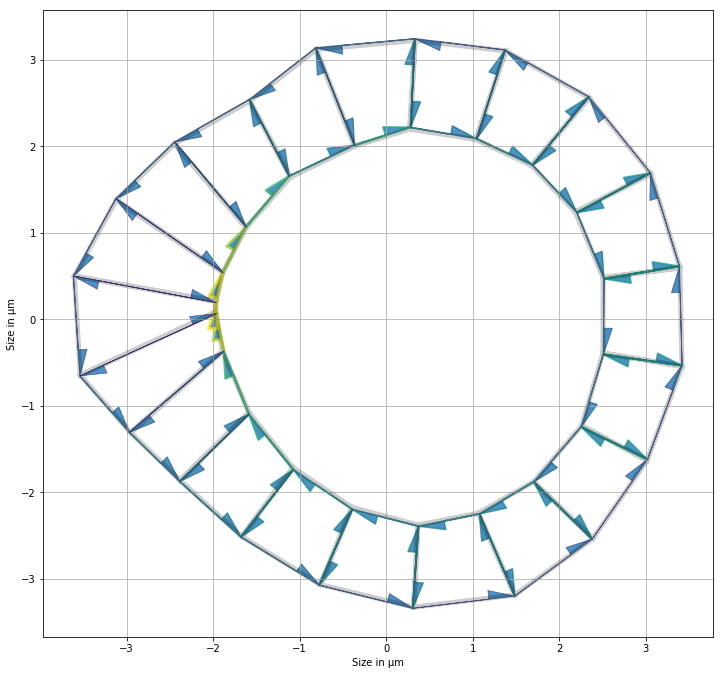

In [29]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas_copy.x[:organo3.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = res_2_cst_areas_copy.x[4*organo3.Nf:5*organo3.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = res_2_cst_areas_copy.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo3)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo3, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo3.edge_df.line_tension[:3*organo3.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo3.Nf]))))

In [28]:
start_sym = time.time()
iprint_file = "../../assets/dist_at_each_f_ev/11_03_eq_t_per_cell_areas_opt.txt"
to_opt_organo = organo3.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_eq_cst[:3*organo3.Nf]),
                                                   to_opt_organo.face_df.area + mat_eq_cst[3*organo3.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_eq_cst[-1]]))
res_2_cst_areas_sym = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    energy_min_opt=energy_opt,
                                    COPY_OR_SYM='sym',
                                    **lm_opt)
end_sym = time.time()
print('Execution time: ', end_sym - start_sym)

7.704218270784322 [0.21527715 0.20793432 0.20871254 0.16258575 0.06280184 0.08674042
 0.24386573 0.3467625  0.39720302 0.27840889 0.17763813 0.2953093
 0.31363419 0.29224717 0.12499392 0.0965795  0.07690686 0.12845364
 0.19548487 0.20676833 0.08958301 0.12554695 0.14720154 0.17085658
 0.19359425 0.27754791 0.34478012 0.30198097 0.09174665 0.09342276
 0.09472581 0.0791678  0.2272611  0.26678685 0.31441231 0.16224307
 0.16807631 0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.704218272231563 [0.21527715 0.20793433 0.20871254 0.16258574 0.06280184 0.08674042
 0.24386573 0.3467625  0.39720302 0.27840889 0.17763813 0.2953093
 0.31363419 0.29224717 0.12499392 0.0965795  0.07690686 0.12845364
 0.19548487 0.20676833 0.08958301 0.12554695 0.14720154 0.17085658
 0.19359425 0.27754791 0.34478012 0.30198097 0.09174665 0.09342276
 0.09472581 0.0791678  0.2272611  0.26678685 0.31441231 0.16224307
 0.16807631 0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.70421825644322 [0.21527715 0.20793432 0.20871254 0.16258575 0.06280184 0.08674042
 0.24386573 0.3467625  0.39720302 0.27840888 0.17763813 0.2953093
 0.3136342  0.29224717 0.12499392 0.0965795  0.07690686 0.12845364
 0.19548487 0.20676833 0.08958301 0.12554695 0.14720154 0.17085658
 0.19359425 0.27754791 0.34478013 0.30198097 0.09174665 0.09342275
 0.09472581 0.0791678  0.2272611  0.26678685 0.31441231 0.16224307
 0.16807631 0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

7.7042182715521985 [0.21527715 0.20793432 0.20871254 0.16258575 0.06280184 0.08674042
 0.24386573 0.3467625  0.39720302 0.27840889 0.17763813 0.2953093
 0.31363419 0.29224717 0.12499392 0.09657951 0.07690686 0.12845364
 0.19548487 0.20676833 0.08958301 0.12554695 0.14720154 0.17085658
 0.19359425 0.27754791 0.34478012 0.30198097 0.09174665 0.09342276
 0.09472581 0.0791678  0.2272611  0.26678685 0.31441231 0.16224307
 0.16807631 0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

7.704218276661782 [0.21527715 0.20793433 0.20871254 0.16258575 0.06280184 0.08674042
 0.24386573 0.3467625  0.39720302 0.27840889 0.17763813 0.2953093
 0.31363419 0.29224717 0.12499392 0.0965795  0.07690686 0.12845364
 0.19548487 0.20676833 0.08958301 0.12554695 0.14720154 0.17085658
 0.19359425 0.27754791 0.34478012 0.30198097 0.09174665 0.09342276
 0.09472581 0.0791678  0.2272611  0.26678685 0.31441231 0.16224307
 0.16807631 0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.704218269169373 [0.21527715 0.20793432 0.20871254 0.16258575 0.06280184 0.08674042
 0.24386573 0.3467625  0.39720302 0.27840889 0.17763813 0.2953093
 0.31363419 0.29224717 0.12499392 0.0965795  0.07690686 0.12845364
 0.19548487 0.20676833 0.08958301 0.12554695 0.14720154 0.17085658
 0.19359425 0.27754791 0.34478012 0.30198097 0.09174665 0.09342276
 0.09472581 0.0791678  0.2272611  0.26678685 0.31441231 0.16224307
 0.16807631 0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.704218265390625 [0.21527715 0.20793432 0.20871254 0.16258575 0.06280184 0.08674042
 0.24386573 0.3467625  0.39720302 0.27840889 0.17763813 0.2953093
 0.31363419 0.29224717 0.12499392 0.0965795  0.07690686 0.12845364
 0.19548487 0.20676833 0.08958301 0.12554695 0.14720154 0.17085658
 0.19359425 0.27754791 0.34478012 0.30198097 0.09174665 0.09342276
 0.09472581 0.0791678  0.2272611  0.26678685 0.31441231 0.16224307
 0.16807631 0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.704218277125846 [0.21527715 0.20793432 0.20871254 0.16258575 0.06280184 0.08674042
 0.24386573 0.3467625  0.39720302 0.27840889 0.17763813 0.2953093
 0.31363419 0.29224717 0.12499392 0.0965795  0.07690686 0.12845364
 0.19548487 0.20676834 0.08958301 0.12554695 0.14720154 0.17085658
 0.19359425 0.27754791 0.34478012 0.30198097 0.09174665 0.09342276
 0.09472581 0.0791678  0.2272611  0.26678685 0.31441231 0.16224307
 0.16807631 0.16549571 0.14737522 0.12410527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.7042182758400415 [0.21527715 0.20793433 0.20871254 0.16258574 0.06280184 0.08674042
 0.24386572 0.3467625  0.39720302 0.27840889 0.17763813 0.2953093
 0.31363419 0.29224717 0.12499392 0.0965795  0.07690686 0.12845364
 0.19548487 0.20676834 0.08958301 0.12554695 0.14720154 0.17085658
 0.19359426 0.27754791 0.34478012 0.30198097 0.09174665 0.09342276
 0.09472581 0.0791678  0.2272611  0.26678685 0.31441231 0.16224307
 0.16807631 0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

7.704218290500154 [0.21527715 0.20793433 0.20871254 0.16258575 0.06280184 0.08674042
 0.24386573 0.3467625  0.39720302 0.27840889 0.17763813 0.29530931
 0.3136342  0.29224717 0.12499392 0.0965795  0.07690686 0.12845364
 0.19548487 0.20676834 0.08958301 0.12554695 0.14720154 0.17085658
 0.19359425 0.27754791 0.34478012 0.30198097 0.09174665 0.09342275
 0.09472581 0.0791678  0.2272611  0.26678686 0.31441231 0.16224307
 0.16807631 0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

7.704218264073965 [0.21527715 0.20793432 0.20871254 0.16258575 0.06280184 0.08674042
 0.24386573 0.3467625  0.39720302 0.27840889 0.17763813 0.2953093
 0.31363419 0.29224717 0.12499392 0.0965795  0.07690686 0.12845364
 0.19548487 0.20676833 0.08958301 0.12554695 0.14720154 0.17085658
 0.19359425 0.27754791 0.34478012 0.30198097 0.09174665 0.09342276
 0.09472581 0.0791678  0.2272611  0.26678685 0.31441231 0.16224307
 0.1680763  0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.704218270784322 [0.21527715 0.20793432 0.20871254 0.16258575 0.06280184 0.08674042
 0.24386573 0.3467625  0.39720302 0.27840889 0.17763813 0.2953093
 0.31363419 0.29224717 0.12499392 0.0965795  0.07690686 0.12845364
 0.19548487 0.20676833 0.08958301 0.12554695 0.14720154 0.17085658
 0.19359425 0.27754791 0.34478012 0.30198097 0.09174665 0.09342276
 0.09472581 0.0791678  0.2272611  0.26678685 0.31441231 0.16224307
 0.16807631 0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.704218270784322 [0.21527715 0.20793432 0.20871254 0.16258575 0.06280184 0.08674042
 0.24386573 0.3467625  0.39720302 0.27840889 0.17763813 0.2953093
 0.31363419 0.29224717 0.12499392 0.0965795  0.07690686 0.12845364
 0.19548487 0.20676833 0.08958301 0.12554695 0.14720154 0.17085658
 0.19359425 0.27754791 0.34478012 0.30198097 0.09174665 0.09342276
 0.09472581 0.0791678  0.2272611  0.26678685 0.31441231 0.16224307
 0.16807631 0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.704218270784322 [0.21527715 0.20793432 0.20871254 0.16258575 0.06280184 0.08674042
 0.24386573 0.3467625  0.39720302 0.27840889 0.17763813 0.2953093
 0.31363419 0.29224717 0.12499392 0.0965795  0.07690686 0.12845364
 0.19548487 0.20676833 0.08958301 0.12554695 0.14720154 0.17085658
 0.19359425 0.27754791 0.34478012 0.30198097 0.09174665 0.09342276
 0.09472581 0.0791678  0.2272611  0.26678685 0.31441231 0.16224307
 0.16807631 0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.704218221305695 [0.21527715 0.20793433 0.20871254 0.16258574 0.06280184 0.08674042
 0.24386572 0.3467625  0.39720302 0.27840888 0.17763813 0.2953093
 0.31363419 0.29224717 0.12499392 0.0965795  0.07690686 0.12845364
 0.19548487 0.20676833 0.08958301 0.12554694 0.14720153 0.17085658
 0.19359425 0.27754791 0.34478012 0.30198097 0.09174665 0.09342276
 0.09472581 0.0791678  0.2272611  0.26678685 0.31441231 0.16224307
 0.16807631 0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

7.704218151833483 [0.21527715 0.20793433 0.20871254 0.16258574 0.06280183 0.08674042
 0.24386573 0.3467625  0.397203   0.27840886 0.17763808 0.29530928
 0.3136342  0.29224718 0.12499394 0.0965795  0.07690686 0.12845365
 0.19548487 0.20676834 0.08958301 0.12554694 0.14720154 0.17085659
 0.19359426 0.27754791 0.34478011 0.30198096 0.09174664 0.09342276
 0.09472584 0.07916778 0.22726109 0.26678685 0.31441231 0.16224307
 0.16807631 0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

7.704218310367621 [0.21527716 0.20793433 0.20871254 0.16258575 0.06280184 0.08674042
 0.24386573 0.3467625  0.39720302 0.27840889 0.17763813 0.29530931
 0.31363419 0.29224717 0.12499392 0.0965795  0.07690686 0.12845364
 0.19548487 0.20676834 0.08958301 0.12554695 0.14720154 0.17085658
 0.19359425 0.27754791 0.34478012 0.30198097 0.09174665 0.09342276
 0.09472581 0.07916781 0.2272611  0.26678685 0.31441232 0.16224307
 0.16807631 0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

7.704218164493844 [0.21527715 0.20793432 0.20871254 0.16258574 0.06280184 0.08674042
 0.24386572 0.34676249 0.39720301 0.27840888 0.17763813 0.2953093
 0.31363419 0.29224717 0.12499392 0.0965795  0.07690686 0.12845364
 0.19548487 0.20676833 0.089583   0.12554694 0.14720154 0.17085658
 0.19359425 0.27754791 0.34478012 0.30198097 0.09174665 0.09342275
 0.09472581 0.0791678  0.2272611  0.26678685 0.31441231 0.16224307
 0.1680763  0.16549571 0.14737522 0.12410526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.28821323614767 [3.39515186e-02 1.58806286e-02 1.99327602e-02 1.98058404e-01
 8.27316421e-02 3.00448116e-01 1.19753321e-01 1.43622713e-01
 3.05877977e-01 2.18522887e-01 2.49138669e-01 1.99593085e-01
 8.07783501e-02 1.29666867e-02 1.67136514e-01 1.13427808e-01
 5.32175085e-02 3.24338114e-02 1.06574988e-01 5.24580062e-02
 2.74993141e-02 2.83039613e-02 1.67414459e-01 9.03857693e-02
 5.10733112e-02 1.52926854e-01 3.94245441e-01 1.28667122e-01
 1.38166757e-01 6.88667049e-02 1.40438001e-01 2.90766825e-01
 1.89240684e-01 1.81487696e-01 3.97981659e-01 1.00149297e-01
 3.38095746e-02 6.05867447e-02 6.20482891e-02 7.50058623e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

5.288212460810814 [3.39515193e-02 1.58806219e-02 1.99327680e-02 1.98058386e-01
 8.27316461e-02 3.00448068e-01 1.19753294e-01 1.43622682e-01
 3.05877900e-01 2.18522846e-01 2.49138621e-01 1.99593052e-01
 8.07783067e-02 1.29667026e-02 1.67136495e-01 1.13427805e-01
 5.32175036e-02 3.24338102e-02 1.06574986e-01 5.24579964e-02
 2.74993038e-02 2.83039680e-02 1.67414432e-01 9.03857557e-02
 5.10733062e-02 1.52926868e-01 3.94245395e-01 1.28667085e-01
 1.38166733e-01 6.88666751e-02 1.40437969e-01 2.90766762e-01
 1.89240646e-01 1.81487666e-01 3.97981599e-01 1.00149297e-01
 3.38095952e-02 6.05867355e-02 6.20482885e-02 7.50058560e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288147398357092 [3.39515594e-02 1.58801460e-02 1.99332215e-02 1.98056916e-01
 8.27320530e-02 3.00444041e-01 1.19750802e-01 1.43620442e-01
 3.05871376e-01 2.18519417e-01 2.49134471e-01 1.99590284e-01
 8.07746208e-02 1.29680558e-02 1.67134958e-01 1.13427647e-01
 5.32170903e-02 3.24337023e-02 1.06574868e-01 5.24571839e-02
 2.74984652e-02 2.83046764e-02 1.67412325e-01 9.03846120e-02
 5.10730757e-02 1.52927853e-01 3.94241611e-01 1.28663577e-01
 1.38164669e-01 6.88641031e-02 1.40435289e-01 2.90761512e-01
 1.89237416e-01 1.81485098e-01 3.97976546e-01 1.00149295e-01
 3.38113461e-02 6.05859668e-02 6.20482609e-02 7.50053340e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288216600927226 [3.39515168e-02 1.58806520e-02 1.99327396e-02 1.98058480e-01
 8.27316209e-02 3.00448325e-01 1.19753449e-01 1.43622829e-01
 3.05878314e-01 2.18523065e-01 2.49138883e-01 1.99593229e-01
 8.07785400e-02 1.29666179e-02 1.67136599e-01 1.13427816e-01
 5.32175313e-02 3.24338172e-02 1.06574994e-01 5.24580480e-02
 2.74993567e-02 2.83039236e-02 1.67414566e-01 9.03858281e-02
 5.10733211e-02 1.52926804e-01 3.94245637e-01 1.28667303e-01
 1.38166864e-01 6.88668366e-02 1.40438139e-01 2.90767095e-01
 1.89240850e-01 1.81487831e-01 3.97981924e-01 1.00149296e-01
 3.38094809e-02 6.05867852e-02 6.20482911e-02 7.50058891e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288211329674464 [3.39515190e-02 1.58806139e-02 1.99327762e-02 1.98058361e-01
 8.27316534e-02 3.00447999e-01 1.19753248e-01 1.43622648e-01
 3.05877787e-01 2.18522787e-01 2.49138548e-01 1.99593005e-01
 8.07782425e-02 1.29667262e-02 1.67136469e-01 1.13427803e-01
 5.32174968e-02 3.24338076e-02 1.06574984e-01 5.24579805e-02
 2.74992881e-02 2.83039802e-02 1.67414396e-01 9.03857359e-02
 5.10733025e-02 1.52926883e-01 3.94245331e-01 1.28667020e-01
 1.38166697e-01 6.88666298e-02 1.40437923e-01 2.90766672e-01
 1.89240589e-01 1.81487621e-01 3.97981512e-01 1.00149298e-01
 3.38096258e-02 6.05867216e-02 6.20482876e-02 7.50058476e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288211470881165 [3.39515200e-02 1.58806144e-02 1.99327763e-02 1.98058363e-01
 8.27316529e-02 3.00448008e-01 1.19753253e-01 1.43622652e-01
 3.05877800e-01 2.18522795e-01 2.49138557e-01 1.99593011e-01
 8.07782501e-02 1.29667233e-02 1.67136472e-01 1.13427804e-01
 5.32174975e-02 3.24338086e-02 1.06574984e-01 5.24579840e-02
 2.74992909e-02 2.83039795e-02 1.67414399e-01 9.03857391e-02
 5.10733032e-02 1.52926881e-01 3.94245339e-01 1.28667027e-01
 1.38166701e-01 6.88666348e-02 1.40437928e-01 2.90766683e-01
 1.89240596e-01 1.81487627e-01 3.97981522e-01 1.00149298e-01
 3.38096221e-02 6.05867239e-02 6.20482886e-02 7.50058480e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.28821791223806 [3.39515159e-02 1.58806618e-02 1.99327304e-02 1.98058510e-01
 8.27316122e-02 3.00448407e-01 1.19753498e-01 1.43622878e-01
 3.05878446e-01 2.18523135e-01 2.49138967e-01 1.99593285e-01
 8.07786150e-02 1.29665894e-02 1.67136624e-01 1.13427819e-01
 5.32175384e-02 3.24338192e-02 1.06574996e-01 5.24580644e-02
 2.74993737e-02 2.83039092e-02 1.67414609e-01 9.03858512e-02
 5.10733257e-02 1.52926784e-01 3.94245716e-01 1.28667371e-01
 1.38166906e-01 6.88668889e-02 1.40438193e-01 2.90767202e-01
 1.89240916e-01 1.81487881e-01 3.97982023e-01 1.00149298e-01
 3.38094488e-02 6.05868000e-02 6.20482914e-02 7.50058997e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

5.288230583592915 [3.39515081e-02 1.58807545e-02 1.99326428e-02 1.98058796e-01
 8.27315342e-02 3.00449191e-01 1.19753983e-01 1.43623311e-01
 3.05879715e-01 2.18523804e-01 2.49139773e-01 1.99593826e-01
 8.07793313e-02 1.29663265e-02 1.67136923e-01 1.13427852e-01
 5.32176192e-02 3.24338403e-02 1.06575020e-01 5.24582223e-02
 2.74995364e-02 2.83037723e-02 1.67415019e-01 9.03860735e-02
 5.10733710e-02 1.52926593e-01 3.94246451e-01 1.28668055e-01
 1.38167307e-01 6.88673880e-02 1.40438716e-01 2.90768225e-01
 1.89241544e-01 1.81488381e-01 3.97983006e-01 1.00149299e-01
 3.38091090e-02 6.05869496e-02 6.20482978e-02 7.50060013e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288211049926459 [3.39515201e-02 1.58806117e-02 1.99327781e-02 1.98058355e-01
 8.27316552e-02 3.00447981e-01 1.19753237e-01 1.43622638e-01
 3.05877758e-01 2.18522773e-01 2.49138530e-01 1.99592993e-01
 8.07782264e-02 1.29667319e-02 1.67136462e-01 1.13427802e-01
 5.32174948e-02 3.24338080e-02 1.06574984e-01 5.24579787e-02
 2.74992854e-02 2.83039837e-02 1.67414387e-01 9.03857308e-02
 5.10733016e-02 1.52926888e-01 3.94245315e-01 1.28667004e-01
 1.38166688e-01 6.88666184e-02 1.40437911e-01 2.90766649e-01
 1.89240575e-01 1.81487610e-01 3.97981489e-01 1.00149298e-01
 3.38096333e-02 6.05867190e-02 6.20482884e-02 7.50058447e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288211241008648 [3.39515202e-02 1.58806129e-02 1.99327769e-02 1.98058359e-01
 8.27316540e-02 3.00447994e-01 1.19753245e-01 1.43622645e-01
 3.05877778e-01 2.18522783e-01 2.49138542e-01 1.99593001e-01
 8.07782373e-02 1.29667280e-02 1.67136467e-01 1.13427803e-01
 5.32174959e-02 3.24338079e-02 1.06574983e-01 5.24579808e-02
 2.74992874e-02 2.83039816e-02 1.67414393e-01 9.03857342e-02
 5.10733023e-02 1.52926885e-01 3.94245326e-01 1.28667015e-01
 1.38166694e-01 6.88666259e-02 1.40437919e-01 2.90766664e-01
 1.89240585e-01 1.81487618e-01 3.97981505e-01 1.00149298e-01
 3.38096282e-02 6.05867207e-02 6.20482882e-02 7.50058451e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.2882032346751355 [3.39515252e-02 1.58805543e-02 1.99328326e-02 1.98058176e-01
 8.27317042e-02 3.00447498e-01 1.19752939e-01 1.43622369e-01
 3.05876976e-01 2.18522361e-01 2.49138033e-01 1.99592661e-01
 8.07777843e-02 1.29668940e-02 1.67136278e-01 1.13427783e-01
 5.32174456e-02 3.24337952e-02 1.06574969e-01 5.24578805e-02
 2.74991838e-02 2.83040650e-02 1.67414130e-01 9.03855924e-02
 5.10732728e-02 1.52927007e-01 3.94244861e-01 1.28666584e-01
 1.38166441e-01 6.88663103e-02 1.40437590e-01 2.90766019e-01
 1.89240187e-01 1.81487302e-01 3.97980883e-01 1.00149298e-01
 3.38098433e-02 6.05866268e-02 6.20482853e-02 7.50057818e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

5.288212319051621 [3.39515191e-02 1.58806212e-02 1.99327700e-02 1.98058383e-01
 8.27316484e-02 3.00448059e-01 1.19753287e-01 1.43622684e-01
 3.05877885e-01 2.18522841e-01 2.49138609e-01 1.99593048e-01
 8.07782970e-02 1.29667058e-02 1.67136492e-01 1.13427807e-01
 5.32175034e-02 3.24338102e-02 1.06574986e-01 5.24579941e-02
 2.74993013e-02 2.83039709e-02 1.67414427e-01 9.03857532e-02
 5.10733071e-02 1.52926866e-01 3.94245385e-01 1.28667074e-01
 1.38166728e-01 6.88666662e-02 1.40437963e-01 2.90766751e-01
 1.89240637e-01 1.81487661e-01 3.97981588e-01 1.00149299e-01
 3.38096000e-02 6.05867340e-02 6.20482900e-02 7.50058547e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288200188523259 [3.39515267e-02 1.58805323e-02 1.99328530e-02 1.98058108e-01
 8.27317219e-02 3.00447309e-01 1.19752823e-01 1.43622264e-01
 3.05876671e-01 2.18522197e-01 2.49137840e-01 1.99592529e-01
 8.07776130e-02 1.29669570e-02 1.67136206e-01 1.13427774e-01
 5.32174255e-02 3.24337899e-02 1.06574963e-01 5.24578433e-02
 2.74991462e-02 2.83041007e-02 1.67414035e-01 9.03855405e-02
 5.10732628e-02 1.52927051e-01 3.94244682e-01 1.28666421e-01
 1.38166344e-01 6.88661914e-02 1.40437464e-01 2.90765774e-01
 1.89240037e-01 1.81487182e-01 3.97980646e-01 1.00149296e-01
 3.38099242e-02 6.05865906e-02 6.20482826e-02 7.50057575e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.2882064705326846 [3.39515228e-02 1.58805783e-02 1.99328100e-02 1.98058251e-01
 8.27316836e-02 3.00447698e-01 1.19753062e-01 1.43622480e-01
 3.05877300e-01 2.18522531e-01 2.49138239e-01 1.99592798e-01
 8.07779674e-02 1.29668263e-02 1.67136354e-01 1.13427791e-01
 5.32174657e-02 3.24338004e-02 1.06574975e-01 5.24579215e-02
 2.74992265e-02 2.83040335e-02 1.67414238e-01 9.03856505e-02
 5.10732855e-02 1.52926957e-01 3.94245048e-01 1.28666758e-01
 1.38166543e-01 6.88664380e-02 1.40437723e-01 2.90766280e-01
 1.89240348e-01 1.81487429e-01 3.97981132e-01 1.00149296e-01
 3.38097566e-02 6.05866648e-02 6.20482864e-02 7.50058079e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

5.288219223873206 [3.39515159e-02 1.58806722e-02 1.99327217e-02 1.98058538e-01
 8.27316044e-02 3.00448486e-01 1.19753548e-01 1.43622919e-01
 3.05878575e-01 2.18523203e-01 2.49139049e-01 1.99593340e-01
 8.07786877e-02 1.29665623e-02 1.67136654e-01 1.13427823e-01
 5.32175465e-02 3.24338259e-02 1.06575006e-01 5.24580821e-02
 2.74993915e-02 2.83038959e-02 1.67414650e-01 9.03858736e-02
 5.10733307e-02 1.52926765e-01 3.94245788e-01 1.28667442e-01
 1.38166946e-01 6.88669390e-02 1.40438246e-01 2.90767305e-01
 1.89240980e-01 1.81487932e-01 3.97982122e-01 1.00149298e-01
 3.38094140e-02 6.05868178e-02 6.20482969e-02 7.50059164e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288212089157969 [3.39515194e-02 1.58806193e-02 1.99327709e-02 1.98058378e-01
 8.27316487e-02 3.00448046e-01 1.19753277e-01 1.43622674e-01
 3.05877862e-01 2.18522827e-01 2.49138596e-01 1.99593037e-01
 8.07782852e-02 1.29667104e-02 1.67136487e-01 1.13427805e-01
 5.32175015e-02 3.24338096e-02 1.06574986e-01 5.24579916e-02
 2.74992988e-02 2.83039725e-02 1.67414420e-01 9.03857490e-02
 5.10733053e-02 1.52926872e-01 3.94245375e-01 1.28667060e-01
 1.38166721e-01 6.88666593e-02 1.40437954e-01 2.90766732e-01
 1.89240627e-01 1.81487651e-01 3.97981570e-01 1.00149298e-01
 3.38096055e-02 6.05867312e-02 6.20482889e-02 7.50058530e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288212089157969 [3.39515194e-02 1.58806193e-02 1.99327709e-02 1.98058378e-01
 8.27316487e-02 3.00448046e-01 1.19753277e-01 1.43622674e-01
 3.05877862e-01 2.18522827e-01 2.49138596e-01 1.99593037e-01
 8.07782852e-02 1.29667104e-02 1.67136487e-01 1.13427805e-01
 5.32175015e-02 3.24338096e-02 1.06574986e-01 5.24579916e-02
 2.74992988e-02 2.83039725e-02 1.67414420e-01 9.03857490e-02
 5.10733053e-02 1.52926872e-01 3.94245375e-01 1.28667060e-01
 1.38166721e-01 6.88666593e-02 1.40437954e-01 2.90766732e-01
 1.89240627e-01 1.81487651e-01 3.97981570e-01 1.00149298e-01
 3.38096055e-02 6.05867312e-02 6.20482889e-02 7.50058530e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288212089157969 [3.39515194e-02 1.58806193e-02 1.99327709e-02 1.98058378e-01
 8.27316487e-02 3.00448046e-01 1.19753277e-01 1.43622674e-01
 3.05877862e-01 2.18522827e-01 2.49138596e-01 1.99593037e-01
 8.07782852e-02 1.29667104e-02 1.67136487e-01 1.13427805e-01
 5.32175015e-02 3.24338096e-02 1.06574986e-01 5.24579916e-02
 2.74992988e-02 2.83039725e-02 1.67414420e-01 9.03857490e-02
 5.10733053e-02 1.52926872e-01 3.94245375e-01 1.28667060e-01
 1.38166721e-01 6.88666593e-02 1.40437954e-01 2.90766732e-01
 1.89240627e-01 1.81487651e-01 3.97981570e-01 1.00149298e-01
 3.38096055e-02 6.05867312e-02 6.20482889e-02 7.50058530e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288212089157969 [3.39515194e-02 1.58806193e-02 1.99327709e-02 1.98058378e-01
 8.27316487e-02 3.00448046e-01 1.19753277e-01 1.43622674e-01
 3.05877862e-01 2.18522827e-01 2.49138596e-01 1.99593037e-01
 8.07782852e-02 1.29667104e-02 1.67136487e-01 1.13427805e-01
 5.32175015e-02 3.24338096e-02 1.06574986e-01 5.24579916e-02
 2.74992988e-02 2.83039725e-02 1.67414420e-01 9.03857490e-02
 5.10733053e-02 1.52926872e-01 3.94245375e-01 1.28667060e-01
 1.38166721e-01 6.88666593e-02 1.40437954e-01 2.90766732e-01
 1.89240627e-01 1.81487651e-01 3.97981570e-01 1.00149298e-01
 3.38096055e-02 6.05867312e-02 6.20482889e-02 7.50058530e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288212089157969 [3.39515194e-02 1.58806193e-02 1.99327709e-02 1.98058378e-01
 8.27316487e-02 3.00448046e-01 1.19753277e-01 1.43622674e-01
 3.05877862e-01 2.18522827e-01 2.49138596e-01 1.99593037e-01
 8.07782852e-02 1.29667104e-02 1.67136487e-01 1.13427805e-01
 5.32175015e-02 3.24338096e-02 1.06574986e-01 5.24579916e-02
 2.74992988e-02 2.83039725e-02 1.67414420e-01 9.03857490e-02
 5.10733053e-02 1.52926872e-01 3.94245375e-01 1.28667060e-01
 1.38166721e-01 6.88666593e-02 1.40437954e-01 2.90766732e-01
 1.89240627e-01 1.81487651e-01 3.97981570e-01 1.00149298e-01
 3.38096055e-02 6.05867312e-02 6.20482889e-02 7.50058530e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288236731958091 [3.39515036e-02 1.58807975e-02 1.99326031e-02 1.98058930e-01
 8.27314924e-02 3.00449571e-01 1.19754223e-01 1.43623525e-01
 3.05880339e-01 2.18524124e-01 2.49140173e-01 1.99594084e-01
 8.07796860e-02 1.29661965e-02 1.67137069e-01 1.13427862e-01
 5.32176576e-02 3.24338504e-02 1.06575029e-01 5.24582998e-02
 2.74996161e-02 2.83036991e-02 1.67415225e-01 9.03861812e-02
 5.10733891e-02 1.52926495e-01 3.94246809e-01 1.28668391e-01
 1.38167501e-01 6.88676401e-02 1.40438965e-01 2.90768720e-01
 1.89241855e-01 1.81488625e-01 3.97983486e-01 1.00149297e-01
 3.38089396e-02 6.05870224e-02 6.20482973e-02 7.50060505e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288058102717462 [3.39516141e-02 1.58794927e-02 1.99338394e-02 1.98054893e-01
 8.27326052e-02 3.00438508e-01 1.19747389e-01 1.43617369e-01
 3.05862429e-01 2.18514686e-01 2.49128797e-01 1.99586475e-01
 8.07695705e-02 1.29699101e-02 1.67132849e-01 1.13427418e-01
 5.32165201e-02 3.24335539e-02 1.06574701e-01 5.24560702e-02
 2.74973183e-02 2.83056413e-02 1.67409434e-01 9.03830457e-02
 5.10727574e-02 1.52929194e-01 3.94236410e-01 1.28658782e-01
 1.38161839e-01 6.88605985e-02 1.40431622e-01 2.90754320e-01
 1.89232982e-01 1.81481573e-01 3.97969609e-01 1.00149286e-01
 3.38137408e-02 6.05849116e-02 6.20482162e-02 7.50046170e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288710036702416 [3.39512033e-02 1.58842669e-02 1.99292971e-02 1.98069616e-01
 8.27285086e-02 3.00478896e-01 1.19772348e-01 1.43639864e-01
 3.05927871e-01 2.18549052e-01 2.49170428e-01 1.99614252e-01
 8.08065595e-02 1.29563385e-02 1.67148231e-01 1.13428996e-01
 5.32206580e-02 3.24346275e-02 1.06575868e-01 5.24642140e-02
 2.75057240e-02 2.82985422e-02 1.67430537e-01 9.03944919e-02
 5.10750721e-02 1.52919259e-01 3.94274323e-01 1.28693910e-01
 1.38182488e-01 6.88863352e-02 1.40458452e-01 2.90806919e-01
 1.89265385e-01 1.81507330e-01 3.98020247e-01 1.00149311e-01
 3.37961482e-02 6.05926210e-02 6.20485042e-02 7.50098288e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288325710233746 [3.39514487e-02 1.58814509e-02 1.99319789e-02 1.98060945e-01
 8.27309370e-02 3.00455084e-01 1.19757627e-01 1.43626595e-01
 3.05889265e-01 2.18528822e-01 2.49145845e-01 1.99597874e-01
 8.07847288e-02 1.29643458e-02 1.67139164e-01 1.13428078e-01
 5.32182221e-02 3.24339967e-02 1.06575191e-01 5.24594113e-02
 2.75007637e-02 2.83027343e-02 1.67418100e-01 9.03877457e-02
 5.10737075e-02 1.52925143e-01 3.94251985e-01 1.28673183e-01
 1.38170322e-01 6.88711481e-02 1.40442625e-01 2.90775896e-01
 1.89246275e-01 1.81492137e-01 3.97990404e-01 1.00149297e-01
 3.38065460e-02 6.05880725e-02 6.20483368e-02 7.50067638e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

5.288228576448904 [3.39515113e-02 1.58807405e-02 1.99326545e-02 1.98058749e-01
 8.27315439e-02 3.00449065e-01 1.19753910e-01 1.43623243e-01
 3.05879518e-01 2.18523692e-01 2.49139651e-01 1.99593736e-01
 8.07792224e-02 1.29663667e-02 1.67136876e-01 1.13427842e-01
 5.32176057e-02 3.24338365e-02 1.06575011e-01 5.24582011e-02
 2.74995147e-02 2.83037920e-02 1.67414954e-01 9.03860396e-02
 5.10733628e-02 1.52926619e-01 3.94246333e-01 1.28667950e-01
 1.38167242e-01 6.88673174e-02 1.40438629e-01 2.90768061e-01
 1.89241449e-01 1.81488302e-01 3.97982851e-01 1.00149296e-01
 3.38091596e-02 6.05869280e-02 6.20482936e-02 7.50059917e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9764144007652216 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.976414389213268 [4.75094523e-02 4.36802600e-02 2.16624031e-02 1.10689080e-01
 4.55961348e-02 2.00908673e-01 9.40887500e-02 9.16721385e-02
 1.88270065e-01 2.25748263e-01 1.76660581e-01 2.02043747e-01
 7.60553410e-02 3.25825486e-02 8.34091209e-02 1.03084428e-01
 4.54234436e-02 4.41409394e-02 5.14357743e-02 7.08441759e-02
 3.49156766e-02 3.38708498e-02 8.71357769e-02 4.76743892e-02
 2.71175775e-02 5.81449004e-02 2.19309470e-01 1.61702406e-01
 1.32254289e-01 3.58513871e-02 1.21331755e-01 1.94176725e-01
 1.02042984e-01 1.34265047e-01 2.28594544e-01 1.08416701e-01
 8.99424465e-02 5.66172021e-02 9.84852002e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9764143718500353 [4.75094521e-02 4.36802598e-02 2.16624040e-02 1.10689081e-01
 4.55961339e-02 2.00908674e-01 9.40887492e-02 9.16721424e-02
 1.88270058e-01 2.25748263e-01 1.76660581e-01 2.02043746e-01
 7.60553402e-02 3.25825486e-02 8.34091207e-02 1.03084428e-01
 4.54234435e-02 4.41409394e-02 5.14357739e-02 7.08441755e-02
 3.49156764e-02 3.38708492e-02 8.71357785e-02 4.76743873e-02
 2.71175776e-02 5.81448992e-02 2.19309471e-01 1.61702407e-01
 1.32254285e-01 3.58513861e-02 1.21331755e-01 1.94176723e-01
 1.02042983e-01 1.34265046e-01 2.28594543e-01 1.08416701e-01
 8.99424462e-02 5.66172017e-02 9.84852001e-02 4.73053484e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.976414483815868 [4.75094530e-02 4.36802608e-02 2.16624053e-02 1.10689083e-01
 4.55961344e-02 2.00908677e-01 9.40887530e-02 9.16721399e-02
 1.88270070e-01 2.25748268e-01 1.76660584e-01 2.02043758e-01
 7.60553493e-02 3.25825503e-02 8.34091219e-02 1.03084429e-01
 4.54234444e-02 4.41409394e-02 5.14357752e-02 7.08441773e-02
 3.49156770e-02 3.38708492e-02 8.71357811e-02 4.76743893e-02
 2.71175787e-02 5.81448981e-02 2.19309473e-01 1.61702408e-01
 1.32254292e-01 3.58513892e-02 1.21331758e-01 1.94176739e-01
 1.02042979e-01 1.34265054e-01 2.28594549e-01 1.08416701e-01
 8.99424480e-02 5.66172038e-02 9.84852011e-02 4.73053482e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9764144189945743 [4.75094526e-02 4.36802604e-02 2.16624049e-02 1.10689082e-01
 4.55961342e-02 2.00908675e-01 9.40887517e-02 9.16721390e-02
 1.88270067e-01 2.25748265e-01 1.76660582e-01 2.02043749e-01
 7.60553424e-02 3.25825488e-02 8.34091228e-02 1.03084426e-01
 4.54234430e-02 4.41409395e-02 5.14357743e-02 7.08441766e-02
 3.49156767e-02 3.38708491e-02 8.71357800e-02 4.76743885e-02
 2.71175782e-02 5.81448983e-02 2.19309471e-01 1.61702407e-01
 1.32254290e-01 3.58513880e-02 1.21331756e-01 1.94176728e-01
 1.02042984e-01 1.34265049e-01 2.28594545e-01 1.08416699e-01
 8.99424458e-02 5.66172050e-02 9.84852010e-02 4.73053480e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.976414400525978 [4.75094523e-02 4.36802601e-02 2.16624043e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441758e-02
 3.49156766e-02 3.38708491e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172023e-02 9.84852002e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9764143933097476 [4.75094524e-02 4.36802603e-02 2.16624045e-02 1.10689081e-01
 4.55961327e-02 2.00908675e-01 9.40887504e-02 9.16721386e-02
 1.88270065e-01 2.25748263e-01 1.76660581e-01 2.02043747e-01
 7.60553411e-02 3.25825487e-02 8.34091210e-02 1.03084428e-01
 4.54234437e-02 4.41409393e-02 5.14357742e-02 7.08441758e-02
 3.49156765e-02 3.38708493e-02 8.71357789e-02 4.76743863e-02
 2.71175794e-02 5.81448982e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513872e-02 1.21331755e-01 1.94176725e-01
 1.02042984e-01 1.34265047e-01 2.28594544e-01 1.08416701e-01
 8.99424465e-02 5.66172022e-02 9.84852002e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764143919769275 [4.75094523e-02 4.36802600e-02 2.16624042e-02 1.10689081e-01
 4.55961339e-02 2.00908674e-01 9.40887505e-02 9.16721380e-02
 1.88270066e-01 2.25748263e-01 1.76660581e-01 2.02043747e-01
 7.60553410e-02 3.25825487e-02 8.34091209e-02 1.03084428e-01
 4.54234437e-02 4.41409394e-02 5.14357741e-02 7.08441757e-02
 3.49156765e-02 3.38708492e-02 8.71357790e-02 4.76743877e-02
 2.71175779e-02 5.81448989e-02 2.19309471e-01 1.61702405e-01
 1.32254291e-01 3.58513866e-02 1.21331755e-01 1.94176725e-01
 1.02042984e-01 1.34265047e-01 2.28594544e-01 1.08416701e-01
 8.99424465e-02 5.66172021e-02 9.84852002e-02 4.73053484e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764143986398097 [4.75094524e-02 4.36802601e-02 2.16624043e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887505e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043747e-01
 7.60553412e-02 3.25825487e-02 8.34091210e-02 1.03084428e-01
 4.54234438e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357792e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176725e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172023e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.976414402569385 [4.75094523e-02 4.36802601e-02 2.16624043e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887504e-02 9.16721387e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043747e-01
 7.60553412e-02 3.25825484e-02 8.34091215e-02 1.03084430e-01
 4.54234451e-02 4.41409395e-02 5.14357743e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357791e-02 4.76743878e-02
 2.71175779e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513872e-02 1.21331755e-01 1.94176725e-01
 1.02042984e-01 1.34265048e-01 2.28594544e-01 1.08416703e-01
 8.99424484e-02 5.66172026e-02 9.84852004e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9764143981273716 [4.75094528e-02 4.36802600e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887505e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553414e-02 3.25825487e-02 8.34091210e-02 1.03084428e-01
 4.54234438e-02 4.41409393e-02 5.14357744e-02 7.08441755e-02
 3.49156759e-02 3.38708490e-02 8.71357792e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176725e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172023e-02 9.84852000e-02 4.73053489e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.976414365382367 [4.75094522e-02 4.36802593e-02 2.16624051e-02 1.10689085e-01
 4.55961315e-02 2.00908674e-01 9.40887487e-02 9.16721388e-02
 1.88270062e-01 2.25748262e-01 1.76660580e-01 2.02043745e-01
 7.60553400e-02 3.25825488e-02 8.34091207e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357733e-02 7.08441747e-02
 3.49156761e-02 3.38708478e-02 8.71357829e-02 4.76743824e-02
 2.71175737e-02 5.81448990e-02 2.19309471e-01 1.61702406e-01
 1.32254289e-01 3.58513864e-02 1.21331754e-01 1.94176722e-01
 1.02042983e-01 1.34265046e-01 2.28594542e-01 1.08416702e-01
 8.99424459e-02 5.66172015e-02 9.84852000e-02 4.73053487e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9764143940383243 [4.75094525e-02 4.36802601e-02 2.16624042e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887499e-02 9.16721366e-02
 1.88270066e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825489e-02 8.34091212e-02 1.03084428e-01
 4.54234440e-02 4.41409393e-02 5.14357740e-02 7.08441757e-02
 3.49156764e-02 3.38708492e-02 8.71357792e-02 4.76743878e-02
 2.71175782e-02 5.81448984e-02 2.19309470e-01 1.61702403e-01
 1.32254288e-01 3.58513880e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416702e-01
 8.99424467e-02 5.66172024e-02 9.84852003e-02 4.73053485e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764143995986103 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553414e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357792e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176725e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764143356362847 [4.75094520e-02 4.36802593e-02 2.16624030e-02 1.10689080e-01
 4.55961334e-02 2.00908672e-01 9.40887478e-02 9.16721382e-02
 1.88270060e-01 2.25748261e-01 1.76660579e-01 2.02043744e-01
 7.60553389e-02 3.25825492e-02 8.34091166e-02 1.03084424e-01
 4.54234446e-02 4.41409390e-02 5.14357729e-02 7.08441742e-02
 3.49156759e-02 3.38708493e-02 8.71357773e-02 4.76743863e-02
 2.71175775e-02 5.81448996e-02 2.19309469e-01 1.61702405e-01
 1.32254288e-01 3.58513857e-02 1.21331754e-01 1.94176720e-01
 1.02042982e-01 1.34265044e-01 2.28594545e-01 1.08416704e-01
 8.99424439e-02 5.66171992e-02 9.84851993e-02 4.73053489e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764143937995255 [4.75094581e-02 4.36802595e-02 2.16624031e-02 1.10689081e-01
 4.55961336e-02 2.00908673e-01 9.40887490e-02 9.16721387e-02
 1.88270062e-01 2.25748262e-01 1.76660580e-01 2.02043746e-01
 7.60553401e-02 3.25825488e-02 8.34091207e-02 1.03084428e-01
 4.54234439e-02 4.41409397e-02 5.14357720e-02 7.08441828e-02
 3.49156819e-02 3.38708496e-02 8.71357782e-02 4.76743870e-02
 2.71175778e-02 5.81448993e-02 2.19309470e-01 1.61702406e-01
 1.32254289e-01 3.58513865e-02 1.21331754e-01 1.94176723e-01
 1.02042983e-01 1.34265046e-01 2.28594543e-01 1.08416702e-01
 8.99424465e-02 5.66172023e-02 9.84852042e-02 4.73053496e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764144007652216 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764144007652216 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764144007652216 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764144007652216 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764144007652216 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.97641496481379 [4.75094573e-02 4.36802668e-02 2.16624170e-02 1.10689095e-01
 4.55961336e-02 2.00908696e-01 9.40887744e-02 9.16721465e-02
 1.88270116e-01 2.25748291e-01 1.76660604e-01 2.02043789e-01
 7.60553693e-02 3.25825504e-02 8.34091292e-02 1.03084435e-01
 4.54234494e-02 4.41409367e-02 5.14357834e-02 7.08441885e-02
 3.49156800e-02 3.38708463e-02 8.71357988e-02 4.76744086e-02
 2.71175781e-02 5.81448909e-02 2.19309487e-01 1.61702414e-01
 1.32254307e-01 3.58514023e-02 1.21331770e-01 1.94176778e-01
 1.02043002e-01 1.34265078e-01 2.28594581e-01 1.08416697e-01
 8.99424572e-02 5.66172177e-02 9.84852046e-02 4.73053445e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

3.97641578961536 [4.75094645e-02 4.36802781e-02 2.16624316e-02 1.10689109e-01
 4.55961428e-02 2.00908723e-01 9.40888083e-02 9.16721551e-02
 1.88270196e-01 2.25748332e-01 1.76660638e-01 2.02043852e-01
 7.60554100e-02 3.25825526e-02 8.34091415e-02 1.03084447e-01
 4.54234573e-02 4.41409339e-02 5.14357977e-02 7.08442078e-02
 3.49156861e-02 3.38708455e-02 8.71358220e-02 4.76744217e-02
 2.71175894e-02 5.81448799e-02 2.19309506e-01 1.61702428e-01
 1.32254325e-01 3.58514268e-02 1.21331790e-01 1.94176857e-01
 1.02043028e-01 1.34265121e-01 2.28594635e-01 1.08416691e-01
 8.99424734e-02 5.66172396e-02 9.84852120e-02 4.73053392e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

3.9764139248159096 [4.75094480e-02 4.36802543e-02 2.16623958e-02 1.10689072e-01
 4.55961305e-02 2.00908657e-01 9.40887319e-02 9.16721322e-02
 1.88270024e-01 2.25748241e-01 1.76660562e-01 2.02043710e-01
 7.60553174e-02 3.25825466e-02 8.34091149e-02 1.03084421e-01
 4.54234391e-02 4.41409406e-02 5.14357667e-02 7.08441653e-02
 3.49156732e-02 3.38708504e-02 8.71357648e-02 4.76743769e-02
 2.71175747e-02 5.81449050e-02 2.19309457e-01 1.61702398e-01
 1.32254275e-01 3.58513746e-02 1.21331742e-01 1.94176688e-01
 1.02042965e-01 1.34265022e-01 2.28594514e-01 1.08416704e-01
 8.99424372e-02 5.66171902e-02 9.84851956e-02 4.73053509e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.976414674118359 [4.75094549e-02 4.36802638e-02 2.16624099e-02 1.10689087e-01
 4.55961355e-02 2.00908684e-01 9.40887624e-02 9.16721423e-02
 1.88270090e-01 2.25748277e-01 1.76660592e-01 2.02043768e-01
 7.60553552e-02 3.25825501e-02 8.34091249e-02 1.03084438e-01
 4.54234484e-02 4.41409378e-02 5.14357789e-02 7.08441822e-02
 3.49156785e-02 3.38708484e-02 8.71357877e-02 4.76743946e-02
 2.71175803e-02 5.81448952e-02 2.19309478e-01 1.61702410e-01
 1.32254298e-01 3.58513947e-02 1.21331763e-01 1.94176752e-01
 1.02042993e-01 1.34265062e-01 2.28594564e-01 1.08416693e-01
 8.99424499e-02 5.66172078e-02 9.84852014e-02 4.73053467e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.976415210024739 [4.75094649e-02 4.36802711e-02 2.16624198e-02 1.10689097e-01
 4.55961383e-02 2.00908702e-01 9.40887845e-02 9.16721491e-02
 1.88270137e-01 2.25748303e-01 1.76660614e-01 2.02043807e-01
 7.60553812e-02 3.25825509e-02 8.34091326e-02 1.03084439e-01
 4.54234516e-02 4.41409360e-02 5.14357889e-02 7.08441942e-02
 3.49156877e-02 3.38708485e-02 8.71358035e-02 4.76744073e-02
 2.71175847e-02 5.81448887e-02 2.19309491e-01 1.61702417e-01
 1.32254314e-01 3.58514088e-02 1.21331776e-01 1.94176801e-01
 1.02043010e-01 1.34265090e-01 2.28594596e-01 1.08416695e-01
 8.99424622e-02 5.66172247e-02 9.84852086e-02 4.73053380e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

4.818595904897234 [3.16675053e-02 6.89730818e-02 7.79473168e-02 1.21747998e-01
 7.55413777e-02 2.02585274e-01 1.11622362e-01 5.56808335e-02
 3.35790607e-01 2.21170782e-01 2.25773303e-01 3.22282428e-01
 1.41304559e-01 6.72097962e-02 6.44847428e-02 1.15654405e-01
 4.73191992e-02 4.61959805e-02 6.28321651e-02 8.64873013e-02
 1.16782117e-02 2.72957370e-02 1.01106199e-01 5.88727299e-02
 1.83388749e-02 1.65296410e-02 1.94391131e-01 1.18508386e-01
 1.65698885e-01 1.39914093e-01 1.60402465e-01 4.34932356e-01
 1.18658762e-01 1.69864386e-01 2.50196840e-01 4.07254157e-02
 9.97571809e-02 7.37820084e-02 1.09913182e-01 2.39621254e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9764366265993467 [4.74800127e-02 4.36994732e-02 2.16601802e-02 1.10690964e-01
 4.55949716e-02 2.00909145e-01 9.40890515e-02 9.16739456e-02
 1.88273578e-01 2.25751043e-01 1.76663236e-01 2.02047587e-01
 7.60581073e-02 3.25835148e-02 8.34102024e-02 1.03085460e-01
 4.54253017e-02 4.41405591e-02 5.14379186e-02 7.08442573e-02
 3.49124872e-02 3.38679825e-02 8.71434229e-02 4.76743711e-02
 2.71173207e-02 5.81456481e-02 2.19311212e-01 1.61702604e-01
 1.32256433e-01 3.58524542e-02 1.21332536e-01 1.94179875e-01
 1.02044337e-01 1.34268030e-01 2.28596874e-01 1.08417586e-01
 8.99433306e-02 5.66189538e-02 9.84885207e-02 4.72897469e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.976409607842506 [4.75104279e-02 4.36720968e-02 2.16775792e-02 1.10681028e-01
 4.55952057e-02 2.00912090e-01 9.40884484e-02 9.16738473e-02
 1.88272853e-01 2.25750443e-01 1.76662769e-01 2.02046806e-01
 7.60577365e-02 3.25833944e-02 8.34099071e-02 1.03085026e-01
 4.54251346e-02 4.41401583e-02 5.14349511e-02 7.08429340e-02
 3.49138878e-02 3.38636259e-02 8.71241783e-02 4.76700464e-02
 2.71059634e-02 5.81438804e-02 2.19311833e-01 1.61702360e-01
 1.32255907e-01 3.58521494e-02 1.21332417e-01 1.94179143e-01
 1.02044024e-01 1.34267550e-01 2.28596113e-01 1.08417371e-01
 8.99428604e-02 5.66185730e-02 9.84853802e-02 4.73051175e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.976379810735072 [4.75089303e-02 4.36786636e-02 2.16610237e-02 1.10695085e-01
 4.56048334e-02 2.00911493e-01 9.40878151e-02 9.16710312e-02
 1.88261129e-01 2.25744015e-01 1.76656388e-01 2.02036578e-01
 7.60508859e-02 3.25825642e-02 8.34079165e-02 1.03083660e-01
 4.54236002e-02 4.41412205e-02 5.14327776e-02 7.08404707e-02
 3.49139486e-02 3.38701352e-02 8.71352989e-02 4.76852932e-02
 2.71175579e-02 5.81556120e-02 2.19317859e-01 1.61703695e-01
 1.32249953e-01 3.58486678e-02 1.21329577e-01 1.94166579e-01
 1.02039476e-01 1.34260266e-01 2.28587206e-01 1.08418221e-01
 8.99400557e-02 5.66145773e-02 9.84846426e-02 4.73067142e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9763423030847407 [4.75091667e-02 4.36789974e-02 2.16599731e-02 1.10686357e-01
 4.55963136e-02 2.00909836e-01 9.40831953e-02 9.17028622e-02
 1.88268459e-01 2.25745294e-01 1.76657476e-01 2.02038016e-01
 7.60518446e-02 3.25829116e-02 8.34078977e-02 1.03082933e-01
 4.54235741e-02 4.41404349e-02 5.14331730e-02 7.08408991e-02
 3.49142815e-02 3.38708341e-02 8.71325404e-02 4.76727437e-02
 2.71205560e-02 5.81308222e-02 2.19313461e-01 1.61688973e-01
 1.32240980e-01 3.58525871e-02 1.21329613e-01 1.94168209e-01
 1.02039904e-01 1.34261010e-01 2.28588199e-01 1.08417594e-01
 8.99403882e-02 5.66154179e-02 9.84839496e-02 4.73062317e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9767680752458983 [4.75144112e-02 4.36862227e-02 2.16699281e-02 1.10696054e-01
 4.55968975e-02 2.00922272e-01 9.41054157e-02 9.16712882e-02
 1.88249524e-01 2.25795972e-01 1.76683697e-01 2.02084379e-01
 7.60792002e-02 3.25859595e-02 8.34171553e-02 1.03089443e-01
 4.54296239e-02 4.41374064e-02 5.14411940e-02 7.08520821e-02
 3.49183029e-02 3.38695200e-02 8.71489300e-02 4.76847573e-02
 2.71212798e-02 5.81405523e-02 2.19316431e-01 1.61714930e-01
 1.32247481e-01 3.58404910e-02 1.21332198e-01 1.94218851e-01
 1.02056935e-01 1.34288703e-01 2.28622414e-01 1.08413251e-01
 8.99505526e-02 5.66299298e-02 9.84880044e-02 4.73020410e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9772214180978955 [4.75169258e-02 4.36902282e-02 2.16767644e-02 1.10703712e-01
 4.55993518e-02 2.00934944e-01 9.41218431e-02 9.16818078e-02
 1.88336343e-01 2.25759281e-01 1.76674209e-01 2.02135367e-01
 7.60891482e-02 3.25856965e-02 8.34227093e-02 1.03093794e-01
 4.54317583e-02 4.41368254e-02 5.14478691e-02 7.08608567e-02
 3.49214391e-02 3.38689508e-02 8.71596460e-02 4.76935129e-02
 2.71245490e-02 5.81362173e-02 2.19329121e-01 1.61712890e-01
 1.32280160e-01 3.58783342e-02 1.21383953e-01 1.94275719e-01
 1.02058599e-01 1.34303222e-01 2.28643750e-01 1.08411019e-01
 8.99574062e-02 5.66382031e-02 9.84910536e-02 4.72998443e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.976568886969623 [4.75117994e-02 4.36821068e-02 2.16640461e-02 1.10691603e-01
 4.55962226e-02 2.00913541e-01 9.40938244e-02 9.16755166e-02
 1.88283799e-01 2.25754195e-01 1.76666516e-01 2.02046796e-01
 7.60839686e-02 3.25562132e-02 8.34199183e-02 1.03086772e-01
 4.54270591e-02 4.41396994e-02 5.14368536e-02 7.08462000e-02
 3.49158507e-02 3.38703440e-02 8.71399944e-02 4.76772398e-02
 2.71190433e-02 5.81443787e-02 2.19314481e-01 1.61704376e-01
 1.32260268e-01 3.58552168e-02 1.21331565e-01 1.94204361e-01
 1.02024750e-01 1.34290471e-01 2.28608258e-01 1.08418556e-01
 8.99449296e-02 5.66216250e-02 9.84867534e-02 4.73053814e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9764083734727524 [4.75108906e-02 4.36814016e-02 2.16635092e-02 1.10690116e-01
 4.55952308e-02 2.00910459e-01 9.40920145e-02 9.16741985e-02
 1.88279233e-01 2.25753133e-01 1.76665415e-01 2.02051132e-01
 7.60612085e-02 3.25951056e-02 8.33770451e-02 1.03060241e-01
 4.54228832e-02 4.41400868e-02 5.14360122e-02 7.08450822e-02
 3.49155710e-02 3.38703588e-02 8.71382004e-02 4.76763398e-02
 2.71189275e-02 5.81444833e-02 2.19311401e-01 1.61702890e-01
 1.32257790e-01 3.58538790e-02 1.21333811e-01 1.94187276e-01
 1.02049446e-01 1.34257614e-01 2.28577284e-01 1.08410090e-01
 8.99397613e-02 5.66149844e-02 9.84842726e-02 4.73052047e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.976510826227978 [4.75122302e-02 4.36814159e-02 2.16631879e-02 1.10690709e-01
 4.55957830e-02 2.00911644e-01 9.40920610e-02 9.16748346e-02
 1.88279466e-01 2.25754320e-01 1.76666037e-01 2.02052486e-01
 7.60613815e-02 3.25842564e-02 8.34109130e-02 1.03096093e-01
 4.54180948e-02 4.41314578e-02 5.14427434e-02 7.08482954e-02
 3.49164995e-02 3.38705523e-02 8.71385232e-02 4.76762550e-02
 2.71189214e-02 5.81448788e-02 2.19313176e-01 1.61703749e-01
 1.32258529e-01 3.58542729e-02 1.21334218e-01 1.94186190e-01
 1.02046694e-01 1.34270917e-01 2.28603775e-01 1.08402235e-01
 8.99283957e-02 5.66322115e-02 9.84803736e-02 4.73086551e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.97655524562205 [4.75248145e-02 4.36805959e-02 2.16619082e-02 1.10689801e-01
 4.55953717e-02 2.00910385e-01 9.40909520e-02 9.16744636e-02
 1.88277805e-01 2.25753372e-01 1.76665167e-01 2.02050969e-01
 7.60607077e-02 3.25835870e-02 8.34105731e-02 1.03086279e-01
 4.54229841e-02 4.41503418e-02 5.14362021e-02 7.08593688e-02
 3.49355559e-02 3.38721011e-02 8.71377869e-02 4.76756063e-02
 2.71185834e-02 5.81451427e-02 2.19311760e-01 1.61702765e-01
 1.32257690e-01 3.58536144e-02 1.21333872e-01 1.94184483e-01
 1.02045883e-01 1.34270597e-01 2.28599749e-01 1.08415428e-01
 8.99490824e-02 5.66168724e-02 9.84851679e-02 4.73034640e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

3.9763921424098987 [4.75157174e-02 4.36745590e-02 2.16505574e-02 1.10684580e-01
 4.55944827e-02 2.00907695e-01 9.40882459e-02 9.16728410e-02
 1.88271506e-01 2.25749112e-01 1.76661504e-01 2.02045204e-01
 7.60568572e-02 3.25830875e-02 8.34092653e-02 1.03084356e-01
 4.54245113e-02 4.41404256e-02 5.14351494e-02 7.08364355e-02
 3.48998805e-02 3.38954751e-02 8.71271363e-02 4.76741586e-02
 2.71165056e-02 5.81452925e-02 2.19308980e-01 1.61701490e-01
 1.32254955e-01 3.58515371e-02 1.21332170e-01 1.94177685e-01
 1.02043240e-01 1.34266340e-01 2.28594729e-01 1.08416667e-01
 8.99424363e-02 5.66181356e-02 9.84864977e-02 4.72983449e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.976453350987388 [4.75079720e-02 4.36775199e-02 2.16683891e-02 1.10709821e-01
 4.55901391e-02 2.00908363e-01 9.40890098e-02 9.16733336e-02
 1.88272110e-01 2.25749837e-01 1.76662070e-01 2.02045888e-01
 7.60568547e-02 3.25831365e-02 8.34097318e-02 1.03084994e-01
 4.54244668e-02 4.41405688e-02 5.14353917e-02 7.08437786e-02
 3.49152773e-02 3.38610007e-02 8.71564550e-02 4.76687437e-02
 2.71117023e-02 5.81452097e-02 2.19311427e-01 1.61702706e-01
 1.32255442e-01 3.58519978e-02 1.21332176e-01 1.94178431e-01
 1.02043717e-01 1.34266735e-01 2.28595877e-01 1.08417262e-01
 8.99428735e-02 5.66180823e-02 9.84854672e-02 4.73049983e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.976579220515585 [4.75107934e-02 4.36809089e-02 2.16650535e-02 1.10688871e-01
 4.56049945e-02 2.00923874e-01 9.40896518e-02 9.16781553e-02
 1.88282722e-01 2.25754567e-01 1.76666346e-01 2.02053126e-01
 7.60623584e-02 3.25833289e-02 8.34105442e-02 1.03085027e-01
 4.54251717e-02 4.41392277e-02 5.14371203e-02 7.08461298e-02
 3.49161267e-02 3.38693896e-02 8.71416285e-02 4.76811328e-02
 2.71336336e-02 5.81444721e-02 2.19319862e-01 1.61704916e-01
 1.32256574e-01 3.58550741e-02 1.21334458e-01 1.94188387e-01
 1.02046980e-01 1.34271916e-01 2.28601925e-01 1.08415192e-01
 8.99445653e-02 5.66211264e-02 9.84851625e-02 4.73043351e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9765618357573205 [4.75118022e-02 4.36823198e-02 2.16647687e-02 1.10693208e-01
 4.55982355e-02 2.00905414e-01 9.41112299e-02 9.16430440e-02
 1.88290718e-01 2.25758691e-01 1.76669029e-01 2.02057638e-01
 7.60640784e-02 3.25838921e-02 8.34124911e-02 1.03087549e-01
 4.54262385e-02 4.41402398e-02 5.14378041e-02 7.08473276e-02
 3.49164845e-02 3.38705566e-02 8.71411409e-02 4.76798971e-02
 2.71220247e-02 5.81440416e-02 2.19292786e-01 1.61704609e-01
 1.32255592e-01 3.58583710e-02 1.21336058e-01 1.94192343e-01
 1.02048918e-01 1.34274919e-01 2.28606092e-01 1.08417133e-01
 8.99461443e-02 5.66221833e-02 9.84872017e-02 4.73052289e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9758527360724902 [4.75028506e-02 4.36715301e-02 2.16503614e-02 1.10676334e-01
 4.55930184e-02 2.00884968e-01 9.40576697e-02 9.16627272e-02
 1.88248953e-01 2.25699152e-01 1.76631660e-01 2.01990215e-01
 7.60223514e-02 3.25786393e-02 8.33977552e-02 1.03075534e-01
 4.54159775e-02 4.41440233e-02 5.14255954e-02 7.08300112e-02
 3.49106983e-02 3.38722155e-02 8.71153089e-02 4.76584161e-02
 2.71124027e-02 5.81509385e-02 2.19289097e-01 1.61693877e-01
 1.32272558e-01 3.58730487e-02 1.21332462e-01 1.94115439e-01
 1.02020653e-01 1.34230212e-01 2.28551571e-01 1.08420767e-01
 8.99294160e-02 5.65993157e-02 9.84794908e-02 4.73096782e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.975684105318151 [4.75035260e-02 4.36728615e-02 2.16519443e-02 1.10677110e-01
 4.55934991e-02 2.00887659e-01 9.40626940e-02 9.16643999e-02
 1.88221226e-01 2.25737449e-01 1.76645257e-01 2.01962352e-01
 7.60229251e-02 3.25783957e-02 8.33992898e-02 1.03076310e-01
 4.54172775e-02 4.41433304e-02 5.14263720e-02 7.08311401e-02
 3.49104088e-02 3.38717114e-02 8.71171098e-02 4.76594139e-02
 2.71117625e-02 5.81509840e-02 2.19292200e-01 1.61693222e-01
 1.32234265e-01 3.58189989e-02 1.21274068e-01 1.94071181e-01
 1.02018508e-01 1.34233752e-01 2.28556024e-01 1.08419808e-01
 8.99303008e-02 5.66018377e-02 9.84799944e-02 4.73091438e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9764032358694736 [4.75090348e-02 4.36799310e-02 2.16620619e-02 1.10688088e-01
 4.55956880e-02 2.00906984e-01 9.40875419e-02 9.16713674e-02
 1.88267766e-01 2.25746053e-01 1.76659588e-01 2.02040088e-01
 7.60297627e-02 3.25867513e-02 8.34172287e-02 1.03079506e-01
 4.54236692e-02 4.41404213e-02 5.14352665e-02 7.08434173e-02
 3.49154001e-02 3.38707249e-02 8.71348153e-02 4.76737678e-02
 2.71172128e-02 5.81448494e-02 2.19307491e-01 1.61701399e-01
 1.32253122e-01 3.58506636e-02 1.21328954e-01 1.94181575e-01
 1.02086956e-01 1.34263614e-01 2.28584102e-01 1.08417273e-01
 8.99410159e-02 5.66161731e-02 9.84844016e-02 4.73051186e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9765421000949113 [4.75099531e-02 4.36804965e-02 2.16625058e-02 1.10688977e-01
 4.55957919e-02 2.00908782e-01 9.40892462e-02 9.16727644e-02
 1.88272616e-01 2.25749878e-01 1.76661866e-01 2.02045896e-01
 7.60593713e-02 3.25822183e-02 8.34330708e-02 1.03100093e-01
 4.54332083e-02 4.41361861e-02 5.14353116e-02 7.08439717e-02
 3.49154327e-02 3.38705382e-02 8.71362628e-02 4.76746926e-02
 2.71177640e-02 5.81447995e-02 2.19309605e-01 1.61702080e-01
 1.32255133e-01 3.58520497e-02 1.21332141e-01 1.94180059e-01
 1.02045187e-01 1.34269844e-01 2.28639959e-01 1.08440731e-01
 8.99349171e-02 5.66146419e-02 9.84840907e-02 4.73053942e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764188832071095 [4.75105167e-02 4.36803193e-02 2.16620483e-02 1.10688666e-01
 4.55956056e-02 2.00908141e-01 9.40883677e-02 9.16725546e-02
 1.88270755e-01 2.25748678e-01 1.76661145e-01 2.02044523e-01
 7.60562286e-02 3.25834446e-02 8.34075546e-02 1.03087033e-01
 4.54154515e-02 4.41556753e-02 5.14279822e-02 7.08413645e-02
 3.49160791e-02 3.38707561e-02 8.71355655e-02 4.76741177e-02
 2.71176688e-02 5.81453063e-02 2.19309232e-01 1.61701845e-01
 1.32254680e-01 3.58514734e-02 1.21331932e-01 1.94177136e-01
 1.02043184e-01 1.34265357e-01 2.28596726e-01 1.08413319e-01
 8.99736771e-02 5.65974801e-02 9.84756629e-02 4.73072384e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764456999248328 [4.75176231e-02 4.36806331e-02 2.16600206e-02 1.10687016e-01
 4.55948695e-02 2.00905231e-01 9.40851742e-02 9.16717338e-02
 1.88264251e-01 2.25745159e-01 1.76658168e-01 2.02039153e-01
 7.60526446e-02 3.25828451e-02 8.34080380e-02 1.03084398e-01
 4.54244431e-02 4.41396482e-02 5.14507963e-02 7.08563278e-02
 3.49183704e-02 3.38720974e-02 8.71333022e-02 4.76722989e-02
 2.71172030e-02 5.81463146e-02 2.19307220e-01 1.61700693e-01
 1.32252535e-01 3.58494575e-02 1.21330040e-01 1.94170124e-01
 1.02040706e-01 1.34261981e-01 2.28590009e-01 1.08416012e-01
 8.99441478e-02 5.66246537e-02 9.85075191e-02 4.73284494e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.976790795354128 [4.75504080e-02 4.36542317e-02 2.16649664e-02 1.10699721e-01
 4.56000400e-02 2.00922105e-01 9.41046537e-02 9.16741773e-02
 1.88298150e-01 2.25762663e-01 1.76671837e-01 2.02065740e-01
 7.60692814e-02 3.25819002e-02 8.34131119e-02 1.03088023e-01
 4.54239554e-02 4.41398243e-02 5.14353653e-02 7.08715905e-02
 3.49607922e-02 3.38351033e-02 8.71501333e-02 4.76824286e-02
 2.71201628e-02 5.81388398e-02 2.19317444e-01 1.61708079e-01
 1.32262455e-01 3.58600755e-02 1.21340290e-01 1.94207467e-01
 1.02053202e-01 1.34280240e-01 2.28615691e-01 1.08412730e-01
 8.99483920e-02 5.66244250e-02 9.84822426e-02 4.73444635e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.976621488459114 [4.75115757e-02 4.37043557e-02 2.16303159e-02 1.10708199e-01
 4.55945160e-02 2.00915872e-01 9.40971908e-02 9.16720296e-02
 1.88283924e-01 2.25754675e-01 1.76665157e-01 2.02053842e-01
 7.60618184e-02 3.25816727e-02 8.34105578e-02 1.03085642e-01
 4.54227388e-02 4.41409364e-02 5.14401894e-02 7.08513048e-02
 3.49207737e-02 3.38912972e-02 8.71758306e-02 4.76687408e-02
 2.71278427e-02 5.81421563e-02 2.19312002e-01 1.61704877e-01
 1.32257536e-01 3.58554603e-02 1.21336205e-01 1.94192103e-01
 1.02047813e-01 1.34271892e-01 2.28604737e-01 1.08413554e-01
 8.99453838e-02 5.66206751e-02 9.84861660e-02 4.73055369e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9762913805849704 [4.75079669e-02 4.36811586e-02 2.16593192e-02 1.10678626e-01
 4.55736804e-02 2.00909875e-01 9.40837089e-02 9.16671963e-02
 1.88265886e-01 2.25744548e-01 1.76657147e-01 2.02039189e-01
 7.60520712e-02 3.25813950e-02 8.34076091e-02 1.03082783e-01
 4.54208497e-02 4.41414789e-02 5.14371145e-02 7.08453014e-02
 3.49167536e-02 3.38734007e-02 8.71280110e-02 4.76476250e-02
 2.71068120e-02 5.81627089e-02 2.19302046e-01 1.61700740e-01
 1.32252739e-01 3.58498288e-02 1.21330845e-01 1.94173336e-01
 1.02041332e-01 1.34261365e-01 2.28592058e-01 1.08415003e-01
 8.99416355e-02 5.66154548e-02 9.84842464e-02 4.73041446e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.976591953689919 [4.75098928e-02 4.36833518e-02 2.16682183e-02 1.10693784e-01
 4.55926153e-02 2.00925684e-01 9.40633425e-02 9.16549748e-02
 1.88277122e-01 2.25756120e-01 1.76666605e-01 2.02057104e-01
 7.60639954e-02 3.25814794e-02 8.34115271e-02 1.03087067e-01
 4.54231309e-02 4.41414864e-02 5.14415325e-02 7.08513432e-02
 3.49185491e-02 3.38706107e-02 8.71426429e-02 4.76755036e-02
 2.71088259e-02 5.81702655e-02 2.19338846e-01 1.61695419e-01
 1.32275533e-01 3.58524811e-02 1.21337496e-01 1.94196872e-01
 1.02049752e-01 1.34274359e-01 2.28608303e-01 1.08413491e-01
 8.99465912e-02 5.66215183e-02 9.84873728e-02 4.73027508e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9768348011838404 [4.75126623e-02 4.36844312e-02 2.16688895e-02 1.10698124e-01
 4.55986515e-02 2.00924981e-01 9.41170037e-02 9.16976538e-02
 1.88386384e-01 2.25761611e-01 1.76684408e-01 2.02068302e-01
 7.60706033e-02 3.25835068e-02 8.34145632e-02 1.03090645e-01
 4.54262981e-02 4.41412828e-02 5.14425055e-02 7.08534253e-02
 3.49187487e-02 3.38708869e-02 8.71468690e-02 4.76827264e-02
 2.71206254e-02 5.81456412e-02 2.19337630e-01 1.61687857e-01
 1.32227610e-01 3.58257677e-02 1.21338028e-01 1.94205984e-01
 1.02057024e-01 1.34283527e-01 2.28618130e-01 1.08416915e-01
 8.99502635e-02 5.66258876e-02 9.84899020e-02 4.73044534e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9774783090723766 [4.75176302e-02 4.36918619e-02 2.16802139e-02 1.10708759e-01
 4.56026193e-02 2.00943002e-01 9.41298545e-02 9.16848768e-02
 1.88353661e-01 2.25826348e-01 1.76730211e-01 2.02111710e-01
 7.61088698e-02 3.25876821e-02 8.34216678e-02 1.03097687e-01
 4.54317441e-02 4.41383445e-02 5.14519046e-02 7.08662519e-02
 3.49239958e-02 3.38690238e-02 8.71654564e-02 4.76979560e-02
 2.71249718e-02 5.81325533e-02 2.19336865e-01 1.61715452e-01
 1.32280331e-01 3.59252833e-02 1.21340636e-01 1.94256199e-01
 1.02093323e-01 1.34316202e-01 2.28655509e-01 1.08410312e-01
 8.99613114e-02 5.66404621e-02 9.84938180e-02 4.72990052e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.976815804271574 [4.75113409e-02 4.36843122e-02 2.16694650e-02 1.10695950e-01
 4.55989178e-02 2.00920482e-01 9.41027549e-02 9.16751938e-02
 1.88297354e-01 2.25771059e-01 1.76678354e-01 2.02091964e-01
 7.61033254e-02 3.26081135e-02 8.34045159e-02 1.03091098e-01
 4.54244368e-02 4.41405611e-02 5.14422372e-02 7.08525603e-02
 3.49184137e-02 3.38702637e-02 8.71454514e-02 4.76822587e-02
 2.71199727e-02 5.81403318e-02 2.19317593e-01 1.61707159e-01
 1.32262215e-01 3.58614446e-02 1.21350934e-01 1.94162509e-01
 1.02029423e-01 1.34331699e-01 2.28620374e-01 1.08412642e-01
 8.99488360e-02 5.66251780e-02 9.84879052e-02 4.73028116e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.976603377775166 [4.75096063e-02 4.36817655e-02 2.16655415e-02 1.10692982e-01
 4.55985965e-02 2.00914807e-01 9.40946970e-02 9.16724842e-02
 1.88278601e-01 2.25752903e-01 1.76663608e-01 2.02051948e-01
 7.60566353e-02 3.25558773e-02 8.34226407e-02 1.03099919e-01
 4.54273117e-02 4.41431404e-02 5.14394829e-02 7.08487054e-02
 3.49176304e-02 3.38711883e-02 8.71398260e-02 4.76775667e-02
 2.71182256e-02 5.81426865e-02 2.19313833e-01 1.61705780e-01
 1.32257058e-01 3.58544253e-02 1.21335976e-01 1.94181659e-01
 1.02037136e-01 1.34293285e-01 2.28646938e-01 1.08418680e-01
 8.99517069e-02 5.66221369e-02 9.84876165e-02 4.73043771e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.976503647835109 [4.75075222e-02 4.36806147e-02 2.16649326e-02 1.10689829e-01
 4.55979023e-02 2.00909833e-01 9.40909338e-02 9.16693481e-02
 1.88270028e-01 2.25746413e-01 1.76658089e-01 2.02041813e-01
 7.60535716e-02 3.25789977e-02 8.34098132e-02 1.03056652e-01
 4.54549797e-02 4.41524919e-02 5.14325574e-02 7.08482045e-02
 3.49168446e-02 3.38708340e-02 8.71366374e-02 4.76756917e-02
 2.71166307e-02 5.81423055e-02 2.19307131e-01 1.61702380e-01
 1.32252050e-01 3.58511668e-02 1.21332426e-01 1.94177493e-01
 1.02042139e-01 1.34264940e-01 2.28587311e-01 1.08447442e-01
 8.99626635e-02 5.66518236e-02 9.84958197e-02 4.73009993e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.976537872068251 [4.75166524e-02 4.36809380e-02 2.16666080e-02 1.10693441e-01
 4.55984316e-02 2.00915659e-01 9.40970912e-02 9.16727092e-02
 1.88283503e-01 2.25754879e-01 1.76665581e-01 2.02053975e-01
 7.60614761e-02 3.25819028e-02 8.34112595e-02 1.03084210e-01
 4.54275322e-02 4.41255393e-02 5.14016050e-02 7.08674495e-02
 3.49186234e-02 3.38690829e-02 8.71415620e-02 4.76792107e-02
 2.71186580e-02 5.81414024e-02 2.19313578e-01 1.61705795e-01
 1.32257981e-01 3.58555790e-02 1.21335779e-01 1.94191572e-01
 1.02047894e-01 1.34271954e-01 2.28604579e-01 1.08418241e-01
 8.99353526e-02 5.66215619e-02 9.85014459e-02 4.72931830e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9764144007652216 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764144007652216 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764144007652216 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764144007652216 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764144007652216 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764144007652216 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764144007652216 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764144007652216 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764144007652216 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9764144007652216 [4.75094524e-02 4.36802601e-02 2.16624044e-02 1.10689082e-01
 4.55961340e-02 2.00908674e-01 9.40887506e-02 9.16721388e-02
 1.88270065e-01 2.25748264e-01 1.76660581e-01 2.02043748e-01
 7.60553415e-02 3.25825487e-02 8.34091211e-02 1.03084428e-01
 4.54234439e-02 4.41409393e-02 5.14357742e-02 7.08441759e-02
 3.49156765e-02 3.38708492e-02 8.71357793e-02 4.76743879e-02
 2.71175780e-02 5.81448987e-02 2.19309471e-01 1.61702406e-01
 1.32254290e-01 3.58513873e-02 1.21331755e-01 1.94176726e-01
 1.02042984e-01 1.34265048e-01 2.28594545e-01 1.08416701e-01
 8.99424466e-02 5.66172024e-02 9.84852003e-02 4.73053483e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9760452450763077 [4.75075525e-02 4.36738531e-02 2.16550834e-02 1.10681915e-01
 4.55941249e-02 2.00895888e-01 9.40731720e-02 9.16674048e-02
 1.88237107e-01 2.25730176e-01 1.76645555e-01 2.02016359e-01
 7.60371070e-02 3.25815508e-02 8.34037914e-02 1.03079727e-01
 4.54198523e-02 4.41425560e-02 5.14296779e-02 7.08350359e-02
 3.49126912e-02 3.38703070e-02 8.71247111e-02 4.76654409e-02
 2.71146209e-02 5.81495013e-02 2.19300073e-01 1.61697425e-01
 1.32243109e-01 3.58414918e-02 1.21322050e-01 1.94142026e-01
 1.02031110e-01 1.34245439e-01 2.28570861e-01 1.08419591e-01
 8.99354419e-02 5.66071184e-02 9.84819155e-02 4.73084394e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.976185696255005 [4.75075839e-02 4.36778844e-02 2.16571021e-02 1.10686385e-01
 4.55945828e-02 2.00900691e-01 9.40790410e-02 9.16691163e-02
 1.88249422e-01 2.25736926e-01 1.76651159e-01 2.02026587e-01
 7.60439113e-02 3.25818768e-02 8.34057737e-02 1.03081494e-01
 4.54211504e-02 4.41419982e-02 5.14319750e-02 7.08389270e-02
 3.49142306e-02 3.38725165e-02 8.71263645e-02 4.76681487e-02
 2.71166922e-02 5.81478767e-02 2.19303491e-01 1.61699302e-01
 1.32247285e-01 3.58452302e-02 1.21325677e-01 1.94155057e-01
 1.02035559e-01 1.34252738e-01 2.28579754e-01 1.08418476e-01
 8.99380947e-02 5.66108916e-02 9.84833660e-02 4.73069668e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9763454964982774 [4.75089303e-02 4.36794918e-02 2.16609777e-02 1.10687183e-01
 4.55950545e-02 2.00906526e-01 9.40852076e-02 9.16709906e-02
 1.88263901e-01 2.25745084e-01 1.76657950e-01 2.02038909e-01
 7.60520848e-02 3.25823268e-02 8.34082194e-02 1.03083720e-01
 4.54228327e-02 4.41413264e-02 5.14346730e-02 7.08427050e-02
 3.49152440e-02 3.38712035e-02 8.71332044e-02 4.76717599e-02
 2.71156975e-02 5.81471139e-02 2.19307000e-01 1.61701275e-01
 1.32252705e-01 3.58496305e-02 1.21330072e-01 1.94170571e-01
 1.02040905e-01 1.34261563e-01 2.28590417e-01 1.08417341e-01
 8.99412563e-02 5.66153846e-02 9.84847935e-02 4.73058725e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9762643882950046 [4.75082156e-02 4.36782936e-02 2.16593496e-02 1.10686134e-01
 4.55952417e-02 2.00903461e-01 9.40830985e-02 9.16676403e-02
 1.88255998e-01 2.25740898e-01 1.76654622e-01 2.02032824e-01
 7.60480201e-02 3.25821512e-02 8.34070480e-02 1.03082724e-01
 4.54220875e-02 4.41417030e-02 5.14332170e-02 7.08407436e-02
 3.49146999e-02 3.38712684e-02 8.71312178e-02 4.76705190e-02
 2.71157857e-02 5.81470029e-02 2.19306851e-01 1.61698543e-01
 1.32250915e-01 3.58473205e-02 1.21327711e-01 1.94162757e-01
 1.02038188e-01 1.34257146e-01 2.28585097e-01 1.08418039e-01
 8.99397114e-02 5.66131068e-02 9.84841602e-02 4.73064839e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.9765205519288944 [4.75102840e-02 4.36816072e-02 2.16644000e-02 1.10691449e-01
 4.55974138e-02 2.00912976e-01 9.40927646e-02 9.16738767e-02
 1.88280600e-01 2.25751781e-01 1.76664650e-01 2.02051888e-01
 7.60604126e-02 3.25827644e-02 8.34107344e-02 1.03086381e-01
 4.54244238e-02 4.41410001e-02 5.14377322e-02 7.08467714e-02
 3.49165611e-02 3.38706149e-02 8.71392221e-02 4.76768442e-02
 2.71178502e-02 5.81430772e-02 2.19313269e-01 1.61704546e-01
 1.32257113e-01 3.58519972e-02 1.21333677e-01 1.94187079e-01
 1.02045896e-01 1.34270571e-01 2.28601845e-01 1.08416123e-01
 8.99447115e-02 5.66197825e-02 9.84865700e-02 4.73048976e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.975781361429651 [4.75037779e-02 4.36721397e-02 2.16501946e-02 1.10676300e-01
 4.55921156e-02 2.00886125e-01 9.40624298e-02 9.16638458e-02
 1.88213620e-01 2.25717945e-01 1.76634505e-01 2.01995187e-01
 7.60241698e-02 3.25809191e-02 8.33995630e-02 1.03075942e-01
 4.54172137e-02 4.41433632e-02 5.14252077e-02 7.08296794e-02
 3.49112199e-02 3.38725346e-02 8.71162639e-02 4.76591179e-02
 2.71126081e-02 5.81531508e-02 2.19292537e-01 1.61692998e-01
 1.32234922e-01 3.58339121e-02 1.21317304e-01 1.94116623e-01
 1.02023248e-01 1.34231829e-01 2.28553575e-01 1.08421213e-01
 8.99301718e-02 5.66003646e-02 9.84796836e-02 4.73094496e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9759593843398413 [4.75054947e-02 4.36743343e-02 2.16533872e-02 1.10680067e-01
 4.55934899e-02 2.00892738e-01 9.40695223e-02 9.16664057e-02
 1.88229173e-01 2.25725967e-01 1.76641783e-01 2.02009917e-01
 7.60308297e-02 3.25820224e-02 8.34021400e-02 1.03078811e-01
 4.54190174e-02 4.41429397e-02 5.14280771e-02 7.08337133e-02
 3.49125975e-02 3.38721118e-02 8.71218317e-02 4.76633496e-02
 2.71138731e-02 5.81507269e-02 2.19297859e-01 1.61696111e-01
 1.32240594e-01 3.58389915e-02 1.21320208e-01 1.94133191e-01
 1.02026975e-01 1.34242024e-01 2.28565734e-01 1.08420171e-01
 8.99338656e-02 5.66049146e-02 9.84815495e-02 4.73084829e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.975948834432419 [4.75053162e-02 4.36741717e-02 2.16531156e-02 1.10679851e-01
 4.55936111e-02 2.00892443e-01 9.40688684e-02 9.16661010e-02
 1.88227902e-01 2.25725178e-01 1.76641365e-01 2.02008818e-01
 7.60318513e-02 3.25806855e-02 8.34042575e-02 1.03079991e-01
 4.54190475e-02 4.41432173e-02 5.14279452e-02 7.08334794e-02
 3.49126241e-02 3.38721911e-02 8.71214585e-02 4.76630004e-02
 2.71135938e-02 5.81507621e-02 2.19297593e-01 1.61696148e-01
 1.32240052e-01 3.58387544e-02 1.21319423e-01 1.94132186e-01
 1.02027466e-01 1.34240441e-01 2.28562137e-01 1.08420003e-01
 8.99342781e-02 5.66048720e-02 9.84816986e-02 4.73085443e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9761729870317404 [4.75072531e-02 4.36770626e-02 2.16575698e-02 1.10684292e-01
 4.55948410e-02 2.00900229e-01 9.40783803e-02 9.16690263e-02
 1.88248106e-01 2.25736246e-01 1.76650600e-01 2.02025539e-01
 7.60431795e-02 3.25817661e-02 8.34058174e-02 1.03081020e-01
 4.54208847e-02 4.41437252e-02 5.14311663e-02 7.08387689e-02
 3.49139922e-02 3.38715111e-02 8.71283322e-02 4.76684676e-02
 2.71154921e-02 5.81479360e-02 2.19303310e-01 1.61699145e-01
 1.32246877e-01 3.58448571e-02 1.21325305e-01 1.94153650e-01
 1.02035071e-01 1.34252094e-01 2.28578430e-01 1.08419655e-01
 8.99352881e-02 5.66128422e-02 9.84842991e-02 4.73065654e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.976183285890276 [4.75077013e-02 4.36770639e-02 2.16578422e-02 1.10684629e-01
 4.55949310e-02 2.00900773e-01 9.40790141e-02 9.16692455e-02
 1.88249463e-01 2.25737001e-01 1.76651239e-01 2.02026679e-01
 7.60439502e-02 3.25818987e-02 8.34058529e-02 1.03081449e-01
 4.54213724e-02 4.41414058e-02 5.14321183e-02 7.08406867e-02
 3.49136975e-02 3.38711298e-02 8.71288324e-02 4.76688283e-02
 2.71156264e-02 5.81477502e-02 2.19303751e-01 1.61699378e-01
 1.32247353e-01 3.58452800e-02 1.21325685e-01 1.94155085e-01
 1.02035595e-01 1.34252807e-01 2.28579781e-01 1.08418806e-01
 8.99374680e-02 5.66104917e-02 9.84816312e-02 4.73055997e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.9939814792900625 [4.76843924e-02 4.38743943e-02 2.19549282e-02 1.11050603e-01
 4.56872041e-02 2.01504571e-01 9.47913474e-02 9.19456098e-02
 1.89768315e-01 2.26830172e-01 1.77206333e-01 2.03301677e-01
 7.68906044e-02 3.26500924e-02 8.36825591e-02 1.03354924e-01
 4.56201711e-02 4.40855206e-02 5.16970256e-02 7.12214787e-02
 3.50457575e-02 3.38282550e-02 8.76802416e-02 4.81005014e-02
 2.72867340e-02 5.79117873e-02 2.19848595e-01 1.61997772e-01
 1.32821457e-01 3.62850193e-02 1.21793210e-01 1.95776567e-01
 1.02604313e-01 1.35159917e-01 2.29719830e-01 1.08335037e-01
 9.02997578e-02 5.70582494e-02 9.86515907e-02 4.72205716e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

Distance from th organo to exp organo : 5.3324641188463815
Distance from th tensions to exp tensions : 0.8455658478455861


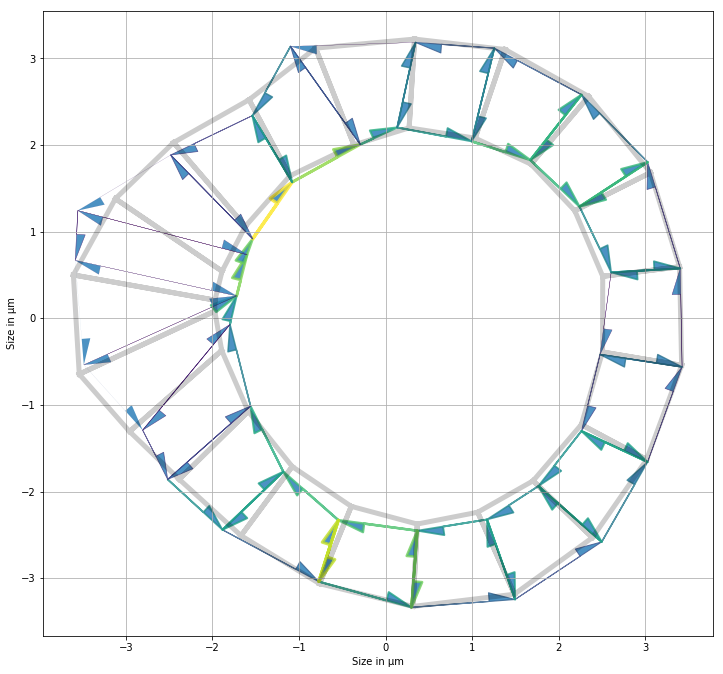

In [30]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas_sym.x[:organo3.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = res_2_cst_areas_sym.x[4*organo3.Nf:5*organo3.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = res_2_cst_areas_sym.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo3)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo3, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo3.edge_df.line_tension[:3*organo3.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo3.Nf]))))

Distance from th organo to exp organo : 0.5357887905753959
Distance from th tensions to exp tensions : 0.869709766244532


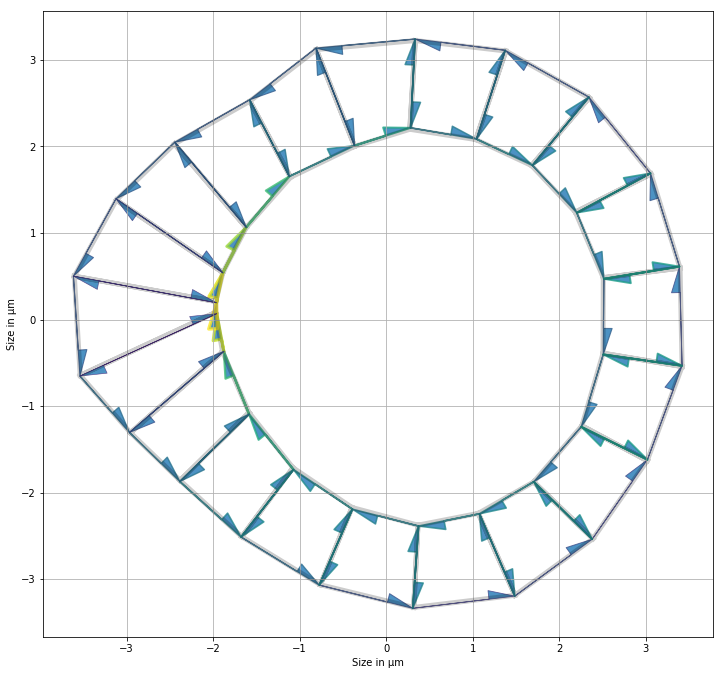

In [29]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas.x[:organo3.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = res_2_cst_areas.x[4*organo3.Nf:5*organo3.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = res_2_cst_areas.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo3)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo3, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo3.edge_df.line_tension[:3*organo3.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo3.Nf]))))

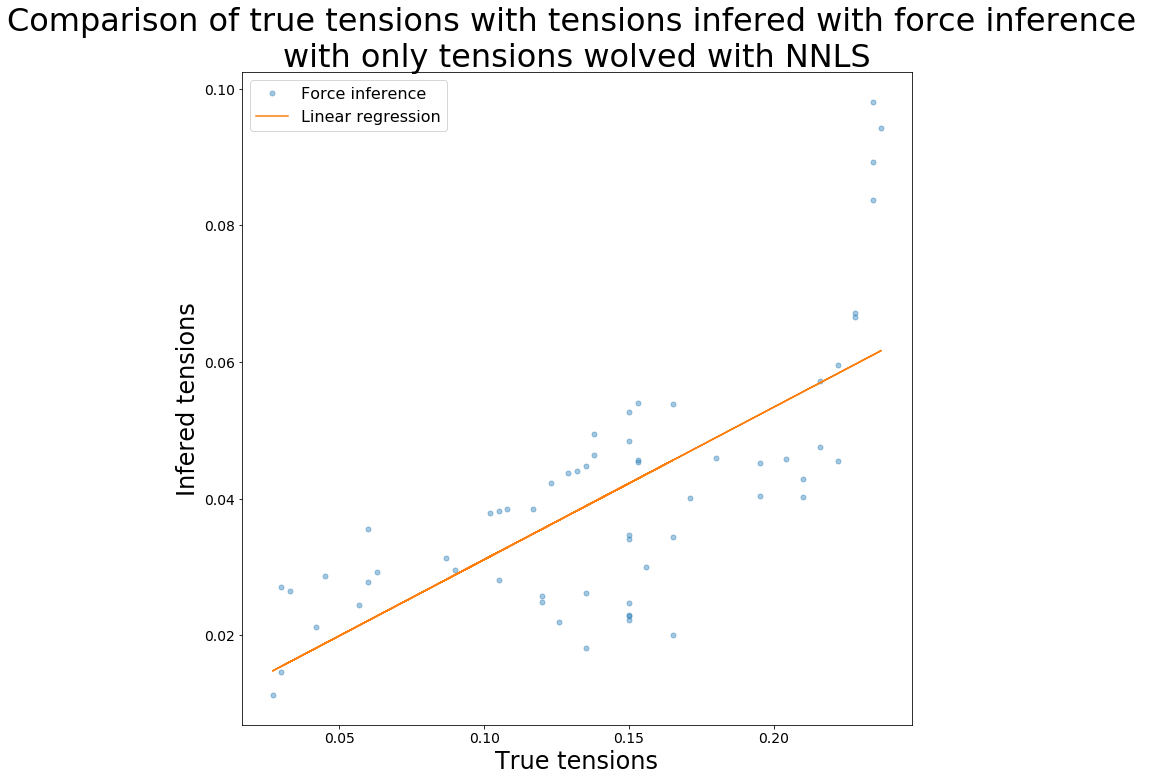

R value : 0.7162711253835958 
Standard error : 0.011066087475412066


In [27]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  res_2_cst_areas.x[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

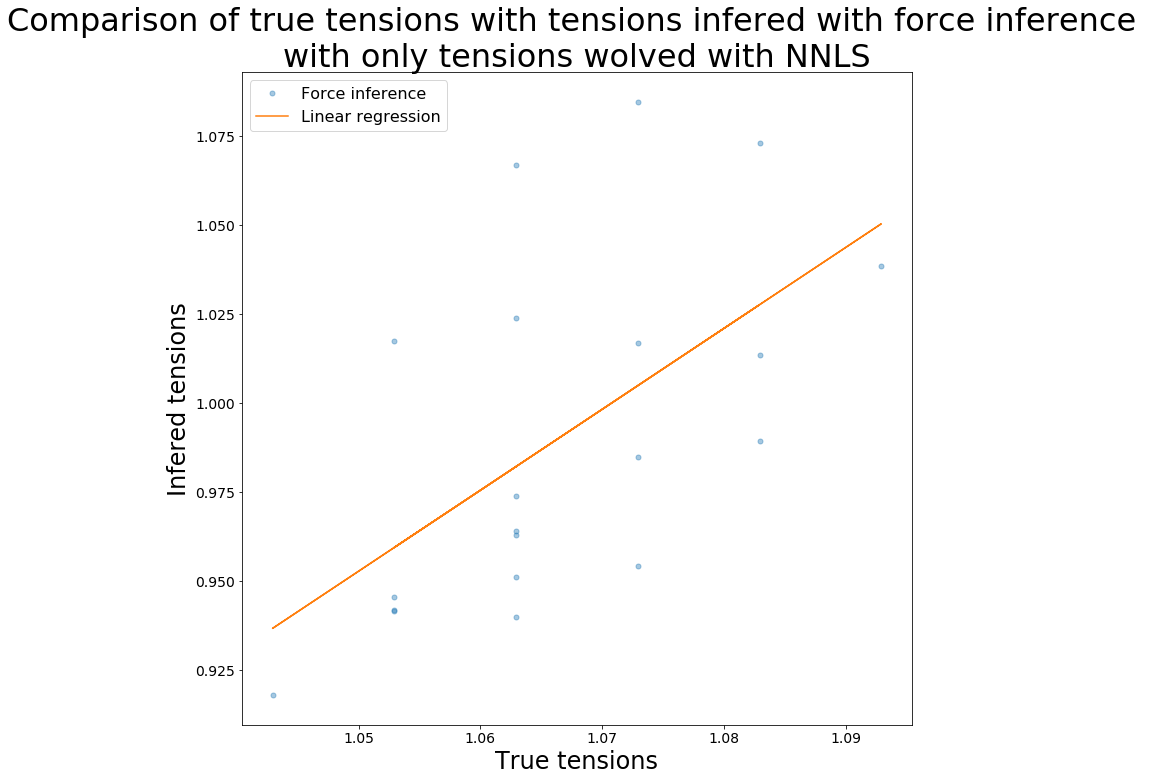

R value : 0.5852237591707217 
Standard error : 0.019450033612942064


In [28]:
rendering_results(organo3, organo3.face_df.eval('prefered_area'),
                  res_2_cst_areas.x[4*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))